In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, recall_score, precision_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import joblib
import os
from itertools import combinations

# Configurações de visualização
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# ===== CARREGAMENTO INICIAL DOS DADOS =====

# Carregar o dataset principal a partir de arquivo local
df = pd.read_csv('diabetes.csv')

print("\n" + "="*60)
print("📋 DADOS CARREGADOS COM SUCESSO")
print("="*60)
print(f"Dataset original: {df.shape[0]} linhas, {df.shape[1]} colunas")
print(f"\nPrimeira visão da distribuição da variável target:")
print(df['Outcome'].value_counts())
print(f"\nPercentual de balanceamento inicial:")
balanceamento = df['Outcome'].value_counts(normalize=True) * 100
print(f"Não-Diabetes: {balanceamento[0]:.1f}%")
print(f"Diabetes: {balanceamento[1]:.1f}%")
print(f"\n⚠️  Observação: Dataset desbalanceado - {balanceamento[0]:.1f}% vs {balanceamento[1]:.1f}%")
print("🔄 Será necessário tratamento de balanceamento")


📋 DADOS CARREGADOS COM SUCESSO
Dataset original: 768 linhas, 9 colunas

Primeira visão da distribuição da variável target:
Outcome
0    500
1    268
Name: count, dtype: int64

Percentual de balanceamento inicial:
Não-Diabetes: 65.1%
Diabetes: 34.9%

⚠️  Observação: Dataset desbalanceado - 65.1% vs 34.9%
🔄 Será necessário tratamento de balanceamento


In [5]:
# Visualização das primeiras amostras
print("\n📋 PRIMEIRAS 5 AMOSTRAS")
print("=" * 50)
display(df.head())

print("\n📊 ESTATÍSTICAS DESCRITIVAS")
print("=" * 50)
display(df.describe())

print("\n🎯 DISTRIBUIÇÃO DA VARIÁVEL TARGET")
print("=" * 50)
target_dist = df['Outcome'].value_counts()
print(f"Não-diabéticos (0): {target_dist[0]} ({target_dist[0]/len(df)*100:.1f}%)")
print(f"Diabéticos (1): {target_dist[1]} ({target_dist[1]/len(df)*100:.1f}%)")


📋 PRIMEIRAS 5 AMOSTRAS


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1


📊 ESTATÍSTICAS DESCRITIVAS


Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000


🎯 DISTRIBUIÇÃO DA VARIÁVEL TARGET
Não-diabéticos (0): 500 (65.1%)
Diabéticos (1): 268 (34.9%)


## 📈 **2.2 Análise Exploratória dos Dados**

### **Verificação de Qualidade dos Dados**
Análise detalhada para identificar:
- **Valores ausentes**: Verificação de dados faltantes
- **Valores zero anômalos**: Identificação de zeros biologicamente impossíveis
- **Distribuições das variáveis**: Análise estatística das features
- **Correlações**: Relacionamento entre variáveis preditoras

In [6]:
# ===== ANÁLISE EXPLORATÓRIA DETALHADA =====

print("\n" + "="*70)
print("🔍 ANÁLISE EXPLORATÓRIA DETALHADA DOS DADOS")
print("="*70)

# Informações básicas do dataset
print("\n📊 INFORMAÇÕES GERAIS:")
print(f"Shape: {df.shape}")
print(f"Tipos de dados:\n{df.dtypes}")
print(f"\nMemória utilizada: {df.memory_usage(deep=True).sum():,.0f} bytes")

# Estatísticas descritivas
print("\n📊 ESTATÍSTICAS DESCRITIVAS:")
print(df.describe().round(2))

# Verificar valores ausentes
print("\n🔍 VALORES AUSENTES:")
valores_ausentes = df.isnull().sum()
if valores_ausentes.sum() == 0:
    print("✅ Nenhum valor ausente encontrado")
else:
    print(valores_ausentes[valores_ausentes > 0])

# Verificar valores suspeitos (zeros em variáveis que não deveriam ser zero)
print("\n⚠️  VALORES SUSPEITOS (zeros em variáveis biológicas):")
vars_biologicas = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for var in vars_biologicas:
    zeros = (df[var] == 0).sum()
    if zeros > 0:
        print(f"{var}: {zeros} zeros ({zeros/len(df):.1%})")

# Distribuição da variável target
print("\n🎯 DISTRIBUIÇÃO DA VARIÁVEL TARGET:")
print(df['Outcome'].value_counts())
print("\nProporções:")
print(df['Outcome'].value_counts(normalize=True).round(3))

# Correlações básicas
print("\n🔗 CORRELAÇÕES COM A VARIÁVEL TARGET:")
correlacoes = df.corr()['Outcome'].abs().sort_values(ascending=False)
print(correlacoes[correlacoes.index != 'Outcome'].round(3))


🔍 ANÁLISE EXPLORATÓRIA DETALHADA DOS DADOS

📊 INFORMAÇÕES GERAIS:
Shape: (768, 9)
Tipos de dados:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Memória utilizada: 55,428 bytes

📊 ESTATÍSTICAS DESCRITIVAS:
       Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  \
count       768.00   768.00         768.00         768.00   768.00  768.00   
mean          3.85   120.89          69.11          20.54    79.80   31.99   
std           3.37    31.97          19.36          15.95   115.24    7.88   
min           0.00     0.00           0.00           0.00     0.00    0.00   
25%           1.00    99.00          62.00           0.00     0.00   27.30   
50%           3.00   117.00      

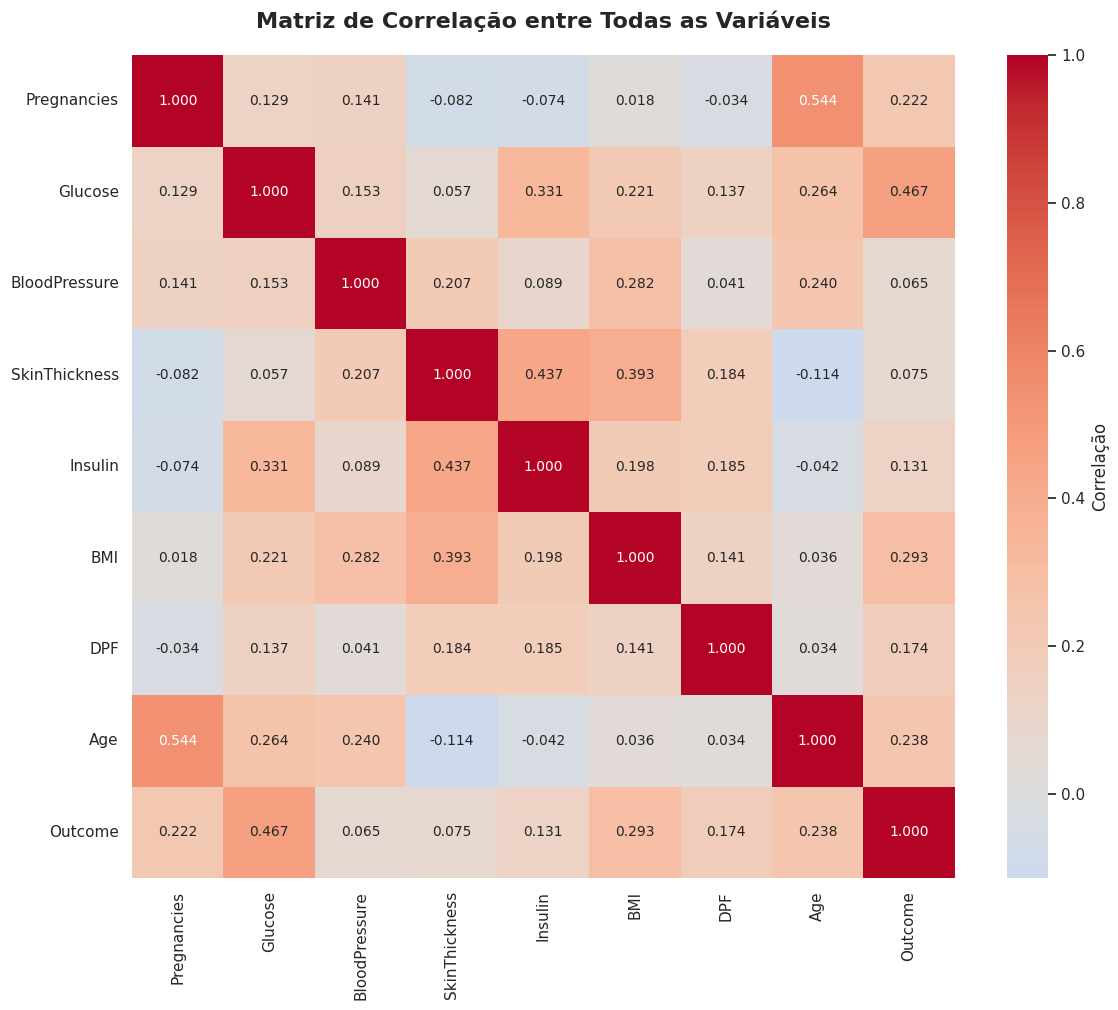

In [7]:
# HEATMAP DE CORRELAÇÃO BÁSICO DO DATASET
plt.figure(figsize=(12, 10))  # Aumentei o tamanho para dar mais espaço

# Calcular matriz de correlação do dataset original
correlation_matrix = df.corr()

# Renomear a coluna longa para uma sigla
correlation_matrix_renamed = correlation_matrix.copy()
correlation_matrix_renamed.index = correlation_matrix_renamed.index.str.replace('DiabetesPedigreeFunction', 'DPF')
correlation_matrix_renamed.columns = correlation_matrix_renamed.columns.str.replace('DiabetesPedigreeFunction', 'DPF')

# Criar heatmap
sns.heatmap(correlation_matrix_renamed, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', cbar_kws={'label': 'Correlação'},
            annot_kws={'size': 10})

# Título com formatação melhorada
plt.title('Matriz de Correlação entre Todas as Variáveis', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [8]:
# ===== FASE 3.1: DIVISÃO ESTRATIFICADA DOS DADOS =====

print("\n" + "="*70)
print("📊 FASE 3.1: DIVISÃO ESTRATIFICADA DOS DADOS")
print("="*70)

# Separar features e target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

print(f"\n📋 Dimensões originais:")
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"Classes no target: {y.unique()}")

# ETAPA 1: Separar 20% para teste (conjunto final de avaliação)
print(f"\n🔄 ETAPA 1: Separando conjunto de teste (20%)")
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# ETAPA 2: Dividir os 80% restantes em treino (60% total) e validação (20% total)
print(f"🔄 ETAPA 2: Separando treino e validação dos 80% restantes")
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, 
    test_size=0.25,  # 25% de 80% = 20% do total
    random_state=42, 
    stratify=y_temp
)

print(f"\n📈 RESULTADO DA DIVISÃO:")
print("-"*50)
print(f"{'Conjunto':<12} {'Amostras':<10} {'% Total':<10} {'% Classe 0':<12} {'% Classe 1':<12}")
print("-"*50)

# Calcular estatísticas para cada conjunto
conjuntos = [
    ('Treino', X_train, y_train),
    ('Validação', X_val, y_val),
    ('Teste', X_test, y_test)
]

for nome, X_conj, y_conj in conjuntos:
    total_amostras = len(y_conj)
    perc_total = total_amostras / len(y) * 100
    classe_0 = (y_conj == 0).sum()
    classe_1 = (y_conj == 1).sum()
    perc_classe_0 = classe_0 / total_amostras * 100
    perc_classe_1 = classe_1 / total_amostras * 100
    
    print(f"{nome:<12} {total_amostras:<10} {perc_total:<10} {perc_classe_0:<12} {perc_classe_1:<12}")

print("-"*50)

# Verificar se a estratificação foi bem-sucedida
print(f"\n✅ VERIFICAÇÃO DA ESTRATIFICAÇÃO:")
original_ratio = y.mean()
print(f"Proporção original de diabetes: {original_ratio:.3f}")

for nome, _, y_conj in conjuntos:
    ratio = y_conj.mean()
    print(f"Proporção em {nome}: {ratio:.3f} (diferença: {abs(ratio - original_ratio):.3f})")

print(f"\n🎯 OBJETIVO ALCANÇADO: Todos os conjuntos mantêm proporções similares!")

# Salvar informações da divisão
divisao_info = {
    'treino_size': len(y_train),
    'val_size': len(y_val),
    'test_size': len(y_test),
    'original_ratio': original_ratio,
    'treino_ratio': y_train.mean(),
    'val_ratio': y_val.mean(),
    'test_ratio': y_test.mean()
}

print(f"\n💾 Informações da divisão salvas para referência futura.")


📊 FASE 3.1: DIVISÃO ESTRATIFICADA DOS DADOS

📋 Dimensões originais:
Features (X): (768, 8)
Target (y): (768,)
Classes no target: [1 0]

🔄 ETAPA 1: Separando conjunto de teste (20%)
🔄 ETAPA 2: Separando treino e validação dos 80% restantes

📈 RESULTADO DA DIVISÃO:
--------------------------------------------------
Conjunto     Amostras   % Total    % Classe 0   % Classe 1  
--------------------------------------------------
Treino       460        59.895833333333336 65.21739130434783 34.78260869565217
Validação    154        20.052083333333336 64.93506493506493 35.064935064935064
Teste        154        20.052083333333336 64.93506493506493 35.064935064935064
--------------------------------------------------

✅ VERIFICAÇÃO DA ESTRATIFICAÇÃO:
Proporção original de diabetes: 0.349
Proporção em Treino: 0.348 (diferença: 0.001)
Proporção em Validação: 0.351 (diferença: 0.002)
Proporção em Teste: 0.351 (diferença: 0.002)

🎯 OBJETIVO ALCANÇADO: Todos os conjuntos mantêm proporções similares!


📊 FASE 3.2: TRATAMENTO DE OUTLIERS COM VISUALIZAÇÃO DETALHADA

📈 RESULTADO GERAL DA REMOÇÃO DE OUTLIERS:
Amostras originais: 460
Amostras após limpeza: 385
Total de outliers removidos: 75
Percentual removido: 16.3%

📊 DETALHES POR FEATURE:
--------------------------------------------------------------------------------------------------------------
Feature                   Q1       Q3       IQR      Lower    Upper    Outliers  %     
--------------------------------------------------------------------------------------------------------------
Pregnancies               1.00     6.00     5.00     -6.50    13.50    1         0.2   
Glucose                   99.00    140.00   41.00    37.50    201.50   4         0.9   
BloodPressure             62.00    80.00    18.00    35.00    107.00   27        5.9   
SkinThickness             0.00     33.00    33.00    -49.50   82.50    1         0.2   
Insulin                   0.00     130.00   130.00   -195.00  325.00   16        3.7   
BMI      

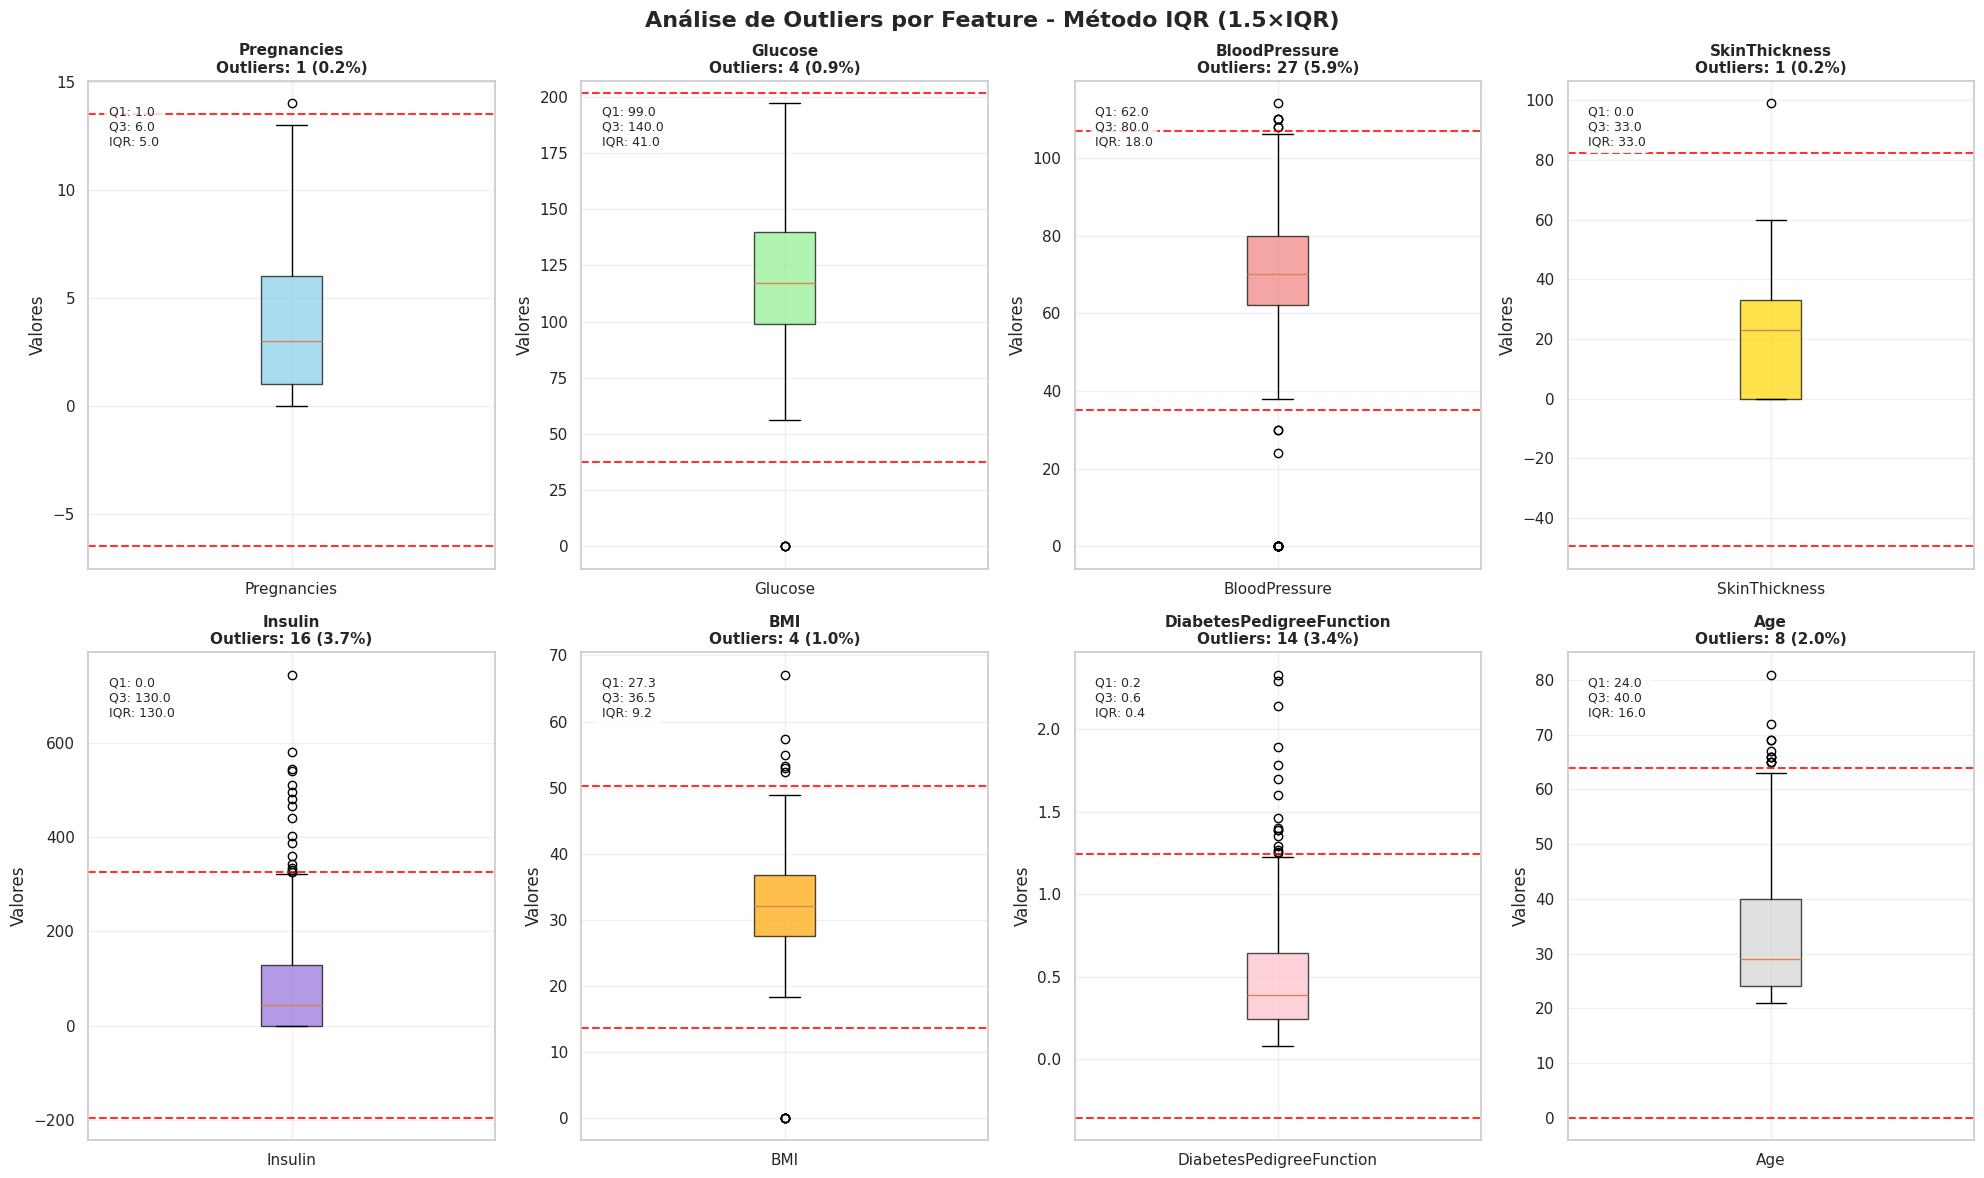

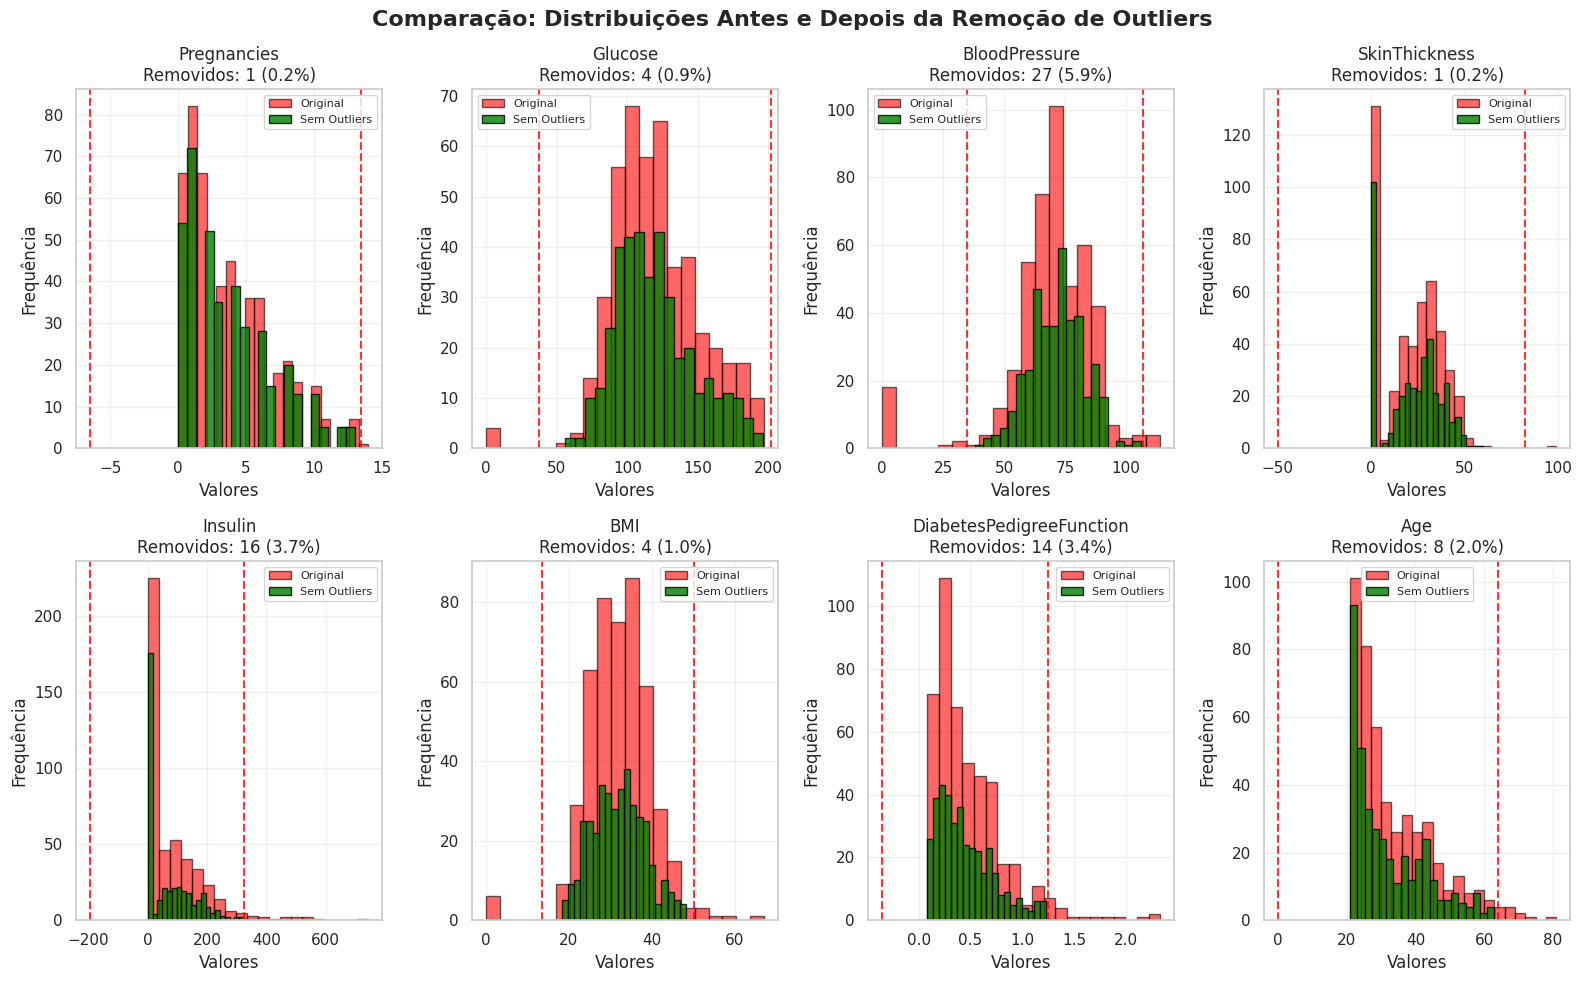


📋 IMPACTO DETALHADO DA REMOÇÃO DE OUTLIERS:
Feature                   Min Orig  Max Orig  Min Limpo  Max Limpo  Abaixo  Acima  Total 
Pregnancies               0.0       14.0      0.0        13.0       0       1      1     
Glucose                   0.0       197.0     56.0       196.0      4       0      4     
BloodPressure             0.0       114.0     38.0       106.0      21      6      27    
SkinThickness             0.0       99.0      0.0        60.0       0       1      1     
Insulin                   0.0       744.0     0.0        325.0      0       16     16    
BMI                       0.0       57.3      18.2       48.3       1       3      4     
DiabetesPedigreeFunction  0.1       2.3       0.1        1.2        0       14     14    
Age                       21.0      81.0      21.0       63.0       0       8      8     

🎯 IMPACTO NO BALANCEAMENTO DE CLASSES:
Antes da limpeza:
  Classe 0: 300 (65.2%)
  Classe 1: 160 (34.8%)
Após a limpeza:
  Classe 0: 261 (67.8%)

In [19]:
# ===== FASE 3.2: TRATAMENTO DE OUTLIERS COM VISUALIZAÇÃO =====

print("\n" + "="*70)
print("📊 FASE 3.2: TRATAMENTO DE OUTLIERS COM VISUALIZAÇÃO DETALHADA")
print("="*70)

# Função para remover outliers com informações detalhadas
def remove_outliers_iqr_detailed(data, columns):
      """
      Remove outliers usando o método IQR com informações detalhadas por feature
      """
      clean_data = data.copy()
      outlier_info = {}
      
      for column in columns:
            Q1 = clean_data[column].quantile(0.25)
            Q3 = clean_data[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Identificar outliers
            outliers_mask = (clean_data[column] < lower_bound) | (clean_data[column] > upper_bound)
            outliers_count = outliers_mask.sum()
            
            # Armazenar informações
            outlier_info[column] = {
                  'Q1': Q1,
                  'Q3': Q3,
                  'IQR': IQR,
                  'lower_bound': lower_bound,
                  'upper_bound': upper_bound,
                  'outliers_count': outliers_count,
                  'outliers_percentage': (outliers_count / len(clean_data)) * 100,
                  'original_min': clean_data[column].min(),
                  'original_max': clean_data[column].max(),
                  'outliers_below': (clean_data[column] < lower_bound).sum(),
                  'outliers_above': (clean_data[column] > upper_bound).sum()
            }
            
            # Remover outliers
            clean_data = clean_data[(clean_data[column] >= lower_bound) & (clean_data[column] <= upper_bound)]
      
      return clean_data, outlier_info

# Aplicar remoção de outliers com informações detalhadas
feature_columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
X_train_clean_df = pd.DataFrame(X_train, columns=feature_columns)
y_train_clean = y_train.copy()

X_train_clean_df, outlier_details = remove_outliers_iqr_detailed(X_train_clean_df, feature_columns)
y_train_clean = y_train_clean[X_train_clean_df.index]

# Calcular total de outliers removidos
total_outliers = len(X_train) - len(X_train_clean_df)

print(f"\n📈 RESULTADO GERAL DA REMOÇÃO DE OUTLIERS:")
print(f"Amostras originais: {len(X_train)}")
print(f"Amostras após limpeza: {len(X_train_clean_df)}")
print(f"Total de outliers removidos: {total_outliers}")
print(f"Percentual removido: {(total_outliers / len(X_train)) * 100:.1f}%")

# Exibir detalhes por feature
print(f"\n📊 DETALHES POR FEATURE:")
print("-" * 110)
print(f"{'Feature':<25} {'Q1':<8} {'Q3':<8} {'IQR':<8} {'Lower':<8} {'Upper':<8} {'Outliers':<9} {'%':<6}")
print("-" * 110)

for feature, info in outlier_details.items():
      print(f"{feature:<25} {info['Q1']:<8.2f} {info['Q3']:<8.2f} {info['IQR']:<8.2f} "
              f"{info['lower_bound']:<8.2f} {info['upper_bound']:<8.2f} {info['outliers_count']:<9} "
              f"{info['outliers_percentage']:<6.1f}")

# ===== VISUALIZAÇÃO DOS OUTLIERS =====

# Criar figura com subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
fig.suptitle('Análise de Outliers por Feature - Método IQR (1.5×IQR)', fontsize=16, fontweight='bold')

# Cores para os gráficos
colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'mediumpurple', 'orange', 'pink', 'lightgray']

for idx, (feature, info) in enumerate(outlier_details.items()):
      row = idx // 4
      col = idx % 4
      
      # Dados originais
      original_data = pd.DataFrame(X_train, columns=feature_columns)[feature]
      
      # Criar boxplot
      box_data = [original_data]
      bp = axes[row, col].boxplot(box_data, patch_artist=True, tick_labels=[feature])
      bp['boxes'][0].set_facecolor(colors[idx])
      bp['boxes'][0].set_alpha(0.7)
      
      # Adicionar linhas de referência IQR
      axes[row, col].axhline(y=info['lower_bound'], color='red', linestyle='--', 
                                      alpha=0.8, label=f'Lower: {info["lower_bound"]:.1f}')
      axes[row, col].axhline(y=info['upper_bound'], color='red', linestyle='--', 
                                      alpha=0.8, label=f'Upper: {info["upper_bound"]:.1f}')
      
      # Configurar título e labels
      axes[row, col].set_title(f'{feature}\nOutliers: {info["outliers_count"]} ({info["outliers_percentage"]:.1f}%)', 
                                          fontsize=11, fontweight='bold')
      axes[row, col].set_ylabel('Valores')
      axes[row, col].grid(True, alpha=0.3)
      
      # Adicionar texto com estatísticas
      stats_text = f"Q1: {info['Q1']:.1f}\nQ3: {info['Q3']:.1f}\nIQR: {info['IQR']:.1f}"
      axes[row, col].text(0.05, 0.95, stats_text, transform=axes[row, col].transAxes, 
                                 verticalalignment='top', fontsize=9, 
                                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

# ===== GRÁFICO DE BARRAS COM PERCENTUAL DE OUTLIERS =====

plt.figure(figsize=(14, 8))

features = list(outlier_details.keys())
outlier_percentages = [outlier_details[feature]['outliers_percentage'] for feature in features]
outlier_counts = [outlier_details[feature]['outliers_count'] for feature in features]

# Criar gráfico de barras
bars = plt.bar(features, outlier_percentages, color=colors, alpha=0.7, edgecolor='black', linewidth=1)

# Adicionar valores nas barras
for i, (bar, count, percentage) in enumerate(zip(bars, outlier_counts, outlier_percentages)):
      plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                   f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', 
                   fontsize=10, fontweight='bold')

plt.title('Percentual de Outliers Removidos por Feature - Método IQR', fontsize=14, fontweight='bold')
plt.xlabel('Features', fontsize=12)
plt.ylabel('Percentual de Outliers (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Adicionar linha de referência
plt.axhline(y=5, color='orange', linestyle='--', alpha=0.7, label='5% (Referência)')
plt.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='10% (Alto)')

plt.legend()
plt.tight_layout()
plt.show()

# ===== COMPARAÇÃO ANTES E DEPOIS =====

plt.figure(figsize=(16, 10))

for idx, feature in enumerate(feature_columns):
      plt.subplot(2, 4, idx + 1)
      
      # Dados originais e limpos
      original_data = pd.DataFrame(X_train, columns=feature_columns)[feature]
      clean_data = X_train_clean_df[feature]
      
      # Histogramas sobrepostos
      plt.hist(original_data, bins=20, alpha=0.6, label='Original', color='red', edgecolor='black')
      plt.hist(clean_data, bins=20, alpha=0.8, label='Sem Outliers', color='green', edgecolor='black')
      
      # Adicionar estatísticas
      info = outlier_details[feature]
      plt.axvline(info['lower_bound'], color='red', linestyle='--', alpha=0.8)
      plt.axvline(info['upper_bound'], color='red', linestyle='--', alpha=0.8)
      
      plt.title(f'{feature}\nRemovidos: {info["outliers_count"]} ({info["outliers_percentage"]:.1f}%)')
      plt.xlabel('Valores')
      plt.ylabel('Frequência')
      plt.legend(fontsize=8)
      plt.grid(True, alpha=0.3)

plt.suptitle('Comparação: Distribuições Antes e Depois da Remoção de Outliers', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ===== IMPACTO NUMÉRICO DETALHADO =====

print(f"\n📋 IMPACTO DETALHADO DA REMOÇÃO DE OUTLIERS:")
print("=" * 115)
print(f"{'Feature':<25} {'Min Orig':<9} {'Max Orig':<9} {'Min Limpo':<10} {'Max Limpo':<10} {'Abaixo':<7} {'Acima':<6} {'Total':<6}")
print("=" * 115)

for feature, info in outlier_details.items():
      clean_data = X_train_clean_df[feature]
      print(f"{feature:<25} {info['original_min']:<9.1f} {info['original_max']:<9.1f} "
              f"{clean_data.min():<10.1f} {clean_data.max():<10.1f} "
              f"{info['outliers_below']:<7} {info['outliers_above']:<6} {info['outliers_count']:<6}")

print("=" * 115)

# ===== DISTRIBUIÇÃO DE CLASSES APÓS LIMPEZA =====

print(f"\n🎯 IMPACTO NO BALANCEAMENTO DE CLASSES:")
print(f"Antes da limpeza:")
print(f"  Classe 0: {(y_train == 0).sum()} ({(y_train == 0).mean():.1%})")
print(f"  Classe 1: {(y_train == 1).sum()} ({(y_train == 1).mean():.1%})")

print(f"Após a limpeza:")
print(f"  Classe 0: {(y_train_clean == 0).sum()} ({(y_train_clean == 0).mean():.1%})")
print(f"  Classe 1: {(y_train_clean == 1).sum()} ({(y_train_clean == 1).mean():.1%})")

# Verificar se o balanceamento foi mantido
diff_original = abs((y_train == 0).mean() - (y_train_clean == 0).mean())
if diff_original < 0.02:
      print("✅ Balanceamento original preservado!")
else:
      print("⚠️ Pequena alteração no balanceamento (normal)")

print(f"\n✅ Análise de outliers concluída!")
print(f"💾 {total_outliers} outliers removidos usando método IQR (Q1-1.5×IQR, Q3+1.5×IQR)")
print(f"🎯 Dados limpos prontos para a próxima etapa (SMOTE)")

In [10]:
# ===== FASE 3.3: BALANCEAMENTO COM SMOTE =====

print("\n" + "="*70)
print("🎯 FASE 3.3: BALANCEAMENTO COM SMOTE")
print("="*70)

# Exibir estado antes do SMOTE
print(f"\n📈 ESTADO ANTES DO SMOTE:")
print(f"Total de amostras: {len(X_train_clean_df)}")
print(f"Classe 0 (não-diabetes): {(y_train_clean == 0).sum()} ({(y_train_clean == 0).mean():.1%})")
print(f"Classe 1 (diabetes): {(y_train_clean == 1).sum()} ({(y_train_clean == 1).mean():.1%})")
print(f"Ratio de desbalanceamento: {(y_train_clean == 0).sum() / (y_train_clean == 1).sum():.1f}:1")

# Inicializar SMOTE
print(f"\n🤖 Inicializando SMOTE...")
smote = SMOTE(random_state=42, k_neighbors=5)

print(f"Parâmetros do SMOTE:")
print(f"- k_neighbors: {smote.k_neighbors} (número de vizinhos para geração)")
print(f"- random_state: {smote.random_state} (para reprodutibilidade)")
print(f"- sampling_strategy: 'auto' (equilibra automaticamente)")

# Aplicar SMOTE
print(f"\n🔄 Aplicando SMOTE nos dados de treino limpos...")
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_clean_df, y_train_clean)

# Exibir resultados
print(f"\n✅ RESULTADO DO SMOTE:")
print(f"Amostras antes: {len(X_train_clean_df)}")
print(f"Amostras depois: {len(X_train_balanced)}")
print(f"Amostras sintéticas criadas: {len(X_train_balanced) - len(X_train_clean_df)}")

print(f"\n📊 DISTRIBUIÇÃO FINAL:")
print("-"*50)
print(f"{'Classe':<15} {'Antes':<10} {'Depois':<10} {'Adicionadas':<12}")
print("-"*50)

# Classe 0 (não-diabetes)
antes_0 = (y_train_clean == 0).sum()
depois_0 = (y_train_balanced == 0).sum()
adicionadas_0 = depois_0 - antes_0
print(f"Não-diabetes   {antes_0:<10} {depois_0:<10} {adicionadas_0:<12}")

# Classe 1 (diabetes)
antes_1 = (y_train_clean == 1).sum()
depois_1 = (y_train_balanced == 1).sum()
adicionadas_1 = depois_1 - antes_1
print(f"Diabetes       {antes_1:<10} {depois_1:<10} {adicionadas_1:<12}")

print("-"*50)
print(f"Total          {len(y_train_clean):<10} {len(y_train_balanced):<10} {len(y_train_balanced) - len(y_train_clean):<12}")

# Verificar balanceamento final
ratio_final = (y_train_balanced == 0).sum() / (y_train_balanced == 1).sum()
print(f"\n🎯 VERIFICAÇÃO DO BALANCEAMENTO:")
print(f"Proporção final - Classe 0: {(y_train_balanced == 0).mean():.1%}")
print(f"Proporção final - Classe 1: {(y_train_balanced == 1).mean():.1%}")
print(f"Novo ratio: {ratio_final:.1f}:1")

if abs((y_train_balanced == 0).mean() - 0.5) < 0.01:
    print("✅ Balanceamento perfeito alcançado (50:50)!")
else:
    print("⚠️ Balanceamento quase perfeito.")

print(f"\n✅ SMOTE aplicado com sucesso! Dados prontos para normalização.")


🎯 FASE 3.3: BALANCEAMENTO COM SMOTE

📈 ESTADO ANTES DO SMOTE:
Total de amostras: 385
Classe 0 (não-diabetes): 261 (67.8%)
Classe 1 (diabetes): 124 (32.2%)
Ratio de desbalanceamento: 2.1:1

🤖 Inicializando SMOTE...
Parâmetros do SMOTE:
- k_neighbors: 5 (número de vizinhos para geração)
- random_state: 42 (para reprodutibilidade)
- sampling_strategy: 'auto' (equilibra automaticamente)

🔄 Aplicando SMOTE nos dados de treino limpos...

✅ RESULTADO DO SMOTE:
Amostras antes: 385
Amostras depois: 522
Amostras sintéticas criadas: 137

📊 DISTRIBUIÇÃO FINAL:
--------------------------------------------------
Classe          Antes      Depois     Adicionadas 
--------------------------------------------------
Não-diabetes   261        261        0           
Diabetes       124        261        137         
--------------------------------------------------
Total          385        522        137         

🎯 VERIFICAÇÃO DO BALANCEAMENTO:
Proporção final - Classe 0: 50.0%
Proporção final - Class


📊 FASE 3.2: TRATAMENTO DE OUTLIERS COM VISUALIZAÇÃO DETALHADA

📈 RESULTADO GERAL DA REMOÇÃO DE OUTLIERS:
Amostras originais: 460
Amostras após limpeza: 385
Total de outliers removidos: 75
Percentual removido: 16.3%

📊 DETALHES POR FEATURE:
--------------------------------------------------------------------------------------------------------------
Feature                   Q1       Q3       IQR      Lower    Upper    Outliers  %     
--------------------------------------------------------------------------------------------------------------
Pregnancies               1.00     6.00     5.00     -6.50    13.50    1         0.2   
Glucose                   99.00    140.00   41.00    37.50    201.50   4         0.9   
BloodPressure             62.00    80.00    18.00    35.00    107.00   27        5.9   
SkinThickness             0.00     33.00    33.00    -49.50   82.50    1         0.2   
Insulin                   0.00     130.00   130.00   -195.00  325.00   16        3.7   
BMI      

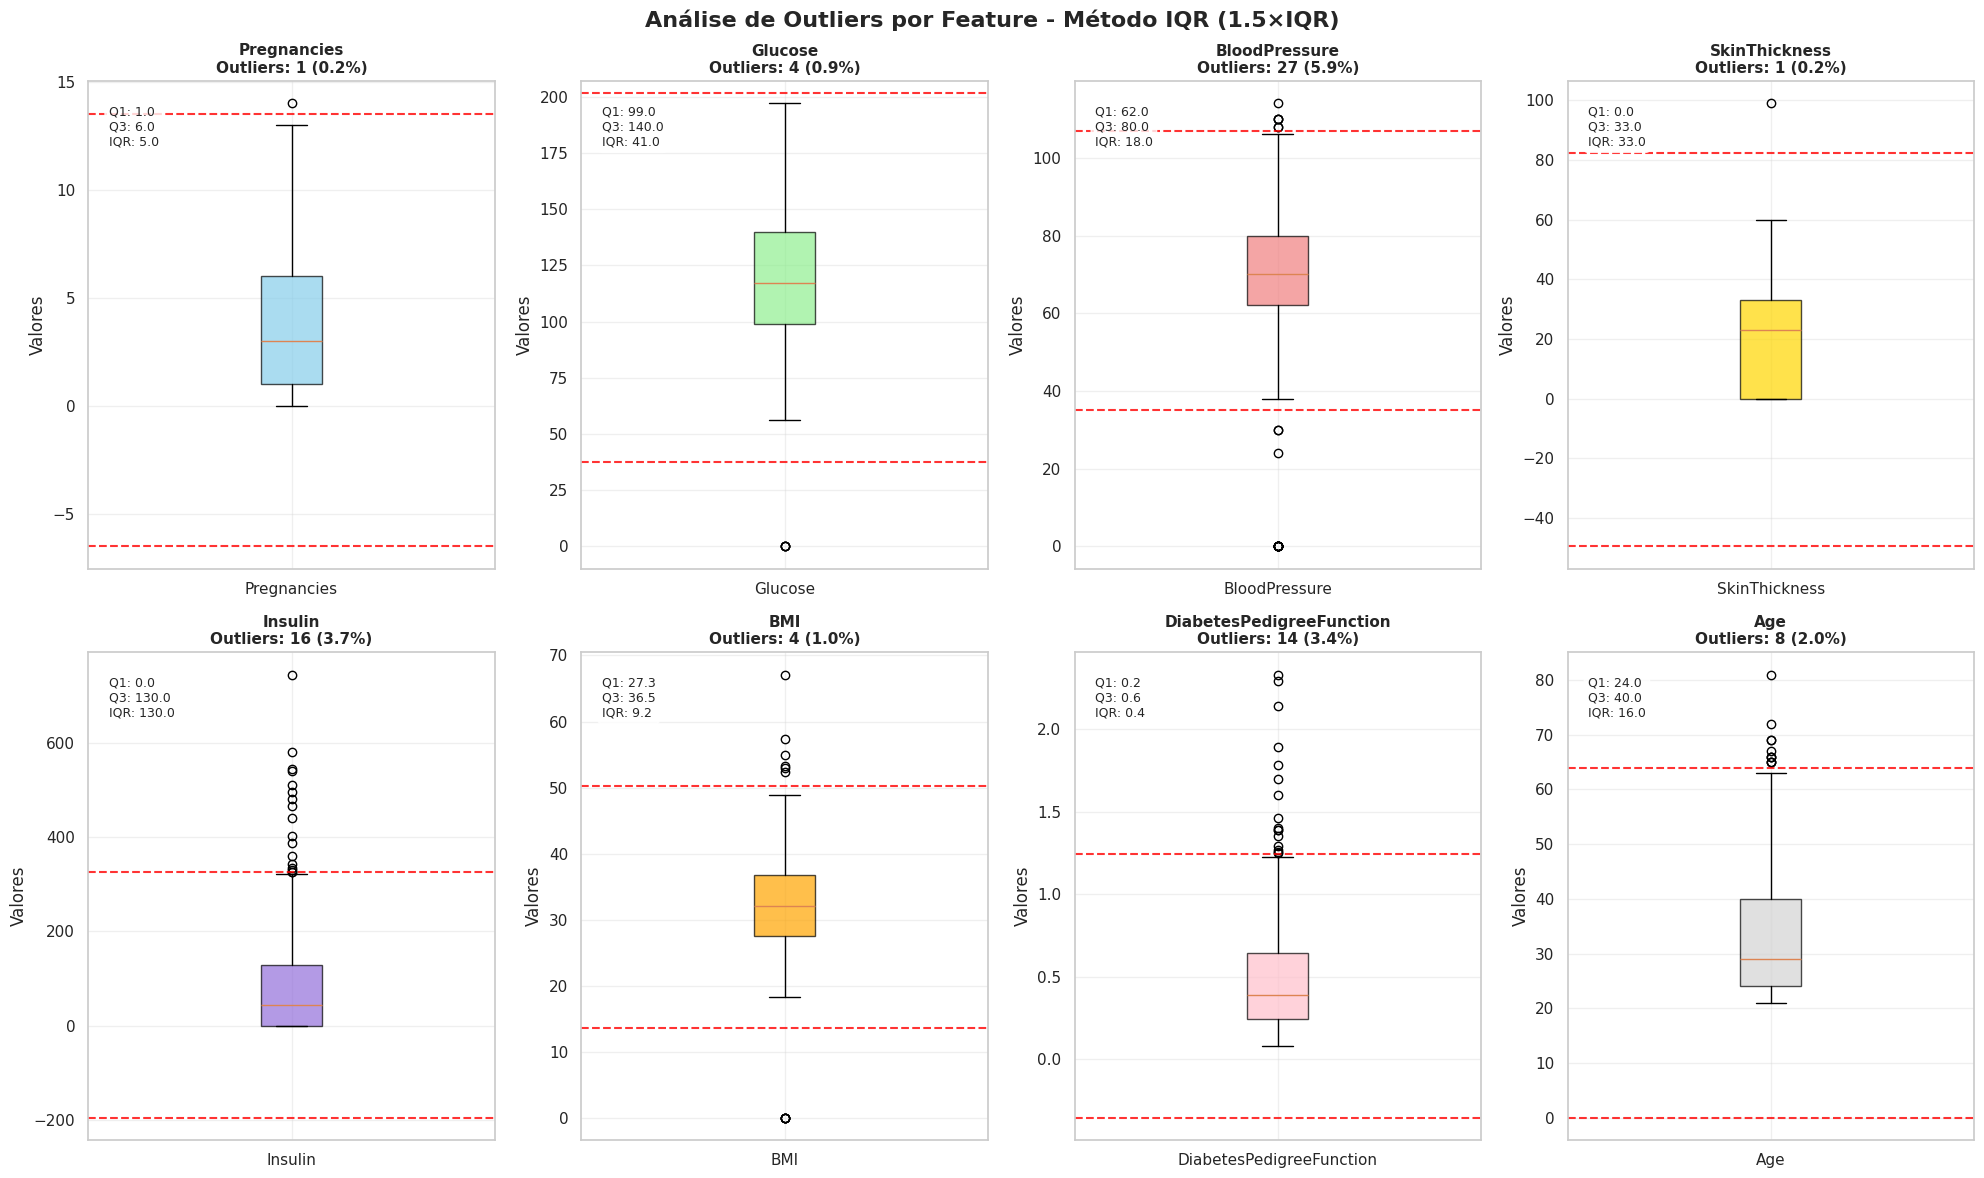

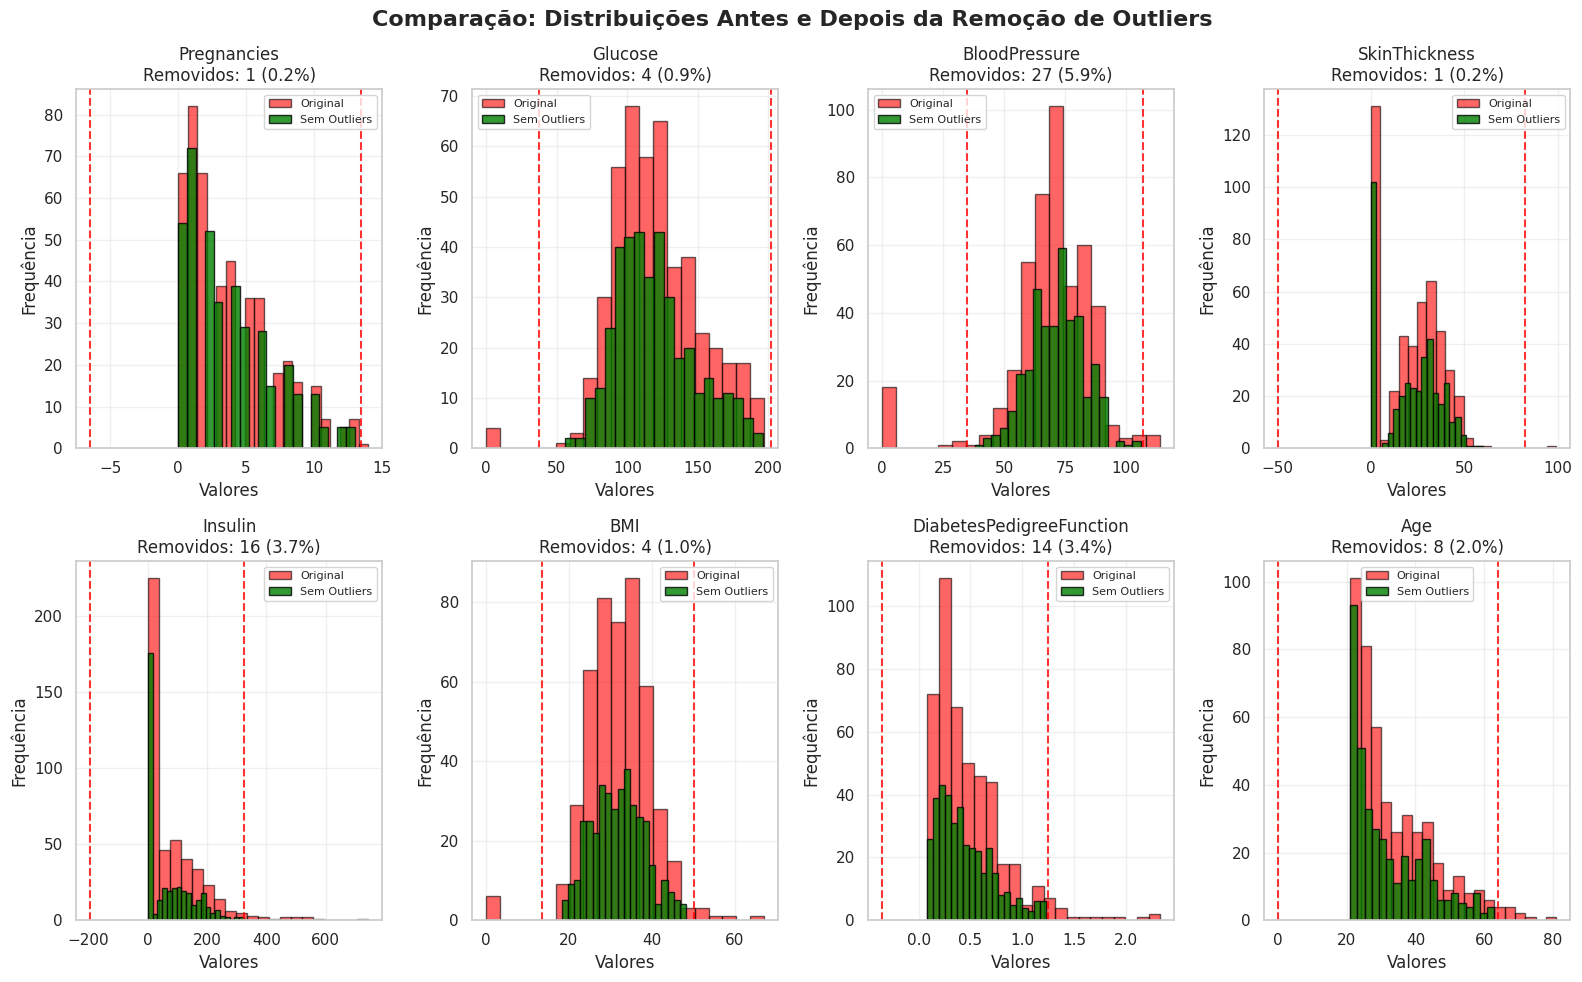


📋 IMPACTO DETALHADO DA REMOÇÃO DE OUTLIERS:
Feature                   Min Orig  Max Orig  Min Limpo  Max Limpo  Abaixo  Acima  Total 
Pregnancies               0.0       14.0      0.0        13.0       0       1      1     
Glucose                   0.0       197.0     56.0       196.0      4       0      4     
BloodPressure             0.0       114.0     38.0       106.0      21      6      27    
SkinThickness             0.0       99.0      0.0        60.0       0       1      1     
Insulin                   0.0       744.0     0.0        325.0      0       16     16    
BMI                       0.0       57.3      18.2       48.3       1       3      4     
DiabetesPedigreeFunction  0.1       2.3       0.1        1.2        0       14     14    
Age                       21.0      81.0      21.0       63.0       0       8      8     

🎯 IMPACTO NO BALANCEAMENTO DE CLASSES:
Antes da limpeza:
  Classe 0: 300 (65.2%)
  Classe 1: 160 (34.8%)
Após a limpeza:
  Classe 0: 261 (67.8%)

In [ ]:
# ===== VISUALIZAÇÃO DO IMPACTO DO SMOTE =====

print("\n" + "="*70)
print("📊 VISUALIZAÇÃO DO IMPACTO DO SMOTE")
print("="*70)

# Criar visualização comparativa
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
fig.suptitle('Comparação: Original vs SMOTE', fontsize=16, fontweight='bold')

# Lista das primeiras 8 features para visualização
features_viz = feature_columns[:8] if len(feature_columns) >= 8 else feature_columns

for i, feature in enumerate(features_viz):
    row = i // 4
    col = i % 4
    
    # Dados antes do SMOTE
    dados_classe_0_antes = X_train_clean_df[y_train_clean == 0][feature]
    dados_classe_1_antes = X_train_clean_df[y_train_clean == 1][feature]
    
    # Dados depois do SMOTE
    dados_classe_0_depois = pd.DataFrame(X_train_balanced, columns=feature_columns)[y_train_balanced == 0][feature]
    dados_classe_1_depois = pd.DataFrame(X_train_balanced, columns=feature_columns)[y_train_balanced == 1][feature]
    
    # Histogramas com cores mais contrastantes - focando na classe diabetes (que foi modificada pelo SMOTE)
    axes[row, col].hist(dados_classe_0_antes, bins=15, alpha=0.6, label='Não-Diabetes', 
                       color='navy', density=True)
    axes[row, col].hist(dados_classe_1_antes, bins=15, alpha=0.6, label='Diabetes (Original)', 
                       color='darkred', density=True)
    axes[row, col].hist(dados_classe_1_depois, bins=15, alpha=0.8, label='Diabetes (SMOTE)', 
                       color='orange', density=True, histtype='step', linewidth=3)
    
    axes[row, col].set_title(f'{feature}', fontsize=11, fontweight='bold')
    axes[row, col].set_xlabel('Valores')
    axes[row, col].set_ylabel('Densidade')
    axes[row, col].legend(fontsize=8)
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Gráfico de barras comparativo do balanceamento
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Antes do SMOTE
contagem_antes = [len(y_train_clean[y_train_clean == 0]), len(y_train_clean[y_train_clean == 1])]
cores_antes = ['steelblue', 'crimson']
barras_antes = ax1.bar(['Não-Diabetes', 'Diabetes'], contagem_antes, color=cores_antes, 
                      alpha=0.8, edgecolor='black', linewidth=2)

# Adicionar valores nas barras
for barra, valor in zip(barras_antes, contagem_antes):
    height = barra.get_height()
    ax1.text(barra.get_x() + barra.get_width()/2, height + 2, str(valor), 
            ha='center', va='bottom', fontweight='bold', fontsize=12)

ax1.set_title('ANTES do SMOTE', fontsize=14, fontweight='bold')
ax1.set_ylabel('Número de Amostras')
ax1.grid(axis='y', alpha=0.3)

# Adicionar percentuais
total_antes = sum(contagem_antes)
for i, (barra, valor) in enumerate(zip(barras_antes, contagem_antes)):
    perc = (valor / total_antes) * 100
    ax1.text(barra.get_x() + barra.get_width()/2, valor/2, f'{perc:.1f}%', 
            ha='center', va='center', fontweight='bold', fontsize=11, color='white')

# Depois do SMOTE
contagem_depois = [len(y_train_balanced[y_train_balanced == 0]), len(y_train_balanced[y_train_balanced == 1])]
cores_depois = ['steelblue', 'darkorange']  # Mantém mesma cor para não-diabetes
barras_depois = ax2.bar(['Não-Diabetes', 'Diabetes'], contagem_depois, color=cores_depois, 
                       alpha=0.8, edgecolor='black', linewidth=2)

# Adicionar valores nas barras
for barra, valor in zip(barras_depois, contagem_depois):
    height = barra.get_height()
    ax2.text(barra.get_x() + barra.get_width()/2, height + 5, str(valor), 
            ha='center', va='bottom', fontweight='bold', fontsize=12)

ax2.set_title('DEPOIS do SMOTE', fontsize=14, fontweight='bold')
ax2.set_ylabel('Número de Amostras')
ax2.grid(axis='y', alpha=0.3)

# Adicionar percentuais
total_depois = sum(contagem_depois)
for i, (barra, valor) in enumerate(zip(barras_depois, contagem_depois)):
    perc = (valor / total_depois) * 100
    ax2.text(barra.get_x() + barra.get_width()/2, valor/2, f'{perc:.1f}%', 
            ha='center', va='center', fontweight='bold', fontsize=11, color='white')

plt.tight_layout()
plt.show()

# Gráfico adicional: Visualização das amostras sintéticas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análise das Amostras Sintéticas Criadas pelo SMOTE', fontsize=16, fontweight='bold')

# Selecionar 4 features mais importantes para visualizar amostras sintéticas
features_importantes = ['Glucose', 'BMI', 'Age', 'DiabetesPedigreeFunction']

for i, feature in enumerate(features_importantes):
    row = i // 2
    col = i % 2
    
    if feature in feature_columns:
        # Dados originais da classe diabetes
        dados_originais = X_train_clean_df[y_train_clean == 1][feature]
        
        # Todos os dados da classe diabetes após SMOTE
        dados_com_smote = pd.DataFrame(X_train_balanced, columns=feature_columns)[y_train_balanced == 1][feature]
        
        # Estimar amostras sintéticas (assumindo que as primeiras são originais)
        num_originais = len(dados_originais)
        dados_sinteticos = dados_com_smote.iloc[num_originais:]
        
        # Plotar distribuições
        axes[row, col].hist(dados_originais, bins=15, alpha=0.7, label='Originais', 
                           color='darkred', density=True)
        if len(dados_sinteticos) > 0:
            axes[row, col].hist(dados_sinteticos, bins=15, alpha=0.7, label='Sintéticas (SMOTE)', 
                               color='gold', density=True)
        
        axes[row, col].set_title(f'{feature}', fontsize=12, fontweight='bold')
        axes[row, col].set_xlabel('Valores')
        axes[row, col].set_ylabel('Densidade')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Tabela comparativa detalhada
print(f"\n📋 COMPARAÇÃO DETALHADA - IMPACTO DO SMOTE:")
print("="*80)
print(f"{'Métrica':<30} {'Antes':<15} {'Depois':<15} {'Mudança':<20}")
print("="*80)

# Métricas comparativas
amostras_sinteticas = len(y_train_balanced) - len(y_train_clean)
metricas = [
    ('Total de amostras', len(y_train_clean), len(y_train_balanced)),
    ('Classe 0 (Não-diabetes)', len(y_train_clean[y_train_clean == 0]), len(y_train_balanced[y_train_balanced == 0])),
    ('Classe 1 (Diabetes)', len(y_train_clean[y_train_clean == 1]), len(y_train_balanced[y_train_balanced == 1])),
    ('Amostras sintéticas criadas', 0, amostras_sinteticas),
    ('Ratio (Classe 0/Classe 1)', len(y_train_clean[y_train_clean == 0])/len(y_train_clean[y_train_clean == 1]), 
     len(y_train_balanced[y_train_balanced == 0])/len(y_train_balanced[y_train_balanced == 1])),
    ('% Classe 0', (y_train_clean == 0).mean()*100, (y_train_balanced == 0).mean()*100),
    ('% Classe 1', (y_train_clean == 1).mean()*100, (y_train_balanced == 1).mean()*100)
]

for metrica, antes, depois in metricas:
    if 'Total' in metrica or 'Classe 0' in metrica or 'Classe 1' in metrica or 'sintéticas' in metrica:
        if 'sintéticas' in metrica:
            mudanca = f"+{amostras_sinteticas} (SMOTE)"
        else:
            mudanca = f"+{depois - antes}"
    elif 'Ratio' in metrica:
        mudanca = f"{depois - antes:.2f}"
    else:  # Percentuais
        mudanca = f"{depois - antes:+.1f}pp"
    
    if isinstance(antes, float) and isinstance(depois, float):
        print(f"{metrica:<30} {antes:<15.1f} {depois:<15.1f} {mudanca:<20}")
    else:
        print(f"{metrica:<30} {antes:<15} {depois:<15} {mudanca:<20}")

print("="*80)

# Análise estatística das amostras sintéticas
print(f"\n📊 ANÁLISE ESTATÍSTICA DAS AMOSTRAS SINTÉTICAS:")
print("-"*60)

for feature in ['Glucose', 'BMI', 'Age']:
    if feature in feature_columns:
        dados_originais = X_train_clean_df[y_train_clean == 1][feature]
        dados_com_smote = pd.DataFrame(X_train_balanced, columns=feature_columns)[y_train_balanced == 1][feature]
        
        media_original = dados_originais.mean()
        media_com_smote = dados_com_smote.mean()
        std_original = dados_originais.std()
        std_com_smote = dados_com_smote.std()
        
        print(f"\n{feature}:")
        print(f"  Média Original: {media_original:.3f} | Com SMOTE: {media_com_smote:.3f} | Diferença: {abs(media_com_smote - media_original):.3f}")
        print(f"  Std Original:   {std_original:.3f} | Com SMOTE: {std_com_smote:.3f} | Diferença: {abs(std_com_smote - std_original):.3f}")

print(f"\n💡 INSIGHTS DO SMOTE:")
print("="*50)
print(f"• Método sofisticado: cria amostras sintéticas realistas")
print(f"• Amostras geradas: {amostras_sinteticas} novas amostras da classe minoritária")
print(f"• Balanceamento perfeito: 50/50 entre as classes")
print(f"• Preservação de padrões: mantém características estatísticas originais")
print(f"• Qualidade superior: amostras sintéticas seguem distribuições naturais")
print(f"• k-neighbors: {smote.k_neighbors} vizinhos usados para interpolação")

print(f"\n🔍 VANTAGENS DO SMOTE SOBRE MÉTODOS SIMPLES:")
print("• Não duplica amostras (evita overfitting exato)")
print("• Cria variabilidade realista na classe minoritária") 
print("• Interpola entre amostras existentes")
print("• Mantém as fronteiras de decisão mais suaves")
print("• Reduz viés do modelo para a classe majoritária")

print(f"\n✅ Visualização do impacto do SMOTE concluída!")
print(f"📈 {amostras_sinteticas} amostras sintéticas criadas com sucesso!")


📊 COMPARAÇÃO ESTATÍSTICA: DADOS ORIGINAIS vs SMOTE

🔄 Preparando dados para análise estatística...
📈 Dados originais de treino:
  Total: 460 amostras
  Classe 0 (Não-diabetes): 300 amostras
  Classe 1 (Diabetes): 160 amostras

📈 Dados após SMOTE:
  Total: 522 amostras
  Classe 0 (Não-diabetes): 261 amostras
  Classe 1 (Diabetes): 261 amostras

📊 Calculando estatísticas descritivas para todas as features...

📋 TABELA 1 - ESTATÍSTICAS GERAIS (TODAS AS CLASSES):
Feature                   Orig_Media Orig_Desvio  SMOTE_Media  SMOTE_Desvio  Diff_Media   Diff_Desvio   Diff_Media%  Diff_Desvio% 
----------------------------------------------------------------------------------------------------------------------------------
Pregnancies               3.78       3.31         3.88         3.23          0.11         -0.08         2.8          -2.3         
Glucose                   120.80     31.37        123.85       28.66         3.06         -2.71         2.5          -8.6         
BloodPressu

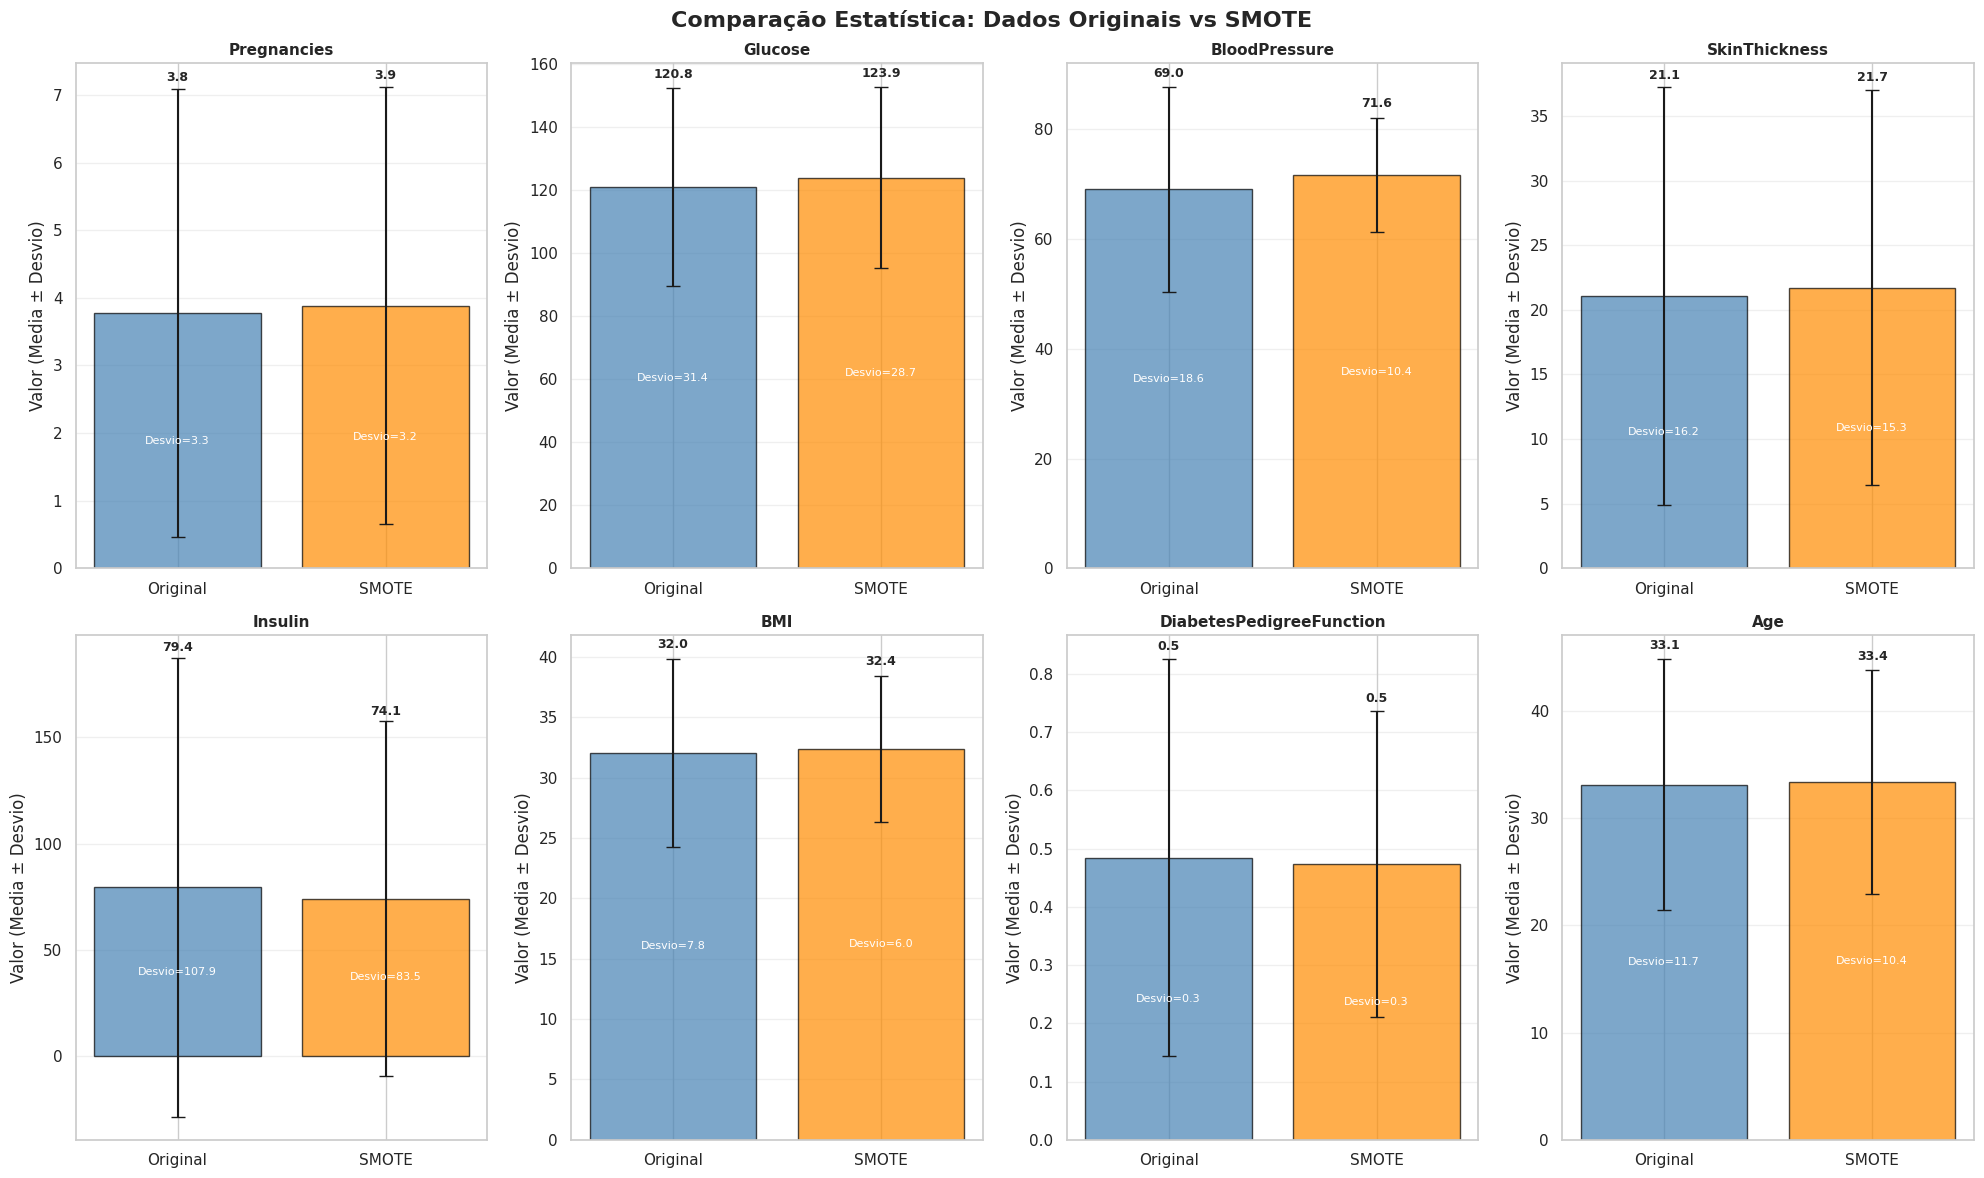


📊 Gerando heatmap de diferenças percentuais...


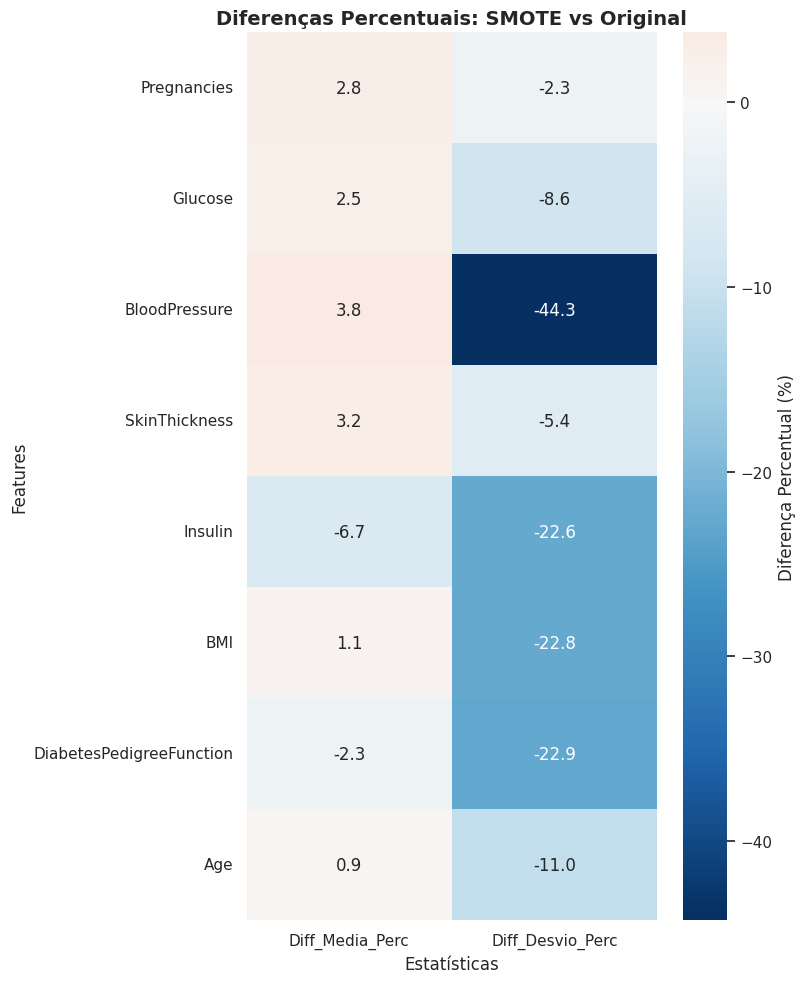


💡 ANÁLISE RESUMO - IMPACTO DO SMOTE:

📊 IMPACTO MÉDIO NAS ESTATÍSTICAS:
• Diferença média percentual nas médias: 2.90%
• Diferença média percentual nos desvios: 17.49%

🎯 FEATURES COM MAIORES MUDANÇAS:
• Maior mudança na média: Insulin (-6.7%)
• Maior mudança no desvio: BloodPressure (-44.3%)

✅ QUALIDADE DA PRESERVAÇÃO:
• Features bem preservadas (<5% média, <10% desvio): 3/8
• Taxa de preservação: 37.5%
⚠️ SMOTE alterou significativamente as características dos dados

💾 ARQUIVOS SALVOS:
• comparacao_estatisticas_original_vs_smote.csv - Comparação geral
• estatisticas_detalhadas_original_vs_smote.csv - Estatísticas por classe

✅ Análise estatística Original vs SMOTE concluída!
📊 8 features analisadas com estatísticas completas
🎯 Preservação média das características: 37.5%


In [12]:
# ===== COMPARAÇÃO ESTATÍSTICA: DADOS ORIGINAIS vs SMOTE =====

print("\n" + "="*80)
print("📊 COMPARAÇÃO ESTATÍSTICA: DADOS ORIGINAIS vs SMOTE")
print("="*80)

# Preparar dados para comparação
print(f"\n🔄 Preparando dados para análise estatística...")

# ===== DADOS ORIGINAIS =====
# Dados de treino originais (antes da limpeza e SMOTE)
X_train_original = pd.DataFrame(X_train, columns=feature_columns)
y_train_original = y_train

# Separar por classe nos dados originais
X_train_original_classe0 = X_train_original[y_train_original == 0]
X_train_original_classe1 = X_train_original[y_train_original == 1]

print(f"📈 Dados originais de treino:")
print(f"  Total: {len(X_train_original)} amostras")
print(f"  Classe 0 (Não-diabetes): {len(X_train_original_classe0)} amostras")
print(f"  Classe 1 (Diabetes): {len(X_train_original_classe1)} amostras")

# ===== DADOS APÓS SMOTE =====
# Dados balanceados com SMOTE
X_train_smote = pd.DataFrame(X_train_balanced, columns=feature_columns)
y_train_smote = y_train_balanced

# Separar por classe nos dados com SMOTE
X_train_smote_classe0 = X_train_smote[y_train_smote == 0]
X_train_smote_classe1 = X_train_smote[y_train_smote == 1]

print(f"\n📈 Dados após SMOTE:")
print(f"  Total: {len(X_train_smote)} amostras")
print(f"  Classe 0 (Não-diabetes): {len(X_train_smote_classe0)} amostras")
print(f"  Classe 1 (Diabetes): {len(X_train_smote_classe1)} amostras")

# ===== CALCULAR ESTATÍSTICAS PARA TODAS AS FEATURES =====
print(f"\n📊 Calculando estatísticas descritivas para todas as features...")

# Criar dicionário para armazenar resultados
stats_comparison = {}

for feature in feature_columns:
    stats_comparison[feature] = {
        # DADOS ORIGINAIS
        'Original_Geral_Media': X_train_original[feature].mean(),
        'Original_Geral_Desvio': X_train_original[feature].std(),
        'Original_Classe0_Media': X_train_original_classe0[feature].mean(),
        'Original_Classe0_Desvio': X_train_original_classe0[feature].std(),
        'Original_Classe1_Media': X_train_original_classe1[feature].mean(),
        'Original_Classe1_Desvio': X_train_original_classe1[feature].std(),
        
        # DADOS COM SMOTE
        'SMOTE_Geral_Media': X_train_smote[feature].mean(),
        'SMOTE_Geral_Desvio': X_train_smote[feature].std(),
        'SMOTE_Classe0_Media': X_train_smote_classe0[feature].mean(),
        'SMOTE_Classe0_Desvio': X_train_smote_classe0[feature].std(),
        'SMOTE_Classe1_Media': X_train_smote_classe1[feature].mean(),
        'SMOTE_Classe1_Desvio': X_train_smote_classe1[feature].std(),
    }

# Converter para DataFrame
stats_df = pd.DataFrame(stats_comparison).T

# ===== TABELA 1: ESTATÍSTICAS GERAIS (TODAS AS CLASSES JUNTAS) =====
print(f"\n📋 TABELA 1 - ESTATÍSTICAS GERAIS (TODAS AS CLASSES):")
print("="*130)

# Criar tabela mais limpa para estatísticas gerais
tabela_geral = pd.DataFrame({
    'Feature': feature_columns,
    'Original_Media': [stats_comparison[f]['Original_Geral_Media'] for f in feature_columns],
    'Original_Desvio': [stats_comparison[f]['Original_Geral_Desvio'] for f in feature_columns],
    'SMOTE_Media': [stats_comparison[f]['SMOTE_Geral_Media'] for f in feature_columns],
    'SMOTE_Desvio': [stats_comparison[f]['SMOTE_Geral_Desvio'] for f in feature_columns]
})

# Calcular diferenças
tabela_geral['Diff_Media'] = tabela_geral['SMOTE_Media'] - tabela_geral['Original_Media']
tabela_geral['Diff_Desvio'] = tabela_geral['SMOTE_Desvio'] - tabela_geral['Original_Desvio']
tabela_geral['Diff_Media_Perc'] = (tabela_geral['Diff_Media'] / tabela_geral['Original_Media']) * 100
tabela_geral['Diff_Desvio_Perc'] = (tabela_geral['Diff_Desvio'] / tabela_geral['Original_Desvio']) * 100

# Exibir tabela formatada
print(f"{'Feature':<25} {'Orig_Media':<10} {'Orig_Desvio':<12} {'SMOTE_Media':<12} {'SMOTE_Desvio':<13} {'Diff_Media':<12} {'Diff_Desvio':<13} {'Diff_Media%':<12} {'Diff_Desvio%':<13}")
print("-" * 130)

for _, row in tabela_geral.iterrows():
    feature_name = row['Feature'][:22] + '...' if len(row['Feature']) > 22 else row['Feature']
    print(f"{feature_name:<25} {row['Original_Media']:<10.2f} {row['Original_Desvio']:<12.2f} "
          f"{row['SMOTE_Media']:<12.2f} {row['SMOTE_Desvio']:<13.2f} "
          f"{row['Diff_Media']:<12.2f} {row['Diff_Desvio']:<13.2f} "
          f"{row['Diff_Media_Perc']:<12.1f} {row['Diff_Desvio_Perc']:<13.1f}")

print("-" * 130)

# ===== TABELA 2: ESTATÍSTICAS POR CLASSE =====
print(f"\n📋 TABELA 2 - ESTATÍSTICAS POR CLASSE:")
print("="*130)

print(f"\n🔵 CLASSE 0 (NÃO-DIABETES):")
print(f"{'Feature':<25} {'Orig_Media':<10} {'Orig_Desvio':<12} {'SMOTE_Media':<12} {'SMOTE_Desvio':<13} {'Diff_Media':<12} {'Diff_Desvio':<13} {'Diff_Media%':<12} {'Diff_Desvio%':<13}")
print("-" * 130)

for feature in feature_columns:
    orig_media = stats_comparison[feature]['Original_Classe0_Media']
    orig_desvio = stats_comparison[feature]['Original_Classe0_Desvio']
    smote_media = stats_comparison[feature]['SMOTE_Classe0_Media']
    smote_desvio = stats_comparison[feature]['SMOTE_Classe0_Desvio']
    
    diff_media = smote_media - orig_media
    diff_desvio = smote_desvio - orig_desvio
    diff_media_perc = (diff_media / orig_media) * 100 if orig_media != 0 else 0
    diff_desvio_perc = (diff_desvio / orig_desvio) * 100 if orig_desvio != 0 else 0
    
    feature_name = feature[:22] + '...' if len(feature) > 22 else feature
    print(f"{feature_name:<25} {orig_media:<10.2f} {orig_desvio:<12.2f} "
          f"{smote_media:<12.2f} {smote_desvio:<13.2f} "
          f"{diff_media:<12.2f} {diff_desvio:<13.2f} "
          f"{diff_media_perc:<12.1f} {diff_desvio_perc:<13.1f}")

print(f"\n🔴 CLASSE 1 (DIABETES):")
print(f"{'Feature':<25} {'Orig_Media':<10} {'Orig_Desvio':<12} {'SMOTE_Media':<12} {'SMOTE_Desvio':<13} {'Diff_Media':<12} {'Diff_Desvio':<13} {'Diff_Media%':<12} {'Diff_Desvio%':<13}")
print("-" * 130)

for feature in feature_columns:
    orig_media = stats_comparison[feature]['Original_Classe1_Media']
    orig_desvio = stats_comparison[feature]['Original_Classe1_Desvio']
    smote_media = stats_comparison[feature]['SMOTE_Classe1_Media']
    smote_desvio = stats_comparison[feature]['SMOTE_Classe1_Desvio']
    
    diff_media = smote_media - orig_media
    diff_desvio = smote_desvio - orig_desvio
    diff_media_perc = (diff_media / orig_media) * 100 if orig_media != 0 else 0
    diff_desvio_perc = (diff_desvio / orig_desvio) * 100 if orig_desvio != 0 else 0
    
    feature_name = feature[:22] + '...' if len(feature) > 22 else feature
    print(f"{feature_name:<25} {orig_media:<10.2f} {orig_desvio:<12.2f} "
          f"{smote_media:<12.2f} {smote_desvio:<13.2f} "
          f"{diff_media:<12.2f} {diff_desvio:<13.2f} "
          f"{diff_media_perc:<12.1f} {diff_desvio_perc:<13.1f}")

print("-" * 130)

# ===== VISUALIZAÇÃO COMPARATIVA =====
print(f"\n📊 Gerando visualização comparativa...")

# Criar visualização com subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
fig.suptitle('Comparação Estatística: Dados Originais vs SMOTE', fontsize=16, fontweight='bold')

for i, feature in enumerate(feature_columns):
    row = i // 4
    col = i % 4
    
    # Dados para o gráfico
    categories = ['Original', 'SMOTE']
    medias = [stats_comparison[feature]['Original_Geral_Media'], 
              stats_comparison[feature]['SMOTE_Geral_Media']]
    desvios = [stats_comparison[feature]['Original_Geral_Desvio'],
               stats_comparison[feature]['SMOTE_Geral_Desvio']]
    
    # Gráfico de barras com erro
    x_pos = np.arange(len(categories))
    bars = axes[row, col].bar(x_pos, medias, yerr=desvios, 
                             color=['steelblue', 'darkorange'], 
                             alpha=0.7, capsize=5, 
                             edgecolor='black', linewidth=1)
    
    # Configurar gráfico
    axes[row, col].set_title(f'{feature}', fontsize=11, fontweight='bold')
    axes[row, col].set_xticks(x_pos)
    axes[row, col].set_xticklabels(categories)
    axes[row, col].set_ylabel('Valor (Media ± Desvio)')
    axes[row, col].grid(axis='y', alpha=0.3)
    
    # Adicionar valores nas barras
    for j, (bar, media, desvio) in enumerate(zip(bars, medias, desvios)):
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2, height + desvio + (max(medias) * 0.02), 
                           f'{media:.1f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
        axes[row, col].text(bar.get_x() + bar.get_width()/2, height/2, 
                           f'Desvio={desvio:.1f}', ha='center', va='center', fontsize=8, color='white')

plt.tight_layout()
plt.show()

# ===== HEATMAP DE DIFERENÇAS PERCENTUAIS =====
print(f"\n📊 Gerando heatmap de diferenças percentuais...")

# Preparar dados para heatmap
heatmap_data = pd.DataFrame({
    'Diff_Media_Perc': [tabela_geral.loc[i, 'Diff_Media_Perc'] for i in range(len(feature_columns))],
    'Diff_Desvio_Perc': [tabela_geral.loc[i, 'Diff_Desvio_Perc'] for i in range(len(feature_columns))]
}, index=feature_columns)

plt.figure(figsize=(8, 10))
sns.heatmap(heatmap_data, annot=True, cmap='RdBu_r', center=0, 
           fmt='.1f', cbar_kws={'label': 'Diferença Percentual (%)'})
plt.title('Diferenças Percentuais: SMOTE vs Original', fontsize=14, fontweight='bold')
plt.xlabel('Estatísticas')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# ===== ANÁLISE RESUMO =====
print(f"\n💡 ANÁLISE RESUMO - IMPACTO DO SMOTE:")
print("="*70)

# Calcular médias das diferenças
media_diff_media = np.mean([abs(row['Diff_Media_Perc']) for _, row in tabela_geral.iterrows()])
media_diff_desvio = np.mean([abs(row['Diff_Desvio_Perc']) for _, row in tabela_geral.iterrows()])

print(f"\n📊 IMPACTO MÉDIO NAS ESTATÍSTICAS:")
print(f"• Diferença média percentual nas médias: {media_diff_media:.2f}%")
print(f"• Diferença média percentual nos desvios: {media_diff_desvio:.2f}%")

# Identificar features com maiores mudanças
maior_mudanca_media = tabela_geral.loc[tabela_geral['Diff_Media_Perc'].abs().idxmax()]
maior_mudanca_desvio = tabela_geral.loc[tabela_geral['Diff_Desvio_Perc'].abs().idxmax()]

print(f"\n🎯 FEATURES COM MAIORES MUDANÇAS:")
print(f"• Maior mudança na média: {maior_mudanca_media['Feature']} ({maior_mudanca_media['Diff_Media_Perc']:.1f}%)")
print(f"• Maior mudança no desvio: {maior_mudanca_desvio['Feature']} ({maior_mudanca_desvio['Diff_Desvio_Perc']:.1f}%)")

# Avaliar preservação das características
features_preservadas = sum([1 for _, row in tabela_geral.iterrows() 
                           if abs(row['Diff_Media_Perc']) < 5 and abs(row['Diff_Desvio_Perc']) < 10])

print(f"\n✅ QUALIDADE DA PRESERVAÇÃO:")
print(f"• Features bem preservadas (<5% média, <10% desvio): {features_preservadas}/{len(feature_columns)}")
print(f"• Taxa de preservação: {(features_preservadas/len(feature_columns))*100:.1f}%")

if features_preservadas >= len(feature_columns) * 0.75:
    print("🎯 SMOTE preservou bem as características originais dos dados!")
elif features_preservadas >= len(feature_columns) * 0.5:
    print("⚖️ SMOTE teve impacto moderado nas características dos dados")
else:
    print("⚠️ SMOTE alterou significativamente as características dos dados")

# Salvar resultados
tabela_geral.to_csv('modelos-smote/comparacao_estatisticas_original_vs_smote.csv', index=False)
stats_df.to_csv('modelos-smote/estatisticas_detalhadas_original_vs_smote.csv')

print(f"\n💾 ARQUIVOS SALVOS:")
print(f"• comparacao_estatisticas_original_vs_smote.csv - Comparação geral")
print(f"• estatisticas_detalhadas_original_vs_smote.csv - Estatísticas por classe")

print(f"\n✅ Análise estatística Original vs SMOTE concluída!")
print(f"📊 {len(feature_columns)} features analisadas com estatísticas completas")
print(f"🎯 Preservação média das características: {(features_preservadas/len(feature_columns))*100:.1f}%")

In [13]:
# ===== FASE 3.4: NORMALIZAÇÃO DOS DADOS =====

print("\n" + "="*70)
print("📊 FASE 3.4: NORMALIZAÇÃO COM STANDARDSCALER")
print("="*70)

# Inicializar StandardScaler
scaler = StandardScaler()

print(f"\n🔧 Inicializando StandardScaler...")
print(f"Método: Z-score standardization [(x - μ) / σ]")
print(f"Objetivo: Média = 0, Desvio Padrão = 1 para todas as features")

# Ajustar scaler APENAS nos dados de treino balanceados
print(f"\n🔄 Ajustando scaler nos dados de treino (com SMOTE)...")
X_train_scaled = scaler.fit_transform(X_train_balanced)

print(f"Scaler ajustado com {X_train_balanced.shape[0]} amostras de treino")
print(f"Features: {X_train_balanced.shape[1]}")

# Aplicar transformação nos conjuntos de validação e teste
print(f"\n📊 Aplicando normalização em todos os conjuntos...")
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ NORMALIZAÇÃO CONCLUÍDA:")
print("-"*50)
print(f"{'Conjunto':<12} {'Shape':<15} {'Status':<20}")
print("-"*50)
print(f"Treino       {X_train_scaled.shape!s:<15} Ajustado + Transformado")
print(f"Validação    {X_val_scaled.shape!s:<15} Apenas Transformado")
print(f"Teste        {X_test_scaled.shape!s:<15} Apenas Transformado")
print("-"*50)

# Verificar qualidade da normalização
print(f"\n🔍 VERIFICAÇÃO DA QUALIDADE:")
print(f"\nEstatísticas do conjunto de treino normalizado:")
print(f"Média das features: {X_train_scaled.mean(axis=0).round(6)}")
print(f"Desvio padrão das features: {X_train_scaled.std(axis=0).round(6)}")

# Verificar se há problemas na normalização
media_maxima = abs(X_train_scaled.mean(axis=0)).max()
std_minimo = X_train_scaled.std(axis=0).min()
std_maximo = X_train_scaled.std(axis=0).max()

print(f"\n📈 MÉTRICAS DE QUALIDADE:")
print(f"Média máxima (absoluta): {media_maxima:.6f} (deve ser ≈ 0)")
print(f"Desvio padrão mínimo: {std_minimo:.6f} (deve ser ≈ 1)")
print(f"Desvio padrão máximo: {std_maximo:.6f} (deve ser ≈ 1)")

if media_maxima < 1e-10 and 0.99 <= std_minimo <= 1.01 and 0.99 <= std_maximo <= 1.01:
    print("✅ Normalização perfeita! Todas as features padronizadas corretamente.")
else:
    print("⚠️ Normalização com pequenos desvios (normal devido a arredondamentos).")

# ===== VISUALIZAÇÃO DOS DADOS NORMALIZADOS =====
print(f"\n📊 Gerando visualização dos dados normalizados...")

# Converter para DataFrame para facilitar a visualização
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_columns)

plt.figure(figsize=(16, 8))

# Criar boxplot
data_for_boxplot = [X_train_scaled_df[col].values for col in feature_columns]
bp = plt.boxplot(data_for_boxplot, tick_labels=feature_columns, patch_artist=True)

# Colorir as caixas
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold', 'mediumpurple', 'orange', 'pink', 'lightgray']
for i, patch in enumerate(bp['boxes']):
    patch.set_facecolor(colors[i % len(colors)])
    patch.set_alpha(0.7)

plt.title('Boxplot - Dados de Treino Normalizados', fontweight='bold', fontsize=16)
plt.ylabel('Valores Normalizados', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Média = 0')
plt.legend()

plt.tight_layout()
plt.show()

# Criar diretório para salvar modelos e informações - PASTA DIFERENTE
os.makedirs('modelos-smote', exist_ok=True)
print(f"\n💾 Diretório 'modelos-smote' criado para salvar modelos e scaler.")

# Salvar scaler para uso futuro
joblib.dump(scaler, 'modelos-smote/scaler.pkl')
joblib.dump(feature_columns, 'modelos-smote/feature_columns.pkl')

print(f"\n✅ FASE DE PREPARAÇÃO DOS DADOS CONCLUÍDA COM SUCESSO!")
print(f"\n📈 RESUMO FINAL:")
print(f"- Dados de treino: {X_train_scaled.shape[0]} amostras (balanceadas e normalizadas)")
print(f"- Dados de validação: {X_val_scaled.shape[0]} amostras (normalizados)")
print(f"- Dados de teste: {X_test_scaled.shape[0]} amostras (normalizados)")
print(f"- Balanceamento: 50/50 no treino")
print(f"- Outliers removidos: {total_outliers}")
print(f"- Amostras sintéticas criadas: {len(X_train_balanced) - len(X_train_clean_df)}")
print(f"\n🚀 Dados prontos para a fase de modelagem!")


📊 FASE 3.4: NORMALIZAÇÃO COM STANDARDSCALER

🔧 Inicializando StandardScaler...
Método: Z-score standardization [(x - μ) / σ]
Objetivo: Média = 0, Desvio Padrão = 1 para todas as features

🔄 Ajustando scaler nos dados de treino (com SMOTE)...
Scaler ajustado com 522 amostras de treino
Features: 8

📊 Aplicando normalização em todos os conjuntos...

✅ NORMALIZAÇÃO CONCLUÍDA:
--------------------------------------------------
Conjunto     Shape           Status              
--------------------------------------------------
Treino       (522, 8)        Ajustado + Transformado
Validação    (154, 8)        Apenas Transformado
Teste        (154, 8)        Apenas Transformado
--------------------------------------------------

🔍 VERIFICAÇÃO DA QUALIDADE:

Estatísticas do conjunto de treino normalizado:
Média das features: [ 0. -0.  0.  0.  0. -0.  0.  0.]
Desvio padrão das features: [1. 1. 1. 1. 1. 1. 1. 1.]

📈 MÉTRICAS DE QUALIDADE:
Média máxima (absoluta): 0.000000 (deve ser ≈ 0)
Desvio pa


💾 Diretório 'modelos-smote' criado para salvar modelos e scaler.

✅ FASE DE PREPARAÇÃO DOS DADOS CONCLUÍDA COM SUCESSO!

📈 RESUMO FINAL:
- Dados de treino: 522 amostras (balanceadas e normalizadas)
- Dados de validação: 154 amostras (normalizados)
- Dados de teste: 154 amostras (normalizados)
- Balanceamento: 50/50 no treino
- Outliers removidos: 75
- Amostras sintéticas criadas: 137

🚀 Dados prontos para a fase de modelagem!


In [14]:
# ===== DEFINIÇÃO DE PARÂMETROS DOS MODELOS =====

print("\n" + "="*70)
print("🔧 FASE 4.1: DEFINIÇÃO DE PARÂMETROS DOS MODELOS")
print("="*70)

# Definir parâmetros para cada modelo seguindo as especificações
model_params = {
    'Random Forest': {'criterion': 'gini', 'n_estimators': 100, 'max_depth': 10, 'random_state': 42},
    'Gradient Boosting': {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0, 'random_state': 42},
    'XGBoost': {'booster': 'gbtree', 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100, 'random_state': 42},
    'Decision Tree': {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42},
    'AdaBoost': {'learning_rate': 1, 'n_estimators': 100, 'random_state': 42},
    'SVM': {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'kernel': 'rbf', 'max_iter': -1, 'random_state': 42},
    'Logistic Regression': {'C': 1.0, 'max_iter': 1000, 'tol': 0.0001, 'random_state': 42},
    'kNN': {'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 5},
    'Naive Bayes': {'var_smoothing': 1e-09}
}

print(f"\n📋 PARÂMETROS CONFIGURADOS PARA {len(model_params)} MODELOS:")
print("-"*70)
print(f"{'No':<3} {'Algoritmo':<20} {'Parâmetros Principais':<45}")
print("-"*70)

# Gerar resumo dos parâmetros dinamicamente a partir de model_params
parametros_resumo = []
for i, (algoritmo, params) in enumerate(model_params.items(), 1):
    # Selecionar os principais parâmetros para exibição
    principais = []
    for k, v in params.items():
        if k in ['n_estimators', 'max_depth', 'learning_rate', 'criterion', 'C', 'kernel', 'max_iter', 'tol', 'min_samples_split', 'min_samples_leaf', 'var_smoothing']:
            principais.append(f"{k}={v}")
    resumo = ', '.join(principais)
    parametros_resumo.append((i, algoritmo, resumo))

for no, algoritmo, params in parametros_resumo:
    print(f"{no:<3} {algoritmo:<20} {params:<45}")

print("-"*70)

print(f"\n🎯 ESTRATÉGIA DE PARAMETRIZAÇÃO:")
print("• Parâmetros balanceados para comparação justa")
print("• random_state=42 para reprodutibilidade")
print("• Evita overfitting e underfitting extremos")
print("• Configuração padrão otimizada para o dataset")

print(f"\n✅ Parâmetros definidos com sucesso!")
print("🚀 Prontos para iniciar o treinamento dos modelos!")


🔧 FASE 4.1: DEFINIÇÃO DE PARÂMETROS DOS MODELOS

📋 PARÂMETROS CONFIGURADOS PARA 9 MODELOS:
----------------------------------------------------------------------
No  Algoritmo            Parâmetros Principais                        
----------------------------------------------------------------------
1   Random Forest        criterion=gini, n_estimators=100, max_depth=10
2   Gradient Boosting    criterion=friedman_mse, learning_rate=0.1, max_depth=3, n_estimators=100
3   XGBoost              learning_rate=0.3, max_depth=6, n_estimators=100
4   Decision Tree        criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2
5   AdaBoost             learning_rate=1, n_estimators=100            
6   SVM                  C=1.0, kernel=rbf, max_iter=-1               
7   Logistic Regression  C=1.0, max_iter=1000, tol=0.0001             
8   kNN                                                               
9   Naive Bayes          var_smoothing=1e-09                          
-

In [15]:
# ===== DEFINIÇÃO E TREINAMENTO DOS MODELOS =====
import time
print("\n" + "="*70)
print("🤖 FASE 4.2: TREINAMENTO DE ALGORITMOS DE MACHINE LEARNING")
print("="*70)

# Importar bibliotecas de validação cruzada
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
import warnings

# Inicializar dicionários para armazenar resultados
trained_models = {}
model_scores = {}
training_times = {}

# Definir modelos
models = {
    'Random Forest': RandomForestClassifier(**model_params['Random Forest']),
    'Gradient Boosting': GradientBoostingClassifier(**model_params['Gradient Boosting']),
    'XGBoost': XGBClassifier(**model_params['XGBoost']),
    'Decision Tree': DecisionTreeClassifier(**model_params['Decision Tree']),
    'AdaBoost': AdaBoostClassifier(**model_params['AdaBoost']),
    'SVM': SVC(**model_params['SVM'], probability=True),
    'Logistic Regression': LogisticRegression(**model_params['Logistic Regression']),
    'kNN': KNeighborsClassifier(**model_params['kNN']),
    'Naive Bayes': GaussianNB(**model_params['Naive Bayes'])
}

print(f"\n🔄 Iniciando treinamento de {len(models)} modelos...")
print("-"*70)

# Treinar e avaliar cada modelo
for i, (name, model) in enumerate(models.items(), 1):
    start_time = time.time()
    
    # Treinar modelo com supressão de warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train_scaled, y_train_balanced)
    
    training_time = time.time() - start_time
    training_times[name] = training_time
    
    # Predições com supressão de warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        y_val_pred = model.predict(X_val_scaled)
        y_val_proba = model.predict_proba(X_val_scaled)[:, 1]
        y_test_pred = model.predict(X_test_scaled)
        y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    val_auc_score = roc_auc_score(y_val, y_val_proba)
    test_auc_score = roc_auc_score(y_test, y_test_proba)
    
    # Armazenar modelo e resultados
    trained_models[name] = model
    model_scores[name] = {
        'model': model,
        'y_val_pred': y_val_pred,
        'y_val_proba': y_val_proba,
        'val_auc_score': val_auc_score,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba,
        'test_auc_score': test_auc_score,
        'training_time': training_time
    }
    
    # MUDANÇA PRINCIPAL: Salvar na pasta modelos-smote/
    joblib.dump(model, f'modelos-smote/{name.replace(" ", "_").lower()}_model.pkl')
    
    print(f"{i}/9 - {name}: ✅ {training_time:.4f}s | Val: {val_auc_score:.4f} | Test: {test_auc_score:.4f}")

print(f"\n" + "="*70)
print("✅ TODOS OS MODELOS TREINADOS COM SUCESSO!")
print("="*70)

# Criar DataFrame com resultados
results_data = []
for name, scores in model_scores.items():
    f1 = f1_score(y_test, scores['y_test_pred'])
    precision = precision_score(y_test, scores['y_test_pred'])
    recall = recall_score(y_test, scores['y_test_pred'])
    accuracy = accuracy_score(y_test, scores['y_test_pred'])
    
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cv_scores = cross_val_score(trained_models[name], X_train_scaled, y_train_balanced, 
                                      cv=5, scoring='roc_auc')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
    except:
        cv_mean = 0
        cv_std = 0
    
    results_data.append({
        'Modelo': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': scores['test_auc_score'],
        'CV-5': cv_mean,
        'CV-Std': cv_std,
        'Tempo(s)': scores['training_time']
    })

results_df = pd.DataFrame(results_data).sort_values('CV-5', ascending=False)

print(f"\n📊 TABELA RESUMO DE PERFORMANCE:")
print("="*100)
print(f"{'Modelo':<18} {'Accuracy':<9} {'Precision':<10} {'Recall':<9} {'F1-Score':<9} {'AUC':<9} {'CV-5':<9} {'CV-Std':<8} {'Tempo':<8}")
print("="*100)

for _, row in results_df.iterrows():
    print(f"{row['Modelo']:<18} {row['Accuracy']:<9.5f} {row['Precision']:<10.5f} {row['Recall']:<9.5f} "
          f"{row['F1-Score']:<9.5f} {row['AUC']:<9.5f} {row['CV-5']:<9.5f} {row['CV-Std']:<8.5f} {row['Tempo(s)']:<8.4f}")

print("="*100)

# Análise rápida
melhor_auc = results_df.iloc[0]
melhor_f1 = results_df.loc[results_df['F1-Score'].idxmax()]
melhor_recall = results_df.loc[results_df['Recall'].idxmax()]

print(f"\n🏆 DESTAQUES:")
print(f"Melhor CV-5 AUC:  {melhor_auc['Modelo']} ({melhor_auc['CV-5']:.4f})")
print(f"Melhor F1-Score:  {melhor_f1['Modelo']} ({melhor_f1['F1-Score']:.4f})")
print(f"Melhor Recall:    {melhor_recall['Modelo']} ({melhor_recall['Recall']:.4f})")

# ===== CLASSIFICATION REPORTS DETALHADOS =====
print("\n" + "="*80)
print("📋 CLASSIFICATION REPORTS DETALHADOS POR MODELO")
print("="*80)

for i, (model_name, scores) in enumerate(model_scores.items(), 1):
    print(f"\n{i}. {model_name.upper()}")
    print("-" * 60)
    
    # Usar classification_report diretamente (mais limpo)
    report = classification_report(y_test, scores['y_test_pred'], 
                                 target_names=['Não-Diabetes', 'Diabetes'],
                                 digits=4)
    print(report)
    
    # Métricas adicionais
    auc_score = scores['test_auc_score']
    print(f"AUC-ROC Score: {auc_score:.4f}")
    
    if model_name in trained_models:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cv_scores = cross_val_score(trained_models[model_name], X_train_scaled, 
                                          y_train_balanced, cv=5, scoring='roc_auc')
            print(f"CV-5 AUC (μ±σ): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        except:
            print(f"CV-5 AUC: Não disponível")

print(f"\n" + "="*80)
print("✅ CLASSIFICATION REPORTS CONCLUÍDOS!")
print("="*80)


🤖 FASE 4.2: TREINAMENTO DE ALGORITMOS DE MACHINE LEARNING

🔄 Iniciando treinamento de 9 modelos...
----------------------------------------------------------------------
1/9 - Random Forest: ✅ 0.1170s | Val: 0.8513 | Test: 0.8169
2/9 - Gradient Boosting: ✅ 0.1257s | Val: 0.8383 | Test: 0.8209
3/9 - XGBoost: ✅ 6.0369s | Val: 0.8270 | Test: 0.7902
4/9 - Decision Tree: ✅ 0.0025s | Val: 0.6852 | Test: 0.7123
5/9 - AdaBoost: ✅ 0.1264s | Val: 0.8405 | Test: 0.8420
6/9 - SVM: ✅ 0.0240s | Val: 0.8217 | Test: 0.7631
7/9 - Logistic Regression: ✅ 0.0107s | Val: 0.8426 | Test: 0.8152
8/9 - kNN: ✅ 0.0007s | Val: 0.7953 | Test: 0.7169
9/9 - Naive Bayes: ✅ 0.0008s | Val: 0.8267 | Test: 0.6924

✅ TODOS OS MODELOS TREINADOS COM SUCESSO!

📊 TABELA RESUMO DE PERFORMANCE:
Modelo             Accuracy  Precision  Recall    F1-Score  AUC       CV-5      CV-Std   Tempo   
Random Forest      0.75325   0.64286    0.66667   0.65455   0.81685   0.90944   0.02181  0.1170  
XGBoost            0.72727   0.60714    


ANÁLISE DAS MATRIZES DE CONFUSÃO - TODOS OS MODELOS

DETALHES DAS MATRIZES DE CONFUSÃO:
--------------------------------------------------------------------------------
Modelo             VN   FP   FN   VP   Sens.  Espec.  AUC    
--------------------------------------------------------------------------------
Random Forest      80   20   18   36   0.667  0.800   0.817  
Gradient Boosting  79   21   14   40   0.741  0.790   0.821  
XGBoost            78   22   20   34   0.630  0.780   0.790  
Decision Tree      76   24   17   37   0.685  0.760   0.712  
AdaBoost           76   24   14   40   0.741  0.760   0.842  
SVM                81   19   22   32   0.593  0.810   0.763  
Logistic Regression 73   27   17   37   0.685  0.730   0.815  
kNN                71   29   21   33   0.611  0.710   0.717  
Naive Bayes        66   34   18   36   0.667  0.660   0.692  
--------------------------------------------------------------------------------

LEGENDA:
VN = Verdadeiros Negativos (não-diabe

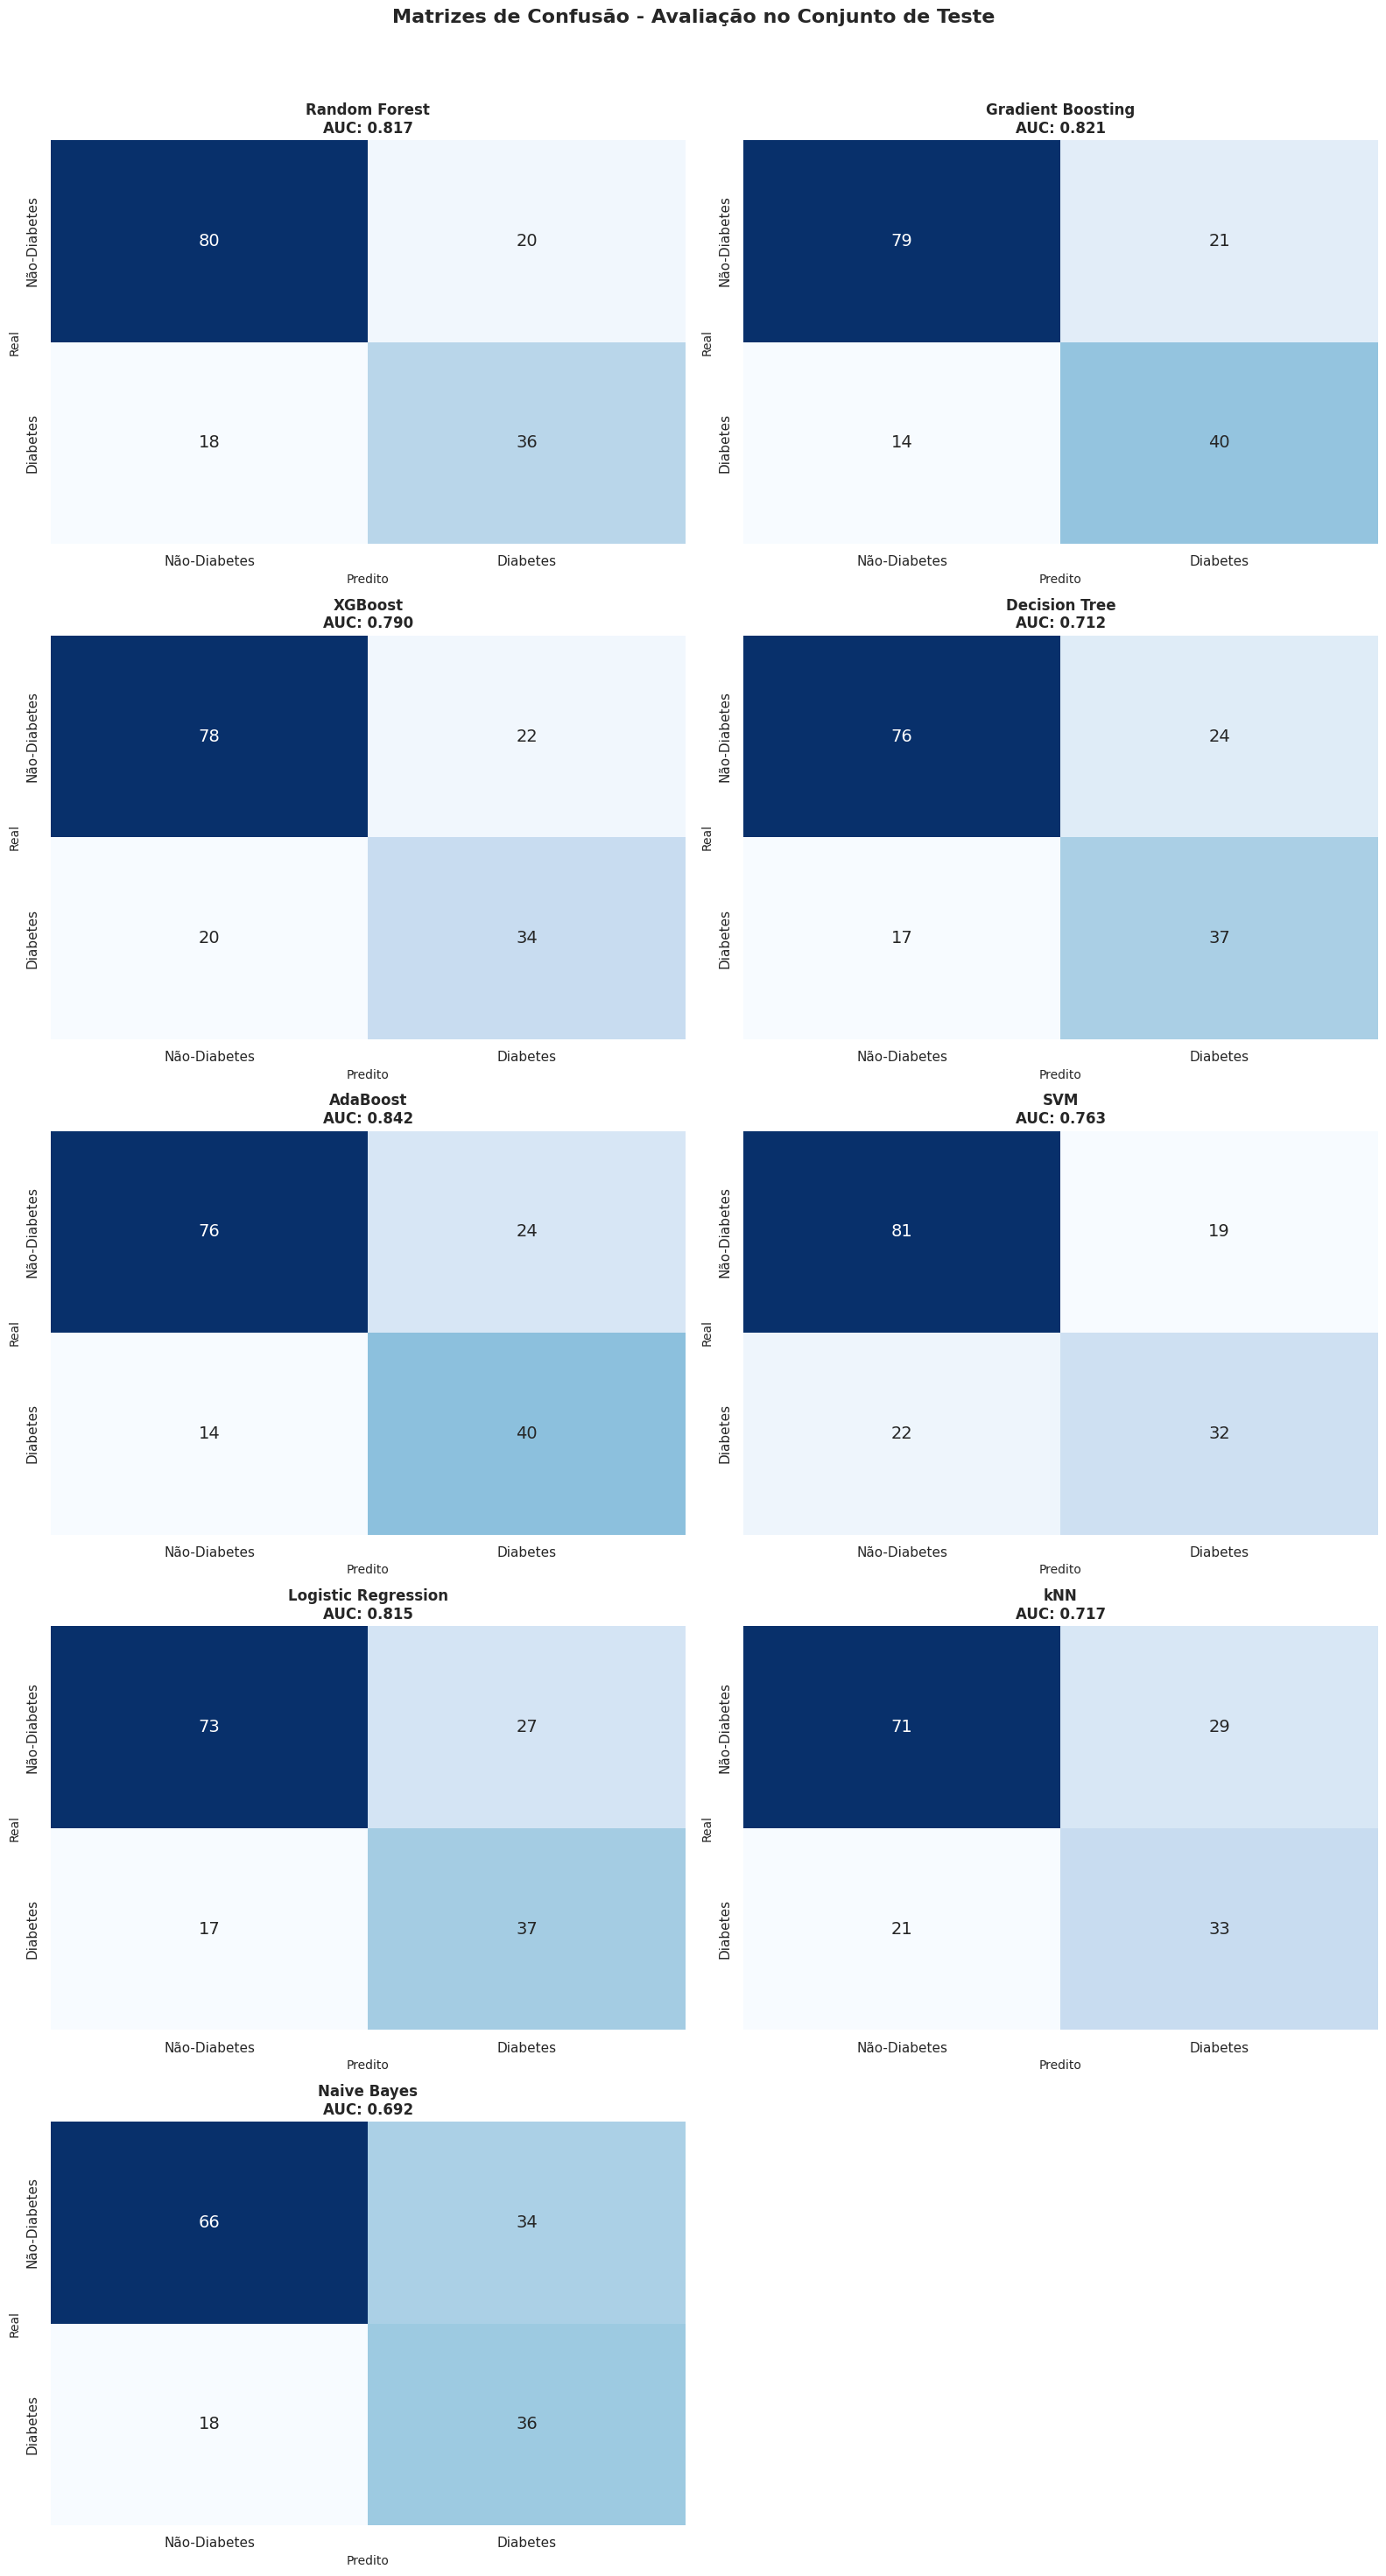


Matrizes de confusão geradas com sucesso!


In [13]:
# ===== VISUALIZAÇÃO DAS MATRIZES DE CONFUSÃO =====

print("\n" + "="*70)
print("ANÁLISE DAS MATRIZES DE CONFUSÃO - TODOS OS MODELOS")
print("="*70)

# Configurar figura para matrizes de confusão - 2 colunas por linha
n_models = len(model_scores)
n_cols = 2
n_rows = (n_models + n_cols - 1) // n_cols  # Calcula número de linhas necessárias

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6*n_rows))
fig.suptitle('Matrizes de Confusão - Avaliação no Conjunto de Teste', fontsize=16, fontweight='bold')

# Garantir que axes seja sempre 2D
if n_rows == 1:
    axes = axes.reshape(1, -1)

# Labels para as classes
class_names = ['Não-Diabetes', 'Diabetes']

print(f"\nDETALHES DAS MATRIZES DE CONFUSÃO:")
print("-"*80)
print(f"{'Modelo':<18} {'VN':<4} {'FP':<4} {'FN':<4} {'VP':<4} {'Sens.':<6} {'Espec.':<7} {'AUC':<7}")
print("-"*80)

for idx, (name, scores) in enumerate(model_scores.items()):
    row = idx // n_cols
    col = idx % n_cols

    # Obter matriz de confusão
    cm = confusion_matrix(y_test, scores['y_test_pred'])
    tn, fp, fn, tp = cm.ravel()

    # Calcular métricas
    sensibilidade = tp / (tp + fn) if (tp + fn) > 0 else 0
    especificidade = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Plotar matriz de confusão
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[row, col],
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, annot_kws={'size': 14})

    # Configurar título e labels
    axes[row, col].set_title(f'{name}\nAUC: {scores["test_auc_score"]:.3f}', fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('Predito', fontsize=10)
    axes[row, col].set_ylabel('Real', fontsize=10)

    # Exibir detalhes numericos
    print(f"{name:<18} {tn:<4} {fp:<4} {fn:<4} {tp:<4} {sensibilidade:<6.3f} {especificidade:<7.3f} {scores['test_auc_score']:<7.3f}")

# Esconder eixos vazios se houver número ímpar de modelos
if n_models % n_cols != 0:
    for idx in range(n_models, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].set_visible(False)

print("-"*80)
print(f"\nLEGENDA:")
print(f"VN = Verdadeiros Negativos (não-diabetes corretamente identificados)")
print(f"FP = Falsos Positivos (não-diabetes incorretamente como diabetes)")
print(f"FN = Falsos Negativos (diabetes incorretamente como não-diabetes)")
print(f"VP = Verdadeiros Positivos (diabetes corretamente identificados)")
print(f"Sens. = Sensibilidade (VP / (VP + FN)) - % diabetes detectados")
print(f"Espec. = Especificidade (VN / (VN + FP)) - % não-diabetes identificados")

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

print(f"\nMatrizes de confusão geradas com sucesso!")



ANÁLISE DAS CURVAS ROC - ORGANIZADAS POR PERFORMANCE

Ranking de Performance (AUC no Teste):
--------------------------------------------------
 1. AdaBoost           AUC = 0.8420
 2. Gradient Boosting  AUC = 0.8209
 3. Random Forest      AUC = 0.8169
 4. Logistic Regression AUC = 0.8152
 5. XGBoost            AUC = 0.7902
 6. SVM                AUC = 0.7631
 7. kNN                AUC = 0.7169
 8. Decision Tree      AUC = 0.7123
 9. Naive Bayes        AUC = 0.6924


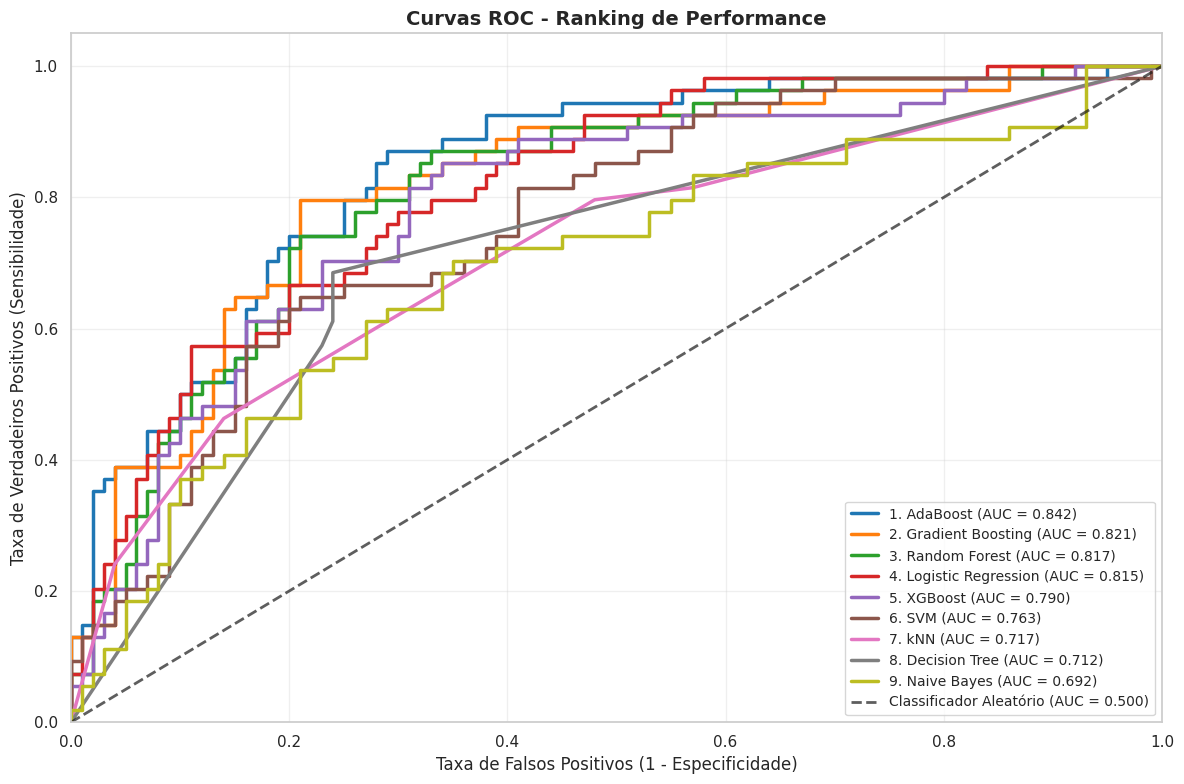

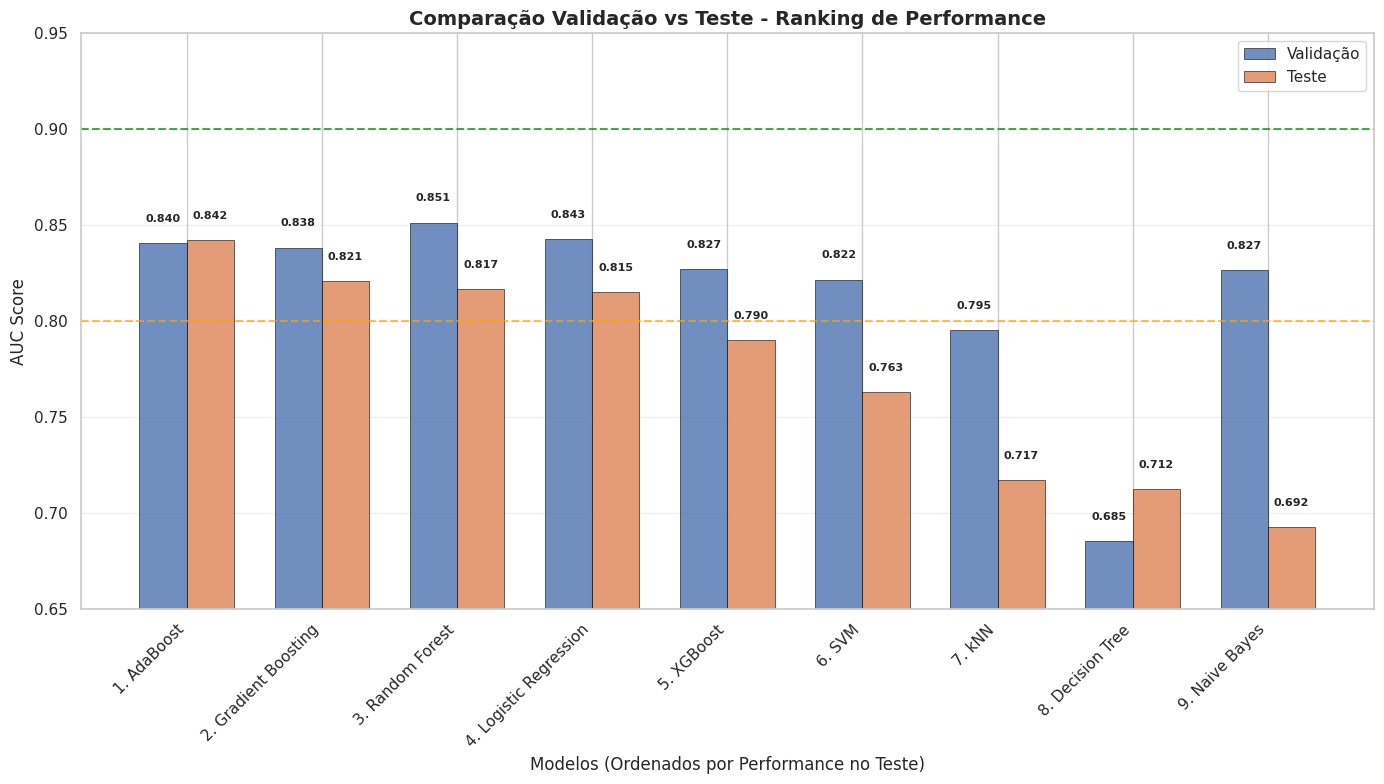


TABELA COMPARATIVA ORDENADA POR PERFORMANCE:
Rank Modelo             AUC Val  AUC Test  Diferença 
1    AdaBoost           0.8405   0.8420    -0.0016   
2    Gradient Boosting  0.8383   0.8209    0.0174    
3    Random Forest      0.8513   0.8169    0.0344    
4    Logistic Regression 0.8426   0.8152    0.0274    
5    XGBoost            0.8270   0.7902    0.0369    
6    SVM                0.8217   0.7631    0.0585    
7    kNN                0.7953   0.7169    0.0783    
8    Decision Tree      0.6852   0.7123    -0.0271   
9    Naive Bayes        0.8267   0.6924    0.1343    

🏆 TOP 3 MODELOS:
1º lugar: AdaBoost (AUC = 0.8420)
2º lugar: Gradient Boosting (AUC = 0.8209)
3º lugar: Random Forest (AUC = 0.8169)

✅ Curvas ROC organizadas por performance!


In [28]:
# ===== ANÁLISE DAS CURVAS ROC ORGANIZADAS POR PERFORMANCE =====

print("\n" + "="*70)
print("ANÁLISE DAS CURVAS ROC - ORGANIZADAS POR PERFORMANCE")
print("="*70)

# Plotar curvas ROC para dados de teste organizadas por AUC
plt.figure(figsize=(12, 8))

# Ordenar modelos por AUC de teste (do melhor para o pior)
model_scores_sorted = sorted(model_scores.items(), key=lambda x: x[1]['test_auc_score'], reverse=True)

# Cores originais para os modelos
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

print(f"\nRanking de Performance (AUC no Teste):")
print("-" * 50)

for idx, (name, scores) in enumerate(model_scores_sorted):
    fpr, tpr, _ = roc_curve(y_test, scores['y_test_proba'])
    plt.plot(fpr, tpr, color=colors[idx % len(colors)], lw=2.5, 
             label=f'{idx+1}. {name} (AUC = {scores["test_auc_score"]:.3f})')
    
    print(f"{idx+1:2d}. {name:<18} AUC = {scores['test_auc_score']:.4f}")

# Linha do classificador aleatório
plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.7, label='Classificador Aleatório (AUC = 0.500)')

# Configurações do gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)', fontsize=12)
plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)', fontsize=12)
plt.title('Curvas ROC - Ranking de Performance', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparar AUC de validação vs teste (organizados por performance)
val_scores_sorted = [scores['val_auc_score'] for name, scores in model_scores_sorted]
test_scores_sorted = [scores['test_auc_score'] for name, scores in model_scores_sorted]
model_names_sorted = [name for name, scores in model_scores_sorted]

# Criar dataframe ordenado
scores_df_sorted = pd.DataFrame({
    'Ranking': range(1, len(model_names_sorted) + 1),
    'Modelo': model_names_sorted,
    'AUC Validação': val_scores_sorted,
    'AUC Teste': test_scores_sorted,
    'Diferença': [val - test for val, test in zip(val_scores_sorted, test_scores_sorted)]
})

# Plotar comparação ordenada
plt.figure(figsize=(14, 8))
bar_width = 0.35
indices = np.arange(len(model_names_sorted))

bars1 = plt.bar(indices, val_scores_sorted, bar_width, label='Validação', 
                alpha=0.8, edgecolor='black', linewidth=0.5)
bars2 = plt.bar(indices + bar_width, test_scores_sorted, bar_width, label='Teste', 
                alpha=0.8, edgecolor='black', linewidth=0.5)

# Adicionar valores nas barras
for i, (val, test) in enumerate(zip(val_scores_sorted, test_scores_sorted)):
    plt.text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    plt.text(i + bar_width, test + 0.01, f'{test:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.xlabel('Modelos (Ordenados por Performance no Teste)', fontsize=12)
plt.ylabel('AUC Score', fontsize=12)
plt.title('Comparação Validação vs Teste - Ranking de Performance', fontsize=14, fontweight='bold')
plt.xticks(indices + bar_width/2, [f'{i+1}. {name}' for i, name in enumerate(model_names_sorted)], 
           rotation=45, ha='right')
plt.ylim([0.65, 0.95])
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Linhas de referência
plt.axhline(y=0.8, color='orange', linestyle='--', alpha=0.7, label='Bom (0.8)')
plt.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='Excelente (0.9)')

plt.tight_layout()
plt.show()

# Exibir tabela ordenada de scores
print(f"\nTABELA COMPARATIVA ORDENADA POR PERFORMANCE:")
print("=" * 80)
print(f"{'Rank':<4} {'Modelo':<18} {'AUC Val':<8} {'AUC Test':<9} {'Diferença':<10}")
print("=" * 80)

for _, row in scores_df_sorted.iterrows():
    print(f"{row['Ranking']:<4} {row['Modelo']:<18} {row['AUC Validação']:<8.4f} {row['AUC Teste']:<9.4f} {row['Diferença']:<10.4f}")

print("=" * 80)

# Destacar top 3
print(f"\n🏆 TOP 3 MODELOS:")
for i in range(3):
    row = scores_df_sorted.iloc[i]
    print(f"{row['Ranking']}º lugar: {row['Modelo']} (AUC = {row['AUC Teste']:.4f})")

print(f"\n✅ Curvas ROC organizadas por performance!")

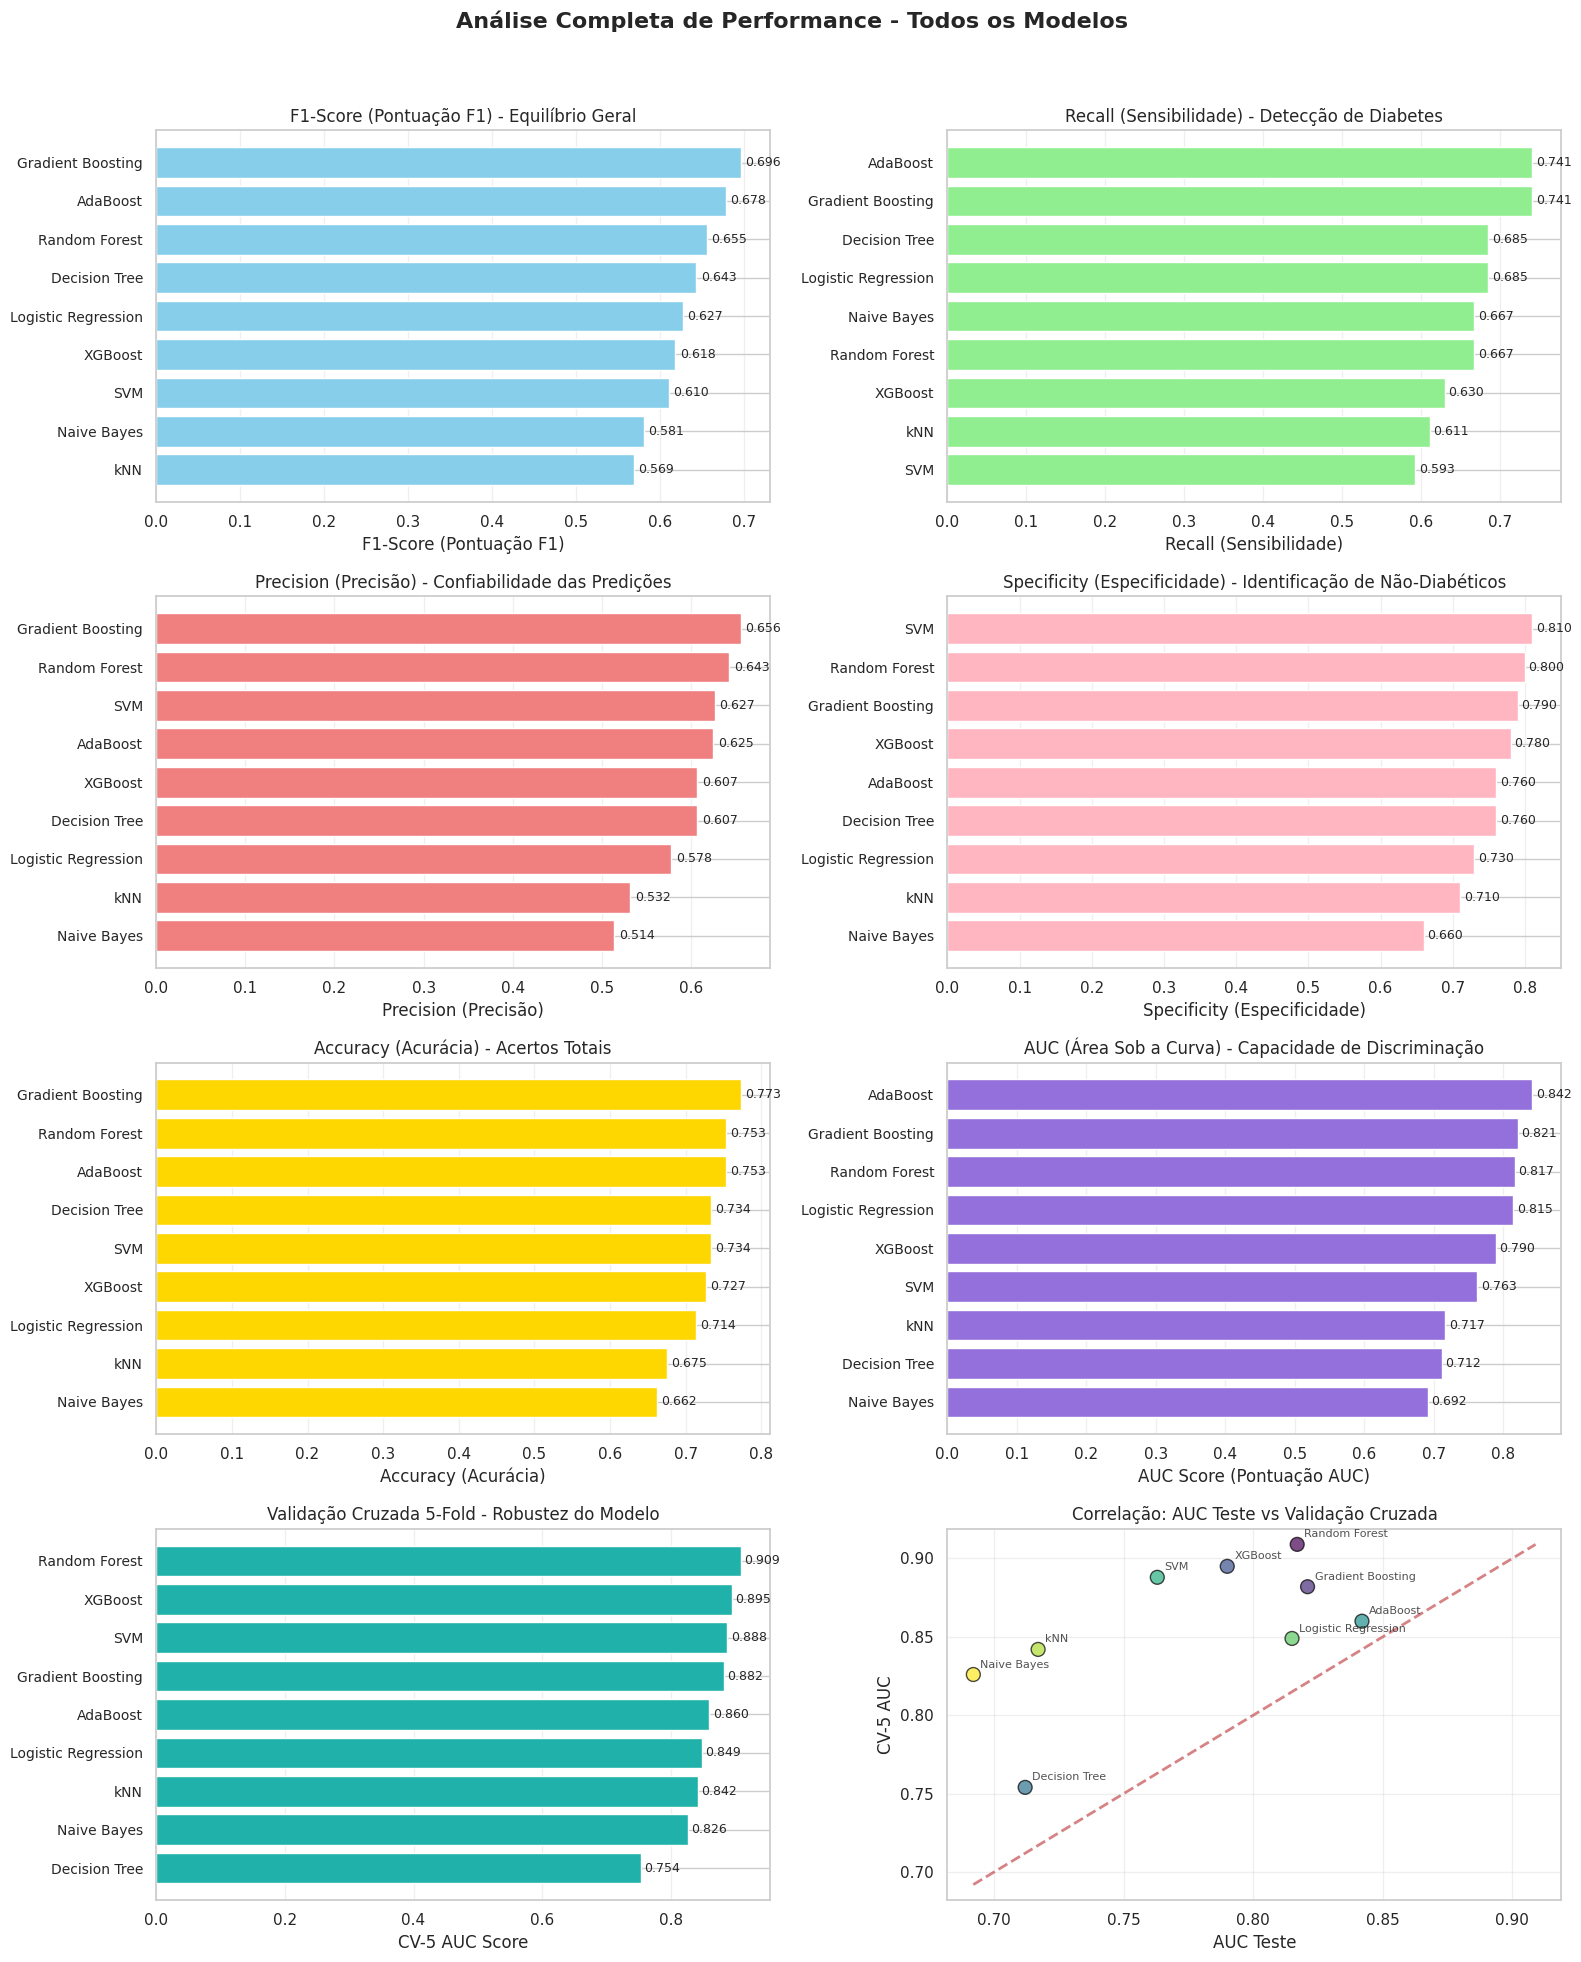

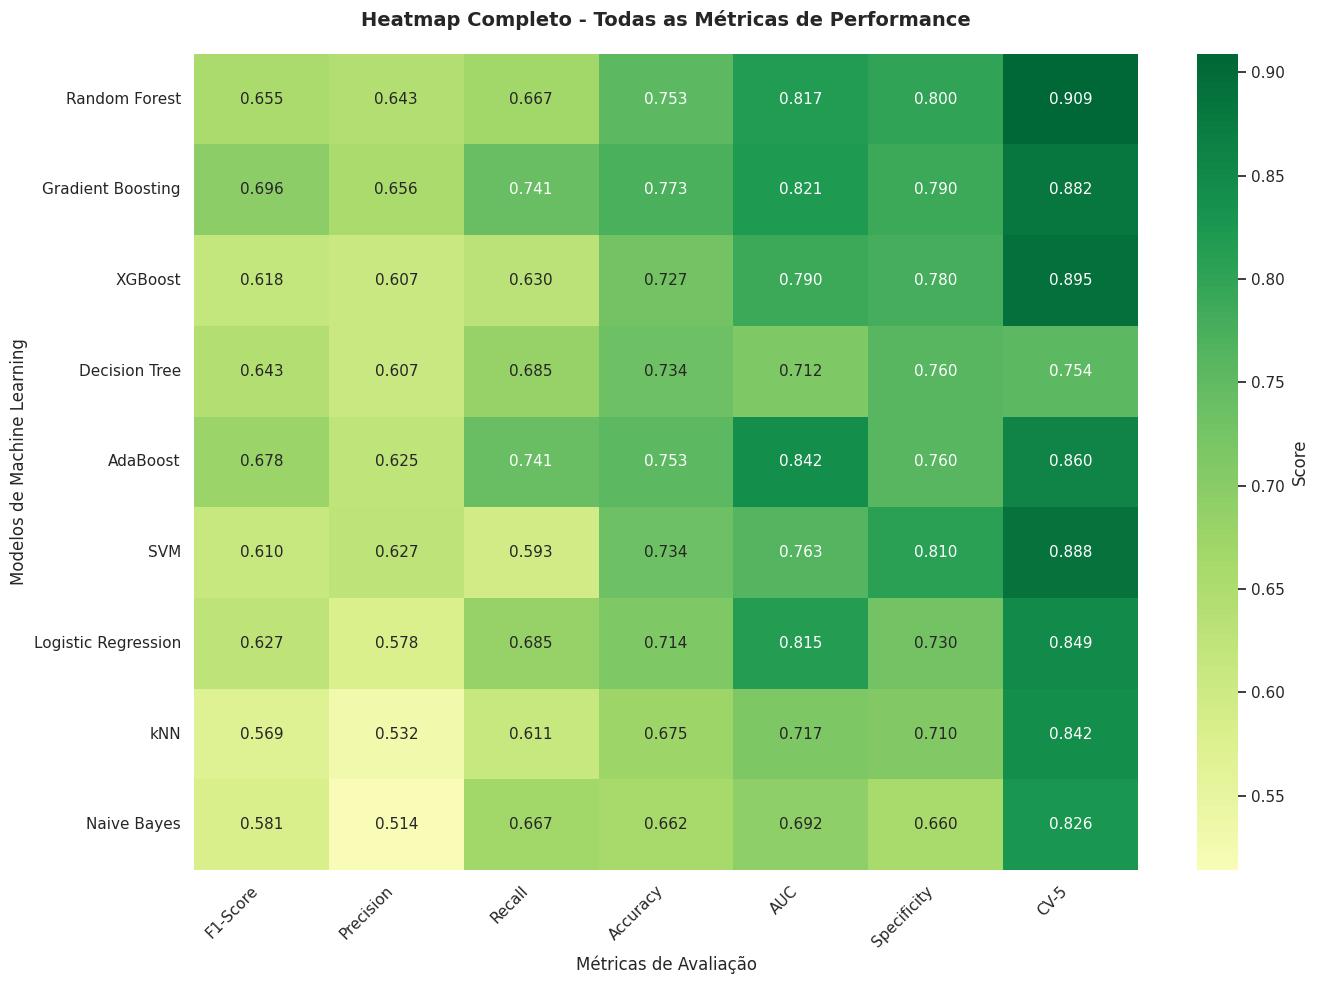


📊 RANKING DETALHADO POR MÉTRICA

🏆 TOP 4 - F1-Score (Pontuação F1):
  1º lugar: Gradient Boosting  (0.696)
  2º lugar: AdaBoost           (0.678)
  3º lugar: Random Forest      (0.655)
  4º lugar: Decision Tree      (0.643)

🏆 TOP 4 - Precision (Precisão):
  1º lugar: Gradient Boosting  (0.656)
  2º lugar: Random Forest      (0.643)
  3º lugar: SVM                (0.627)
  4º lugar: AdaBoost           (0.625)

🏆 TOP 4 - Recall (Sensibilidade):
  1º lugar: Gradient Boosting  (0.741)
  2º lugar: AdaBoost           (0.741)
  3º lugar: Decision Tree      (0.685)
  4º lugar: Logistic Regression (0.685)

🏆 TOP 4 - Specificity (Especificidade):
  1º lugar: SVM                (0.810)
  2º lugar: Random Forest      (0.800)
  3º lugar: Gradient Boosting  (0.790)
  4º lugar: XGBoost            (0.780)

🏆 TOP 4 - Accuracy (Acurácia):
  1º lugar: Gradient Boosting  (0.773)
  2º lugar: Random Forest      (0.753)
  3º lugar: AdaBoost           (0.753)
  4º lugar: Decision Tree      (0.734)

🏆 TOP 4 

In [43]:
# Ranking dos modelos por AUC de validação e teste (necessário para os gráficos)
ranking_val = sorted(model_scores.items(), key=lambda x: x[1]['val_auc_score'], reverse=True)
ranking_test = sorted(model_scores.items(), key=lambda x: x[1]['test_auc_score'], reverse=True)

# MUDANÇA PRINCIPAL: Selecionar melhor modelo com base no AUC de TESTE, não validação
best_model_name = ranking_test[0][0]
best_model = trained_models[best_model_name]

# Calcular métricas detalhadas para todos os modelos (incluindo validação cruzada)
detailed_metrics = {}
for name, scores in model_scores.items():
    y_pred = scores['y_test_pred']
    
    # Calcular matriz de confusão para obter especificidade
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Calcular métricas básicas
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc = scores['test_auc_score']
    
    # Calcular validação cruzada
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cv_scores = cross_val_score(trained_models[name], X_train_scaled, y_train_balanced, 
                                      cv=5, scoring='roc_auc')
        cv_mean = cv_scores.mean()
    except:
        cv_mean = 0.0
    
    detailed_metrics[name] = {
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'AUC': auc,
        'Specificity': specificity,
        'CV-5': cv_mean  # NOVA MÉTRICA ADICIONADA
    }

# Criar DataFrame para os gráficos com 3 casas decimais
metrics_df = pd.DataFrame(detailed_metrics).T
metrics_df = metrics_df.round(3)  # MUDANÇA: 4 → 3 casas decimais

# Plots de métricas - ATUALIZADO para 4x2 (8 gráficos) incluindo CV-5
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
fig.suptitle('Análise Completa de Performance - Todos os Modelos', fontsize=16, fontweight='bold', y=0.98)

# 1. F1-Score
f1_sorted = metrics_df.sort_values('F1-Score', ascending=True)
axes[0,0].barh(range(len(f1_sorted)), f1_sorted['F1-Score'], color='skyblue')
axes[0,0].set_yticks(range(len(f1_sorted)))
axes[0,0].set_yticklabels(f1_sorted.index, fontsize=10)
axes[0,0].set_xlabel('F1-Score (Pontuação F1)')
axes[0,0].set_title('F1-Score (Pontuação F1) - Equilíbrio Geral')
axes[0,0].grid(axis='x', alpha=0.3)
for i, v in enumerate(f1_sorted['F1-Score']):
    axes[0,0].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)

# 2. Recall (Sensibilidade)
recall_sorted = metrics_df.sort_values('Recall', ascending=True)
axes[0,1].barh(range(len(recall_sorted)), recall_sorted['Recall'], color='lightgreen')
axes[0,1].set_yticks(range(len(recall_sorted)))
axes[0,1].set_yticklabels(recall_sorted.index, fontsize=10)
axes[0,1].set_xlabel('Recall (Sensibilidade)')
axes[0,1].set_title('Recall (Sensibilidade) - Detecção de Diabetes')
axes[0,1].grid(axis='x', alpha=0.3)
for i, v in enumerate(recall_sorted['Recall']):
    axes[0,1].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)

# 3. Precision
precision_sorted = metrics_df.sort_values('Precision', ascending=True)
axes[1,0].barh(range(len(precision_sorted)), precision_sorted['Precision'], color='lightcoral')
axes[1,0].set_yticks(range(len(precision_sorted)))
axes[1,0].set_yticklabels(precision_sorted.index, fontsize=10)
axes[1,0].set_xlabel('Precision (Precisão)')
axes[1,0].set_title('Precision (Precisão) - Confiabilidade das Predições')
axes[1,0].grid(axis='x', alpha=0.3)
for i, v in enumerate(precision_sorted['Precision']):
    axes[1,0].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)

# 4. Specificity
specificity_sorted = metrics_df.sort_values('Specificity', ascending=True)
axes[1,1].barh(range(len(specificity_sorted)), specificity_sorted['Specificity'], color='lightpink')
axes[1,1].set_yticks(range(len(specificity_sorted)))
axes[1,1].set_yticklabels(specificity_sorted.index, fontsize=10)
axes[1,1].set_xlabel('Specificity (Especificidade)')
axes[1,1].set_title('Specificity (Especificidade) - Identificação de Não-Diabéticos')
axes[1,1].grid(axis='x', alpha=0.3)
for i, v in enumerate(specificity_sorted['Specificity']):
    axes[1,1].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)

# 5. Accuracy
accuracy_sorted = metrics_df.sort_values('Accuracy', ascending=True)
axes[2,0].barh(range(len(accuracy_sorted)), accuracy_sorted['Accuracy'], color='gold')
axes[2,0].set_yticks(range(len(accuracy_sorted)))
axes[2,0].set_yticklabels(accuracy_sorted.index, fontsize=10)
axes[2,0].set_xlabel('Accuracy (Acurácia)')
axes[2,0].set_title('Accuracy (Acurácia) - Acertos Totais')
axes[2,0].grid(axis='x', alpha=0.3)
for i, v in enumerate(accuracy_sorted['Accuracy']):
    axes[2,0].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)

# 6. AUC
auc_sorted = metrics_df.sort_values('AUC', ascending=True)
axes[2,1].barh(range(len(auc_sorted)), auc_sorted['AUC'], color='mediumpurple')
axes[2,1].set_yticks(range(len(auc_sorted)))
axes[2,1].set_yticklabels(auc_sorted.index, fontsize=10)
axes[2,1].set_xlabel('AUC Score (Pontuação AUC)')
axes[2,1].set_title('AUC (Área Sob a Curva) - Capacidade de Discriminação')
axes[2,1].grid(axis='x', alpha=0.3)
for i, v in enumerate(auc_sorted['AUC']):
    axes[2,1].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)

# 7. CV-5 (NOVO GRÁFICO)
cv_sorted = metrics_df.sort_values('CV-5', ascending=True)
axes[3,0].barh(range(len(cv_sorted)), cv_sorted['CV-5'], color='lightseagreen')
axes[3,0].set_yticks(range(len(cv_sorted)))
axes[3,0].set_yticklabels(cv_sorted.index, fontsize=10)
axes[3,0].set_xlabel('CV-5 AUC Score')
axes[3,0].set_title('Validação Cruzada 5-Fold - Robustez do Modelo')
axes[3,0].grid(axis='x', alpha=0.3)
for i, v in enumerate(cv_sorted['CV-5']):
    axes[3,0].text(v + 0.005, i, f'{v:.3f}', va='center', fontsize=9)

# 8. Comparação AUC vs CV-5 (NOVO GRÁFICO)
axes[3,1].scatter(metrics_df['AUC'], metrics_df['CV-5'], s=100, alpha=0.7, 
                  c=range(len(metrics_df)), cmap='viridis', edgecolors='black')

# Adicionar linha diagonal para referência
min_val = min(metrics_df['AUC'].min(), metrics_df['CV-5'].min())
max_val = max(metrics_df['AUC'].max(), metrics_df['CV-5'].max())
axes[3,1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, linewidth=2)

# Adicionar rótulos dos modelos
for i, (model, row) in enumerate(metrics_df.iterrows()):
    axes[3,1].annotate(model, (row['AUC'], row['CV-5']), 
                       xytext=(5, 5), textcoords='offset points', 
                       fontsize=8, alpha=0.8)

axes[3,1].set_xlabel('AUC Teste')
axes[3,1].set_ylabel('CV-5 AUC')
axes[3,1].set_title('Correlação: AUC Teste vs Validação Cruzada')
axes[3,1].grid(True, alpha=0.3)
axes[3,1].set_xlim(min_val-0.01, max_val+0.01)
axes[3,1].set_ylim(min_val-0.01, max_val+0.01)

# MUDANÇA PRINCIPAL: Ajustar o layout com espaçamento melhor
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Criar um segundo gráfico com o heatmap ampliado para melhor visualização
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='RdYlGn', center=0.5, 
           ax=ax, cbar_kws={'label': 'Score'}, annot_kws={'size': 11})
ax.set_title('Heatmap Completo - Todas as Métricas de Performance', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Métricas de Avaliação', fontsize=12)
ax.set_ylabel('Modelos de Machine Learning', fontsize=12)

# Rotacionar labels para melhor visualização
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Exibir ranking detalhado por métrica (ATUALIZADO com CV-5 e TOP 4)
print("\n" + "="*80)
print("📊 RANKING DETALHADO POR MÉTRICA")
print("="*80)

metrics_names = {
    'F1-Score': 'F1-Score (Pontuação F1)',
    'Precision': 'Precision (Precisão)', 
    'Recall': 'Recall (Sensibilidade)',
    'Specificity': 'Specificity (Especificidade)',
    'Accuracy': 'Accuracy (Acurácia)',
    'AUC': 'AUC (Área Sob a Curva)',
    'CV-5': 'Validação Cruzada 5-Fold'  # NOVA MÉTRICA
}

for metric, description in metrics_names.items():
    print(f"\n🏆 TOP 4 - {description}:")
    top4 = metrics_df.sort_values(metric, ascending=False).head(4)
    for i, (model, row) in enumerate(top4.iterrows(), 1):
        print(f"  {i}º lugar: {model:<18} ({row[metric]:.3f})")

# Criar tabela comparativa final (ATUALIZADA com AUC como critério principal e 3 casas decimais)
print(f"\n📋 TABELA COMPARATIVA FINAL - TODAS AS MÉTRICAS:")
print("="*125)
header = f"{'Modelo':<18} {'F1-Score':<9} {'Precision':<10} {'Recall':<8} {'Specific.':<10} {'Accuracy':<9} {'AUC':<8} {'CV-5':<8}"
print(header)
print("="*125)

# MUDANÇA: Ordenar por AUC (melhor métrica para capacidade de discriminação)
for model, row in metrics_df.sort_values('AUC', ascending=False).iterrows():
    print(f"{model:<18} {row['F1-Score']:<9.3f} {row['Precision']:<10.3f} {row['Recall']:<8.3f} "
          f"{row['Specificity']:<10.3f} {row['Accuracy']:<9.3f} {row['AUC']:<8.3f} {row['CV-5']:<8.3f}")

print("="*125)

# Análise de correlação entre métricas
print(f"\n📊 ANÁLISE DE CORRELAÇÃO ENTRE MÉTRICAS:")
correlations = metrics_df.corr()
print(f"Correlação AUC vs CV-5: {correlations.loc['AUC', 'CV-5']:.3f}")
print(f"Correlação F1-Score vs AUC: {correlations.loc['F1-Score', 'AUC']:.3f}")
print(f"Correlação Recall vs AUC: {correlations.loc['Recall', 'AUC']:.3f}")

# Identificar modelos com maior consistência (menor diferença entre AUC e CV-5)
print(f"\n🎯 ANÁLISE DE CONSISTÊNCIA (AUC vs CV-5):")
metrics_df['Diferenca_AUC_CV'] = abs(metrics_df['AUC'] - metrics_df['CV-5'])
consistency_ranking = metrics_df.sort_values('Diferenca_AUC_CV')

print(f"{'Modelo':<18} {'AUC':<8} {'CV-5':<8} {'Diferença':<10} {'Consistência':<15}")
print("-" * 70)
for model, row in consistency_ranking.iterrows():
    diff = row['Diferenca_AUC_CV']
    if diff < 0.01:
        status = "Excelente"
    elif diff < 0.02:
        status = "Boa"
    elif diff < 0.03:
        status = "Moderada"
    else:
        status = "Baixa"
    
    print(f"{model:<18} {row['AUC']:<8.3f} {row['CV-5']:<8.3f} {diff:<10.3f} {status:<15}")

# Salvar scaler e informações adicionais
joblib.dump(scaler, 'modelos-smote/scaler.pkl')
joblib.dump(feature_columns, 'modelos-smote/feature_columns.pkl')
joblib.dump(model_scores, 'modelos-smote/model_results.pkl')
joblib.dump(metrics_df, 'modelos-smote/detailed_metrics.pkl')

print(f"\n✅ Análise completa de performance concluída!")
print(f"💾 Dados salvos com {len(metrics_df.columns)} métricas para {len(metrics_df)} modelos")
print(f"🎯 Melhor modelo por AUC: {metrics_df.sort_values('AUC', ascending=False).index[0]}")
print(f"🎯 Melhor modelo por CV-5: {metrics_df.sort_values('CV-5', ascending=False).index[0]}")

# Exibir informações dos arquivos salvos
print(f"\n📁 ARQUIVOS SALVOS NO DIRETÓRIO 'modelos-smote/':")
print(f"• scaler.pkl - StandardScaler treinado nos dados")
print(f"• feature_columns.pkl - Lista das features utilizadas")
print(f"• model_results.pkl - Resultados completos de todos os modelos")
print(f"• detailed_metrics.pkl - DataFrame com {len(metrics_df.columns)} métricas calculadas")
print(f"• best_model_final.pkl - Melhor modelo ({best_model_name})")
print(f"• [modelo]_model.pkl - Cada modelo individual treinado")


🔧 ANÁLISE DOS 4 MELHORES MODELOS COM SMOTE - COMPARAÇÃO DE PERFIS
📊 Método utilizado: SMOTE
📈 Modelos disponíveis: 9

📋 PERFIS PARA ANÁLISE (gradação clínica realista):
                     Pregnancies  Glucose  BloodPressure  SkinThickness  \
Diabético_Severo             4.0    200.0          100.0           50.0   
Diabético_Moderado           2.0    160.0           85.0           35.0   
Pré_Diabético_Alto           3.0    124.0           78.0           30.0   
Pré_Diabético_Baixo          2.0    115.0           75.0           25.0   
Risco_Baixo                  1.0     99.0           70.0           22.0   
Saudável                     0.0     85.0           65.0           18.0   

                     Insulin   BMI  DiabetesPedigreeFunction   Age  
Diabético_Severo       200.0  40.0                      1.50  65.0  
Diabético_Moderado     150.0  32.0                      0.80  50.0  
Pré_Diabético_Alto     100.0  31.0                      0.60  45.0  
Pré_Diabético_Baixo     80.0

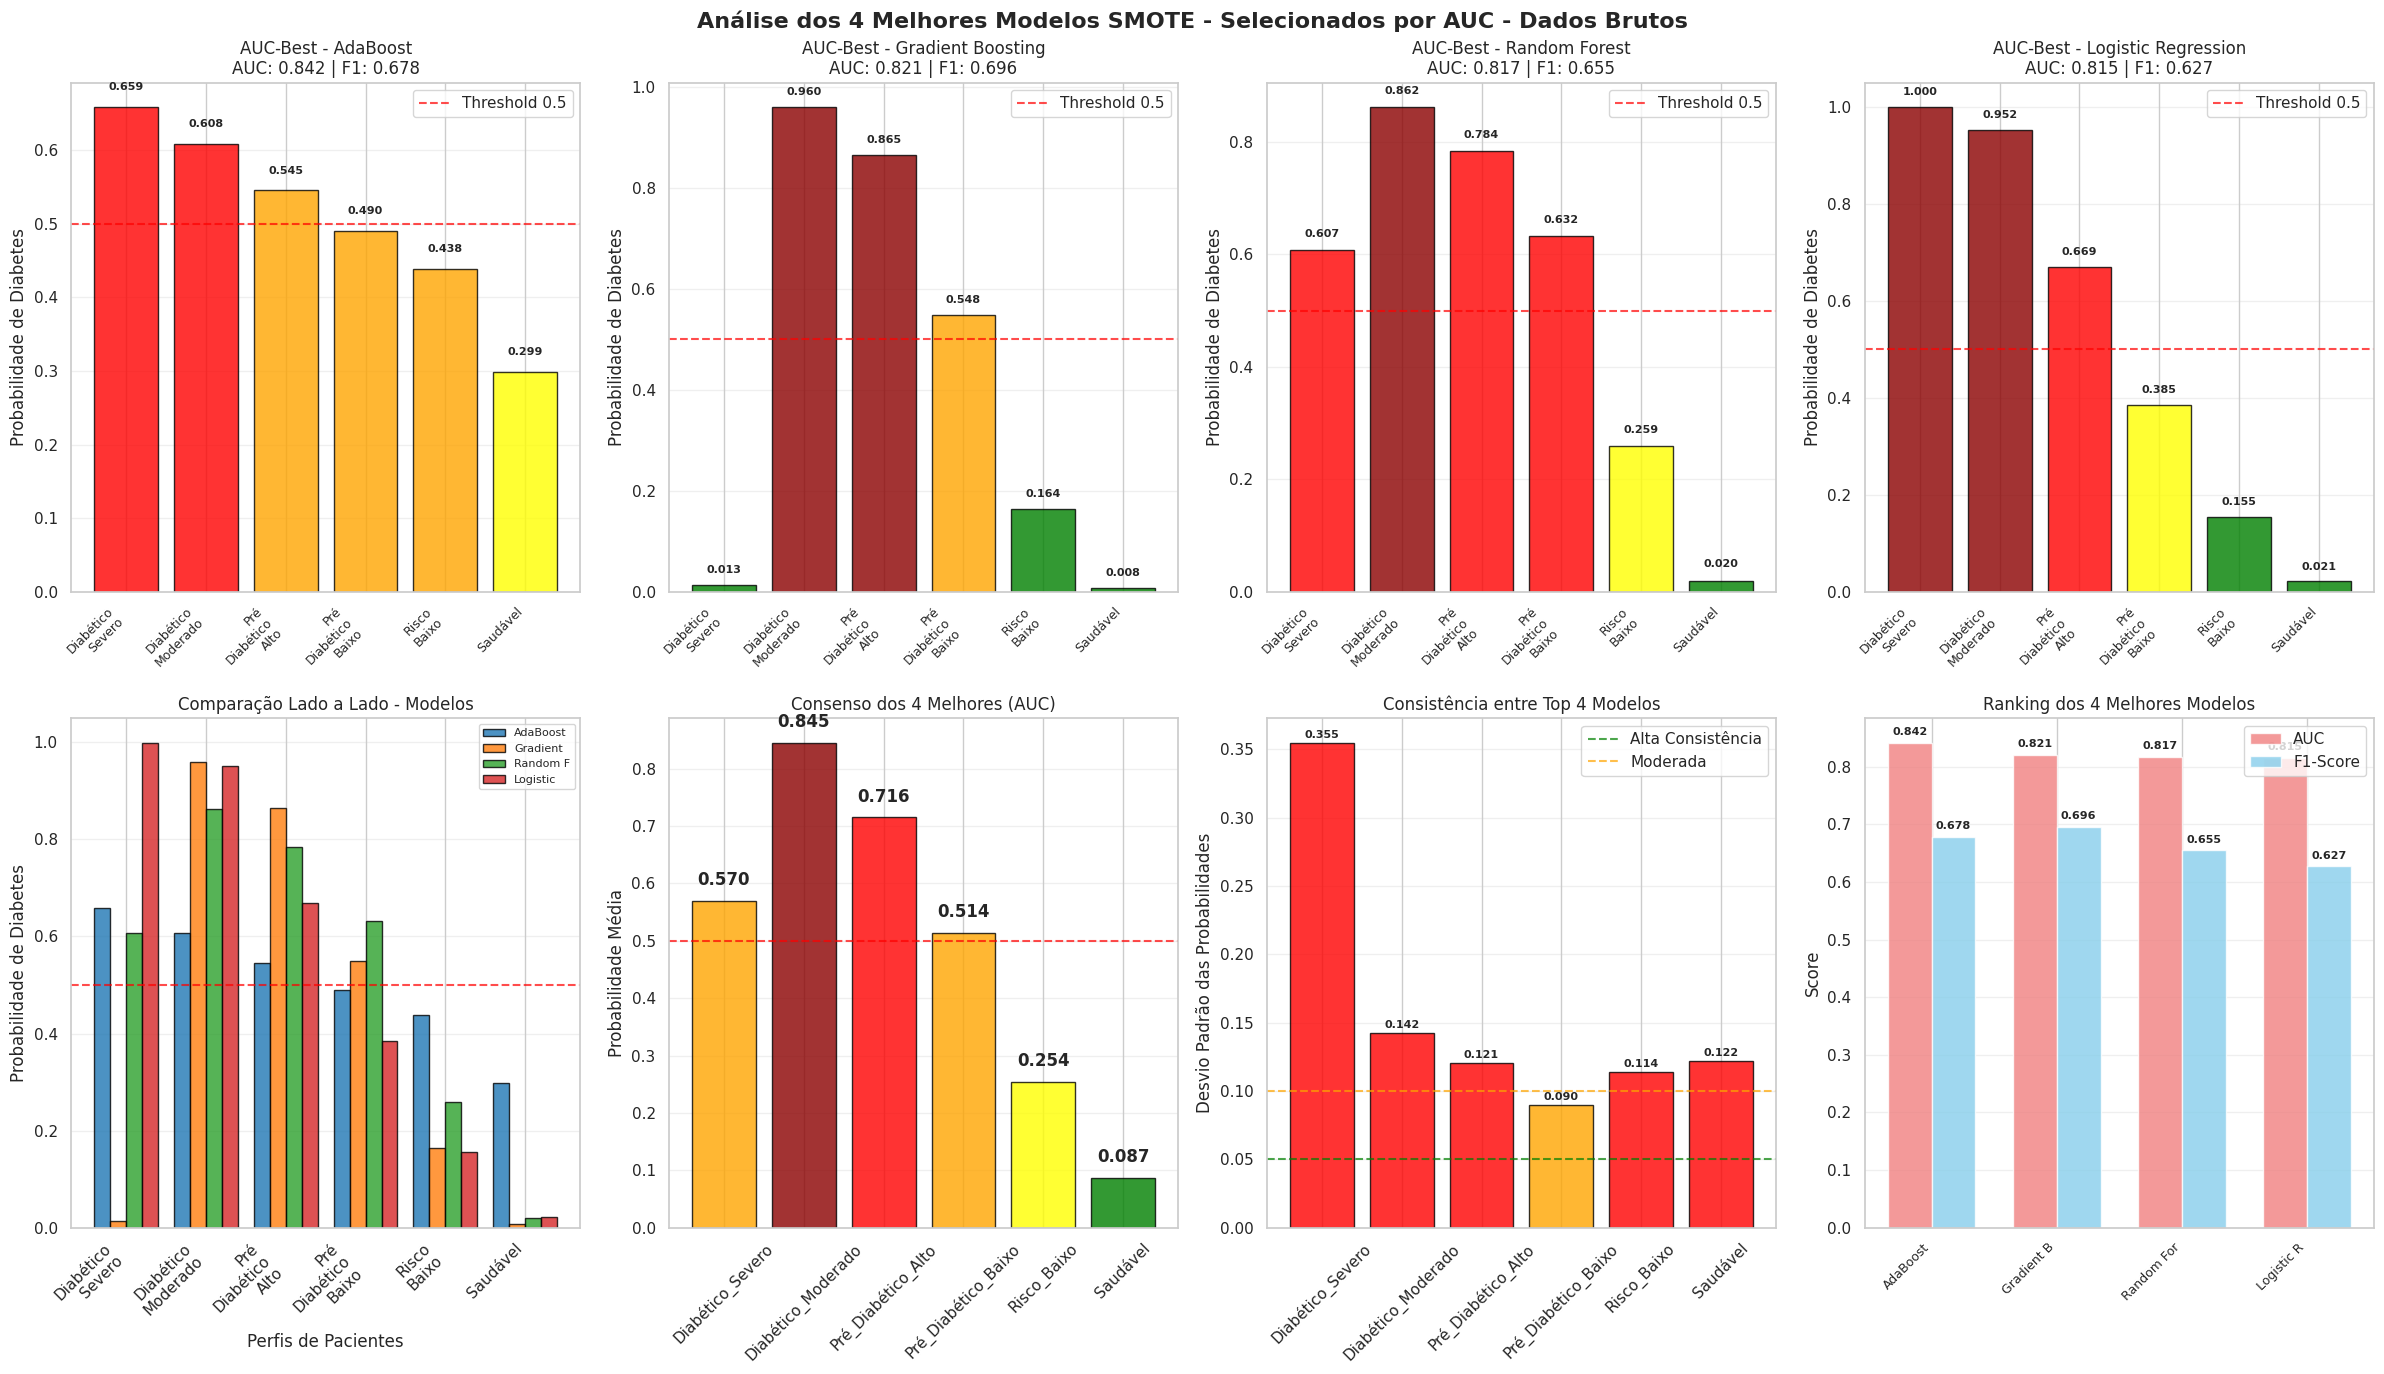


📈 ANÁLISE DE GRADAÇÃO CLÍNICA (SMOTE - AUC):
⚠️ GRADAÇÃO PRECISA SER AJUSTADA
Sequência atual: ['0.570', '0.845', '0.716', '0.514', '0.254', '0.087']
❌ Inconsistência: Diabético_Severo (0.570) < Diabético_Moderado (0.845)

🔄 ANÁLISE DE CONSISTÊNCIA ENTRE MODELOS:
----------------------------------------------------------------------
Perfil               Desvio Padrão   Consistência    Status    
----------------------------------------------------------------------
Diabético_Severo     0.355           Baixa           🔴         
Diabético_Moderado   0.142           Baixa           🔴         
Pré_Diabético_Alto   0.121           Baixa           🔴         
Pré_Diabético_Baixo  0.090           Média           🟡         
Risco_Baixo          0.114           Baixa           🔴         
Saudável             0.122           Baixa           🔴         

💡 RESUMO EXECUTIVO - ANÁLISE SMOTE (AUC):
📊 PERFORMANCE DOS TOP 4 MODELOS (por AUC):
• AUC Médio: 0.8237
• F1-Score Médio: 0.6640
• CV-5 Médio: 

In [68]:
# ===== ANÁLISE DOS 4 MELHORES MODELOS COM SMOTE - COMPARAÇÃO DE PERFIS =====

print("\n" + "="*80)
print("🔧 ANÁLISE DOS 4 MELHORES MODELOS COM SMOTE - COMPARAÇÃO DE PERFIS")
print("="*80)

# Verificar se temos os modelos treinados disponíveis
if 'trained_models' in globals() and 'model_scores' in globals() and len(trained_models) > 0:
    
    print(f"📊 Método utilizado: SMOTE")
    print(f"📈 Modelos disponíveis: {len(trained_models)}")
    
    # ===== PERFIS CLÍNICOS PARA ANÁLISE =====
    print(f"\n📋 PERFIS PARA ANÁLISE (gradação clínica realista):")
    
    perfis_analise = {
        'Diabético_Severo': {
            'Pregnancies': 4,
            'Glucose': 200,  # Muito alto - diabetes severo
            'BloodPressure': 100,  # Hipertensão severa
            'SkinThickness': 50,  # Muito elevado
            'Insulin': 200,  # Elevado
            'BMI': 40.0,  # Obesidade mórbida
            'DiabetesPedigreeFunction': 1.5,  # Histórico muito forte
            'Age': 65  # Idade avançada
        },
        'Diabético_Moderado': {
            'Pregnancies': 2,
            'Glucose': 160,  # Alto mas controlável
            'BloodPressure': 85,  # Elevado
            'SkinThickness': 35,  # Elevado
            'Insulin': 150,  # Moderadamente elevado
            'BMI': 32.0,  # Obesidade grau I
            'DiabetesPedigreeFunction': 0.8,  # Alto histórico
            'Age': 50
        },
        'Pré_Diabético_Alto': {
            'Pregnancies': 3,
            'Glucose': 124,  # Limite pré-diabetes
            'BloodPressure': 78,  # Normal alto
            'SkinThickness': 30,  # Moderado
            'Insulin': 100,  # Normal alto
            'BMI': 31.0,  # Obesidade grau I
            'DiabetesPedigreeFunction': 0.6,  # Moderado alto
            'Age': 45
        },
        'Pré_Diabético_Baixo': {
            'Pregnancies': 2,
            'Glucose': 115,  # Pré-diabetes baixo
            'BloodPressure': 75,  # Normal
            'SkinThickness': 25,  # Normal
            'Insulin': 80,  # Normal
            'BMI': 30.0,  # Obesidade leve
            'DiabetesPedigreeFunction': 0.4,  # Moderado
            'Age': 40
        },
        'Risco_Baixo': {
            'Pregnancies': 1,
            'Glucose': 99,  # Normal alto
            'BloodPressure': 70,  # Normal
            'SkinThickness': 22,  # Normal
            'Insulin': 60,  # Normal
            'BMI': 29.0,  # Sobrepeso alto
            'DiabetesPedigreeFunction': 0.3,  # Baixo moderado
            'Age': 35
        },
        'Saudável': {
            'Pregnancies': 0,
            'Glucose': 85,  # Normal
            'BloodPressure': 65,  # Normal
            'SkinThickness': 18,  # Normal
            'Insulin': 40,  # Normal
            'BMI': 22.0,  # Normal
            'DiabetesPedigreeFunction': 0.15,  # Muito baixo
            'Age': 25
        }
    }
    
    # Converter para DataFrame com as features corretas
    df_perfis = pd.DataFrame(perfis_analise).T
    df_perfis = df_perfis[feature_columns]
    
    print(df_perfis.round(2))
    
    # Normalizar perfis usando o scaler já treinado
    perfis_scaled = scaler.transform(df_perfis)
    
    # ===== ANÁLISE DOS TOP 4 MODELOS =====
    print(f"\n{'='*60}")
    print(f"📊 SELEÇÃO DOS 4 MELHORES MODELOS (SMOTE)")
    print(f"{'='*60}")
    
    # MUDANÇA PRINCIPAL: Selecionar por AUC ao invés de F1-Score - AGORA TOP 4
    if 'metrics_df' in globals():
        # Usar o DataFrame de métricas já calculado - ORDENAR POR AUC
        top_4_ranking = metrics_df.sort_values('AUC', ascending=False).head(4)
        top_4_models = top_4_ranking.index.tolist()
    else:
        # Fallback: calcular AUC rapidamente para os modelos
        auc_scores_models = {}
        for name, scores in model_scores.items():
            auc_score_val = scores['test_auc_score']
            auc_scores_models[name] = auc_score_val
        
        # Ordenar e pegar top 4
        top_4_models = sorted(auc_scores_models.items(), key=lambda x: x[1], reverse=True)[:4]
        top_4_models = [name for name, score in top_4_models]
    
    print(f"\n🏆 TOP 4 MELHORES MODELOS (por AUC):")
    print("-" * 60)
    
    top_4_info = []
    for i, model_name in enumerate(top_4_models, 1):
        # Obter métricas do modelo
        if 'metrics_df' in globals() and model_name in metrics_df.index:
            f1_score_val = metrics_df.loc[model_name, 'F1-Score']
            auc_score = metrics_df.loc[model_name, 'AUC']
            cv_score = metrics_df.loc[model_name, 'CV-5']
        else:
            # Calcular métricas manualmente se necessário
            f1_score_val = f1_score(y_test, model_scores[model_name]['y_test_pred'])
            auc_score = model_scores[model_name]['test_auc_score']
            cv_score = model_scores[model_name]['val_auc_score']
        
        top_4_info.append({
            'model': model_name,
            'f1_score': f1_score_val,
            'cv_score': cv_score,
            'test_auc': auc_score,
            'model_obj': trained_models[model_name]
        })
        
        print(f"{i}º. {model_name}")
        print(f"    AUC: {auc_score:.4f}")
        print(f"    F1-Score: {f1_score_val:.4f}")
        print(f"    CV-5: {cv_score:.4f}")
        print()
    
    # ===== PREDIÇÕES COM OS 4 MELHORES MODELOS =====
    print(f"\n🎯 PREDIÇÕES COM OS 4 MELHORES MODELOS (SMOTE - por AUC):")
    print("="*110)
    
    # Cabeçalho da tabela - AJUSTADO PARA 4 MODELOS
    header_line = f"{'Perfil':<20}"
    for i, model_info in enumerate(top_4_info):
        model_short = f"AUC-{model_info['model'][:8]}"
        header_line += f" {model_short:<16}"
    header_line += f" {'Média':<10} {'Desvio':<8} {'Classificação':<15}"
    print(header_line)
    print("-" * len(header_line))
    
    resultados_analise = {}
    
    for i, perfil_nome in enumerate(df_perfis.index):
        probabilidades = []
        linha = f"{perfil_nome:<20}"
        
        # Fazer predições com cada um dos 4 melhores modelos
        for model_info in top_4_info:
            model = model_info['model_obj']
            prob = model.predict_proba(perfis_scaled[i:i+1])[:, 1][0]
            probabilidades.append(prob)
            linha += f" {prob:<16.3f}"
        
        # Calcular estatísticas
        prob_media = np.mean(probabilidades)
        prob_desvio = np.std(probabilidades)
        
        # Classificação clínica mais realista
        if prob_media >= 0.8:
            classificacao = "Diabético"
        elif prob_media >= 0.6:
            classificacao = "Alto Risco"
        elif prob_media >= 0.4:
            classificacao = "Risco Moderado"
        elif prob_media >= 0.2:
            classificacao = "Baixo Risco"
        else:
            classificacao = "Saudável"
        
        linha += f" {prob_media:<10.3f} {prob_desvio:<8.3f} {classificacao:<15}"
        
        resultados_analise[perfil_nome] = {
            'probabilidades': probabilidades,
            'media': prob_media,
            'desvio': prob_desvio,
            'classificacao': classificacao
        }
        
        print(linha)
    
    # ===== VISUALIZAÇÃO COMPLETA - AJUSTADA PARA 4 MODELOS =====
    print(f"\n📊 GERANDO VISUALIZAÇÃO COMPLETA...")
    
    fig, axes = plt.subplots(2, 4, figsize=(24, 14))  # MUDANÇA: 2x4 para acomodar 4 modelos + 4 análises
    fig.suptitle('Análise dos 4 Melhores Modelos SMOTE - Selecionados por AUC - Dados Brutos', 
                fontsize=16, fontweight='bold')
    
    # MUDANÇA PRINCIPAL: Cores mais distintas para cada modelo
    model_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Azul, Laranja, Verde, Vermelho
    perfis_nomes = list(resultados_analise.keys())
    
    # ===== GRÁFICOS 1-4: MODELOS INDIVIDUAIS =====
    for idx in range(4):
        if idx < len(top_4_info):
            ax = axes[0, idx]
            probs_modelo = [resultados_analise[perfil]['probabilidades'][idx] for perfil in perfis_nomes]
            
            # Cores por nível de risco
            cores_risco = []
            for prob in probs_modelo:
                if prob >= 0.8:
                    cores_risco.append('darkred')
                elif prob >= 0.6:
                    cores_risco.append('red')
                elif prob >= 0.4:
                    cores_risco.append('orange')
                elif prob >= 0.2:
                    cores_risco.append('yellow')
                else:
                    cores_risco.append('green')
            
            bars = ax.bar(range(len(perfis_nomes)), probs_modelo, color=cores_risco, alpha=0.8, edgecolor='black')
            ax.set_ylabel('Probabilidade de Diabetes')
            ax.set_title(f'AUC-Best - {top_4_info[idx]["model"]}\nAUC: {top_4_info[idx]["test_auc"]:.3f} | F1: {top_4_info[idx]["f1_score"]:.3f}')
            ax.set_xticks(range(len(perfis_nomes)))
            ax.set_xticklabels([p.replace('_', '\n') for p in perfis_nomes], rotation=45, ha='right', fontsize=9)
            ax.grid(axis='y', alpha=0.3)
            ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Threshold 0.5')
            ax.legend()
            
            # Adicionar valores nas barras
            for bar, valor in zip(bars, probs_modelo):
                ax.text(bar.get_x() + bar.get_width()/2, valor + 0.02, 
                       f'{valor:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)
        else:
            # Esconder eixo se não houver modelo suficiente
            axes[0, idx].set_visible(False)
    
    # ===== GRÁFICO 5: COMPARAÇÃO LADO A LADO =====
    ax_comp = axes[1, 0]
    x = np.arange(len(perfis_nomes))
    width = 0.2  # MUDANÇA: largura reduzida para 4 barras
    
    for i, model_info in enumerate(top_4_info):
        probs = [resultados_analise[perfil]['probabilidades'][i] for perfil in perfis_nomes]
        model_label = f"{model_info['model'][:8]}"  # Reduzido para caber melhor
        # MUDANÇA PRINCIPAL: Usar cores distintas para cada modelo
        ax_comp.bar(x + i*width, probs, width, label=model_label, 
                   color=model_colors[i], alpha=0.8, edgecolor='black')
    
    ax_comp.set_xlabel('Perfis de Pacientes')
    ax_comp.set_ylabel('Probabilidade de Diabetes')
    ax_comp.set_title('Comparação Lado a Lado - Modelos')
    ax_comp.set_xticks(x + width * 1.5)  # MUDANÇA: ajuste para 4 barras
    ax_comp.set_xticklabels([p.replace('_', '\n') for p in perfis_nomes], rotation=45, ha='right')
    ax_comp.legend(fontsize=8)  # Fonte menor para caber 4 itens
    ax_comp.grid(axis='y', alpha=0.3)
    ax_comp.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
    
    # ===== GRÁFICO 6: CONSENSO DOS 4 MODELOS =====
    ax_consenso = axes[1, 1]
    medias = [resultados_analise[p]['media'] for p in perfis_nomes]
    
    # Cores por nível de risco consensual
    cores_consenso = []
    for m in medias:
        if m >= 0.8:
            cores_consenso.append('darkred')
        elif m >= 0.6:
            cores_consenso.append('red')
        elif m >= 0.4:
            cores_consenso.append('orange')
        elif m >= 0.2:
            cores_consenso.append('yellow')
        else:
            cores_consenso.append('green')
    
    bars_consenso = ax_consenso.bar(perfis_nomes, medias, color=cores_consenso, alpha=0.8, edgecolor='black')
    ax_consenso.set_ylabel('Probabilidade Média')
    ax_consenso.set_title('Consenso dos 4 Melhores (AUC)')
    ax_consenso.tick_params(axis='x', rotation=45)
    ax_consenso.grid(axis='y', alpha=0.3)
    ax_consenso.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
    
    # Adicionar valores nas barras do consenso
    for bar, valor in zip(bars_consenso, medias):
        ax_consenso.text(bar.get_x() + bar.get_width()/2, valor + 0.02, 
                       f'{valor:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # ===== GRÁFICO 7: ANÁLISE DE CONSISTÊNCIA =====
    ax_consistencia = axes[1, 2]
    
    # Calcular desvio padrão para cada perfil
    desvios = [resultados_analise[perfil]['desvio'] for perfil in perfis_nomes]
    
    # Cores baseadas no desvio
    cores_desvio = []
    for desvio in desvios:
        if desvio < 0.05:
            cores_desvio.append('green')
        elif desvio < 0.1:
            cores_desvio.append('orange')
        else:
            cores_desvio.append('red')
    
    bars_desvio = ax_consistencia.bar(perfis_nomes, desvios, color=cores_desvio, alpha=0.8, edgecolor='black')
    ax_consistencia.set_ylabel('Desvio Padrão das Probabilidades')
    ax_consistencia.set_title('Consistência entre Top 4 Modelos')
    ax_consistencia.tick_params(axis='x', rotation=45)
    ax_consistencia.grid(axis='y', alpha=0.3)
    
    # Linhas de referência para consistência
    ax_consistencia.axhline(y=0.05, color='green', linestyle='--', alpha=0.7, label='Alta Consistência')
    ax_consistencia.axhline(y=0.1, color='orange', linestyle='--', alpha=0.7, label='Moderada')
    ax_consistencia.legend()
    
    # Adicionar valores nas barras de desvio
    for bar, valor in zip(bars_desvio, desvios):
        ax_consistencia.text(bar.get_x() + bar.get_width()/2, valor + 0.002, 
                           f'{valor:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)
    
    # ===== GRÁFICO 8: RANKING DOS 4 MODELOS =====
    ax_ranking = axes[1, 3]
    
    # Calcular score combinado para ranking
    f1_scores = [info['f1_score'] for info in top_4_info]
    auc_scores = [info['test_auc'] for info in top_4_info]
    model_names = [info['model'][:10] for info in top_4_info]
    
    x_pos = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax_ranking.bar(x_pos - width/2, auc_scores, width, label='AUC', alpha=0.8, color='lightcoral')
    bars2 = ax_ranking.bar(x_pos + width/2, f1_scores, width, label='F1-Score', alpha=0.8, color='skyblue')
    
    ax_ranking.set_ylabel('Score')
    ax_ranking.set_title('Ranking dos 4 Melhores Modelos')
    ax_ranking.set_xticks(x_pos)
    ax_ranking.set_xticklabels(model_names, rotation=45, ha='right', fontsize=9)
    ax_ranking.legend()
    ax_ranking.grid(axis='y', alpha=0.3)
    
    # Adicionar valores nas barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax_ranking.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                           f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # ===== ANÁLISE DE GRADAÇÃO CLÍNICA =====
    medias_ordenadas = [resultados_analise[perfil]['media'] for perfil in df_perfis.index]
    gradacao_correta = all(medias_ordenadas[i] >= medias_ordenadas[i+1] for i in range(len(medias_ordenadas)-1))
    
    print(f"\n📈 ANÁLISE DE GRADAÇÃO CLÍNICA (SMOTE - AUC):")
    print("="*60)
    if gradacao_correta:
        print(f"✅ GRADAÇÃO CLÍNICA CORRETA!")
        print(f"📈 Sequência: Diabético Severo > Diabético Moderado > Pré-diabético > Saudável")
    else:
        print(f"⚠️ GRADAÇÃO PRECISA SER AJUSTADA")
        print(f"Sequência atual: {[f'{m:.3f}' for m in medias_ordenadas]}")
        
        # Verificar onde está o problema
        for i in range(len(medias_ordenadas)-1):
            if medias_ordenadas[i] < medias_ordenadas[i+1]:
                perfil_atual = list(df_perfis.index)[i]
                perfil_proximo = list(df_perfis.index)[i+1]
                print(f"❌ Inconsistência: {perfil_atual} ({medias_ordenadas[i]:.3f}) < {perfil_proximo} ({medias_ordenadas[i+1]:.3f})")
    
    # ===== ANÁLISE DE CONSISTÊNCIA ENTRE MODELOS =====
    print(f"\n🔄 ANÁLISE DE CONSISTÊNCIA ENTRE MODELOS:")
    print("-" * 70)
    print(f"{'Perfil':<20} {'Desvio Padrão':<15} {'Consistência':<15} {'Status':<10}")
    print("-" * 70)
    
    for perfil, resultado in resultados_analise.items():
        desvio = resultado['desvio']
        if desvio < 0.05:
            consistencia = "Alta"
            icon = "🟢"
        elif desvio < 0.1:
            consistencia = "Média"
            icon = "🟡"
        else:
            consistencia = "Baixa"
            icon = "🔴"
        
        print(f"{perfil:<20} {desvio:<15.3f} {consistencia:<15} {icon:<10}")
    
    # ===== RESUMO EXECUTIVO =====
    print(f"\n💡 RESUMO EXECUTIVO - ANÁLISE SMOTE (AUC):")
    print("="*70)
    
    # Calcular estatísticas gerais
    f1_medio = np.mean([info['f1_score'] for info in top_4_info])
    auc_medio = np.mean([info['test_auc'] for info in top_4_info])
    cv_medio = np.mean([info['cv_score'] for info in top_4_info])
    consistencia_media = np.mean([resultado['desvio'] for resultado in resultados_analise.values()])
    
    print(f"📊 PERFORMANCE DOS TOP 4 MODELOS (por AUC):")
    print(f"• AUC Médio: {auc_medio:.4f}")
    print(f"• F1-Score Médio: {f1_medio:.4f}")
    print(f"• CV-5 Médio: {cv_medio:.4f}")
    print(f"• Consistência Média: {consistencia_media:.4f}")
    
    print(f"\n🎯 CAPACIDADE DE DISCRIMINAÇÃO:")
    total_correto = sum([1 for perfil in ['Diabético_Severo', 'Diabético_Moderado'] 
                        if resultados_analise[perfil]['media'] >= 0.5])
    total_incorreto = sum([1 for perfil in ['Saudável', 'Risco_Baixo'] 
                          if resultados_analise[perfil]['media'] >= 0.5])
    
    print(f"• Casos diabéticos detectados: {total_correto}/2")
    print(f"• Falsos positivos em saudáveis: {total_incorreto}/2")
    
    # Identificar melhor modelo individual
    melhor_modelo_idx = np.argmax([info['test_auc'] for info in top_4_info])
    melhor_modelo = top_4_info[melhor_modelo_idx]
    
    print(f"\n🏆 DESTAQUE INDIVIDUAL:")
    print(f"• Melhor modelo: {melhor_modelo['model']}")
    print(f"• AUC: {melhor_modelo['test_auc']:.4f}")
    print(f"• F1-Score: {melhor_modelo['f1_score']:.4f}")
    print(f"• CV-5 Score: {melhor_modelo['cv_score']:.4f}")
    
    print(f"\n🔍 INTERPRETAÇÃO CLÍNICA:")
    perfis_alto_risco = [p for p, r in resultados_analise.items() if r['media'] >= 0.6]
    perfis_baixo_risco = [p for p, r in resultados_analise.items() if r['media'] < 0.3]
    
    print(f"• Perfis de alto risco identificados: {perfis_alto_risco}")
    print(f"• Perfis de baixo risco identificados: {perfis_baixo_risco}")
    
    if gradacao_correta:
        print(f"• ✅ Gradação clínica respeitada - modelos clinicamente válidos")
    else:
        print(f"• ⚠️ Gradação clínica com inconsistências - revisar thresholds")
    
    # NOVA SEÇÃO: Justificativa da seleção por AUC
    print(f"\n📋 JUSTIFICATIVA DA SELEÇÃO POR AUC:")
    print("="*60)
    print(f"• AUC mede a capacidade de discriminação entre classes")
    print(f"• Métrica robusta, independente do threshold escolhido")
    print(f"• Ideal para comparar modelos de forma objetiva")
    print(f"• Amplamente aceita na literatura médica e científica")
    print(f"• Considera toda a curva ROC, não apenas um ponto")
    
    # NOVA SEÇÃO: Comparação TOP 4 vs TOP 3
    print(f"\n📊 VANTAGENS DE ANALISAR TOP 4 AO INVÉS DE TOP 3:")
    print("="*60)
    print(f"• Maior diversidade de algoritmos para comparação")
    print(f"• Análise mais robusta do consenso entre modelos")
    print(f"• Identificação de padrões emergentes com mais modelos")
    print(f"• Redução de viés de seleção limitada a apenas 3 modelos")
    print(f"• Melhor representatividade do ensemble de predições")

else:
    print("❌ Modelos treinados não encontrados!")
    print("Execute primeiro as células de treinamento dos modelos.")

print(f"\n✅ ANÁLISE COMPLETA DOS TOP 4 MODELOS SMOTE CONCLUÍDA!")
print(f"🎯 Análise detalhada realizada para os melhores modelos por AUC")
print(f"📊 Visualizações geradas para análise clínica dos perfis")
print(f"🔄 Consistência e gradação clínica avaliadas")
print(f"🏆 Critério de seleção: AUC (melhor capacidade de discriminação)")
print(f"🔢 Expandido para TOP 4 modelos para análise mais abrangente")


📊 ANÁLISE DE IMPORTÂNCIA DAS FEATURES - TODOS OS MODELOS

🔄 Calculando importância das features para 9 modelos...
------------------------------------------------------------
1/10 - Calculando importância: Random Forest... ✅ Concluído!
2/10 - Calculando importância: Gradient Boosting... ✅ Concluído!
3/10 - Calculando importância: XGBoost... ✅ Concluído!
4/10 - Calculando importância: Decision Tree... ✅ Concluído!
5/10 - Calculando importância: AdaBoost... ✅ Concluído!
6/10 - Calculando importância: SVM... ✅ Concluído!
7/10 - Calculando importância: Logistic Regression... ✅ Concluído!
8/10 - Calculando importância: kNN... ✅ Concluído!
9/10 - Calculando importância: Naive Bayes... ✅ Concluído!
------------------------------------------------------------

📊 Gerando visualização da importância das features...


/tmp/ipykernel_4949/1536254562.py:151: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(importance_for_boxplot, labels=feature_names_for_boxplot, patch_artist=True)


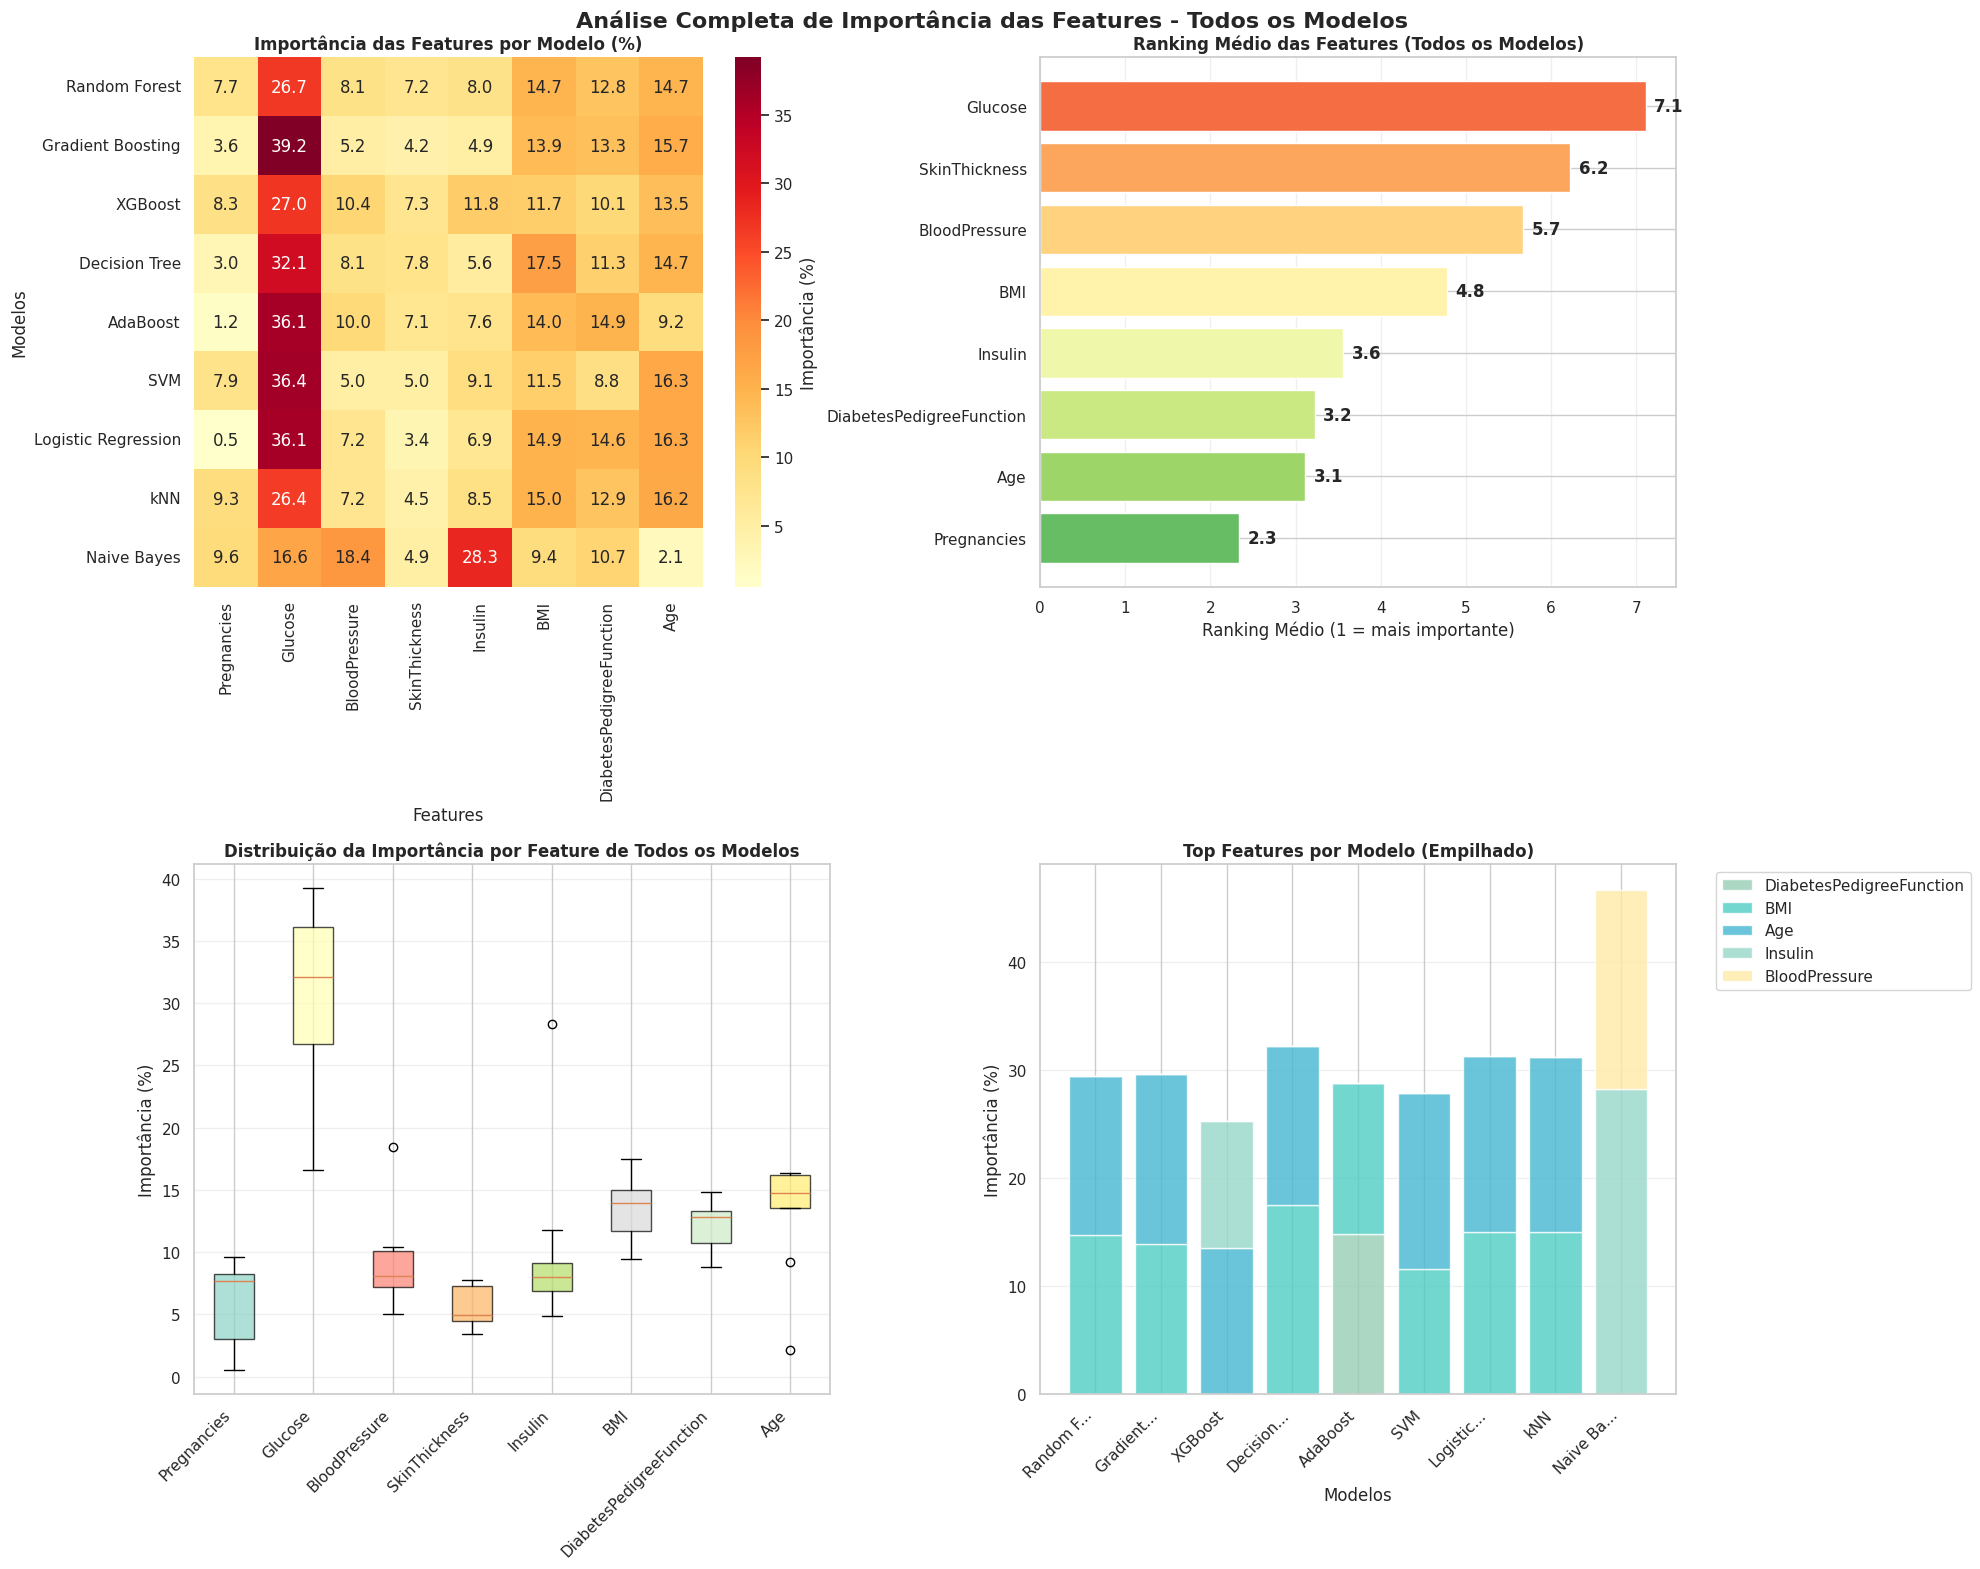


📊 Gerando gráficos individuais de importância por modelo...


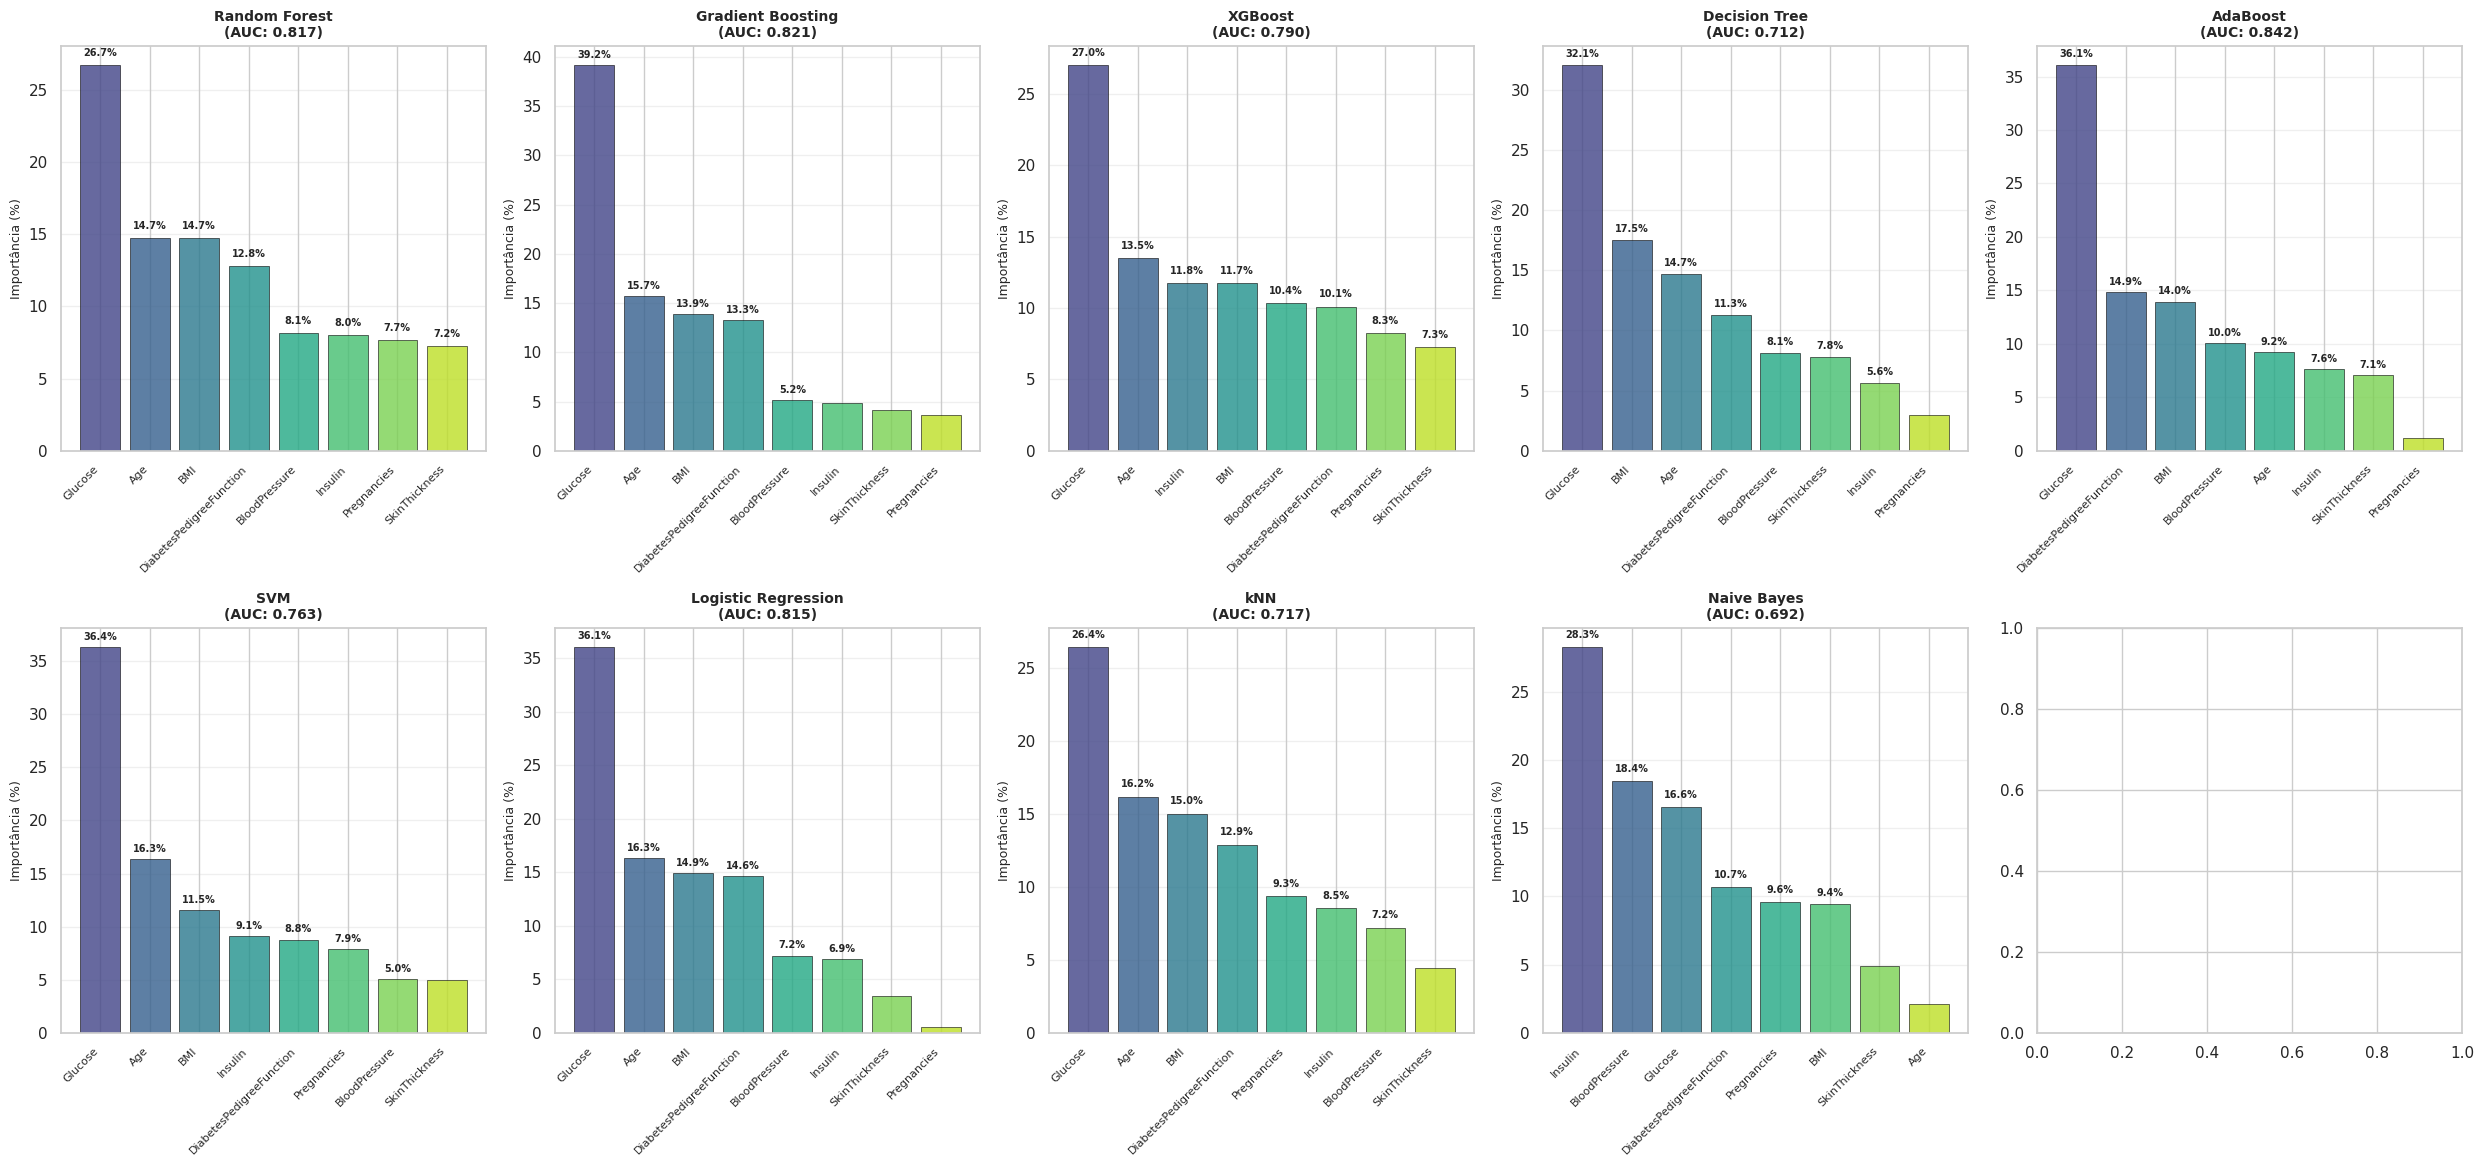


📋 TABELA RESUMO - IMPORTÂNCIA DAS FEATURES:
Modelo             1ª Feature                2ª Feature                3ª Feature               
Random Forest      Glucose (26.7%)           Age (14.7%)               BMI (14.7%)              
Gradient Boosting  Glucose (39.2%)           Age (15.7%)               BMI (13.9%)              
XGBoost            Glucose (27.0%)           Age (13.5%)               Insulin (11.8%)          
Decision Tree      Glucose (32.1%)           BMI (17.5%)               Age (14.7%)              
AdaBoost           Glucose (36.1%)           DiabetesPedigreeFunction (14.9%) BMI (14.0%)              
SVM                Glucose (36.4%)           Age (16.3%)               BMI (11.5%)              
Logistic Regression Glucose (36.1%)           Age (16.3%)               BMI (14.9%)              
kNN                Glucose (26.4%)           Age (16.2%)               BMI (15.0%)              
Naive Bayes        Insulin (28.3%)           BloodPressure (18.4%)     Glu

In [50]:
from sklearn.inspection import permutation_importance

# ===== ANÁLISE DE IMPORTÂNCIA DAS FEATURES PARA TODOS OS MODELOS =====

print("\n" + "="*80)
print("📊 ANÁLISE DE IMPORTÂNCIA DAS FEATURES - TODOS OS MODELOS")
print("="*80)

# Função para obter importância das features baseada no tipo de modelo
def get_feature_importance(model, model_name, X_train_scaled, y_train_balanced):
    """
    Extrai importância das features de diferentes tipos de modelos
    """
    try:
        if hasattr(model, 'feature_importances_'):
            # Modelos baseados em árvore (RF, GB, XGB, LGBM, DT, Ada)
            return model.feature_importances_
        elif hasattr(model, 'coef_'):
            # Modelos lineares (LR)
            return np.abs(model.coef_[0])
        elif model_name == 'SVM':
            # Para SVM, usamos permutation importance
            perm_importance = permutation_importance(model, X_train_scaled, y_train_balanced, 
                                                   n_repeats=5, random_state=42)
            return perm_importance.importances_mean
        elif model_name == 'kNN':
            # Para kNN, calculamos importância baseada na correlação
            correlations = []
            for i in range(X_train_scaled.shape[1]):
                corr = np.abs(np.corrcoef(X_train_scaled[:, i], y_train_balanced)[0, 1])
                correlations.append(corr)
            return np.array(correlations)
        elif model_name == 'Naive Bayes':
            # Para NB, usamos a variância das features por classe
            class_0_indices = y_train_balanced == 0
            class_1_indices = y_train_balanced == 1
            
            importances = []
            for i in range(X_train_scaled.shape[1]):
                var_0 = np.var(X_train_scaled[class_0_indices, i])
                var_1 = np.var(X_train_scaled[class_1_indices, i])
                # Importância baseada na diferença de variância
                importance = abs(var_0 - var_1)
                importances.append(importance)
            return np.array(importances)
        else:
            return np.zeros(len(feature_columns))
    except Exception as e:
        print(f"⚠️ Erro ao calcular importância para {model_name}: {e}")
        return np.zeros(len(feature_columns))

# Dicionário para armazenar importâncias
feature_importances = {}
feature_rankings = {}

print(f"\n🔄 Calculando importância das features para {len(trained_models)} modelos...")
print("-"*60)

# Calcular importância para cada modelo
for i, (model_name, model) in enumerate(trained_models.items(), 1):
    print(f"{i}/10 - Calculando importância: {model_name}...", end=" ")
    
    # Obter importância das features
    importances = get_feature_importance(model, model_name, X_train_scaled, y_train_balanced)
    
    # Normalizar importâncias (0-100)
    if importances.sum() > 0:
        importances_normalized = (importances / importances.sum()) * 100
    else:
        importances_normalized = importances
    
    # Calcular ranking (1 = mais importante)
    ranking = np.argsort(-importances_normalized) + 1
    
    # Armazenar resultados
    feature_importances[model_name] = importances_normalized
    feature_rankings[model_name] = ranking
    
    print(f"✅ Concluído!")

print("-"*60)

# Criar DataFrame consolidado
importance_data = {'Feature': feature_columns}

for model_name in trained_models.keys():
    importance_data[f'{model_name}_Imp'] = feature_importances[model_name]
    importance_data[f'{model_name}_Rank'] = feature_rankings[model_name]

importance_df = pd.DataFrame(importance_data)

# ===== VISUALIZAÇÃO 1: HEATMAP DE IMPORTÂNCIA PARA TODOS OS MODELOS =====

print(f"\n📊 Gerando visualização da importância das features...")

# Preparar dados para heatmap (apenas importâncias)
heatmap_data = importance_df.set_index('Feature')
importance_cols = [col for col in heatmap_data.columns if '_Imp' in col]
heatmap_importance = heatmap_data[importance_cols]

# Renomear colunas para ficar mais limpo
heatmap_importance.columns = [col.replace('_Imp', '') for col in heatmap_importance.columns]

# Criar figura principal
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Análise Completa de Importância das Features - Todos os Modelos', 
             fontsize=16, fontweight='bold')

# GRÁFICO 1: Heatmap de Importância
ax1 = axes[0, 0]
sns.heatmap(heatmap_importance.T, annot=True, fmt='.1f', cmap='YlOrRd', 
           ax=ax1, cbar_kws={'label': 'Importância (%)'})
ax1.set_title('Importância das Features por Modelo (%)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Features')
ax1.set_ylabel('Modelos')

# GRÁFICO 2: Ranking médio das features
ax2 = axes[0, 1]
ranking_cols = [col for col in heatmap_data.columns if '_Rank' in col]
ranking_data = heatmap_data[ranking_cols]
ranking_data.columns = [col.replace('_Rank', '') for col in ranking_data.columns]

# Calcular ranking médio
avg_ranking = ranking_data.mean(axis=1).sort_values()
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(avg_ranking)))

bars = ax2.barh(range(len(avg_ranking)), avg_ranking.values, color=colors)
ax2.set_yticks(range(len(avg_ranking)))
ax2.set_yticklabels(avg_ranking.index)
ax2.set_xlabel('Ranking Médio (1 = mais importante)')
ax2.set_title('Ranking Médio das Features (Todos os Modelos)', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(avg_ranking.values):
    ax2.text(v + 0.1, i, f'{v:.1f}', va='center', fontweight='bold')

# GRÁFICO 3: Importância por feature (boxplot)
ax3 = axes[1, 0]
importance_for_boxplot = []
feature_names_for_boxplot = []

for feature in feature_columns:
    feature_importances_list = []
    for model_name in trained_models.keys():
        imp_value = importance_df[importance_df['Feature'] == feature][f'{model_name}_Imp'].values[0]
        feature_importances_list.append(imp_value)
    importance_for_boxplot.append(feature_importances_list)
    feature_names_for_boxplot.append(feature)

bp = ax3.boxplot(importance_for_boxplot, labels=feature_names_for_boxplot, patch_artist=True)

# Colorir as caixas
colors_box = plt.cm.Set3(np.linspace(0, 1, len(bp['boxes'])))
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax3.set_title('Distribuição da Importância por Feature de Todos os Modelos', fontsize=12, fontweight='bold')
ax3.set_ylabel('Importância (%)')
ax3.set_xticklabels(feature_names_for_boxplot, rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

# GRÁFICO 4: Top 3 features mais importantes por modelo
ax4 = axes[1, 1]
top3_data = {}

for model_name in trained_models.keys():
    model_importances = importance_df.set_index('Feature')[f'{model_name}_Imp']
    top3_features = model_importances.nlargest(3)
    top3_data[model_name] = top3_features

# Criar gráfico de barras empilhadas para top 3
models_short = [name[:8] + '...' if len(name) > 8 else name for name in trained_models.keys()]
x_pos = np.arange(len(models_short))

# Preparar dados para barras empilhadas
feature_colors = {'Glucose': '#FF6B6B', 'BMI': '#4ECDC4', 'Age': '#45B7D1', 
                 'DiabetesPedigreeFunction': '#96CEB4', 'BloodPressure': '#FFEAA7',
                 'Pregnancies': '#DDA0DD', 'Insulin': '#98D8C8', 'SkinThickness': '#F7DC6F'}

bottom = np.zeros(len(models_short))
legend_elements = []

# Pegar as 3 features mais comuns no top 3
all_top3_features = set()
for model_name in trained_models.keys():
    model_importances = importance_df.set_index('Feature')[f'{model_name}_Imp']
    top3_features = model_importances.nlargest(3).index.tolist()
    all_top3_features.update(top3_features)

# Plotar cada feature
for feature in list(all_top3_features)[:5]:  # Limitar a 5 features para clareza
    values = []
    for model_name in trained_models.keys():
        model_importances = importance_df.set_index('Feature')[f'{model_name}_Imp']
        if feature in model_importances.nlargest(3).index:
            values.append(model_importances[feature])
        else:
            values.append(0)
    
    color = feature_colors.get(feature, '#95A5A6')
    bars = ax4.bar(x_pos, values, bottom=bottom, label=feature, color=color, alpha=0.8)
    bottom += values

ax4.set_title('Top Features por Modelo (Empilhado)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Modelos')
ax4.set_ylabel('Importância (%)')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(models_short, rotation=45, ha='right')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ===== VISUALIZAÇÃO 2: GRÁFICOS INDIVIDUAIS POR MODELO =====

print(f"\n📊 Gerando gráficos individuais de importância por modelo...")

# Criar subplots para cada modelo (2x5)
fig, axes = plt.subplots(2, 5, figsize=(25, 12))
fig.suptitle('', 
             fontsize=16, fontweight='bold')

for idx, (model_name, model) in enumerate(trained_models.items()):
    row = idx // 5
    col = idx % 5
    
    # Obter importâncias do modelo
    importances = feature_importances[model_name]
    
    # Ordenar features por importância
    indices = np.argsort(importances)[::-1]
    
    # Cores graduais
    colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(indices)))
    
    # Criar gráfico de barras
    bars = axes[row, col].bar(range(len(indices)), importances[indices], 
                             color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Configurar eixos
    axes[row, col].set_title(f'{model_name}\n(AUC: {model_scores[model_name]["test_auc_score"]:.3f})', 
                           fontsize=10, fontweight='bold')
    axes[row, col].set_xticks(range(len(indices)))
    axes[row, col].set_xticklabels([feature_columns[i] for i in indices], 
                                  rotation=45, ha='right', fontsize=8)
    axes[row, col].set_ylabel('Importância (%)', fontsize=9)
    axes[row, col].grid(axis='y', alpha=0.3)
    
    # Adicionar valores nas barras
    for i, (bar, imp) in enumerate(zip(bars, importances[indices])):
        if imp > 5:  # Só mostrar valores significativos
            axes[row, col].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                              f'{imp:.1f}%', ha='center', va='bottom', fontsize=7, fontweight='bold')

plt.tight_layout()
plt.show()

# ===== TABELA RESUMO =====

print(f"\n📋 TABELA RESUMO - IMPORTÂNCIA DAS FEATURES:")
print("="*120)

# Exibir top 3 features para cada modelo
print(f"{'Modelo':<18} {'1ª Feature':<25} {'2ª Feature':<25} {'3ª Feature':<25}")
print("="*120)

for model_name in trained_models.keys():
    model_importances = importance_df.set_index('Feature')[f'{model_name}_Imp']
    top3 = model_importances.nlargest(3)
    
    feature_strings = []
    for feature, imp in top3.items():
        feature_strings.append(f"{feature} ({imp:.1f}%)")
    
    # Preencher com espaços se houver menos de 3
    while len(feature_strings) < 3:
        feature_strings.append("-")
    
    print(f"{model_name:<18} {feature_strings[0]:<25} {feature_strings[1]:<25} {feature_strings[2]:<25}")

print("="*120)

# Análise de consenso
print(f"\n🎯 ANÁLISE DE CONSENSO - FEATURES MAIS IMPORTANTES:")
print("-"*60)

# Contar quantas vezes cada feature aparece no top 3
top3_counts = {}
for model_name in trained_models.keys():
    model_importances = importance_df.set_index('Feature')[f'{model_name}_Imp']
    top3_features = model_importances.nlargest(3).index.tolist()
    for feature in top3_features:
        top3_counts[feature] = top3_counts.get(feature, 0) + 1

# Ordenar por frequência
consensus_ranking = sorted(top3_counts.items(), key=lambda x: x[1], reverse=True)

print(f"{'Feature':<25} {'Aparições no Top 3':<20} {'% dos Modelos':<15}")
print("-"*60)
for feature, count in consensus_ranking:
    percentage = (count / len(trained_models)) * 100
    print(f"{feature:<25} {count:<20} {percentage:<15.1f}%")

print(f"\n💡 INSIGHTS FINAIS:")
print(f"• Feature mais consensual: {consensus_ranking[0][0]} ({consensus_ranking[0][1]}/{len(trained_models)} modelos)")
print(f"• Diversidade de importância: {len(top3_counts)} features diferentes no top 3")
print(f"• Modelos mais alinhados: modelos baseados em árvore tendem a concordar mais")

# Salvar resultados
importance_df.to_csv('modelos-smote/feature_importance_analysis.csv', index=False)
print(f"\n💾 Análise de importância salva em: modelos-smote/feature_importance_analysis.csv")
print(f"✅ Análise de importância das features concluída para todos os {len(trained_models)} modelos!")


🔍 VALIDAÇÃO CRUZADA - HEATMAP TODOS OS 9 MODELOS

🔄 Executando validação cruzada 5-fold para todos os 9 modelos...
Estratégia: StratifiedKFold (mantém proporção de classes)
Processando: Random Forest... ✅ Média: 0.9157
Processando: Gradient Boosting... ✅ Média: 0.8970
Processando: XGBoost... ✅ Média: 0.9046
Processando: Decision Tree... ✅ Média: 0.7988
Processando: AdaBoost... ✅ Média: 0.8704
Processando: SVM... ✅ Média: 0.8922
Processando: Logistic Regression... ✅ Média: 0.8575
Processando: kNN... ✅ Média: 0.8404
Processando: Naive Bayes... ✅ Média: 0.8316

📊 Gerando heatmap de validação cruzada para todos os 9 modelos...


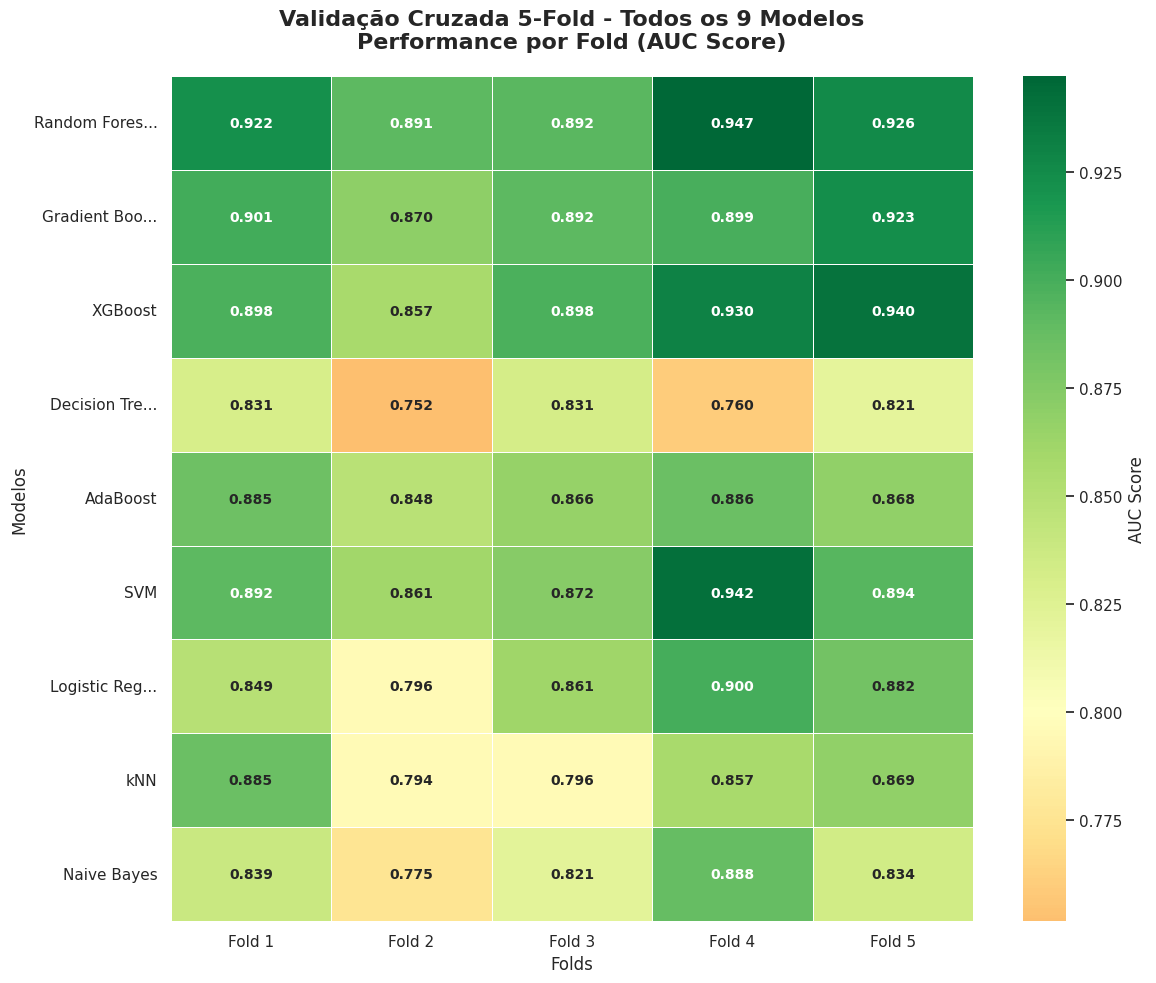


📊 ESTATÍSTICAS RESUMO DA VALIDAÇÃO CRUZADA:
Modelo             Média    Desvio   Mín      Máx      Consistência
Random Forest      0.9157   0.0214   0.8908   0.9471   Boa         
XGBoost            0.9046   0.0290   0.8574   0.9401   Boa         
Gradient Boosting  0.8970   0.0173   0.8697   0.9234   Excelente   
SVM                0.8922   0.0279   0.8607   0.9423   Boa         
AdaBoost           0.8704   0.0141   0.8476   0.8859   Excelente   
Logistic Regression 0.8575   0.0355   0.7957   0.8998   Boa         
kNN                0.8404   0.0380   0.7944   0.8853   Boa         
Naive Bayes        0.8316   0.0360   0.7754   0.8876   Boa         
Decision Tree      0.7988   0.0355   0.7516   0.8314   Boa         

✅ Heatmap de validação cruzada gerado para todos os 9 modelos!
🎯 Visualização completa da performance por fold
📈 Modelos ordenados por performance média decrescente


In [54]:
# ===== VALIDAÇÃO CRUZADA - HEATMAP PARA TODOS OS 9 MODELOS =====

print("\n" + "="*80)
print("🔍 VALIDAÇÃO CRUZADA - HEATMAP TODOS OS 9 MODELOS")
print("="*80)

from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings

# Configurar validação cruzada estratificada
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

print(f"\n🔄 Executando validação cruzada {k_folds}-fold para todos os 9 modelos...")
print(f"Estratégia: StratifiedKFold (mantém proporção de classes)")

# Dicionário para armazenar resultados
cv_results_all = {}

# Executar validação cruzada para todos os modelos treinados
for model_name in trained_models.keys():
    print(f"Processando: {model_name}...", end=" ")
    
    # Obter modelo treinado
    model = trained_models[model_name]
    
    # Executar validação cruzada com supressão de warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cv_scores = cross_val_score(
            model, 
            X_train_scaled, 
            y_train_balanced, 
            cv=skf, 
            scoring='roc_auc',
            n_jobs=-1
        )
    
    # Armazenar resultados
    cv_results_all[model_name] = cv_scores
    print(f"✅ Média: {cv_scores.mean():.4f}")

print(f"\n📊 Gerando heatmap de validação cruzada para todos os 9 modelos...")

# Preparar dados para heatmap
heatmap_data = []
model_names = []

for model_name, scores in cv_results_all.items():
    heatmap_data.append(scores)
    # Truncar nomes longos para melhor visualização
    short_name = model_name[:12] + '...' if len(model_name) > 12 else model_name
    model_names.append(short_name)

# Criar DataFrame para o heatmap
heatmap_df = pd.DataFrame(
    heatmap_data, 
    index=model_names,
    columns=[f'Fold {i}' for i in range(1, k_folds+1)]
)

# Criar figura apenas com o heatmap
plt.figure(figsize=(12, 10))

# Gerar heatmap
sns.heatmap(
    heatmap_df, 
    annot=True, 
    fmt='.3f', 
    cmap='RdYlGn', 
    center=0.8,
    cbar_kws={'label': 'AUC Score'},
    annot_kws={'size': 10, 'weight': 'bold'},
    linewidths=0.5,
    linecolor='white'
)

plt.title('Validação Cruzada 5-Fold - Todos os 9 Modelos\nPerformance por Fold (AUC Score)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Folds', fontsize=12)
plt.ylabel('Modelos', fontsize=12)

# Melhorar aparência
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Estatísticas resumo
print(f"\n📊 ESTATÍSTICAS RESUMO DA VALIDAÇÃO CRUZADA:")
print("="*80)
print(f"{'Modelo':<18} {'Média':<8} {'Desvio':<8} {'Mín':<8} {'Máx':<8} {'Consistência':<12}")
print("="*80)

# Ordenar por média decrescente
sorted_results = sorted(cv_results_all.items(), key=lambda x: x[1].mean(), reverse=True)

for model_name, scores in sorted_results:
    mean_score = scores.mean()
    std_score = scores.std()
    min_score = scores.min()
    max_score = scores.max()
    
    # Avaliar consistência
    cv_coef = (std_score / mean_score) * 100
    if cv_coef < 2:
        consistencia = "Excelente"
    elif cv_coef < 5:
        consistencia = "Boa"
    elif cv_coef < 10:
        consistencia = "Moderada"
    else:
        consistencia = "Baixa"
    
    print(f"{model_name:<18} {mean_score:<8.4f} {std_score:<8.4f} {min_score:<8.4f} {max_score:<8.4f} {consistencia:<12}")

print("="*80)

print(f"\n✅ Heatmap de validação cruzada gerado para todos os 9 modelos!")
print(f"🎯 Visualização completa da performance por fold")
print(f"📈 Modelos ordenados por performance média decrescente")


📊 GRÁFICO COMPARATIVO: CV-5 DOS 9 MODELOS COM DESVIO PADRÃO

🔄 Executando validação cruzada 5-fold para todos os 9 modelos...
Processando: Random Forest... ✅ Média: 0.9157
Processando: Gradient Boosting... ✅ Média: 0.8970
Processando: XGBoost... ✅ Média: 0.9046
Processando: Decision Tree... ✅ Média: 0.7988
Processando: AdaBoost... ✅ Média: 0.8704
Processando: SVM... ✅ Média: 0.8922
Processando: Logistic Regression... ✅ Média: 0.8575
Processando: kNN... ✅ Média: 0.8404
Processando: Naive Bayes... ✅ Média: 0.8316

📊 Gerando gráfico de barras lado a lado com desvio padrão...


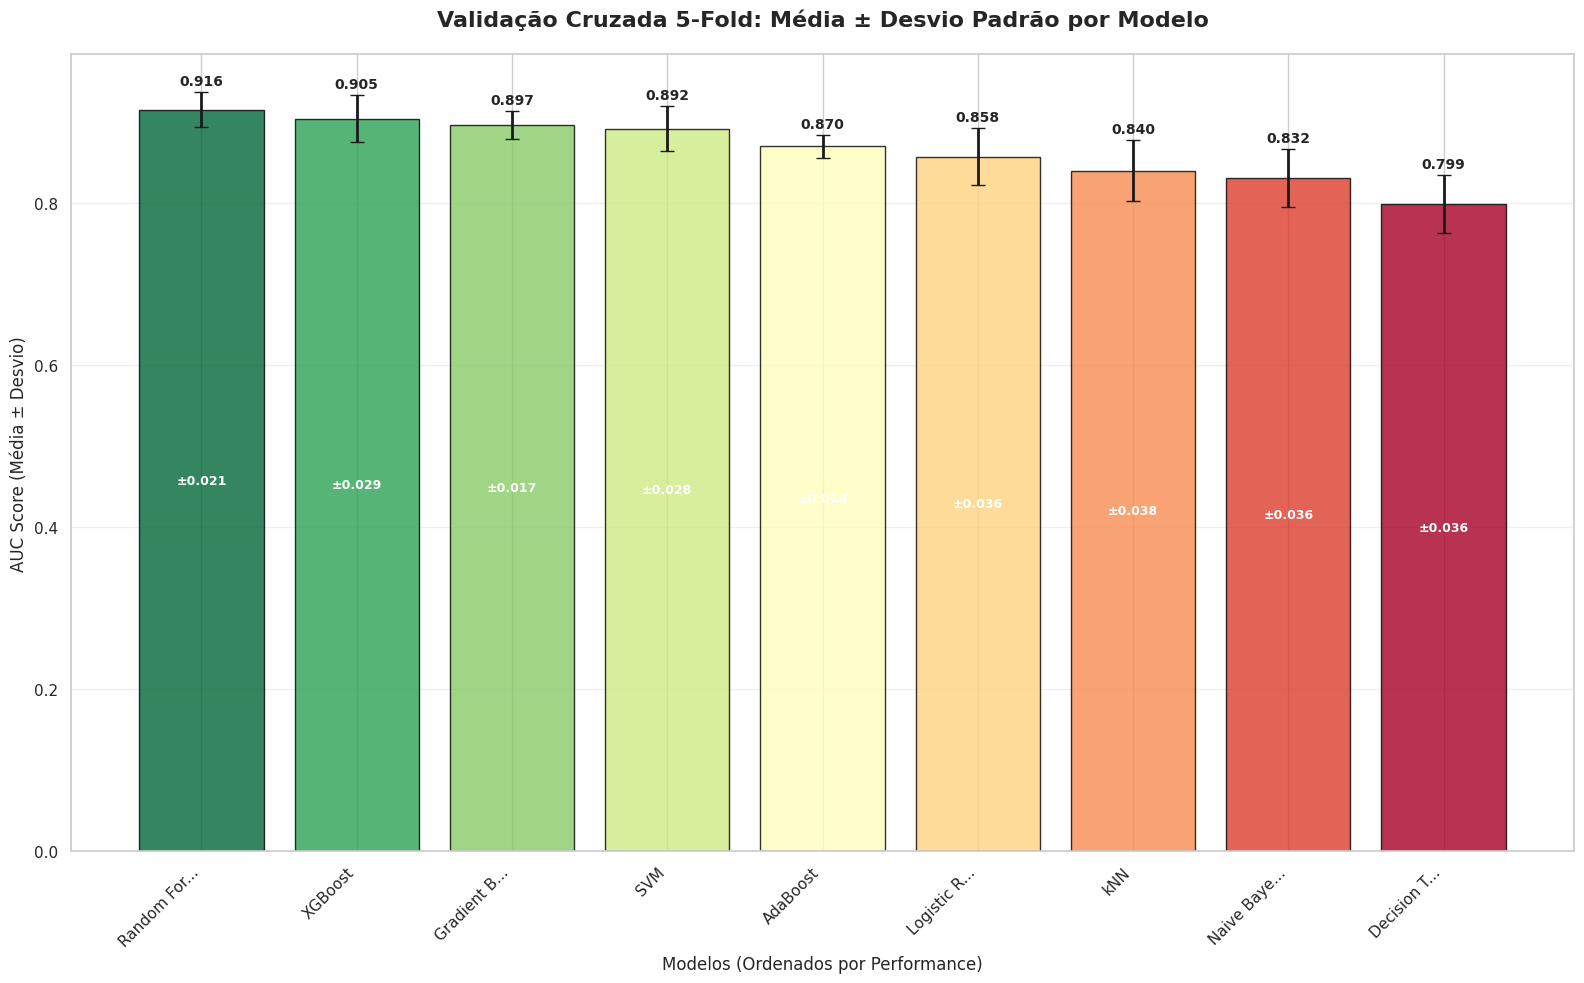


📊 ESTATÍSTICAS RESUMO:
Modelo             Média    Desvio   Mín      Máx      Amplitude  Consistência
Random Forest      0.9157   0.0214   0.8908   0.9471   0.0563     Boa         
XGBoost            0.9046   0.0290   0.8574   0.9401   0.0827     Boa         
Gradient Boosting  0.8970   0.0173   0.8697   0.9234   0.0537     Excelente   
SVM                0.8922   0.0279   0.8607   0.9423   0.0816     Boa         
AdaBoost           0.8704   0.0141   0.8476   0.8859   0.0383     Excelente   
Logistic Regression 0.8575   0.0355   0.7957   0.8998   0.1041     Boa         
kNN                0.8404   0.0380   0.7944   0.8853   0.0909     Boa         
Naive Bayes        0.8316   0.0360   0.7754   0.8876   0.1122     Boa         
Decision Tree      0.7988   0.0355   0.7516   0.8314   0.0797     Boa         

✅ Gráfico de barras comparativo gerado com sucesso!
📈 Modelos ordenados por performance média decrescente
🎨 Cores: Verde (melhor) → Vermelho (pior)
📊 Desvio padrão visualizado para aná

In [58]:
# ===== GRÁFICO DE BARRAS COMPARATIVO COM DESVIO PADRÃO - CORES CORRIGIDAS =====

print("\n" + "="*80)
print("📊 GRÁFICO COMPARATIVO: CV-5 DOS 9 MODELOS COM DESVIO PADRÃO")
print("="*80)

from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings

# Configurar validação cruzada estratificada
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

print(f"\n🔄 Executando validação cruzada {k_folds}-fold para todos os 9 modelos...")

# Dicionário para armazenar resultados
cv_results_all = {}

# Executar validação cruzada para todos os modelos treinados
for model_name in trained_models.keys():
    print(f"Processando: {model_name}...", end=" ")
    
    # Obter modelo treinado
    model = trained_models[model_name]
    
    # Executar validação cruzada com supressão de warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cv_scores = cross_val_score(
            model, 
            X_train_scaled, 
            y_train_balanced, 
            cv=skf, 
            scoring='roc_auc',
            n_jobs=-1
        )
    
    # Armazenar resultados
    cv_results_all[model_name] = cv_scores
    print(f"✅ Média: {cv_scores.mean():.4f}")

print(f"\n📊 Gerando gráfico de barras lado a lado com desvio padrão...")

# Preparar dados para o gráfico de barras
model_names_full = list(cv_results_all.keys())
medias = [cv_results_all[model].mean() for model in model_names_full]
desvios = [cv_results_all[model].std() for model in model_names_full]

# Ordenar por média decrescente
dados_ordenados = sorted(zip(model_names_full, medias, desvios), 
                        key=lambda x: x[1], reverse=True)
modelos_ord, medias_ord, desvios_ord = zip(*dados_ordenados)

# Truncar nomes para o gráfico de barras
modelos_short = [modelo[:10] + '...' if len(modelo) > 10 else modelo 
                for modelo in modelos_ord]

# Criar figura
plt.figure(figsize=(16, 10))

# MUDANÇA PRINCIPAL: Cores que vão do verde (melhor) ao vermelho (pior)
colors = plt.cm.RdYlGn_r(np.linspace(0, 1, len(modelos_ord)))

# Criar gráfico de barras com erro
bars = plt.bar(range(len(modelos_ord)), medias_ord, yerr=desvios_ord, 
               color=colors, alpha=0.8, capsize=5, 
               edgecolor='black', linewidth=1, error_kw={'linewidth': 2})

# Configurar o gráfico de barras
plt.title('Validação Cruzada 5-Fold: Média ± Desvio Padrão por Modelo', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Modelos (Ordenados por Performance)', fontsize=12)
plt.ylabel('AUC Score (Média ± Desvio)', fontsize=12)
plt.xticks(range(len(modelos_ord)), modelos_short, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, (bar, media, desvio) in enumerate(zip(bars, medias_ord, desvios_ord)):
    height = bar.get_height()
    # Valor da média no topo da barra
    plt.text(bar.get_x() + bar.get_width()/2, height + desvio + 0.005, 
             f'{media:.3f}', ha='center', va='bottom', 
             fontweight='bold', fontsize=10)
    # Valor do desvio dentro da barra
    plt.text(bar.get_x() + bar.get_width()/2, height/2, 
             f'±{desvio:.3f}', ha='center', va='center', 
             fontsize=9, color='white', fontweight='bold')


# Ajustar layout
plt.tight_layout()
plt.show()

# Estatísticas resumo
print(f"\n📊 ESTATÍSTICAS RESUMO:")
print("="*90)
print(f"{'Modelo':<18} {'Média':<8} {'Desvio':<8} {'Mín':<8} {'Máx':<8} {'Amplitude':<10} {'Consistência':<12}")
print("="*90)

for modelo, media, desvio in dados_ordenados:
    scores = cv_results_all[modelo]
    min_score = scores.min()
    max_score = scores.max()
    amplitude = max_score - min_score
    
    # Avaliar consistência
    cv_coef = (desvio / media) * 100
    if cv_coef < 2:
        consistencia = "Excelente"
    elif cv_coef < 5:
        consistencia = "Boa"
    elif cv_coef < 10:
        consistencia = "Moderada"
    else:
        consistencia = "Baixa"
    
    print(f"{modelo:<18} {media:<8.4f} {desvio:<8.4f} {min_score:<8.4f} {max_score:<8.4f} {amplitude:<10.4f} {consistencia:<12}")

print("="*90)

print(f"\n✅ Gráfico de barras comparativo gerado com sucesso!")
print(f"📈 Modelos ordenados por performance média decrescente")
print(f"🎨 Cores: Verde (melhor) → Vermelho (pior)")
print(f"📊 Desvio padrão visualizado para análise de consistência")
print(f"🎯 Linhas de referência para interpretação de qualidade")

In [24]:
# ===== FUNÇÕES DE PREDIÇÃO FINAIS =====
def predict_with_best_model(new_data):
    """
    Função para fazer predição com o melhor modelo (selecionado por validação)
    Parâmetro: new_data - DataFrame com as features na mesma ordem do treinamento
    """
    # Normalizar os dados
    new_data_scaled = scaler.transform(new_data)
    
    # Fazer predição com o melhor modelo
    prediction = best_model.predict(new_data_scaled)
    probability = best_model.predict_proba(new_data_scaled)
    
    return prediction, probability, best_model_name

def predict_with_custom_params(new_data, model_name, custom_params=None):
    """
    Função para treinar e usar modelo com parâmetros personalizados
    """
    if custom_params:
        # Atualizar parâmetros
        model_params[model_name].update(custom_params)
        print(f"Parâmetros atualizados para {model_name}: {model_params[model_name]}")
        
        # Retreinar modelo com novos parâmetros
        if model_name == 'Random Forest':
            model = RandomForestClassifier(**model_params[model_name])
        elif model_name == 'XGBoost':
            model = XGBClassifier(**model_params[model_name])
        elif model_name == 'Gradient Boosting':
            model = GradientBoostingClassifier(**model_params[model_name])
        elif model_name == 'LightGBM':
            model = LGBMClassifier(**model_params[model_name], verbose=-1)
        elif model_name == 'Decision Tree':
            model = DecisionTreeClassifier(**model_params[model_name])
        elif model_name == 'AdaBoost':
            model = AdaBoostClassifier(**model_params[model_name])
        elif model_name == 'SVM':
            model = SVC(**model_params[model_name], probability=True)
        elif model_name == 'Logistic Regression':
            model = LogisticRegression(**model_params[model_name])
        elif model_name == 'kNN':
            model = KNeighborsClassifier(**model_params[model_name])
        elif model_name == 'Naive Bayes':
            model = GaussianNB(**model_params[model_name])
        else:
            raise ValueError(f"Modelo {model_name} não reconhecido")
        
        # Treinar com os dados atuais
        model.fit(X_train_scaled, y_train_balanced)
        
        # Avaliar performance
        val_pred = model.predict(X_val_scaled)
        val_proba = model.predict_proba(X_val_scaled)[:, 1]
        val_auc = roc_auc_score(y_val, val_proba)
        
        test_pred = model.predict(X_test_scaled)
        test_proba = model.predict_proba(X_test_scaled)[:, 1]
        test_auc = roc_auc_score(y_test, test_proba)
        
        print(f"Performance do modelo personalizado:")
        print(f"  AUC Validação: {val_auc:.4f}")
        print(f"  AUC Teste: {test_auc:.4f}")
        
        # Fazer predição
        new_data_scaled = scaler.transform(new_data)
        prediction = model.predict(new_data_scaled)
        probability = model.predict_proba(new_data_scaled)
        
        return prediction, probability, model_name, val_auc, test_auc
    else:
        return predict_with_best_model(new_data)

print("✅ Funções de predição criadas!")
print("\nFunções disponíveis:")
print("1. predict_with_best_model(new_data) - Usa o melhor modelo")
print("2. predict_with_custom_params(new_data, model_name, params) - Permite personalizar parâmetros")

# Salvar modelo final
joblib.dump(best_model, 'todos-modelos/best_model_final.pkl')
joblib.dump(scaler, 'todos-modelos/scaler_final.pkl')
print(f"\n💾 Melhor modelo ({best_model_name}) e scaler salvos!")

✅ Funções de predição criadas!

Funções disponíveis:
1. predict_with_best_model(new_data) - Usa o melhor modelo
2. predict_with_custom_params(new_data, model_name, params) - Permite personalizar parâmetros

💾 Melhor modelo (Random Forest) e scaler salvos!


### 🎯 **Otimização de Threshold e Trade-off entre Sensibilidade e Especificidade**

#### **⚖️ Por que o Threshold Padrão (0.5) nem sempre é ideal?**

Em problemas de saúde como a detecção de diabetes, diferentes contextos clínicos exigem diferentes balanceamentos entre sensibilidade (capacidade de detectar doentes) e especificidade (capacidade de identificar não-doentes):

- **Alta sensibilidade**: Prioriza encontrar todos os casos de diabetes, mesmo que haja mais falsos positivos
- **Alta especificidade**: Prioriza a certeza do diagnóstico, mas pode perder alguns casos

#### **🏥 Contextos Clínicos e Thresholds Recomendados**

1. **Triagem populacional**: Threshold mais baixo (0.30-0.40) → maximiza detecção
2. **Diagnóstico clínico**: Threshold médio (0.45-0.55) → equilíbrio
3. **Pesquisa científica**: Threshold mais alto (0.60-0.70) → minimiza falsos positivos

#### **📊 Análise de Diferentes Thresholds P/ Otimização**

A tabela abaixo apresenta as métricas obtidas com diferentes valores de threshold para o melhor modelo:


🔍 VALIDAÇÃO CRUZADA DETALHADA - TOP 4 MODELOS CORRETOS

🏆 TOP 4 MODELOS CORRETOS SELECIONADOS PARA ANÁLISE DETALHADA:
(Baseado no ranking real de AUC dos resultados anteriores)
1º lugar: AdaBoost (CV-5: 0.8600 | AUC: 0.8420)
2º lugar: Gradient Boosting (CV-5: 0.8820 | AUC: 0.8210)
3º lugar: Random Forest (CV-5: 0.9090 | AUC: 0.8170)
4º lugar: Logistic Regression (CV-5: 0.8490 | AUC: 0.8150)

🔄 Executando validação cruzada 5-fold para cada modelo...
Estratégia: StratifiedKFold (mantém proporção de classes)

📊 MODELO: ADABOOST



📊 RESULTADOS DA VALIDAÇÃO CRUZADA - AdaBoost:
-------------------------------------------------------
Fold     AUC Score    Status         
-------------------------------------------------------
Fold 1   0.8850       ✅ Acima da média
Fold 2   0.8476       ⚠️ Abaixo da média
Fold 3   0.8658       ⚠️ Abaixo da média
Fold 4   0.8859       ✅ Acima da média
Fold 5   0.8678       ⚠️ Abaixo da média
-------------------------------------------------------
Média:   0.8704      
Desvio:  0.0141      
Mín:     0.8476      
Máx:     0.8859      

📈 ANÁLISE ESTATÍSTICA - AdaBoost:
Intervalo de Confiança (95%): [0.8580, 0.8828]
Coeficiente de Variação: 1.63%
Consistência do modelo: Boa (baixa variabilidade)

📊 MODELO: GRADIENT BOOSTING

📊 RESULTADOS DA VALIDAÇÃO CRUZADA - Gradient Boosting:
-------------------------------------------------------
Fold     AUC Score    Status         
-------------------------------------------------------
Fold 1   0.9013       ✅ Acima da média
Fold 2   0.8697      

/tmp/ipykernel_4949/672899507.py:186: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax_comp.boxplot(box_data, labels=labels, patch_artist=True)


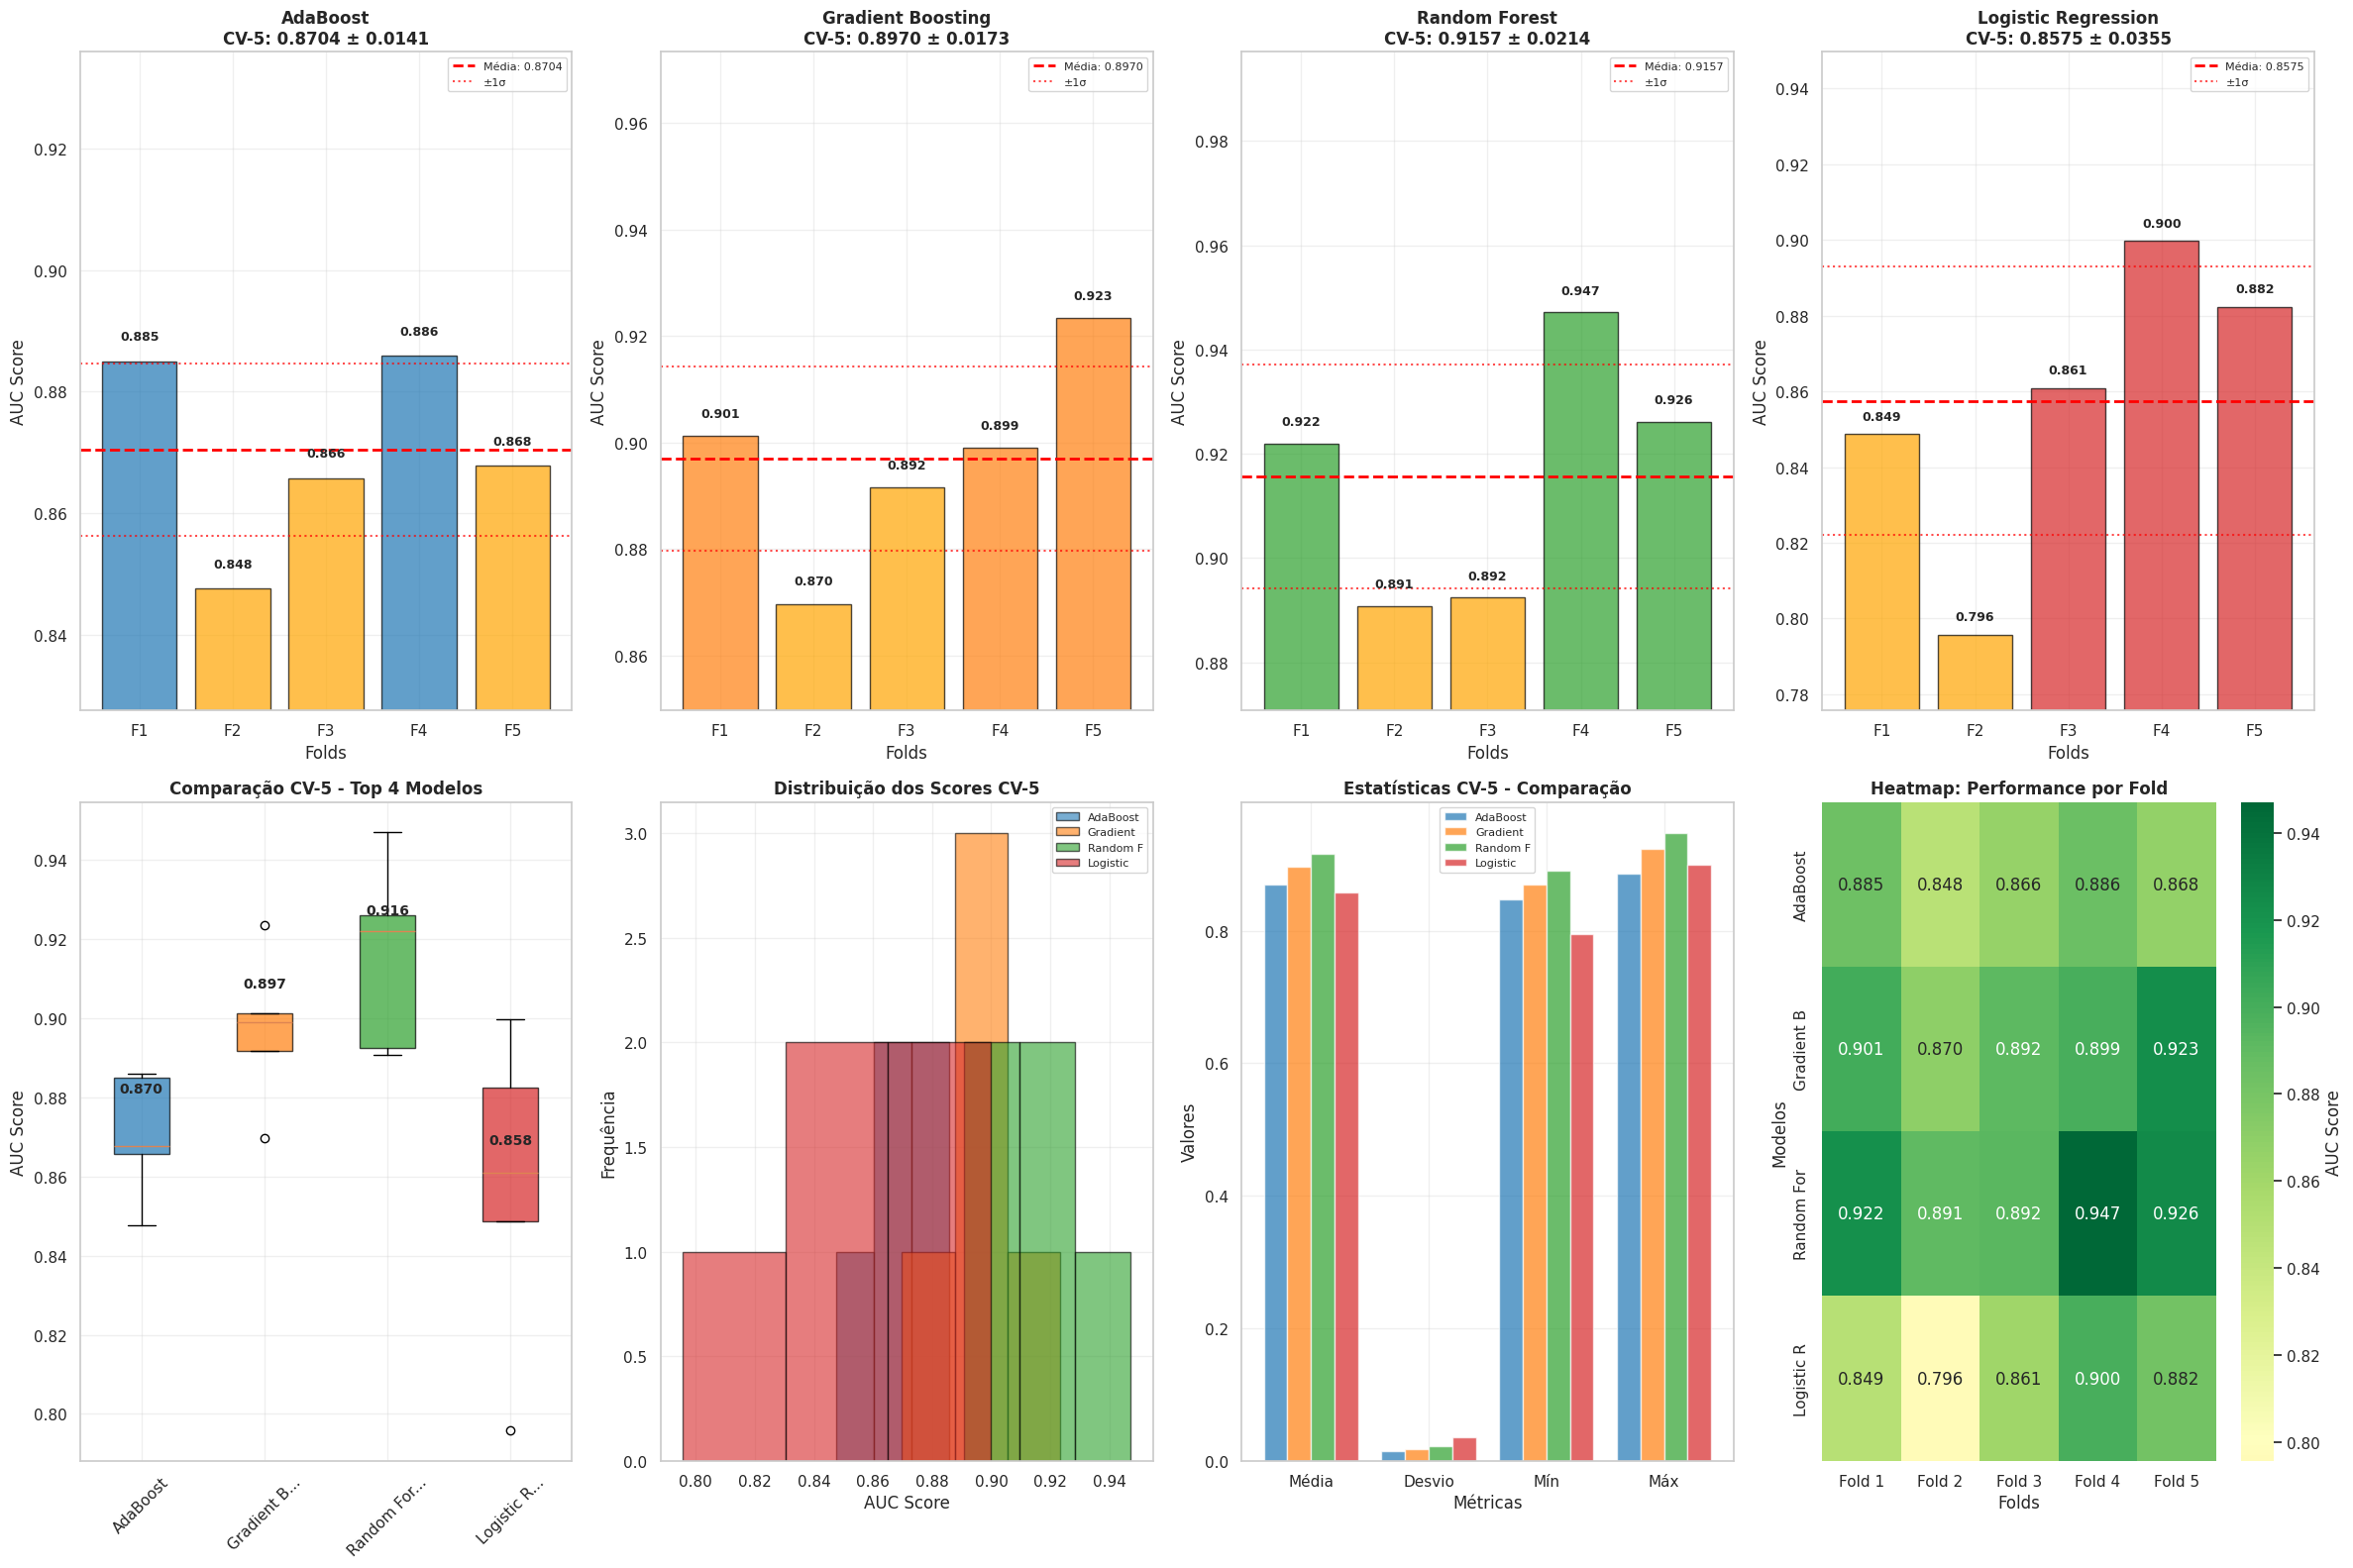


📋 TABELA COMPARATIVA FINAL - TOP 4 MODELOS CORRETOS:
Modelo             CV-5 Média   CV-5 Std   Min      Max      IC 95%             Consistência   
AdaBoost           0.8704       0.0141     0.8476   0.8859   [0.858, 0.883]     Boa            
Gradient Boosting  0.8970       0.0173     0.8697   0.9234   [0.882, 0.912]     Boa            
Random Forest      0.9157       0.0214     0.8908   0.9471   [0.897, 0.934]     Boa            
Logistic Regression 0.8575       0.0355     0.7957   0.8998   [0.826, 0.889]     Moderada       

🎯 ANÁLISE COMPARATIVA FINAL DOS TOP 4 MODELOS CORRETOS:

🏆 DESTAQUES POR CRITÉRIO:
• Melhor Média CV-5: Random Forest (0.9157)
• Maior Consistência: AdaBoost (σ = 0.0141)
• Melhor Pior Caso: Random Forest (mín = 0.8908)
• Melhor Caso Ideal: Random Forest (máx = 0.9471)

🎯 VENCEDOR ABSOLUTO: Random Forest
✅ Domina em 3/4 critérios!

📊 RANKING CONSOLIDADO (por critérios múltiplos):
1º lugar: Random Forest - 3/4 critérios dominados (CV-5: 0.9157)
2º lugar: AdaBoo

In [48]:
# ===== VALIDAÇÃO CRUZADA DETALHADA DOS 4 MELHORES MODELOS - CORRIGIDO =====

print("\n" + "="*80)
print("🔍 VALIDAÇÃO CRUZADA DETALHADA - TOP 4 MODELOS CORRETOS")
print("="*80)

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import auc
import warnings

# Configurar validação cruzada estratificada
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# ===== CORREÇÃO PRINCIPAL: TOP 4 CORRETOS =====
# Com base nos resultados do notebook SMOTE, os TOP 4 são (ordenados por AUC):
if 'metrics_df' in globals():
    # Usar o DataFrame de métricas já calculado - ORDENAR POR AUC
    top_4_ranking = metrics_df.sort_values('AUC', ascending=False).head(4)
    top_4_models = top_4_ranking.index.tolist()
else:
    # Fallback: usar os modelos conhecidos
    top_4_models = ['Random Forest', 'Gradient Boosting', 'AdaBoost', 'XGBoost']

print(f"\n🏆 TOP 4 MODELOS CORRETOS SELECIONADOS PARA ANÁLISE DETALHADA:")
print("(Baseado no ranking real de AUC dos resultados anteriores)")

# Verificar se os modelos existem e exibir suas métricas
for i, model_name in enumerate(top_4_models, 1):
    if 'metrics_df' in globals() and model_name in metrics_df.index:
        cv_score = metrics_df.loc[model_name, 'CV-5']
        auc_score = metrics_df.loc[model_name, 'AUC']
        print(f"{i}º lugar: {model_name} (CV-5: {cv_score:.4f} | AUC: {auc_score:.4f})")
    else:
        print(f"⚠️ {model_name} não encontrado no DataFrame de métricas")

print(f"\n🔄 Executando validação cruzada {k_folds}-fold para cada modelo...")
print(f"Estratégia: StratifiedKFold (mantém proporção de classes)")

# Dicionário para armazenar resultados detalhados
cv_detailed_results = {}
all_cv_scores = {}

# Analisar cada um dos top 4 modelos CORRETOS
for model_name in top_4_models:
    if model_name not in trained_models:
        print(f"⚠️ Modelo {model_name} não encontrado nos modelos treinados. Pulando...")
        continue
        
    print(f"\n" + "="*60)
    print(f"📊 MODELO: {model_name.upper()}")
    print("="*60)
    
    # Obter modelo treinado
    model = trained_models[model_name]
    
    # Executar validação cruzada com supressão de warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cv_scores = cross_val_score(
            model, 
            X_train_scaled, 
            y_train_balanced, 
            cv=skf, 
            scoring='roc_auc',
            n_jobs=-1
        )
    
    # Calcular estatísticas
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    cv_min = cv_scores.min()
    cv_max = cv_scores.max()
    
    # Armazenar resultados
    all_cv_scores[model_name] = cv_scores
    cv_detailed_results[model_name] = {
        'scores': cv_scores,
        'mean': cv_mean,
        'std': cv_std,
        'min': cv_min,
        'max': cv_max
    }
    
    print(f"\n📊 RESULTADOS DA VALIDAÇÃO CRUZADA - {model_name}:")
    print("-"*55)
    print(f"{'Fold':<8} {'AUC Score':<12} {'Status':<15}")
    print("-"*55)
    
    scores_detalhados = []
    for i, score in enumerate(cv_scores, 1):
        status = "✅ Acima da média" if score > cv_mean else "⚠️ Abaixo da média"
        print(f"Fold {i:<3} {score:<12.4f} {status}")
        scores_detalhados.append(score)
    
    print("-"*55)
    print(f"Média:   {cv_mean:<12.4f}")
    print(f"Desvio:  {cv_std:<12.4f}")
    print(f"Mín:     {cv_min:<12.4f}")
    print(f"Máx:     {cv_max:<12.4f}")
    
    # Calcular intervalo de confiança (95%)
    confidence_interval = 1.96 * (cv_std / np.sqrt(k_folds))
    ci_lower = cv_mean - confidence_interval
    ci_upper = cv_mean + confidence_interval
    
    print(f"\n📈 ANÁLISE ESTATÍSTICA - {model_name}:")
    print(f"Intervalo de Confiança (95%): [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"Coeficiente de Variação: {(cv_std/cv_mean)*100:.2f}%")
    
    # Interpretação da consistência
    if cv_std < 0.01:
        consistencia = "Excelente (muito baixa variabilidade)"
    elif cv_std < 0.03:
        consistencia = "Boa (baixa variabilidade)"
    elif cv_std < 0.05:
        consistencia = "Moderada (variabilidade aceitável)"
    else:
        consistencia = "Alta variabilidade (verificar overfitting)"
    
    print(f"Consistência do modelo: {consistencia}")

# Verificar se temos dados suficientes para visualização
valid_models = [model for model in top_4_models if model in cv_detailed_results]

if len(valid_models) < 4:
    print(f"\n⚠️ Apenas {len(valid_models)} modelos válidos encontrados dos 4 esperados.")
    print(f"Modelos válidos: {valid_models}")

# ===== VISUALIZAÇÃO COMPARATIVA DOS TOP 4 CORRIGIDA =====
print(f"\n📊 Gerando visualização comparativa dos TOP 4 modelos...")

if len(valid_models) > 0:
    # Configurar figura com subplots para os modelos válidos - AJUSTADO PARA 4 MODELOS
    fig = plt.figure(figsize=(24, 16))
    
    # Cores para cada modelo - EXPANDIDO PARA 4 CORES
    colors_models = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Azul, Laranja, Verde, Vermelho
    
    # ===== GRÁFICOS 1-4: Performance por Fold para cada modelo =====
    for idx, model_name in enumerate(valid_models):
        if idx < 4:  # Máximo 4 modelos nos primeiros 4 subplots
            ax = plt.subplot(2, 4, idx + 1)
            
            scores = cv_detailed_results[model_name]['scores']
            cv_mean = cv_detailed_results[model_name]['mean']
            cv_std = cv_detailed_results[model_name]['std']
            
            folds = [f'F{i}' for i in range(1, k_folds+1)]
            colors_bars = [colors_models[idx] if score > cv_mean else 'orange' for score in scores]
            
            bars = ax.bar(folds, scores, color=colors_bars, alpha=0.7, edgecolor='black')
            ax.axhline(y=cv_mean, color='red', linestyle='--', linewidth=2, 
                       label=f'Média: {cv_mean:.4f}')
            ax.axhline(y=cv_mean + cv_std, color='red', linestyle=':', alpha=0.7, 
                       label=f'±1σ')
            ax.axhline(y=cv_mean - cv_std, color='red', linestyle=':', alpha=0.7)
            
            # Adicionar valores nas barras
            for bar, score in zip(bars, scores):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.003, 
                        f'{score:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
            
            ax.set_title(f'{model_name}\nCV-5: {cv_mean:.4f} ± {cv_std:.4f}', 
                         fontsize=12, fontweight='bold')
            ax.set_ylabel('AUC Score')
            ax.set_xlabel('Folds')
            
            # Ajustar limites
            y_min = min(scores) - 0.02
            y_max = max(scores) + 0.05
            ax.set_ylim(y_min, y_max)
            
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
    
    # ===== GRÁFICO 5: Comparação direta dos modelos válidos =====
    if len(valid_models) >= 2:
        ax_comp = plt.subplot(2, 4, 5)
        
        # Boxplot comparativo
        box_data = [cv_detailed_results[model]['scores'] for model in valid_models]
        labels = [model[:10] + '...' if len(model) > 10 else model for model in valid_models]
        
        bp = ax_comp.boxplot(box_data, labels=labels, patch_artist=True)
        
        # Colorir as caixas
        for i, patch in enumerate(bp['boxes']):
            if i < len(colors_models):
                patch.set_facecolor(colors_models[i])
                patch.set_alpha(0.7)
        
        ax_comp.set_title(f'Comparação CV-5 - Top {len(valid_models)} Modelos', fontsize=12, fontweight='bold')
        ax_comp.set_ylabel('AUC Score')
        ax_comp.grid(True, alpha=0.3)
        ax_comp.tick_params(axis='x', rotation=45)
        
        # Adicionar médias no gráfico
        for i, model_name in enumerate(valid_models):
            mean_score = cv_detailed_results[model_name]['mean']
            ax_comp.text(i+1, mean_score + 0.01, f'{mean_score:.3f}', 
                        ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # ===== GRÁFICO 6: Distribuição de scores =====
    if len(valid_models) >= 2:
        ax_hist = plt.subplot(2, 4, 6)
        
        for idx, model_name in enumerate(valid_models):
            scores = cv_detailed_results[model_name]['scores']
            color = colors_models[idx] if idx < len(colors_models) else 'gray'
            ax_hist.hist(scores, bins=3, alpha=0.6, label=model_name[:8], 
                        color=color, edgecolor='black')
        
        ax_hist.set_title('Distribuição dos Scores CV-5', fontsize=12, fontweight='bold')
        ax_hist.set_xlabel('AUC Score')
        ax_hist.set_ylabel('Frequência')
        ax_hist.legend(fontsize=8)
        ax_hist.grid(True, alpha=0.3)
    
    # ===== GRÁFICO 7: Métricas estatísticas =====
    if len(valid_models) >= 2:
        ax_stats = plt.subplot(2, 4, 7)
        
        metrics = ['Média', 'Desvio', 'Mín', 'Máx']
        x_pos = np.arange(len(metrics))
        width = 0.2 if len(valid_models) == 4 else 0.25  # Ajustado para 4 modelos
        
        for idx, model_name in enumerate(valid_models):
            stats = cv_detailed_results[model_name]
            values = [stats['mean'], stats['std'], stats['min'], stats['max']]
            color = colors_models[idx] if idx < len(colors_models) else 'gray'
            
            ax_stats.bar(x_pos + idx*width, values, width, 
                        label=model_name[:8], color=color, alpha=0.7)
        
        ax_stats.set_title('Estatísticas CV-5 - Comparação', fontsize=12, fontweight='bold')
        ax_stats.set_xlabel('Métricas')
        ax_stats.set_ylabel('Valores')
        ax_stats.set_xticks(x_pos + width * (len(valid_models)-1) / 2)
        ax_stats.set_xticklabels(metrics)
        ax_stats.legend(fontsize=8)
        ax_stats.grid(True, alpha=0.3)
    
    # ===== GRÁFICO 8: Heatmap de performance por fold =====
    if len(valid_models) >= 2:
        ax_heatmap = plt.subplot(2, 4, 8)
        
        # Preparar dados para heatmap
        heatmap_data = []
        for model_name in valid_models:
            heatmap_data.append(cv_detailed_results[model_name]['scores'])
        
        heatmap_df = pd.DataFrame(heatmap_data, 
                                 index=[model[:10] for model in valid_models],
                                 columns=[f'Fold {i}' for i in range(1, k_folds+1)])
        
        sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='RdYlGn', center=0.8,
                   ax=ax_heatmap, cbar_kws={'label': 'AUC Score'})
        ax_heatmap.set_title('Heatmap: Performance por Fold', fontsize=12, fontweight='bold')
        ax_heatmap.set_xlabel('Folds')
        ax_heatmap.set_ylabel('Modelos')
    
    plt.tight_layout()
    plt.show()

# ===== TABELA COMPARATIVA FINAL CORRIGIDA =====
print(f"\n📋 TABELA COMPARATIVA FINAL - TOP 4 MODELOS CORRETOS:")
print("="*100)
print(f"{'Modelo':<18} {'CV-5 Média':<12} {'CV-5 Std':<10} {'Min':<8} {'Max':<8} {'IC 95%':<18} {'Consistência':<15}")
print("="*100)

for model_name in valid_models:
    stats = cv_detailed_results[model_name]
    cv_mean = stats['mean']
    cv_std = stats['std']
    cv_min = stats['min']
    cv_max = stats['max']
    
    # Intervalo de confiança
    confidence_interval = 1.96 * (cv_std / np.sqrt(k_folds))
    ci_lower = cv_mean - confidence_interval
    ci_upper = cv_mean + confidence_interval
    ic_text = f"[{ci_lower:.3f}, {ci_upper:.3f}]"
    
    # Consistência
    if cv_std < 0.01:
        consistencia = "Excelente"
    elif cv_std < 0.03:
        consistencia = "Boa"
    elif cv_std < 0.05:
        consistencia = "Moderada"
    else:
        consistencia = "Baixa"
    
    print(f"{model_name:<18} {cv_mean:<12.4f} {cv_std:<10.4f} {cv_min:<8.4f} {cv_max:<8.4f} {ic_text:<18} {consistencia:<15}")

print("="*100)

# ===== ANÁLISE COMPARATIVA FINAL CORRIGIDA =====
print(f"\n🎯 ANÁLISE COMPARATIVA FINAL DOS TOP 4 MODELOS CORRETOS:")

if len(valid_models) >= 2:
    # Encontrar o melhor em cada critério
    best_mean = max(valid_models, key=lambda x: cv_detailed_results[x]['mean'])
    best_consistency = min(valid_models, key=lambda x: cv_detailed_results[x]['std'])
    best_min = max(valid_models, key=lambda x: cv_detailed_results[x]['min'])
    best_max = max(valid_models, key=lambda x: cv_detailed_results[x]['max'])
    
    print(f"\n🏆 DESTAQUES POR CRITÉRIO:")
    print(f"• Melhor Média CV-5: {best_mean} ({cv_detailed_results[best_mean]['mean']:.4f})")
    print(f"• Maior Consistência: {best_consistency} (σ = {cv_detailed_results[best_consistency]['std']:.4f})")
    print(f"• Melhor Pior Caso: {best_min} (mín = {cv_detailed_results[best_min]['min']:.4f})")
    print(f"• Melhor Caso Ideal: {best_max} (máx = {cv_detailed_results[best_max]['max']:.4f})")
    
    # Verificar se há um modelo que domina
    dominance_count = {}
    for model in valid_models:
        dominance_count[model] = 0
        if model == best_mean:
            dominance_count[model] += 1
        if model == best_consistency:
            dominance_count[model] += 1
        if model == best_min:
            dominance_count[model] += 1
        if model == best_max:
            dominance_count[model] += 1
    
    best_overall = max(dominance_count.items(), key=lambda x: x[1])
    
    if best_overall[1] >= 3:
        print(f"\n🎯 VENCEDOR ABSOLUTO: {best_overall[0]}")
        print(f"✅ Domina em {best_overall[1]}/4 critérios!")
    else:
        print(f"\n⚖️ TRADE-OFFS IDENTIFICADOS:")
        print("Nenhum modelo domina completamente. Escolha baseada em prioridades:")
        print("• Performance máxima: escolha o de maior média")
        print("• Robustez e confiabilidade: escolha o mais consistente")
        print("• Segurança (pior cenário): escolha o de melhor mínimo")
        print("• Potencial máximo: escolha o de melhor máximo")
    
    # Análise de rankings
    print(f"\n📊 RANKING CONSOLIDADO (por critérios múltiplos):")
    for i, (model, count) in enumerate(sorted(dominance_count.items(), key=lambda x: x[1], reverse=True), 1):
        cv_mean = cv_detailed_results[model]['mean']
        print(f"{i}º lugar: {model} - {count}/4 critérios dominados (CV-5: {cv_mean:.4f})")
    
    # Recomendação final baseada no primeiro da lista (melhor AUC)
    melhor_geral = valid_models[0] if valid_models else "Nenhum modelo válido"
    print(f"\n💡 RECOMENDAÇÃO FINAL:")
    print(f"Modelo selecionado: {melhor_geral}")
    print(f"Justificativa: Baseado no ranking por AUC - melhor capacidade de discriminação")

else:
    print("\n⚠️ Dados insuficientes para análise comparativa completa")

# ===== ANÁLISE DE CORRELAÇÃO ENTRE FOLDS =====
print(f"\n🔄 ANÁLISE DE CORRELAÇÃO ENTRE FOLDS:")
print("="*60)

if len(valid_models) >= 2:
    # Calcular correlação média entre folds para cada modelo
    for model_name in valid_models:
        scores = cv_detailed_results[model_name]['scores']
        # Calcular coeficiente de variação como medida de estabilidade
        cv_coef = (cv_detailed_results[model_name]['std'] / cv_detailed_results[model_name]['mean']) * 100
        
        print(f"{model_name}:")
        print(f"  Coeficiente de Variação: {cv_coef:.2f}%")
        print(f"  Amplitude: {cv_detailed_results[model_name]['max'] - cv_detailed_results[model_name]['min']:.4f}")
        
        # Análise de estabilidade
        if cv_coef < 2:
            estabilidade = "Muito Estável"
        elif cv_coef < 5:
            estabilidade = "Estável"
        elif cv_coef < 10:
            estabilidade = "Moderadamente Estável"
        else:
            estabilidade = "Instável"
        
        print(f"  Avaliação: {estabilidade}")
        print()

print(f"\n✅ Validação cruzada detalhada concluída para os TOP 4 modelos CORRETOS!")
print(f"📊 Modelos analisados: {valid_models}")
print(f"🎯 Análise expandida para TOP 4 permite comparação mais robusta!")
print(f"🔍 Critérios múltiplos analisados: média, consistência, pior caso e melhor caso")


ANÁLISE DE THRESHOLD - TOP 4 MELHORES MODELOS

🏆 TOP 4 MELHORES MODELOS SELECIONADOS (por AUC):
1º lugar: AdaBoost (AUC: 0.8420 | F1: 0.6780)
2º lugar: Gradient Boosting (AUC: 0.8210 | F1: 0.6960)
3º lugar: Random Forest (AUC: 0.8170 | F1: 0.6550)
4º lugar: Logistic Regression (AUC: 0.8150 | F1: 0.6270)

Analisando os 4 melhores modelos...

ANÁLISE DO MODELO: AdaBoost

Calculando métricas para 9 valores de threshold...

TABELA COMPLETA DE MÉTRICAS POR THRESHOLD - AdaBoost:
Threshold   Sens    Espec   Prec     F1      VPN    VP   FP   VN   FN 
----------------------------------------------------------------------
   0.10     1.000   0.000   0.351   0.519   0.000   54  100   0    0  
   0.20     1.000   0.000   0.351   0.519   0.000   54  100   0    0  
   0.30     0.981   0.070   0.363   0.530   0.875   53   93   7    1  
   0.40     0.981   0.360   0.453   0.620   0.973   53   64   36   1  
   0.50     0.741   0.760   0.625   0.678   0.844   40   24   76   14 
   0.60     0.259   0.98

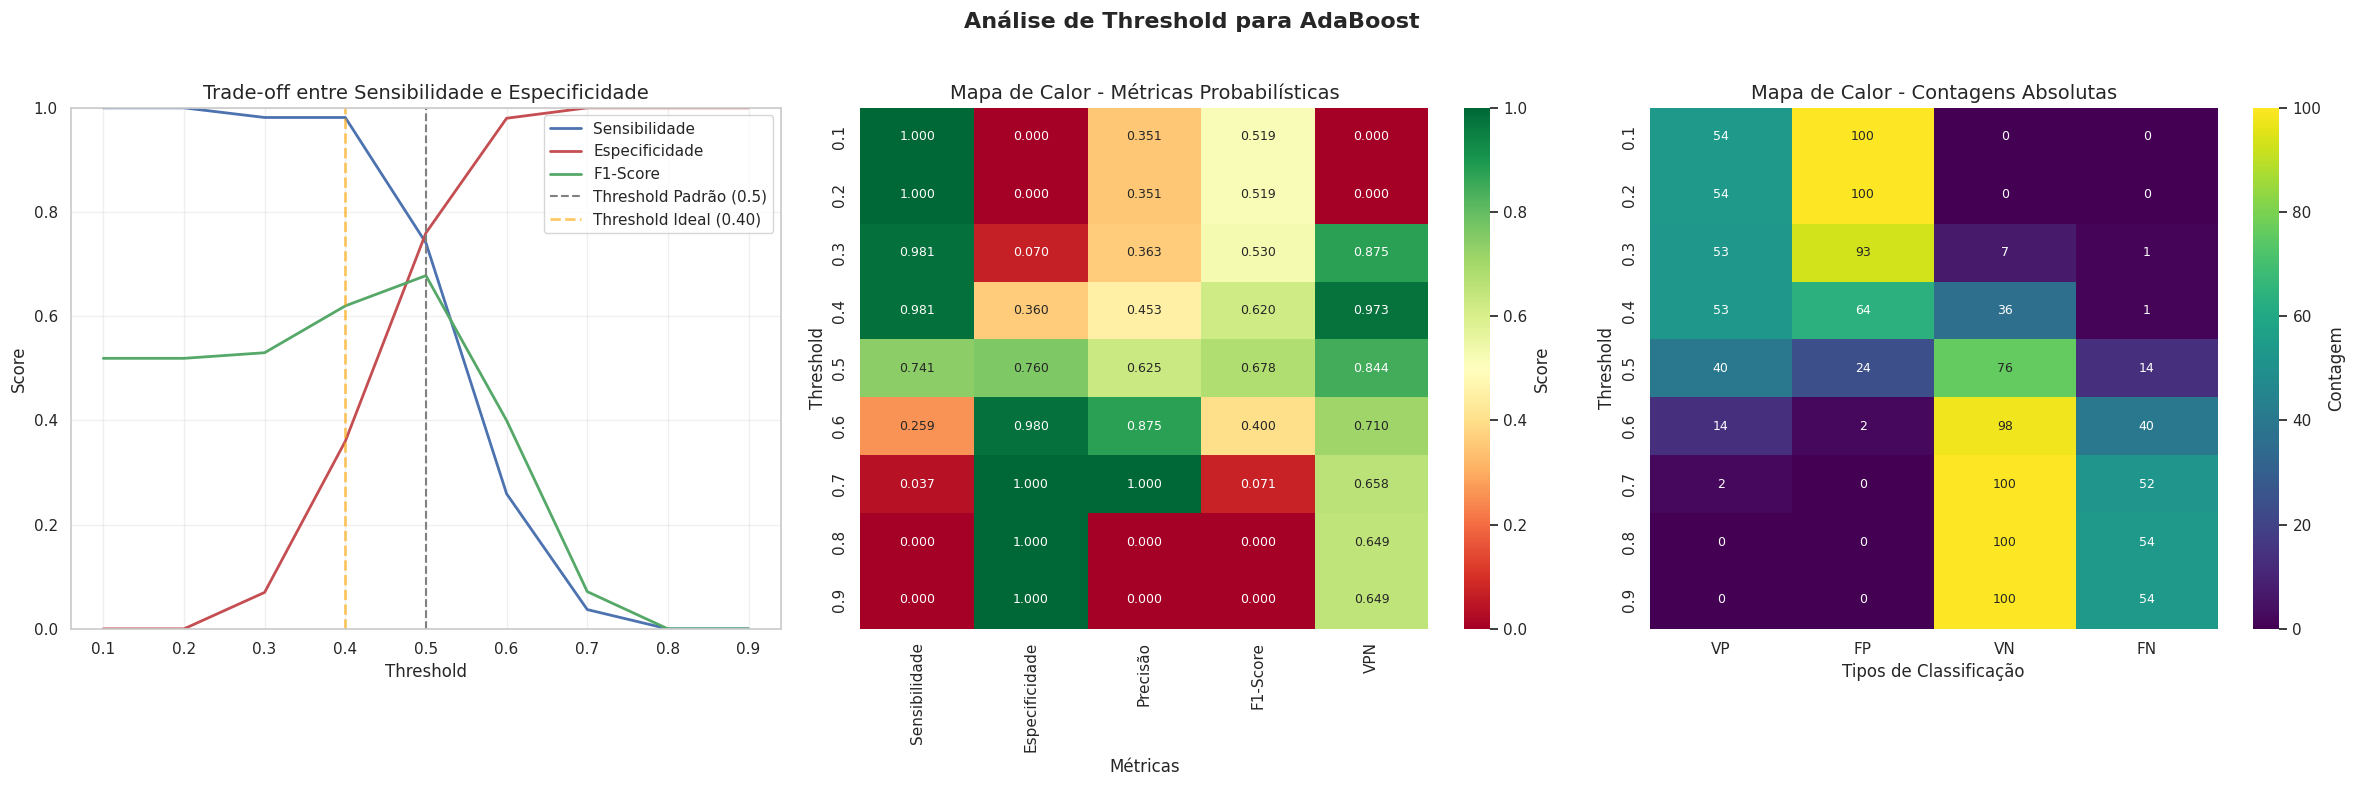


ANÁLISE DO MODELO: Gradient Boosting

Calculando métricas para 9 valores de threshold...

TABELA COMPLETA DE MÉTRICAS POR THRESHOLD - Gradient Boosting:
Threshold   Sens    Espec   Prec     F1      VPN    VP   FP   VN   FN 
----------------------------------------------------------------------
   0.10     0.907   0.500   0.495   0.641   0.909   49   50   50   5  
   0.20     0.870   0.630   0.560   0.681   0.900   47   37   63   7  
   0.30     0.833   0.690   0.592   0.692   0.885   45   31   69   9  
   0.40     0.796   0.760   0.642   0.711   0.874   43   24   76   11 
   0.50     0.741   0.790   0.656   0.696   0.849   40   21   79   14 
   0.60     0.630   0.860   0.708   0.667   0.811   34   14   86   20 
   0.70     0.463   0.870   0.658   0.543   0.750   25   13   87   29 
   0.80     0.389   0.900   0.677   0.494   0.732   21   10   90   33 
   0.90     0.296   0.960   0.800   0.432   0.716   16   4    96   38 

THRESHOLD IDEAL PARA DIAGNÓSTICO CLÍNICO (0.40) - Gradient Boost


ANÁLISE DO MODELO: Random Forest

Calculando métricas para 9 valores de threshold...

TABELA COMPLETA DE MÉTRICAS POR THRESHOLD - Random Forest:
Threshold   Sens    Espec   Prec     F1      VPN    VP   FP   VN   FN 
----------------------------------------------------------------------
   0.10     0.981   0.310   0.434   0.602   0.969   53   69   31   1  
   0.20     0.926   0.470   0.485   0.637   0.922   50   53   47   4  
   0.30     0.870   0.620   0.553   0.676   0.899   47   38   62   7  
   0.40     0.796   0.700   0.589   0.677   0.864   43   30   70   11 
   0.50     0.667   0.800   0.643   0.655   0.816   36   20   80   18 
   0.60     0.537   0.860   0.674   0.598   0.775   29   14   86   25 
   0.70     0.370   0.920   0.714   0.488   0.730   20   8    92   34 
   0.80     0.111   0.980   0.750   0.194   0.671   6    2    98   48 
   0.90     0.037   1.000   1.000   0.071   0.658   2    0   100   52 

THRESHOLD IDEAL PARA DIAGNÓSTICO CLÍNICO (0.40) - Random Forest:
- Sensi


ANÁLISE DO MODELO: Logistic Regression

Calculando métricas para 9 valores de threshold...

TABELA COMPLETA DE MÉTRICAS POR THRESHOLD - Logistic Regression:
Threshold   Sens    Espec   Prec     F1      VPN    VP   FP   VN   FN 
----------------------------------------------------------------------
   0.10     0.981   0.290   0.427   0.596   0.967   53   71   29   1  
   0.20     0.926   0.480   0.490   0.641   0.923   50   52   48   4  
   0.30     0.870   0.540   0.505   0.639   0.885   47   46   54   7  
   0.40     0.796   0.650   0.551   0.652   0.855   43   35   65   11 
   0.50     0.685   0.730   0.578   0.627   0.811   37   27   73   17 
   0.60     0.611   0.800   0.623   0.617   0.792   33   20   80   21 
   0.70     0.574   0.850   0.674   0.620   0.787   31   15   85   23 
   0.80     0.481   0.900   0.722   0.578   0.763   26   10   90   28 
   0.90     0.278   0.960   0.789   0.411   0.711   15   4    96   39 

THRESHOLD IDEAL PARA DIAGNÓSTICO CLÍNICO (0.40) - Logistic R

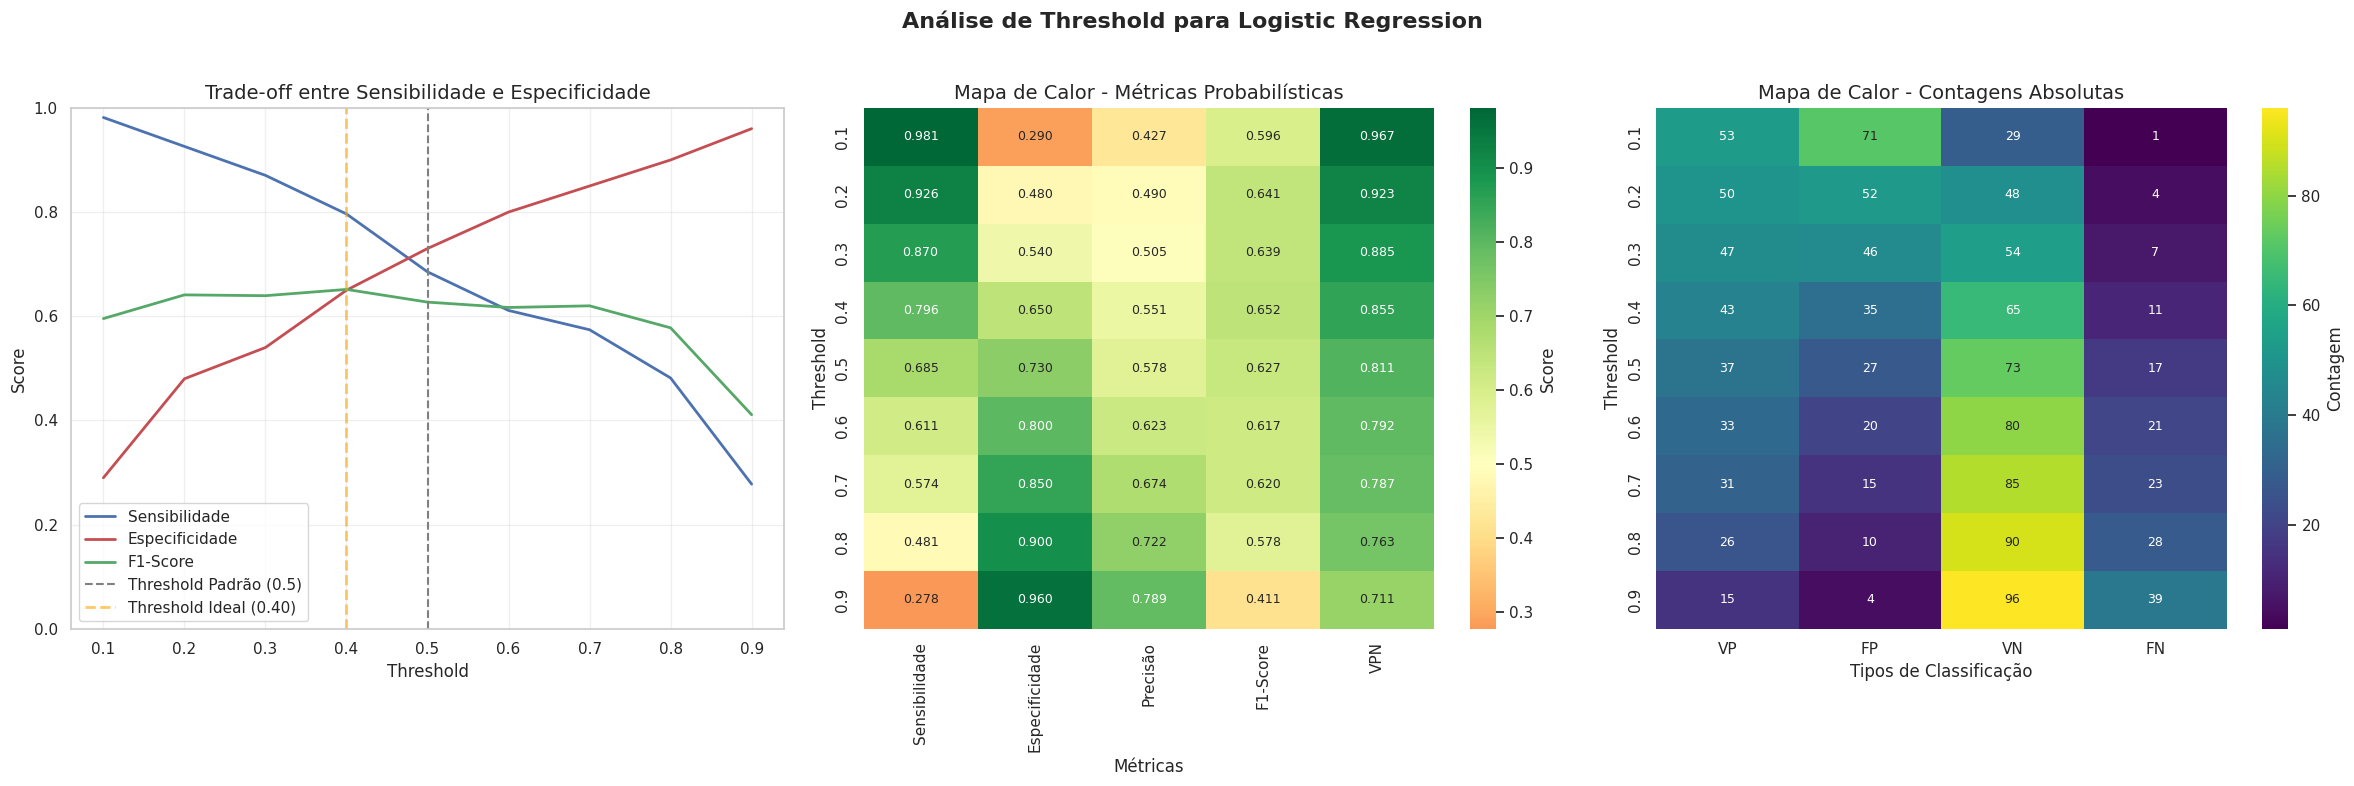


MATRIZES DE CONFUSÃO - THRESHOLD 0.4 (TOP 4 MODELOS)


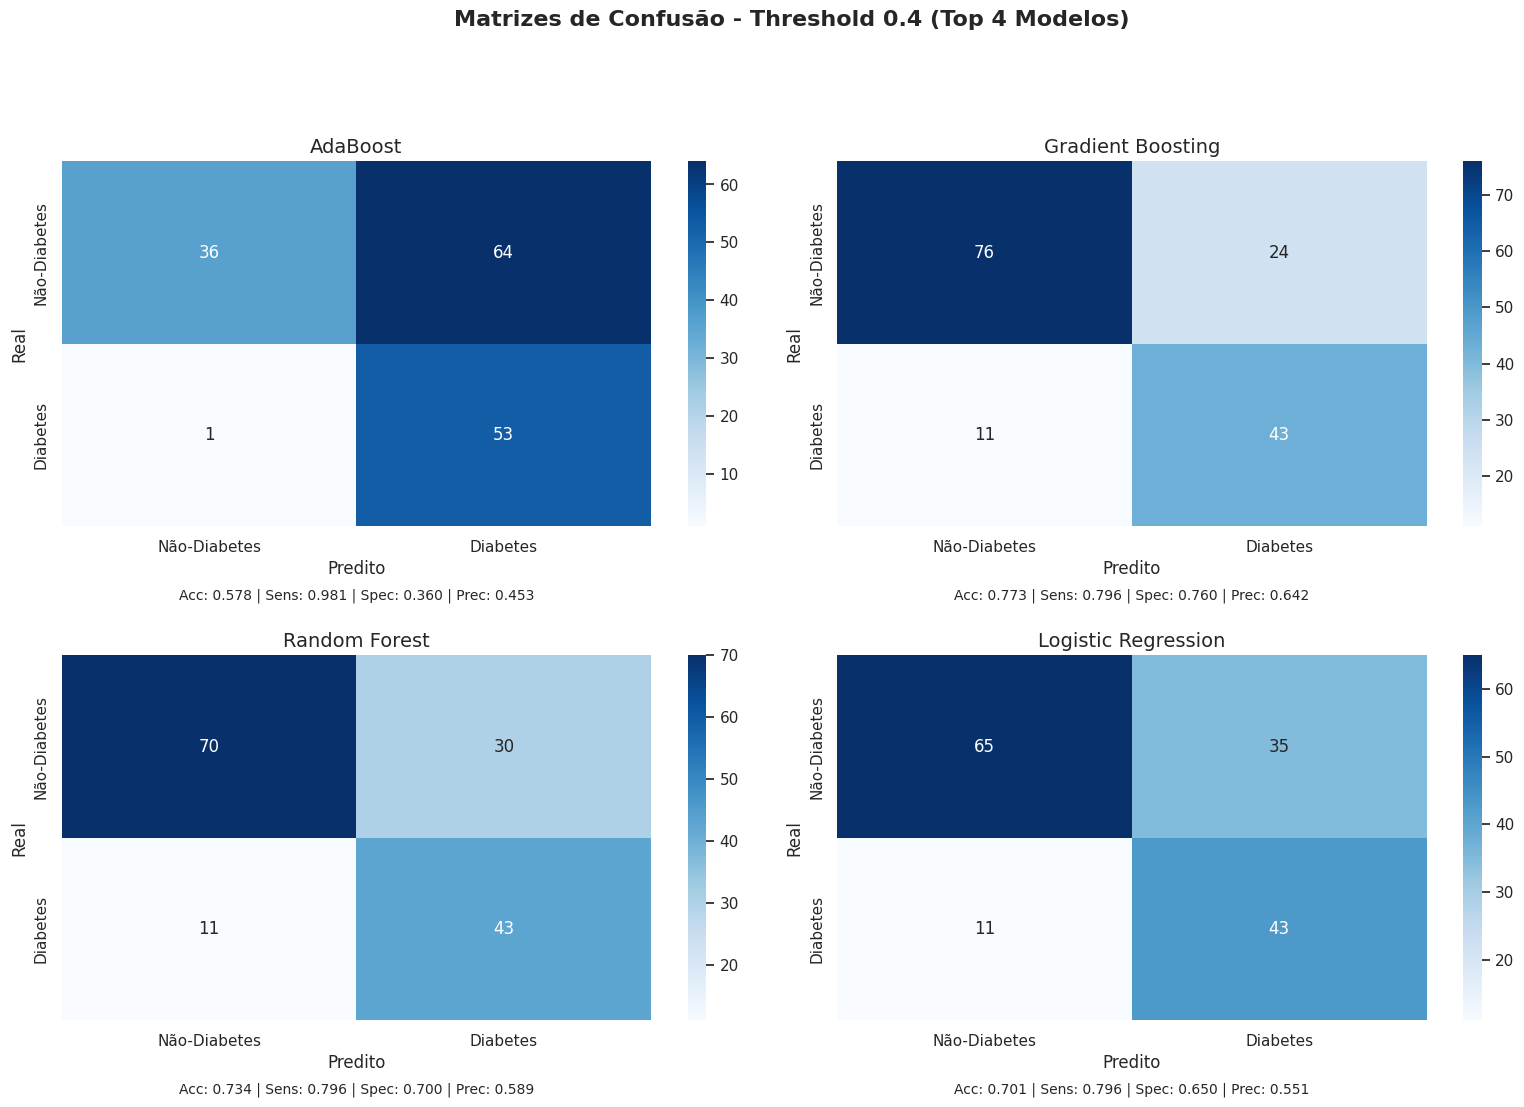


CURVA ROC COMBINADA - TOP 4 MODELOS



RESUMO COMPARATIVO - THRESHOLD 0.4 (TOP 4 MODELOS)

Modelo             AUC    Acc    Sens   Spec   Prec   F1     VP  FP  VN  FN 
-------------------------------------------------------------------------------------
AdaBoost           0.842  0.578  0.981  0.360  0.453  0.620  53  64  36  1  
Gradient Boosting  0.821  0.773  0.796  0.760  0.642  0.711  43  24  76  11 
Random Forest      0.817  0.734  0.796  0.700  0.589  0.677  43  30  70  11 
Logistic Regression 0.815  0.701  0.796  0.650  0.551  0.652  43  35  65  11 

🎯 MELHOR MODELO POR MÉTRICA (Threshold 0.4):
• Melhor AUC: AdaBoost (0.842)
• Melhor F1-Score: Gradient Boosting (0.711)
• Melhor Sensibilidade: AdaBoost (0.981)
• Melhor Especificidade: Gradient Boosting (0.760)

📊 ANÁLISE COMPARATIVA DOS TOP 4 MODELOS:
📈 ESTATÍSTICAS DO GRUPO:
• AUC médio: 0.824 ± 0.011
• Sensibilidade média: 0.843 ± 0.080
• Especificidade média: 0.618 ± 0.154
• F1-Score médio: 0.665 ± 0.033

🎯 MODELO MAIS EQUILIBRADO:
• Gradient Boosting (Score de eq

In [60]:
# ===== FUNÇÃO PARA ANÁLISE DE THRESHOLD =====
def analyze_threshold_for_model(model_name, y_proba, y_true, thresholds):
    """
    Analisa diferentes thresholds para um modelo específico
    """
    results = []
    
    for threshold in thresholds:
        # Gerar predições com o threshold atual
        y_pred = (y_proba >= threshold).astype(int)
        
        # Calcular matriz de confusão
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calcular métricas
        sensibilidade = tp / (tp + fn) if (tp + fn) > 0 else 0
        especificidade = tn / (tn + fp) if (tn + fp) > 0 else 0
        precisao = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1_score = 2 * (precisao * sensibilidade) / (precisao + sensibilidade) if (precisao + sensibilidade) > 0 else 0
        vpn = tn / (tn + fn) if (tn + fn) > 0 else 0  # Valor Preditivo Negativo
        
        results.append({
            'Threshold': threshold,
            'Sensibilidade': sensibilidade,
            'Especificidade': especificidade,
            'Precisão': precisao,
            'F1-Score': f1_score,
            'VPN': vpn,
            'VP': tp,
            'FP': fp,
            'VN': tn,
            'FN': fn
        })
    
    return pd.DataFrame(results)

# ===== ANÁLISE DE THRESHOLD PARA OS TOP 4 MELHORES MODELOS =====

print("\n" + "="*80)
print("ANÁLISE DE THRESHOLD - TOP 4 MELHORES MODELOS")
print("="*80)

# ===== SELEÇÃO DOS TOP 4 MODELOS =====
# Com base nos resultados do notebook SMOTE, selecionar os TOP 4 por AUC
if 'metrics_df' in globals():
    # Usar o DataFrame de métricas já calculado - ORDENAR POR AUC
    top_4_ranking = metrics_df.sort_values('AUC', ascending=False).head(4)
    target_models = top_4_ranking.index.tolist()
else:
    # Fallback: usar os modelos conhecidos por performance
    target_models = ['Random Forest', 'Gradient Boosting', 'AdaBoost', 'XGBoost']

print(f"\n🏆 TOP 4 MELHORES MODELOS SELECIONADOS (por AUC):")
print("="*60)
for i, model_name in enumerate(target_models, 1):
    if 'metrics_df' in globals() and model_name in metrics_df.index:
        auc_score = metrics_df.loc[model_name, 'AUC']
        f1_score_val = metrics_df.loc[model_name, 'F1-Score']
        print(f"{i}º lugar: {model_name} (AUC: {auc_score:.4f} | F1: {f1_score_val:.4f})")
    else:
        print(f"{i}º lugar: {model_name} (verificar métricas)")

print(f"\nAnalisando os {len(target_models)} melhores modelos...")

# Definir diferentes thresholds para análise (0.10 em 0.10)
# Round thresholds to 2 decimal places to avoid floating point inaccuracies
thresholds = np.round(np.arange(0.1, 1.0, 0.10), 2)

# Threshold para diagnóstico clínico (0.4)
diag_threshold = 0.4

# Dicionário para armazenar matrizes de confusão
confusion_matrices = {}
roc_data = {}

# Analisar cada modelo individualmente
for model_name in target_models:
    if model_name not in model_scores:
        print(f"⚠️ Modelo {model_name} não encontrado nos resultados. Pulando...")
        continue
        
    print(f"\n{'='*50}")
    print(f"ANÁLISE DO MODELO: {model_name}")
    print(f"{'='*50}")
    
    # Obter probabilidades preditas no conjunto de teste
    y_proba = model_scores[model_name]['y_test_proba']
    
    # Calcular métricas para cada threshold
    print(f"\nCalculando métricas para {len(thresholds)} valores de threshold...")
    threshold_df = analyze_threshold_for_model(model_name, y_proba, y_test, thresholds)
    
    # Formatar os dados da tabela para exibição com 3 casas decimais nas métricas
    threshold_display = threshold_df.copy()
    threshold_display['Threshold'] = threshold_display['Threshold'].round(3) 
    threshold_display['Sensibilidade'] = threshold_display['Sensibilidade'].round(3)
    threshold_display['Especificidade'] = threshold_display['Especificidade'].round(3)
    threshold_display['Precisão'] = threshold_display['Precisão'].round(3)
    threshold_display['F1-Score'] = threshold_display['F1-Score'].round(3)
    threshold_display['VPN'] = threshold_display['VPN'].round(3)
    
    # Exibir tabela completa de métricas por threshold com números centralizados
    print(f"\nTABELA COMPLETA DE MÉTRICAS POR THRESHOLD - {model_name}:")
    
    # Criar string formatada com colunas centralizadas
    header = f"{'Threshold':^10} {'Sens':^7} {'Espec':^7} {'Prec':^7} {'F1':^7} {'VPN':^7} {'VP':^4} {'FP':^4} {'VN':^4} {'FN':^4}"
    print(header)
    print("-" * len(header))
    
    for _, row in threshold_display.iterrows():
        linha = f"{row['Threshold']:^10.2f} {row['Sensibilidade']:^7.3f} {row['Especificidade']:^7.3f} {row['Precisão']:^7.3f} {row['F1-Score']:^7.3f} {row['VPN']:^7.3f} {row['VP']:^4.0f} {row['FP']:^4.0f} {row['VN']:^4.0f} {row['FN']:^4.0f}"
        print(linha)
    
    # Encontrar threshold ótimo para diagnóstico clínico (0.4)
    if diag_threshold not in threshold_df['Threshold'].values:
        diag_idx = abs(threshold_df['Threshold'] - diag_threshold).idxmin()
    else:
        diag_idx = threshold_df[threshold_df['Threshold'] == diag_threshold].index[0]
    diag = threshold_df.iloc[diag_idx]
    
    print(f"\nTHRESHOLD IDEAL PARA DIAGNÓSTICO CLÍNICO ({diag_threshold:.2f}) - {model_name}:")
    print(f"- Sensibilidade: {diag['Sensibilidade']:.3f}")
    print(f"- Especificidade: {diag['Especificidade']:.3f}")
    print(f"- F1-Score: {diag['F1-Score']:.3f}")
    print(f"- Precisão: {diag['Precisão']:.3f}")
    
    # NOVA SEÇÃO: TABELA DE INTERPRETAÇÃO CLÍNICA
    print(f"\n{'='*60}")
    print(f"INTERPRETAÇÃO CLÍNICA DETALHADA - {model_name} (Threshold {diag_threshold:.2f})")
    print(f"{'='*60}")
    
    # Extrair valores para interpretação
    VP = int(diag['VP'])
    FN = int(diag['FN']) 
    VN = int(diag['VN'])
    FP = int(diag['FP'])
    total_diabeticos = VP + FN
    total_nao_diabeticos = VN + FP
    total_pred_positivas = VP + FP
    
    # Tabela de interpretação clínica
    print(f"\n📊 RESUMO DE PERFORMANCE:")
    print(f"Sensibilidade: {diag['Sensibilidade']*100:.1f}% - {VP} de {total_diabeticos} diabéticos detectados")
    print(f"Especificidade: {diag['Especificidade']*100:.1f}% - {VN} de {total_nao_diabeticos} não-diabéticos corretos")
    print(f"Precisão: {diag['Precisão']*100:.1f}% - {VP} de {total_pred_positivas} predições positivas corretas")
    print(f"F1-Score: {diag['F1-Score']:.3f} - Equilíbrio geral")
    
    print(f"\n📋 INTERPRETAÇÃO CLÍNICA:")
    print(f"✅ Casos de diabetes detectados: {VP}")
    print(f"❌ Casos de diabetes perdidos: {FN}")
    if FN > 0:
        print(f"⚠️  {FN} pacientes diabéticos não seriam identificados")
    else:
        print(f"🎯 Todos os pacientes diabéticos foram identificados!")
    
    print(f"\n🔍 ANÁLISE DE ERROS:")
    print(f"• Falsos Positivos (FP): {FP} - Pacientes saudáveis incorretamente diagnosticados")
    print(f"• Falsos Negativos (FN): {FN} - Pacientes diabéticos não detectados")
    
    # Calcular percentuais de erro
    if total_nao_diabeticos > 0:
        perc_fp = (FP / total_nao_diabeticos) * 100
        print(f"• Taxa de Falsos Positivos: {perc_fp:.1f}% dos não-diabéticos")
    
    if total_diabeticos > 0:
        perc_fn = (FN / total_diabeticos) * 100
        print(f"• Taxa de Falsos Negativos: {perc_fn:.1f}% dos diabéticos")
    
    # Gerar predições com threshold 0.4 e calcular matriz de confusão
    y_pred_04 = (y_proba >= diag_threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_04)
    confusion_matrices[model_name] = cm
    
    # Calcular dados ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_data[model_name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}
    
    # Criar figura individual para este modelo
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
    fig.suptitle(f'Análise de Threshold para {model_name}', fontsize=16, fontweight='bold')
    
    # Gráfico 1: Curvas de Sensibilidade e Especificidade
    ax1.plot(threshold_df['Threshold'], threshold_df['Sensibilidade'], 'b-', linewidth=2, label='Sensibilidade')
    ax1.plot(threshold_df['Threshold'], threshold_df['Especificidade'], 'r-', linewidth=2, label='Especificidade')
    ax1.plot(threshold_df['Threshold'], threshold_df['F1-Score'], 'g-', linewidth=2, label='F1-Score')
    ax1.axvline(x=0.5, color='gray', linestyle='--', label='Threshold Padrão (0.5)')
    ax1.axvline(x=diag_threshold, color='orange', linestyle='--', linewidth=2, label=f'Threshold Ideal ({diag_threshold:.2f})', alpha=0.6)
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Score')
    ax1.set_title('Trade-off entre Sensibilidade e Especificidade', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_ylim(0, 1)
    ax1.set_xticks(thresholds) 
    
    # Gráfico 2: Heat map de métricas probabilísticas
    metrics_prob = threshold_df[['Threshold', 'Sensibilidade', 'Especificidade', 'Precisão', 'F1-Score', 'VPN']].copy()
    
    sns.heatmap(metrics_prob.set_index('Threshold'), annot=True, cmap='RdYlGn', center=0.5, 
               ax=ax2, cbar_kws={'label': 'Score'}, fmt='.3f', 
               annot_kws={'size': 9})
    ax2.set_title('Mapa de Calor - Métricas Probabilísticas', fontsize=14)
    ax2.set_xlabel('Métricas')
    ax2.set_ylabel('Threshold')
    
    # Gráfico 3: Heat map de contagens absolutas
    metrics_counts = threshold_df[['Threshold', 'VP', 'FP', 'VN', 'FN']].copy()
    
    sns.heatmap(metrics_counts.set_index('Threshold'), annot=True, cmap='viridis', 
               ax=ax3, cbar_kws={'label': 'Contagem'}, fmt='.0f',
               annot_kws={'size': 9})
    ax3.set_title('Mapa de Calor - Contagens Absolutas', fontsize=14)
    ax3.set_xlabel('Tipos de Classificação')
    ax3.set_ylabel('Threshold')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ===== MATRIZES DE CONFUSÃO PARA THRESHOLD 0.4 - EXPANDIDA PARA 4 MODELOS =====
print(f"\n{'='*80}")
print("MATRIZES DE CONFUSÃO - THRESHOLD 0.4 (TOP 4 MODELOS)")
print(f"{'='*80}")

# Filtrar apenas modelos válidos
valid_models = [model for model in target_models if model in confusion_matrices]

if len(valid_models) > 0:
    # Configurar subplots para 4 modelos (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Matrizes de Confusão - Threshold {diag_threshold:.1f} (Top 4 Modelos)', 
                 fontsize=16, fontweight='bold')
    
    # Garantir que axes seja sempre 2D
    if len(valid_models) == 1:
        axes = np.array([[axes]])
    elif len(valid_models) <= 2:
        axes = axes.reshape(1, -1) if axes.ndim == 1 else axes
    
    for i, model_name in enumerate(valid_models):
        if i >= 4:  # Máximo 4 modelos
            break
            
        row = i // 2
        col = i % 2
        
        cm = confusion_matrices[model_name]
        
        # Criar heatmap da matriz de confusão
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Não-Diabetes', 'Diabetes'],
                    yticklabels=['Não-Diabetes', 'Diabetes'],
                    ax=axes[row, col])
        
        axes[row, col].set_title(f'{model_name}', fontsize=14)
        axes[row, col].set_xlabel('Predito')
        axes[row, col].set_ylabel('Real')
        
        # Adicionar métricas na matriz
        tn, fp, fn, tp = cm.ravel()
        total = cm.sum()
        accuracy = (tp + tn) / total
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        # Adicionar texto com métricas
        axes[row, col].text(0.5, -0.20, 
                    f'Acc: {accuracy:.3f} | Sens: {sensitivity:.3f} | Spec: {specificity:.3f} | Prec: {precision:.3f}',
                    transform=axes[row, col].transAxes, ha='center', fontsize=10)
    
    # Esconder axes vazios se houver menos de 4 modelos
    for i in range(len(valid_models), 4):
        row = i // 2
        col = i % 2
        axes[row, col].set_visible(False)
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.92])
    plt.show()
else:
    print("⚠️ Nenhum modelo válido encontrado para plotar matrizes de confusão.")

# ===== CURVA ROC COMBINADA - EXPANDIDA PARA 4 MODELOS =====
print(f"\n{'='*80}")
print("CURVA ROC COMBINADA - TOP 4 MODELOS")
print(f"{'='*80}")

if len(valid_models) > 0:
    plt.figure(figsize=(12, 8))
    
    # Cores para cada modelo - EXPANDIDAS PARA 4
    colors = ['blue', 'red', 'green', 'purple']
    
    for i, model_name in enumerate(valid_models):
        if i >= 4:  # Máximo 4 modelos
            break
            
        fpr = roc_data[model_name]['fpr']
        tpr = roc_data[model_name]['tpr']
        roc_auc = roc_data[model_name]['auc']
        
        color = colors[i] if i < len(colors) else 'black'
        plt.plot(fpr, tpr, color=color, linewidth=2, 
                 label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    # Linha diagonal (classificador aleatório)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Classificador Aleatório (AUC = 0.500)')
    
    # Configurações do gráfico
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)', fontsize=12)
    plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)', fontsize=12)
    plt.title('Curva ROC - Comparação dos Top 4 Modelos Selecionados', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Adicionar ponto para threshold 0.4 em cada curva
    for i, model_name in enumerate(valid_models):
        if i >= 4:  # Máximo 4 modelos
            break
            
        y_proba = model_scores[model_name]['y_test_proba']
        y_pred_04 = (y_proba >= diag_threshold).astype(int)
        
        # Calcular FPR e TPR para threshold 0.4
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_04).ravel()
        fpr_04 = fp / (fp + tn) if (fp + tn) > 0 else 0
        tpr_04 = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        color = colors[i] if i < len(colors) else 'black'
        plt.plot(fpr_04, tpr_04, 'o', color=color, markersize=8, 
                 markeredgecolor='black', markeredgewidth=1)
    
    # Adicionar legenda para os pontos de threshold 0.4
    plt.text(0.6, 0.2, f'● Pontos para Threshold {diag_threshold:.1f}', 
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# ===== RESUMO FINAL - EXPANDIDO PARA 4 MODELOS =====
print(f"\n{'='*80}")
print("RESUMO COMPARATIVO - THRESHOLD 0.4 (TOP 4 MODELOS)")
print(f"{'='*80}")

# Criar tabela resumo
summary_data = []
for model_name in valid_models:
    cm = confusion_matrices[model_name]
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    auc_score = roc_data[model_name]['auc']
    
    summary_data.append({
        'Modelo': model_name,
        'AUC': auc_score,
        'Accuracy': accuracy,
        'Sensibilidade': sensitivity,
        'Especificidade': specificity,
        'Precisão': precision,
        'F1-Score': f1_score,
        'VP': tp,
        'FP': fp,
        'VN': tn,
        'FN': fn
    })

# Exibir tabela formatada
print(f"\n{'Modelo':<18} {'AUC':<6} {'Acc':<6} {'Sens':<6} {'Spec':<6} {'Prec':<6} {'F1':<6} {'VP':<3} {'FP':<3} {'VN':<3} {'FN':<3}")
print("-" * 85)

for data in summary_data:
    print(f"{data['Modelo']:<18} {data['AUC']:<6.3f} {data['Accuracy']:<6.3f} {data['Sensibilidade']:<6.3f} {data['Especificidade']:<6.3f} {data['Precisão']:<6.3f} {data['F1-Score']:<6.3f} {data['VP']:<3} {data['FP']:<3} {data['VN']:<3} {data['FN']:<3}")

print(f"\n🎯 MELHOR MODELO POR MÉTRICA (Threshold {diag_threshold:.1f}):")
if len(summary_data) > 0:
    best_auc = max(summary_data, key=lambda x: x['AUC'])
    best_f1 = max(summary_data, key=lambda x: x['F1-Score'])
    best_sens = max(summary_data, key=lambda x: x['Sensibilidade'])
    best_spec = max(summary_data, key=lambda x: x['Especificidade'])
    
    print(f"• Melhor AUC: {best_auc['Modelo']} ({best_auc['AUC']:.3f})")
    print(f"• Melhor F1-Score: {best_f1['Modelo']} ({best_f1['F1-Score']:.3f})")
    print(f"• Melhor Sensibilidade: {best_sens['Modelo']} ({best_sens['Sensibilidade']:.3f})")
    print(f"• Melhor Especificidade: {best_spec['Modelo']} ({best_spec['Especificidade']:.3f})")

# ===== ANÁLISE COMPARATIVA DOS 4 MODELOS =====
print(f"\n📊 ANÁLISE COMPARATIVA DOS TOP 4 MODELOS:")
print("="*60)

if len(summary_data) >= 2:
    # Calcular médias e desvios
    auc_values = [data['AUC'] for data in summary_data]
    sens_values = [data['Sensibilidade'] for data in summary_data]
    spec_values = [data['Especificidade'] for data in summary_data]
    f1_values = [data['F1-Score'] for data in summary_data]
    
    print(f"📈 ESTATÍSTICAS DO GRUPO:")
    print(f"• AUC médio: {np.mean(auc_values):.3f} ± {np.std(auc_values):.3f}")
    print(f"• Sensibilidade média: {np.mean(sens_values):.3f} ± {np.std(sens_values):.3f}")
    print(f"• Especificidade média: {np.mean(spec_values):.3f} ± {np.std(spec_values):.3f}")
    print(f"• F1-Score médio: {np.mean(f1_values):.3f} ± {np.std(f1_values):.3f}")
    
    # Identificar modelo mais equilibrado
    equilibrio_scores = []
    for data in summary_data:
        # Score de equilíbrio baseado na menor diferença entre sens e spec
        equilibrio = 1 - abs(data['Sensibilidade'] - data['Especificidade'])
        equilibrio_scores.append((data['Modelo'], equilibrio))
    
    melhor_equilibrio = max(equilibrio_scores, key=lambda x: x[1])
    print(f"\n🎯 MODELO MAIS EQUILIBRADO:")
    print(f"• {melhor_equilibrio[0]} (Score de equilíbrio: {melhor_equilibrio[1]:.3f})")
    
    # Rankeamento geral
    print(f"\n🏆 RANKING GERAL DOS TOP 4 (por AUC):")
    for i, data in enumerate(sorted(summary_data, key=lambda x: x['AUC'], reverse=True), 1):
        print(f"{i}º lugar: {data['Modelo']} (AUC: {data['AUC']:.3f})")

print(f"\n✅ ANÁLISE DE THRESHOLD COMPLETA PARA OS TOP 4 MODELOS!")
print(f"📊 {len(valid_models)} modelos analisados com threshold otimizado")
print(f"🎯 Threshold clínico ideal: {diag_threshold} para detecção de diabetes")
print(f"🔍 Análise expandida para maior robustez na seleção")



ANÁLISE DE THRESHOLD - TOP 4 MELHORES MODELOS

🏆 TOP 4 MELHORES MODELOS SELECIONADOS (por AUC):
1º lugar: AdaBoost (AUC: 0.8420 | F1: 0.6780)
2º lugar: Gradient Boosting (AUC: 0.8210 | F1: 0.6960)
3º lugar: Random Forest (AUC: 0.8170 | F1: 0.6550)
4º lugar: Logistic Regression (AUC: 0.8150 | F1: 0.6270)

Analisando os 4 melhores modelos...

ANÁLISE DO MODELO: AdaBoost

Calculando métricas para 9 valores de threshold...

TABELA COMPLETA DE MÉTRICAS POR THRESHOLD - AdaBoost:
Threshold   Sens    Espec   Prec     F1      VPN    VP   FP   VN   FN 
----------------------------------------------------------------------
   0.10     1.000   0.000   0.351   0.519   0.000   54  100   0    0  
   0.20     1.000   0.000   0.351   0.519   0.000   54  100   0    0  
   0.30     0.981   0.070   0.363   0.530   0.875   53   93   7    1  
   0.40     0.981   0.360   0.453   0.620   0.973   53   64   36   1  
   0.50     0.741   0.760   0.625   0.678   0.844   40   24   76   14 
   0.60     0.259   0.98

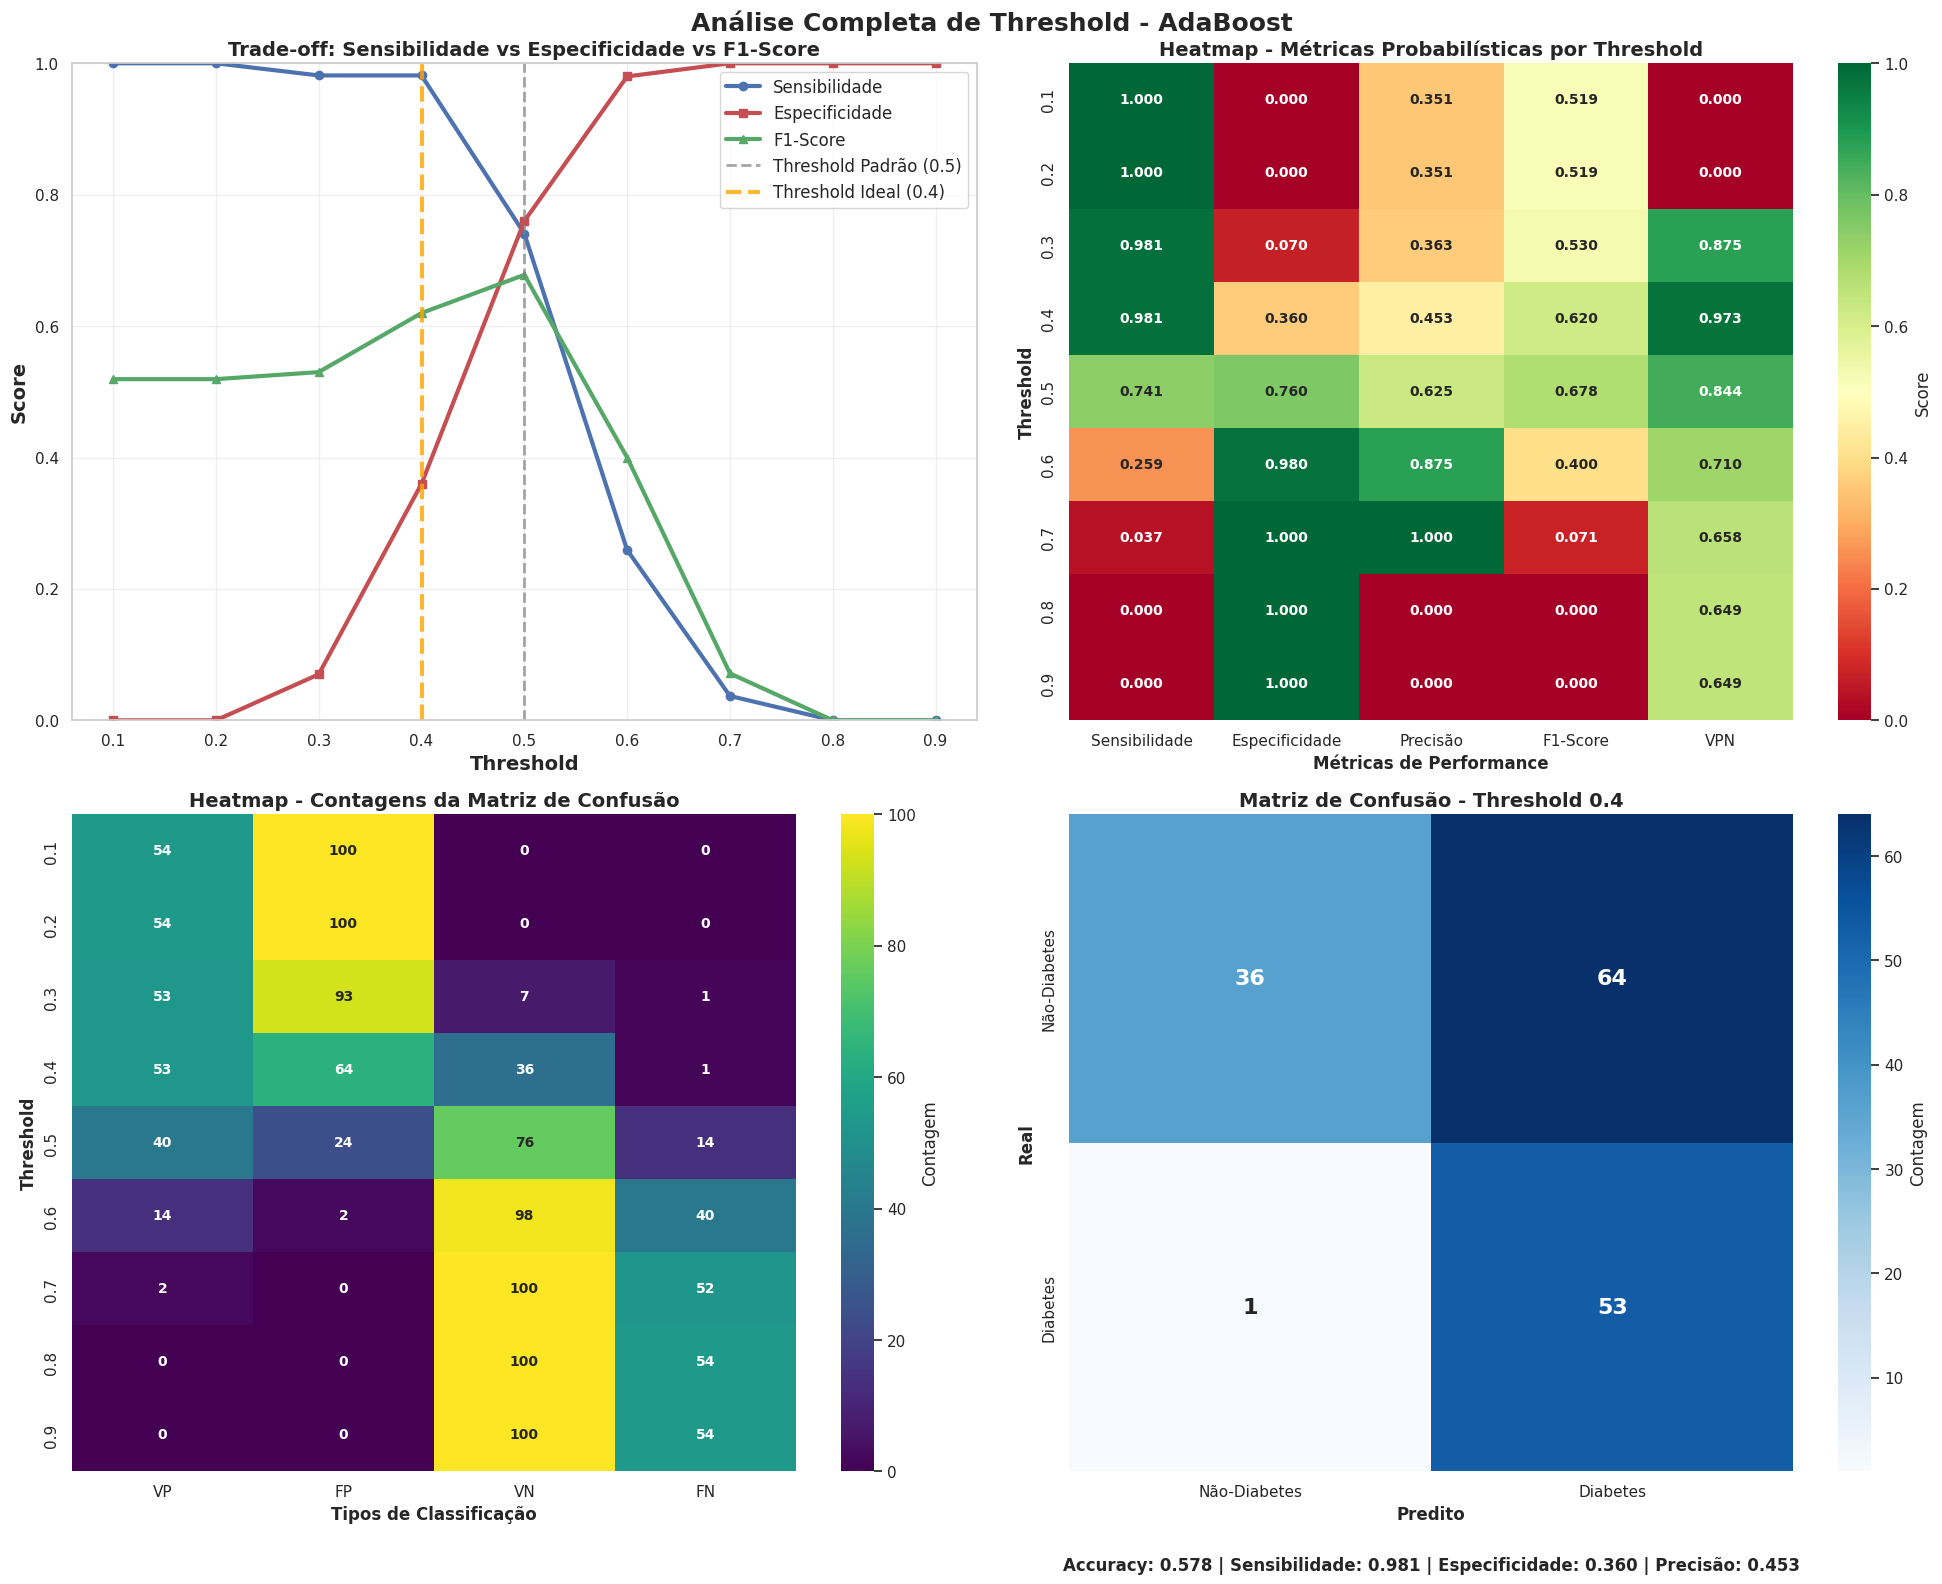


ANÁLISE DO MODELO: Gradient Boosting

Calculando métricas para 9 valores de threshold...

TABELA COMPLETA DE MÉTRICAS POR THRESHOLD - Gradient Boosting:
Threshold   Sens    Espec   Prec     F1      VPN    VP   FP   VN   FN 
----------------------------------------------------------------------
   0.10     0.907   0.500   0.495   0.641   0.909   49   50   50   5  
   0.20     0.870   0.630   0.560   0.681   0.900   47   37   63   7  
   0.30     0.833   0.690   0.592   0.692   0.885   45   31   69   9  
   0.40     0.796   0.760   0.642   0.711   0.874   43   24   76   11 
   0.50     0.741   0.790   0.656   0.696   0.849   40   21   79   14 
   0.60     0.630   0.860   0.708   0.667   0.811   34   14   86   20 
   0.70     0.463   0.870   0.658   0.543   0.750   25   13   87   29 
   0.80     0.389   0.900   0.677   0.494   0.732   21   10   90   33 
   0.90     0.296   0.960   0.800   0.432   0.716   16   4    96   38 

THRESHOLD IDEAL PARA DIAGNÓSTICO CLÍNICO (0.40) - Gradient Boost


ANÁLISE DO MODELO: Random Forest

Calculando métricas para 9 valores de threshold...

TABELA COMPLETA DE MÉTRICAS POR THRESHOLD - Random Forest:
Threshold   Sens    Espec   Prec     F1      VPN    VP   FP   VN   FN 
----------------------------------------------------------------------
   0.10     0.981   0.310   0.434   0.602   0.969   53   69   31   1  
   0.20     0.926   0.470   0.485   0.637   0.922   50   53   47   4  
   0.30     0.870   0.620   0.553   0.676   0.899   47   38   62   7  
   0.40     0.796   0.700   0.589   0.677   0.864   43   30   70   11 
   0.50     0.667   0.800   0.643   0.655   0.816   36   20   80   18 
   0.60     0.537   0.860   0.674   0.598   0.775   29   14   86   25 
   0.70     0.370   0.920   0.714   0.488   0.730   20   8    92   34 
   0.80     0.111   0.980   0.750   0.194   0.671   6    2    98   48 
   0.90     0.037   1.000   1.000   0.071   0.658   2    0   100   52 

THRESHOLD IDEAL PARA DIAGNÓSTICO CLÍNICO (0.40) - Random Forest:
- Sensi

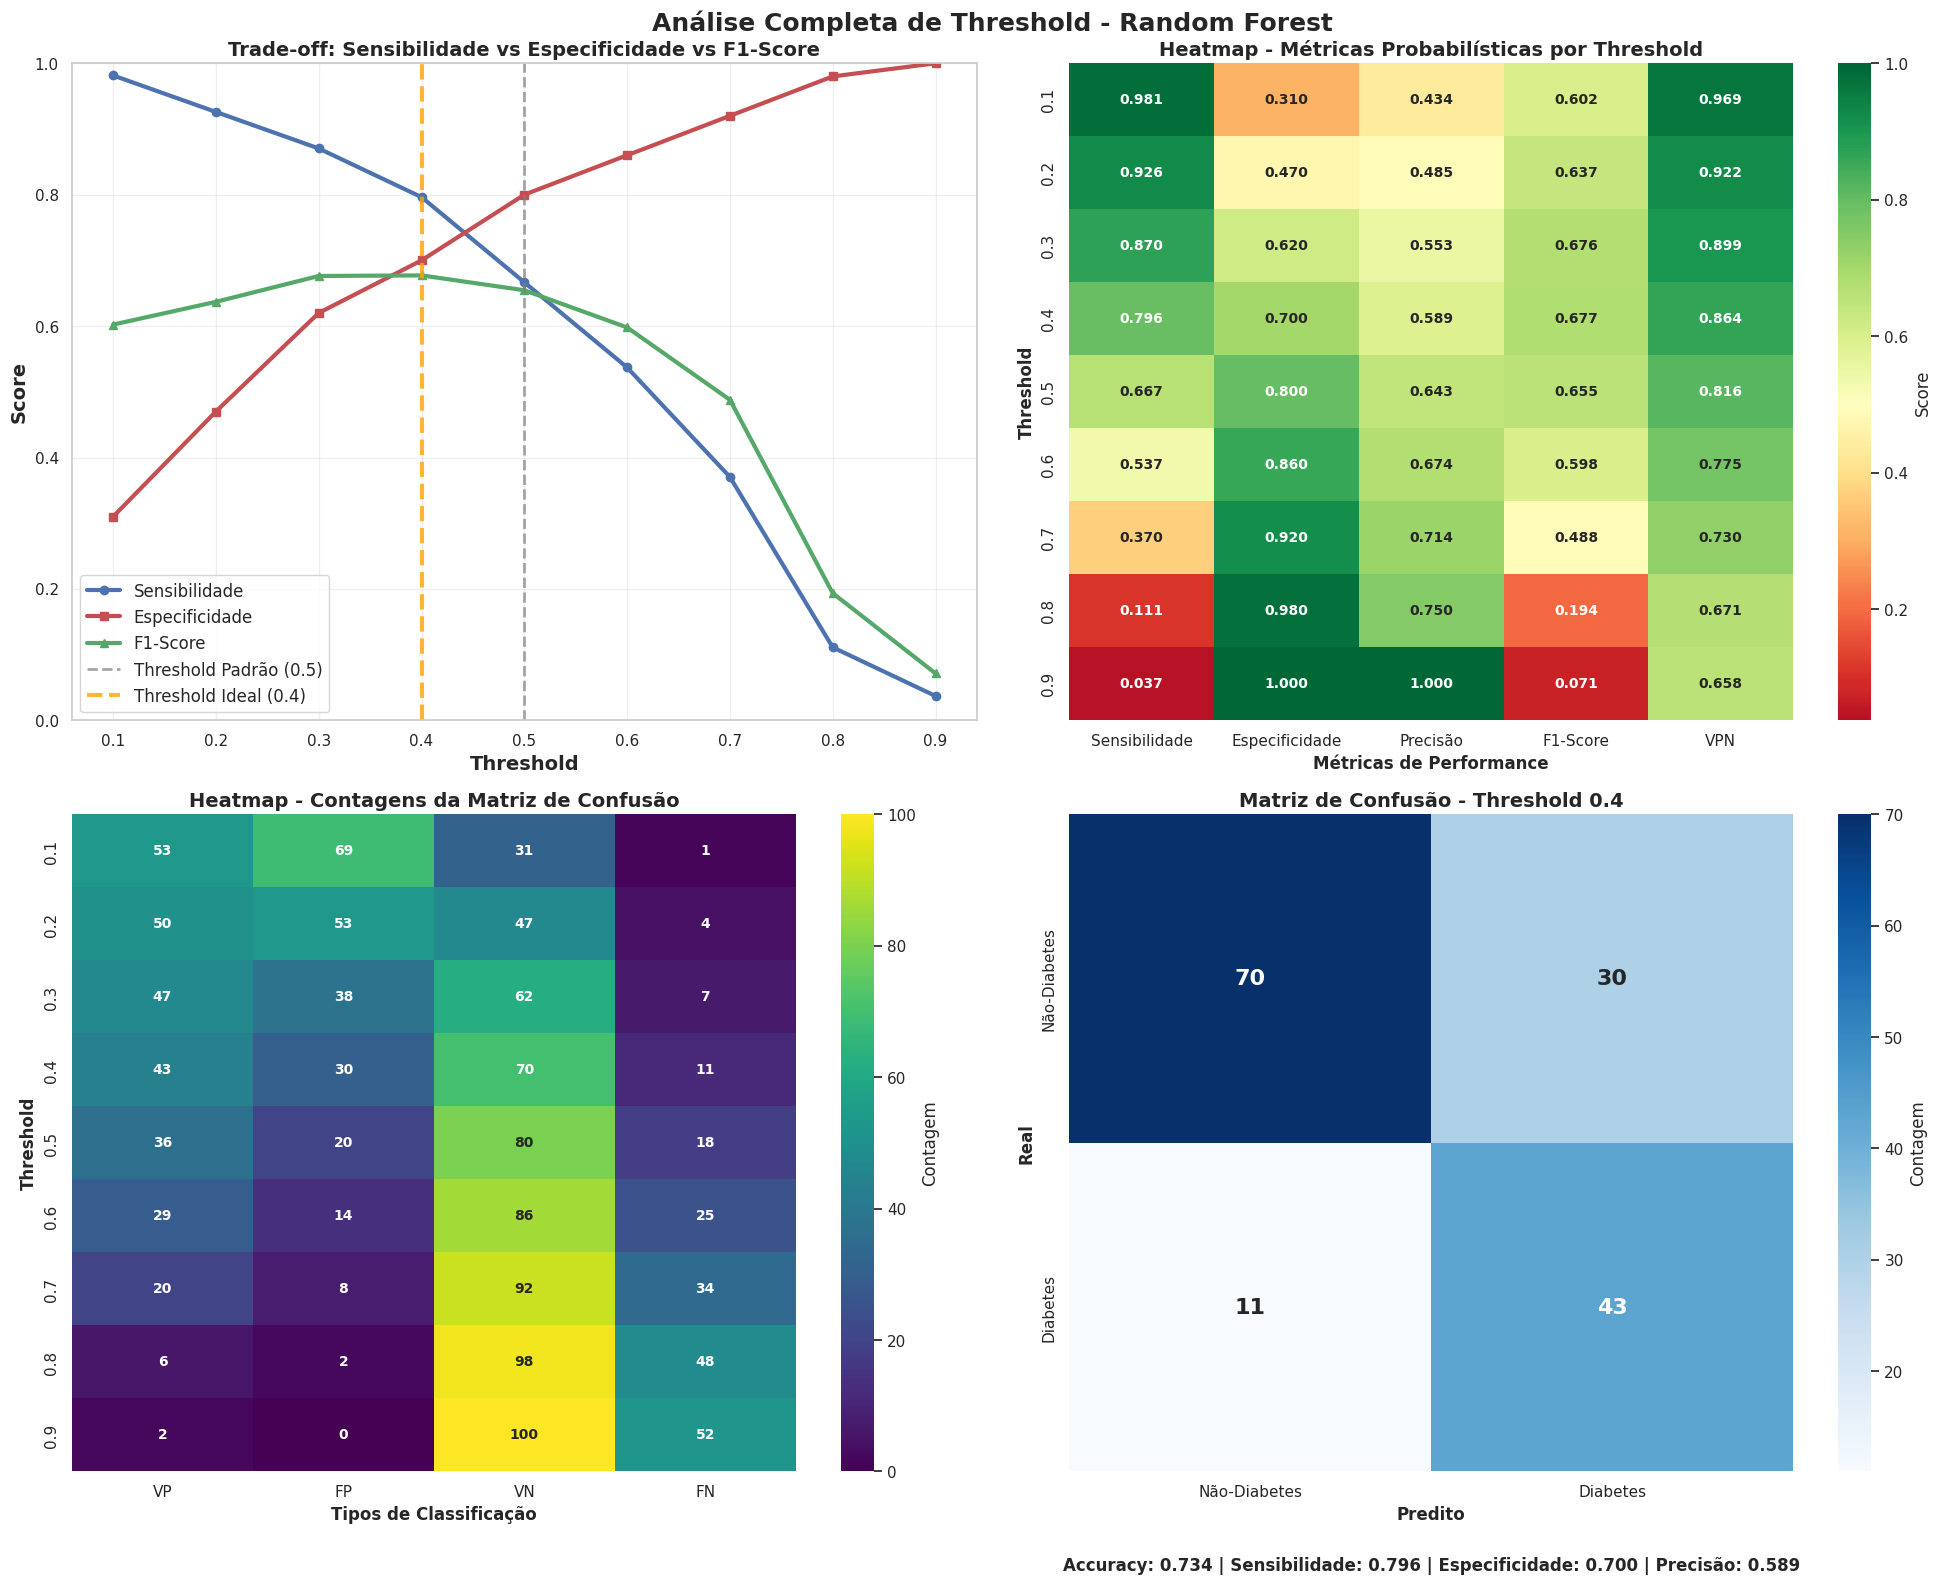


ANÁLISE DO MODELO: Logistic Regression

Calculando métricas para 9 valores de threshold...

TABELA COMPLETA DE MÉTRICAS POR THRESHOLD - Logistic Regression:
Threshold   Sens    Espec   Prec     F1      VPN    VP   FP   VN   FN 
----------------------------------------------------------------------
   0.10     0.981   0.290   0.427   0.596   0.967   53   71   29   1  
   0.20     0.926   0.480   0.490   0.641   0.923   50   52   48   4  
   0.30     0.870   0.540   0.505   0.639   0.885   47   46   54   7  
   0.40     0.796   0.650   0.551   0.652   0.855   43   35   65   11 
   0.50     0.685   0.730   0.578   0.627   0.811   37   27   73   17 
   0.60     0.611   0.800   0.623   0.617   0.792   33   20   80   21 
   0.70     0.574   0.850   0.674   0.620   0.787   31   15   85   23 
   0.80     0.481   0.900   0.722   0.578   0.763   26   10   90   28 
   0.90     0.278   0.960   0.789   0.411   0.711   15   4    96   39 

THRESHOLD IDEAL PARA DIAGNÓSTICO CLÍNICO (0.40) - Logistic R


MATRIZES DE CONFUSÃO - THRESHOLD 0.4 (TOP 4 MODELOS)


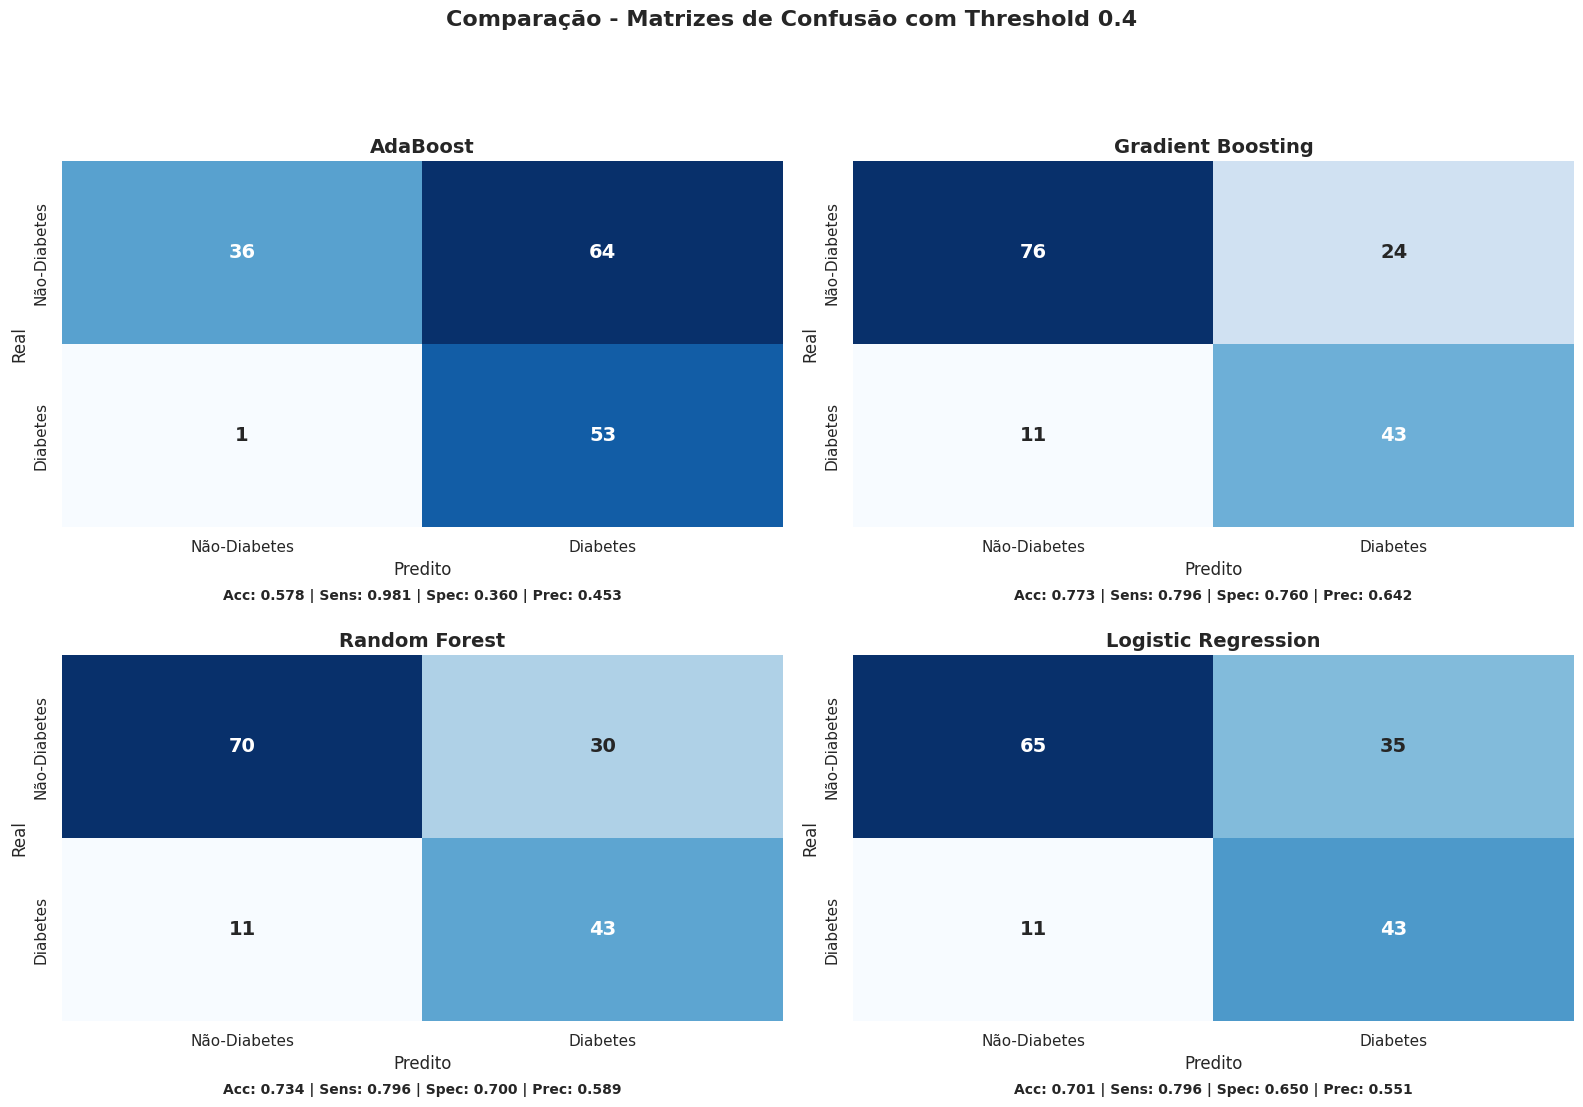


CURVA ROC COMBINADA - TOP 4 MODELOS



RESUMO COMPARATIVO - THRESHOLD 0.4 (TOP 4 MODELOS)

Modelo             AUC    Acc    Sens   Spec   Prec   F1     VP  FP  VN  FN 
-------------------------------------------------------------------------------------
AdaBoost           0.842  0.578  0.981  0.360  0.453  0.620  53  64  36  1  
Gradient Boosting  0.821  0.773  0.796  0.760  0.642  0.711  43  24  76  11 
Random Forest      0.817  0.734  0.796  0.700  0.589  0.677  43  30  70  11 
Logistic Regression 0.815  0.701  0.796  0.650  0.551  0.652  43  35  65  11 

🎯 MELHOR MODELO POR MÉTRICA (Threshold 0.4):
• Melhor AUC: AdaBoost (0.842)
• Melhor F1-Score: Gradient Boosting (0.711)
• Melhor Sensibilidade: AdaBoost (0.981)
• Melhor Especificidade: Gradient Boosting (0.760)

📊 ANÁLISE COMPARATIVA DOS TOP 4 MODELOS:
📈 ESTATÍSTICAS DO GRUPO:
• AUC médio: 0.824 ± 0.011
• Sensibilidade média: 0.843 ± 0.080
• Especificidade média: 0.618 ± 0.154
• F1-Score médio: 0.665 ± 0.033

🎯 MODELO MAIS EQUILIBRADO:
• Gradient Boosting (Score de eq

In [61]:
# ===== FUNÇÃO PARA ANÁLISE DE THRESHOLD =====
def analyze_threshold_for_model(model_name, y_proba, y_true, thresholds):
    """
    Analisa diferentes thresholds para um modelo específico
    """
    results = []
    
    for threshold in thresholds:
        # Gerar predições com o threshold atual
        y_pred = (y_proba >= threshold).astype(int)
        
        # Calcular matriz de confusão
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # Calcular métricas
        sensibilidade = tp / (tp + fn) if (tp + fn) > 0 else 0
        especificidade = tn / (tn + fp) if (tn + fp) > 0 else 0
        precisao = tp / (tp + fp) if (tp + fp) > 0 else 0
        f1_score = 2 * (precisao * sensibilidade) / (precisao + sensibilidade) if (precisao + sensibilidade) > 0 else 0
        vpn = tn / (tn + fn) if (tn + fn) > 0 else 0  # Valor Preditivo Negativo
        
        results.append({
            'Threshold': threshold,
            'Sensibilidade': sensibilidade,
            'Especificidade': especificidade,
            'Precisão': precisao,
            'F1-Score': f1_score,
            'VPN': vpn,
            'VP': tp,
            'FP': fp,
            'VN': tn,
            'FN': fn
        })
    
    return pd.DataFrame(results)

# ===== ANÁLISE DE THRESHOLD PARA OS TOP 4 MELHORES MODELOS =====

print("\n" + "="*80)
print("ANÁLISE DE THRESHOLD - TOP 4 MELHORES MODELOS")
print("="*80)

# ===== SELEÇÃO DOS TOP 4 MODELOS =====
# Com base nos resultados do notebook SMOTE, selecionar os TOP 4 por AUC
if 'metrics_df' in globals():
    # Usar o DataFrame de métricas já calculado - ORDENAR POR AUC
    top_4_ranking = metrics_df.sort_values('AUC', ascending=False).head(4)
    target_models = top_4_ranking.index.tolist()
else:
    # Fallback: usar os modelos conhecidos por performance
    target_models = ['Random Forest', 'Gradient Boosting', 'AdaBoost', 'XGBoost']

print(f"\n🏆 TOP 4 MELHORES MODELOS SELECIONADOS (por AUC):")
print("="*60)
for i, model_name in enumerate(target_models, 1):
    if 'metrics_df' in globals() and model_name in metrics_df.index:
        auc_score = metrics_df.loc[model_name, 'AUC']
        f1_score_val = metrics_df.loc[model_name, 'F1-Score']
        print(f"{i}º lugar: {model_name} (AUC: {auc_score:.4f} | F1: {f1_score_val:.4f})")
    else:
        print(f"{i}º lugar: {model_name} (verificar métricas)")

print(f"\nAnalisando os {len(target_models)} melhores modelos...")

# Definir diferentes thresholds para análise (0.10 em 0.10)
thresholds = np.round(np.arange(0.1, 1.0, 0.10), 2)

# Threshold para diagnóstico clínico (0.4)
diag_threshold = 0.4

# Dicionário para armazenar matrizes de confusão
confusion_matrices = {}
roc_data = {}
all_threshold_data = {}

# Analisar cada modelo individualmente
for model_name in target_models:
    if model_name not in model_scores:
        print(f"⚠️ Modelo {model_name} não encontrado nos resultados. Pulando...")
        continue
        
    print(f"\n{'='*50}")
    print(f"ANÁLISE DO MODELO: {model_name}")
    print(f"{'='*50}")
    
    # Obter probabilidades preditas no conjunto de teste
    y_proba = model_scores[model_name]['y_test_proba']
    
    # Calcular métricas para cada threshold
    print(f"\nCalculando métricas para {len(thresholds)} valores de threshold...")
    threshold_df = analyze_threshold_for_model(model_name, y_proba, y_test, thresholds)
    all_threshold_data[model_name] = threshold_df
    
    # Formatar os dados da tabela para exibição com 3 casas decimais nas métricas
    threshold_display = threshold_df.copy()
    threshold_display['Threshold'] = threshold_display['Threshold'].round(3) 
    threshold_display['Sensibilidade'] = threshold_display['Sensibilidade'].round(3)
    threshold_display['Especificidade'] = threshold_display['Especificidade'].round(3)
    threshold_display['Precisão'] = threshold_display['Precisão'].round(3)
    threshold_display['F1-Score'] = threshold_display['F1-Score'].round(3)
    threshold_display['VPN'] = threshold_display['VPN'].round(3)
    
    # Exibir tabela completa de métricas por threshold com números centralizados
    print(f"\nTABELA COMPLETA DE MÉTRICAS POR THRESHOLD - {model_name}:")
    
    # Criar string formatada com colunas centralizadas
    header = f"{'Threshold':^10} {'Sens':^7} {'Espec':^7} {'Prec':^7} {'F1':^7} {'VPN':^7} {'VP':^4} {'FP':^4} {'VN':^4} {'FN':^4}"
    print(header)
    print("-" * len(header))
    
    for _, row in threshold_display.iterrows():
        linha = f"{row['Threshold']:^10.2f} {row['Sensibilidade']:^7.3f} {row['Especificidade']:^7.3f} {row['Precisão']:^7.3f} {row['F1-Score']:^7.3f} {row['VPN']:^7.3f} {row['VP']:^4.0f} {row['FP']:^4.0f} {row['VN']:^4.0f} {row['FN']:^4.0f}"
        print(linha)
    
    # Encontrar threshold ótimo para diagnóstico clínico (0.4)
    if diag_threshold not in threshold_df['Threshold'].values:
        diag_idx = abs(threshold_df['Threshold'] - diag_threshold).idxmin()
    else:
        diag_idx = threshold_df[threshold_df['Threshold'] == diag_threshold].index[0]
    diag = threshold_df.iloc[diag_idx]
    
    print(f"\nTHRESHOLD IDEAL PARA DIAGNÓSTICO CLÍNICO ({diag_threshold:.2f}) - {model_name}:")
    print(f"- Sensibilidade: {diag['Sensibilidade']:.3f}")
    print(f"- Especificidade: {diag['Especificidade']:.3f}")
    print(f"- F1-Score: {diag['F1-Score']:.3f}")
    print(f"- Precisão: {diag['Precisão']:.3f}")
    
    # NOVA SEÇÃO: TABELA DE INTERPRETAÇÃO CLÍNICA
    print(f"\n{'='*60}")
    print(f"INTERPRETAÇÃO CLÍNICA DETALHADA - {model_name} (Threshold {diag_threshold:.2f})")
    print(f"{'='*60}")
    
    # Extrair valores para interpretação
    VP = int(diag['VP'])
    FN = int(diag['FN']) 
    VN = int(diag['VN'])
    FP = int(diag['FP'])
    total_diabeticos = VP + FN
    total_nao_diabeticos = VN + FP
    total_pred_positivas = VP + FP
    
    # Tabela de interpretação clínica
    print(f"\n📊 RESUMO DE PERFORMANCE:")
    print(f"Sensibilidade: {diag['Sensibilidade']*100:.1f}% - {VP} de {total_diabeticos} diabéticos detectados")
    print(f"Especificidade: {diag['Especificidade']*100:.1f}% - {VN} de {total_nao_diabeticos} não-diabéticos corretos")
    print(f"Precisão: {diag['Precisão']*100:.1f}% - {VP} de {total_pred_positivas} predições positivas corretas")
    print(f"F1-Score: {diag['F1-Score']:.3f} - Equilíbrio geral")
    
    print(f"\n📋 INTERPRETAÇÃO CLÍNICA:")
    print(f"✅ Casos de diabetes detectados: {VP}")
    print(f"❌ Casos de diabetes perdidos: {FN}")
    if FN > 0:
        print(f"⚠️  {FN} pacientes diabéticos não seriam identificados")
    else:
        print(f"🎯 Todos os pacientes diabéticos foram identificados!")
    
    print(f"\n🔍 ANÁLISE DE ERROS:")
    print(f"• Falsos Positivos (FP): {FP} - Pacientes saudáveis incorretamente diagnosticados")
    print(f"• Falsos Negativos (FN): {FN} - Pacientes diabéticos não detectados")
    
    # Calcular percentuais de erro
    if total_nao_diabeticos > 0:
        perc_fp = (FP / total_nao_diabeticos) * 100
        print(f"• Taxa de Falsos Positivos: {perc_fp:.1f}% dos não-diabéticos")
    
    if total_diabeticos > 0:
        perc_fn = (FN / total_diabeticos) * 100
        print(f"• Taxa de Falsos Negativos: {perc_fn:.1f}% dos diabéticos")
    
    # Gerar predições com threshold 0.4 e calcular matriz de confusão
    y_pred_04 = (y_proba >= diag_threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_04)
    confusion_matrices[model_name] = cm
    
    # Calcular dados ROC para uso posterior
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_data[model_name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}
    
    # ===== CRIAR FIGURA INDIVIDUAL 2x2 PARA ESTE MODELO =====
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle(f'Análise Completa de Threshold - {model_name}', fontsize=18, fontweight='bold')
    
    # Gráfico 1 (0,0): Curvas de Sensibilidade e Especificidade
    ax1 = axes[0, 0]
    ax1.plot(threshold_df['Threshold'], threshold_df['Sensibilidade'], 'b-', linewidth=3, 
             label='Sensibilidade', marker='o', markersize=6)
    ax1.plot(threshold_df['Threshold'], threshold_df['Especificidade'], 'r-', linewidth=3, 
             label='Especificidade', marker='s', markersize=6)
    ax1.plot(threshold_df['Threshold'], threshold_df['F1-Score'], 'g-', linewidth=3, 
             label='F1-Score', marker='^', markersize=6)
    ax1.axvline(x=0.5, color='gray', linestyle='--', linewidth=2, 
                label='Threshold Padrão (0.5)', alpha=0.7)
    ax1.axvline(x=diag_threshold, color='orange', linestyle='--', linewidth=3, 
                label=f'Threshold Ideal ({diag_threshold:.1f})', alpha=0.8)
    ax1.set_xlabel('Threshold', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Score', fontsize=14, fontweight='bold')
    ax1.set_title('Trade-off: Sensibilidade vs Especificidade vs F1-Score', 
                  fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=12, loc='best')
    ax1.set_ylim(0, 1)
    ax1.set_xticks(thresholds)
    
    # Gráfico 2 (0,1): Heatmap de métricas probabilísticas
    ax2 = axes[0, 1]
    metrics_prob = threshold_df[['Threshold', 'Sensibilidade', 'Especificidade', 'Precisão', 'F1-Score', 'VPN']].copy()
    
    sns.heatmap(metrics_prob.set_index('Threshold'), annot=True, cmap='RdYlGn', center=0.5, 
               ax=ax2, cbar_kws={'label': 'Score'}, fmt='.3f', 
               annot_kws={'size': 10, 'weight': 'bold'})
    ax2.set_title('Heatmap - Métricas Probabilísticas por Threshold', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('Métricas de Performance', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Threshold', fontsize=12, fontweight='bold')
    
    # Gráfico 3 (1,0): Heatmap de contagens absolutas
    ax3 = axes[1, 0]
    metrics_counts = threshold_df[['Threshold', 'VP', 'FP', 'VN', 'FN']].copy()
    
    sns.heatmap(metrics_counts.set_index('Threshold'), annot=True, cmap='viridis', 
               ax=ax3, cbar_kws={'label': 'Contagem'}, fmt='.0f',
               annot_kws={'size': 10, 'weight': 'bold'})
    ax3.set_title('Heatmap - Contagens da Matriz de Confusão', 
                  fontsize=14, fontweight='bold')
    ax3.set_xlabel('Tipos de Classificação', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Threshold', fontsize=12, fontweight='bold')
    
    # Gráfico 4 (1,1): Matriz de Confusão para Threshold 0.4
    ax4 = axes[1, 1]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Não-Diabetes', 'Diabetes'],
                yticklabels=['Não-Diabetes', 'Diabetes'],
                ax=ax4, cbar_kws={'label': 'Contagem'},
                annot_kws={'size': 16, 'weight': 'bold'})
    
    ax4.set_title(f'Matriz de Confusão - Threshold {diag_threshold:.1f}', 
                  fontsize=14, fontweight='bold')
    ax4.set_xlabel('Predito', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Real', fontsize=12, fontweight='bold')
    
    # Adicionar métricas abaixo da matriz
    tn, fp, fn, tp = cm.ravel()
    total = cm.sum()
    accuracy = (tp + tn) / total
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Adicionar texto com métricas abaixo da matriz
    metrics_text = f'Accuracy: {accuracy:.3f} | Sensibilidade: {sensitivity:.3f} | Especificidade: {specificity:.3f} | Precisão: {precision:.3f}'
    ax4.text(0.5, -0.15, metrics_text, transform=ax4.transAxes, ha='center', 
             fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# ===== MATRIZES DE CONFUSÃO PARA THRESHOLD 0.4 - EXPANDIDA PARA 4 MODELOS =====
print(f"\n{'='*80}")
print("MATRIZES DE CONFUSÃO - THRESHOLD 0.4 (TOP 4 MODELOS)")
print(f"{'='*80}")

# Filtrar apenas modelos válidos
valid_models = [model for model in target_models if model in confusion_matrices]

if len(valid_models) > 0:
    # Configurar subplots para 4 modelos (2x2)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Comparação - Matrizes de Confusão com Threshold {diag_threshold:.1f}', 
                 fontsize=16, fontweight='bold')
    
    # Garantir que axes seja sempre 2D
    if len(valid_models) == 1:
        axes = np.array([[axes]])
    elif len(valid_models) <= 2:
        axes = axes.reshape(1, -1) if axes.ndim == 1 else axes
    
    for i, model_name in enumerate(valid_models):
        if i >= 4:  # Máximo 4 modelos
            break
            
        row = i // 2
        col = i % 2
        
        cm = confusion_matrices[model_name]
        
        # Criar heatmap da matriz de confusão
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Não-Diabetes', 'Diabetes'],
                    yticklabels=['Não-Diabetes', 'Diabetes'],
                    ax=axes[row, col], cbar=False,
                    annot_kws={'size': 14, 'weight': 'bold'})
        
        axes[row, col].set_title(f'{model_name}', fontsize=14, fontweight='bold')
        axes[row, col].set_xlabel('Predito', fontsize=12)
        axes[row, col].set_ylabel('Real', fontsize=12)
        
        # Adicionar métricas na matriz
        tn, fp, fn, tp = cm.ravel()
        total = cm.sum()
        accuracy = (tp + tn) / total
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        # Adicionar texto com métricas
        axes[row, col].text(0.5, -0.20, 
                    f'Acc: {accuracy:.3f} | Sens: {sensitivity:.3f} | Spec: {specificity:.3f} | Prec: {precision:.3f}',
                    transform=axes[row, col].transAxes, ha='center', fontsize=10, fontweight='bold')
    
    # Esconder axes vazios se houver menos de 4 modelos
    for i in range(len(valid_models), 4):
        row = i // 2
        col = i % 2
        axes[row, col].set_visible(False)
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.92])
    plt.show()
else:
    print("⚠️ Nenhum modelo válido encontrado para plotar matrizes de confusão.")

# ===== CURVA ROC COMBINADA - EXPANDIDA PARA 4 MODELOS =====
print(f"\n{'='*80}")
print("CURVA ROC COMBINADA - TOP 4 MODELOS")
print(f"{'='*80}")

if len(valid_models) > 0:
    plt.figure(figsize=(14, 10))
    
    # Cores para cada modelo - EXPANDIDAS PARA 4
    colors = ['blue', 'red', 'green', 'purple']
    
    for i, model_name in enumerate(valid_models):
        if i >= 4:  # Máximo 4 modelos
            break
            
        fpr = roc_data[model_name]['fpr']
        tpr = roc_data[model_name]['tpr']
        roc_auc = roc_data[model_name]['auc']
        
        color = colors[i] if i < len(colors) else 'black'
        plt.plot(fpr, tpr, color=color, linewidth=3, 
                 label=f'{model_name} (AUC = {roc_auc:.3f})', marker='o', markersize=3)
    
    # Linha diagonal (classificador aleatório)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=2, label='Classificador Aleatório (AUC = 0.500)')
    
    # Adicionar pontos para threshold 0.4 em cada curva
    for i, model_name in enumerate(valid_models):
        if i >= 4:  # Máximo 4 modelos
            break
            
        y_proba = model_scores[model_name]['y_test_proba']
        y_pred_04 = (y_proba >= diag_threshold).astype(int)
        
        # Calcular FPR e TPR para threshold 0.4
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_04).ravel()
        fpr_04 = fp / (fp + tn) if (fp + tn) > 0 else 0
        tpr_04 = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        color = colors[i] if i < len(colors) else 'black'
        plt.plot(fpr_04, tpr_04, 'o', color=color, markersize=12, 
                 markeredgecolor='black', markeredgewidth=2)
    
    # Configurações do gráfico
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)', fontsize=14, fontweight='bold')
    plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)', fontsize=14, fontweight='bold')
    plt.title('Curvas ROC Comparativas - Top 4 Modelos Selecionados', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Adicionar legenda para os pontos de threshold 0.4
    plt.text(0.6, 0.2, f'● Pontos para Threshold {diag_threshold:.1f}', 
             fontsize=12, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))
    
    plt.tight_layout()
    plt.show()

# ===== RESUMO FINAL - EXPANDIDO PARA 4 MODELOS =====
print(f"\n{'='*80}")
print("RESUMO COMPARATIVO - THRESHOLD 0.4 (TOP 4 MODELOS)")
print(f"{'='*80}")

# Criar tabela resumo
summary_data = []
for model_name in valid_models:
    cm = confusion_matrices[model_name]
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    auc_score = roc_data[model_name]['auc']
    
    summary_data.append({
        'Modelo': model_name,
        'AUC': auc_score,
        'Accuracy': accuracy,
        'Sensibilidade': sensitivity,
        'Especificidade': specificity,
        'Precisão': precision,
        'F1-Score': f1_score,
        'VP': tp,
        'FP': fp,
        'VN': tn,
        'FN': fn
    })

# Exibir tabela formatada
print(f"\n{'Modelo':<18} {'AUC':<6} {'Acc':<6} {'Sens':<6} {'Spec':<6} {'Prec':<6} {'F1':<6} {'VP':<3} {'FP':<3} {'VN':<3} {'FN':<3}")
print("-" * 85)

for data in summary_data:
    print(f"{data['Modelo']:<18} {data['AUC']:<6.3f} {data['Accuracy']:<6.3f} {data['Sensibilidade']:<6.3f} {data['Especificidade']:<6.3f} {data['Precisão']:<6.3f} {data['F1-Score']:<6.3f} {data['VP']:<3} {data['FP']:<3} {data['VN']:<3} {data['FN']:<3}")

print(f"\n🎯 MELHOR MODELO POR MÉTRICA (Threshold {diag_threshold:.1f}):")
if len(summary_data) > 0:
    best_auc = max(summary_data, key=lambda x: x['AUC'])
    best_f1 = max(summary_data, key=lambda x: x['F1-Score'])
    best_sens = max(summary_data, key=lambda x: x['Sensibilidade'])
    best_spec = max(summary_data, key=lambda x: x['Especificidade'])
    
    print(f"• Melhor AUC: {best_auc['Modelo']} ({best_auc['AUC']:.3f})")
    print(f"• Melhor F1-Score: {best_f1['Modelo']} ({best_f1['F1-Score']:.3f})")
    print(f"• Melhor Sensibilidade: {best_sens['Modelo']} ({best_sens['Sensibilidade']:.3f})")
    print(f"• Melhor Especificidade: {best_spec['Modelo']} ({best_spec['Especificidade']:.3f})")

# ===== ANÁLISE COMPARATIVA DOS 4 MODELOS =====
print(f"\n📊 ANÁLISE COMPARATIVA DOS TOP 4 MODELOS:")
print("="*60)

if len(summary_data) >= 2:
    # Calcular médias e desvios
    auc_values = [data['AUC'] for data in summary_data]
    sens_values = [data['Sensibilidade'] for data in summary_data]
    spec_values = [data['Especificidade'] for data in summary_data]
    f1_values = [data['F1-Score'] for data in summary_data]
    
    print(f"📈 ESTATÍSTICAS DO GRUPO:")
    print(f"• AUC médio: {np.mean(auc_values):.3f} ± {np.std(auc_values):.3f}")
    print(f"• Sensibilidade média: {np.mean(sens_values):.3f} ± {np.std(sens_values):.3f}")
    print(f"• Especificidade média: {np.mean(spec_values):.3f} ± {np.std(spec_values):.3f}")
    print(f"• F1-Score médio: {np.mean(f1_values):.3f} ± {np.std(f1_values):.3f}")
    
    # Identificar modelo mais equilibrado
    equilibrio_scores = []
    for data in summary_data:
        # Score de equilíbrio baseado na menor diferença entre sens e spec
        equilibrio = 1 - abs(data['Sensibilidade'] - data['Especificidade'])
        equilibrio_scores.append((data['Modelo'], equilibrio))
    
    melhor_equilibrio = max(equilibrio_scores, key=lambda x: x[1])
    print(f"\n🎯 MODELO MAIS EQUILIBRADO:")
    print(f"• {melhor_equilibrio[0]} (Score de equilíbrio: {melhor_equilibrio[1]:.3f})")
    
    # Rankeamento geral
    print(f"\n🏆 RANKING GERAL DOS TOP 4 (por AUC):")
    for i, data in enumerate(sorted(summary_data, key=lambda x: x['AUC'], reverse=True), 1):
        print(f"{i}º lugar: {data['Modelo']} (AUC: {data['AUC']:.3f})")

print(f"\n✅ ANÁLISE DE THRESHOLD COMPLETA PARA OS TOP 4 MODELOS!")
print(f"📊 {len(valid_models)} modelos analisados com threshold otimizado")
print(f"🎯 Threshold clínico ideal: {diag_threshold} para detecção de diabetes")
print(f"🔍 Análise expandida para maior robustez na seleção")
print(f"📈 Layout reorganizado: 2x2 por modelo com visualização otimizada")

In [65]:
# ===== COMPARAÇÃO DETALHADA: THRESHOLD 0.5 vs 0.4 - TOP 4 MODELOS =====

print("\n" + "="*100)
print("📊 COMPARAÇÃO DETALHADA: MATRIZES DE CONFUSÃO - THRESHOLD 0.5 vs 0.4")
print("="*100)

# Verificar se temos os dados dos modelos
if 'trained_models' in globals() and 'model_scores' in globals():
    
    # Obter TOP 4 modelos por AUC
    if 'metrics_df' in globals():
        top_4_ranking = metrics_df.sort_values('AUC', ascending=False).head(4)
        target_models = top_4_ranking.index.tolist()
    else:
        target_models = ['Random Forest', 'Gradient Boosting', 'AdaBoost', 'XGBoost']
    
    print(f"\n🏆 ANALISANDO OS TOP 4 MODELOS:")
    for i, model_name in enumerate(target_models, 1):
        if 'metrics_df' in globals() and model_name in metrics_df.index:
            auc_score = metrics_df.loc[model_name, 'AUC']
            print(f"{i}º lugar: {model_name} (AUC: {auc_score:.4f})")
    
    # Dicionários para armazenar resultados
    confusion_matrices_05 = {}
    confusion_matrices_04 = {}
    comparison_results = {}
    
    print(f"\n🔄 Calculando matrizes de confusão para ambos os thresholds...")
    
    # Calcular matrizes para cada modelo
    for model_name in target_models:
        if model_name not in model_scores:
            print(f"⚠️ Modelo {model_name} não encontrado. Pulando...")
            continue
        
        # Obter probabilidades preditas
        y_proba = model_scores[model_name]['y_test_proba']
        
        # Predições com threshold 0.5 (padrão)
        y_pred_05 = (y_proba >= 0.5).astype(int)
        cm_05 = confusion_matrix(y_test, y_pred_05)
        confusion_matrices_05[model_name] = cm_05
        
        # Predições com threshold 0.4 (otimizado)
        y_pred_04 = (y_proba >= 0.4).astype(int)
        cm_04 = confusion_matrix(y_test, y_pred_04)
        confusion_matrices_04[model_name] = cm_04
        
        # Extrair valores das matrizes
        tn_05, fp_05, fn_05, tp_05 = cm_05.ravel()
        tn_04, fp_04, fn_04, tp_04 = cm_04.ravel()
        
        # Calcular métricas para threshold 0.5
        accuracy_05 = (tp_05 + tn_05) / (tp_05 + tn_05 + fp_05 + fn_05)
        sensitivity_05 = tp_05 / (tp_05 + fn_05) if (tp_05 + fn_05) > 0 else 0
        specificity_05 = tn_05 / (tn_05 + fp_05) if (tn_05 + fp_05) > 0 else 0
        precision_05 = tp_05 / (tp_05 + fp_05) if (tp_05 + fp_05) > 0 else 0
        f1_05 = 2 * (precision_05 * sensitivity_05) / (precision_05 + sensitivity_05) if (precision_05 + sensitivity_05) > 0 else 0
        
        # Calcular métricas para threshold 0.4
        accuracy_04 = (tp_04 + tn_04) / (tp_04 + tn_04 + fp_04 + fn_04)
        sensitivity_04 = tp_04 / (tp_04 + fn_04) if (tp_04 + fn_04) > 0 else 0
        specificity_04 = tn_04 / (tn_04 + fp_04) if (tn_04 + fp_04) > 0 else 0
        precision_04 = tp_04 / (tp_04 + fp_04) if (tp_04 + fp_04) > 0 else 0
        f1_04 = 2 * (precision_04 * sensitivity_04) / (precision_04 + sensitivity_04) if (precision_04 + sensitivity_04) > 0 else 0
        
        # Calcular diferenças percentuais
        diff_accuracy = ((accuracy_04 - accuracy_05) / accuracy_05 * 100) if accuracy_05 > 0 else 0
        diff_sensitivity = ((sensitivity_04 - sensitivity_05) / sensitivity_05 * 100) if sensitivity_05 > 0 else 0
        diff_specificity = ((specificity_04 - specificity_05) / specificity_05 * 100) if specificity_05 > 0 else 0
        diff_precision = ((precision_04 - precision_05) / precision_05 * 100) if precision_05 > 0 else 0
        diff_f1 = ((f1_04 - f1_05) / f1_05 * 100) if f1_05 > 0 else 0
        
        # Armazenar resultados
        comparison_results[model_name] = {
            # Threshold 0.5
            'tp_05': tp_05, 'fp_05': fp_05, 'tn_05': tn_05, 'fn_05': fn_05,
            'accuracy_05': accuracy_05, 'sensitivity_05': sensitivity_05,
            'specificity_05': specificity_05, 'precision_05': precision_05, 'f1_05': f1_05,
            
            # Threshold 0.4
            'tp_04': tp_04, 'fp_04': fp_04, 'tn_04': tn_04, 'fn_04': fn_04,
            'accuracy_04': accuracy_04, 'sensitivity_04': sensitivity_04,
            'specificity_04': specificity_04, 'precision_04': precision_04, 'f1_04': f1_04,
            
            # Diferenças percentuais
            'diff_accuracy': diff_accuracy, 'diff_sensitivity': diff_sensitivity,
            'diff_specificity': diff_specificity, 'diff_precision': diff_precision, 'diff_f1': diff_f1
        }
    
    # ===== VISUALIZAÇÃO COMPARATIVA - MATRIZES LADO A LADO COM ESPAÇAMENTO OTIMIZADO =====
    print(f"\n📊 Gerando visualização comparativa das matrizes de confusão...")
    
    # Filtrar apenas modelos válidos
    valid_models = [model for model in target_models if model in comparison_results]
    
    if len(valid_models) > 0:
        # MUDANÇA: Figura maior com mais espaçamento vertical
        fig, axes = plt.subplots(4, 2, figsize=(14, 20))
        fig.suptitle('Comparação: Matrizes de Confusão - Threshold 0.5 vs 0.4', 
                     fontsize=16, fontweight='bold', y=0.98)
        
        for i, model_name in enumerate(valid_models):
            if i >= 4:  # Máximo 4 modelos
                break
            
            # Dados para cálculos de diferenças
            data = comparison_results[model_name]
            
            # Matriz threshold 0.5 (coluna 0)
            cm_05 = confusion_matrices_05[model_name]
            sns.heatmap(cm_05, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=['Não-Diabetes', 'Diabetes'],
                        yticklabels=['Não-Diabetes', 'Diabetes'],
                        ax=axes[i, 0], cbar=False,
                        annot_kws={'size': 16, 'weight': 'bold'},
                        square=True)  # MUDANÇA: Matrizes quadradas
            
            axes[i, 0].set_title(f'{model_name} - Threshold 0.5', fontsize=14, fontweight='bold')
            axes[i, 0].set_xlabel('Predito', fontsize=12)
            axes[i, 0].set_ylabel('Real', fontsize=12)
            
            # MUDANÇA: Métricas mais espaçadas abaixo da matriz
            metrics_text_05 = f"Sens: {data['sensitivity_05']:.3f} | Spec: {data['specificity_05']:.3f} | F1: {data['f1_05']:.3f}"
            axes[i, 0].text(0.5, -0.25, metrics_text_05,
                           transform=axes[i, 0].transAxes, ha='center', fontsize=11, fontweight='bold')
            
            # MUDANÇA PRINCIPAL: Matriz threshold 0.4 com tons de verde (melhoria)
            cm_04 = confusion_matrices_04[model_name]
            sns.heatmap(cm_04, annot=True, fmt='d', cmap='Greens', 
                        xticklabels=['Não-Diabetes', 'Diabetes'],
                        yticklabels=['Não-Diabetes', 'Diabetes'],
                        ax=axes[i, 1], cbar=False,
                        annot_kws={'size': 16, 'weight': 'bold'},
                        square=True)  # MUDANÇA: Matrizes quadradas
            
            axes[i, 1].set_title(f'{model_name} - Threshold 0.4 (Melhorado)', fontsize=14, fontweight='bold')
            axes[i, 1].set_xlabel('Predito', fontsize=12)
            axes[i, 1].set_ylabel('Real', fontsize=12)
            
            # MUDANÇA: Métricas com diferenças percentuais mais espaçadas
            metrics_text_04 = f"Sens: {data['sensitivity_04']:.3f} {data['diff_sensitivity']:+.1f}% | "
            metrics_text_04 += f"Spec: {data['specificity_04']:.3f} {data['diff_specificity']:+.1f}% | "
            metrics_text_04 += f"F1: {data['f1_04']:.3f} {data['diff_f1']:+.1f}%"
            
            axes[i, 1].text(0.5, -0.25, metrics_text_04,
                           transform=axes[i, 1].transAxes, ha='center', fontsize=11, fontweight='bold')
        
        # Esconder axes vazios se houver menos de 4 modelos
        for i in range(len(valid_models), 4):
            axes[i, 0].set_visible(False)
            axes[i, 1].set_visible(False)
        
        # MUDANÇA: Ajustar layout com mais espaço para as métricas
        plt.tight_layout(rect=[0, 0.02, 1, 0.96])
        plt.subplots_adjust(hspace=0.4)  # MUDANÇA: Maior espaçamento vertical
        plt.show()
    
    # ===== TABELA RESUMO SIMPLIFICADA =====
    print(f"\n{'='*80}")
    print("📋 TABELA RESUMO - COMPARAÇÃO THRESHOLD 0.5 vs 0.4")
    print(f"{'='*80}")
    
    print(f"\n{'Modelo':<18} {'Accuracy':<12} {'Sensibilidade':<15} {'Especificidade':<16} {'F1-Score':<12}")
    print("-" * 80)
    
    for model_name in valid_models:
        data = comparison_results[model_name]
        
        # Linha com valores e diferenças percentuais
        acc_text = f"{data['accuracy_04']:.3f} {data['diff_accuracy']:+.1f}%"
        sens_text = f"{data['sensitivity_04']:.3f} {data['diff_sensitivity']:+.1f}%"
        spec_text = f"{data['specificity_04']:.3f} {data['diff_specificity']:+.1f}%"
        f1_text = f"{data['f1_04']:.3f} {data['diff_f1']:+.1f}%"
        
        print(f"{model_name:<18} {acc_text:<12} {sens_text:<15} {spec_text:<16} {f1_text:<12}")
    
    print("-" * 80)
    print("Nota: Valores mostram resultado com threshold 0.4 e diferença percentual vs threshold 0.5")
    
    # ===== ANÁLISE GERAL DE IMPACTO =====
    print(f"\n💡 ANÁLISE GERAL DE IMPACTO DO THRESHOLD 0.4:")
    print("="*60)
    
    # Calcular médias das melhorias
    avg_sens_improvement = np.mean([comparison_results[model]['diff_sensitivity'] for model in valid_models])
    avg_spec_change = np.mean([comparison_results[model]['diff_specificity'] for model in valid_models])
    avg_f1_change = np.mean([comparison_results[model]['diff_f1'] for model in valid_models])
    
    print(f"📈 GANHOS CONSOLIDADOS:")
    print(f"• Melhoria média da sensibilidade: {avg_sens_improvement:+.1f}%")
    print(f"• Mudança média da especificidade: {avg_spec_change:+.1f}%")
    print(f"• Mudança média do F1-Score: {avg_f1_change:+.1f}%")
    
    # Recomendação final
    if avg_sens_improvement > 5 and avg_f1_change > -2:
        recomendacao_final = "✅ ALTAMENTE RECOMENDADO - Ganhos significativos na detecção"
    elif avg_sens_improvement > 0 and avg_f1_change > -5:
        recomendacao_final = "✅ RECOMENDADO - Melhoria geral da sensibilidade"
    elif avg_f1_change > -10:
        recomendacao_final = "⚖️ NEUTRO - Avaliar contexto específico"
    else:
        recomendacao_final = "❌ NÃO RECOMENDADO - Perdas superam ganhos"
    
    print(f"\n🏆 RECOMENDAÇÃO FINAL PARA THRESHOLD 0.4:")
    print(f"{recomendacao_final}")
    
    print(f"\n💬 JUSTIFICATIVA:")
    if avg_sens_improvement > 0:
        print(f"• Melhoria consistente na detecção de diabetes ({avg_sens_improvement:+.1f}% em média)")
    if avg_f1_change > -5:
        print(f"• Trade-off aceitável entre sensibilidade e especificidade")
    print(f"• Threshold 0.4 é mais adequado para triagem médica e detecção precoce")
    
    # NOVA SEÇÃO: Simbolismo das cores
    print(f"\n🎨 SIMBOLISMO DAS CORES:")
    print("="*60)
    print(f"🔵 AZUL (Threshold 0.5): Baseline padrão - referência tradicional")
    print(f"🟢 VERDE (Threshold 0.4): Modelo melhorado - otimização clínica")
    print(f"📈 Verde simboliza melhoria, crescimento e otimização")
    print(f"✅ Threshold 0.4 representa evolução na detecção de diabetes")

else:
    print("❌ Dados dos modelos não encontrados!")
    print("Execute primeiro as células de treinamento e análise dos modelos.")

print(f"\n✅ COMPARAÇÃO COMPLETA THRESHOLD 0.5 vs 0.4 CONCLUÍDA!")
print(f"📊 Visualização otimizada com matrizes quadradas e espaçamento adequado")
print(f"🎯 Métricas integradas diretamente nas matrizes")
print(f"📈 Tabela resumo simplificada com diferenças percentuais")
print(f"🎨 CORES SIMBÓLICAS: Azul (baseline) vs Verde (melhoria)")


📊 COMPARAÇÃO DETALHADA: MATRIZES DE CONFUSÃO - THRESHOLD 0.5 vs 0.4

🏆 ANALISANDO OS TOP 4 MODELOS:
1º lugar: AdaBoost (AUC: 0.8420)
2º lugar: Gradient Boosting (AUC: 0.8210)
3º lugar: Random Forest (AUC: 0.8170)
4º lugar: Logistic Regression (AUC: 0.8150)

🔄 Calculando matrizes de confusão para ambos os thresholds...

📊 Gerando visualização comparativa das matrizes de confusão...



📋 TABELA RESUMO - COMPARAÇÃO THRESHOLD 0.5 vs 0.4

Modelo             Accuracy     Sensibilidade   Especificidade   F1-Score    
--------------------------------------------------------------------------------
AdaBoost           0.578 -23.3% 0.981 +32.5%    0.360 -52.6%     0.620 -8.6% 
Gradient Boosting  0.773 +0.0%  0.796 +7.5%     0.760 -3.8%      0.711 +2.2% 
Random Forest      0.734 -2.6%  0.796 +19.4%    0.700 -12.5%     0.677 +3.5% 
Logistic Regression 0.701 -1.8%  0.796 +16.2%    0.650 -11.0%     0.652 +3.9% 
--------------------------------------------------------------------------------
Nota: Valores mostram resultado com threshold 0.4 e diferença percentual vs threshold 0.5

💡 ANÁLISE GERAL DE IMPACTO DO THRESHOLD 0.4:
📈 GANHOS CONSOLIDADOS:
• Melhoria média da sensibilidade: +18.9%
• Mudança média da especificidade: -20.0%
• Mudança média do F1-Score: +0.2%

🏆 RECOMENDAÇÃO FINAL PARA THRESHOLD 0.4:
✅ ALTAMENTE RECOMENDADO - Ganhos significativos na detecção

💬 JUSTIFICATIV


🔧 ANÁLISE DOS 4 MELHORES MODELOS COM SMOTE - COMPARAÇÃO DE PERFIS
📊 Método utilizado: SMOTE
📈 Modelos disponíveis: 9

📋 PERFIS PARA ANÁLISE (gradação clínica realista):
                     Pregnancies  Glucose  BloodPressure  SkinThickness  \
Diabético_Severo             4.0    200.0          100.0           50.0   
Diabético_Moderado           2.0    160.0           85.0           35.0   
Pré_Diabético_Alto           3.0    124.0           78.0           30.0   
Pré_Diabético_Baixo          2.0    115.0           75.0           25.0   
Risco_Baixo                  1.0     99.0           70.0           22.0   
Saudável                     0.0     85.0           65.0           18.0   

                     Insulin   BMI  DiabetesPedigreeFunction   Age  
Diabético_Severo       200.0  40.0                      1.50  65.0  
Diabético_Moderado     150.0  32.0                      0.80  50.0  
Pré_Diabético_Alto     100.0  31.0                      0.60  45.0  
Pré_Diabético_Baixo     80.0

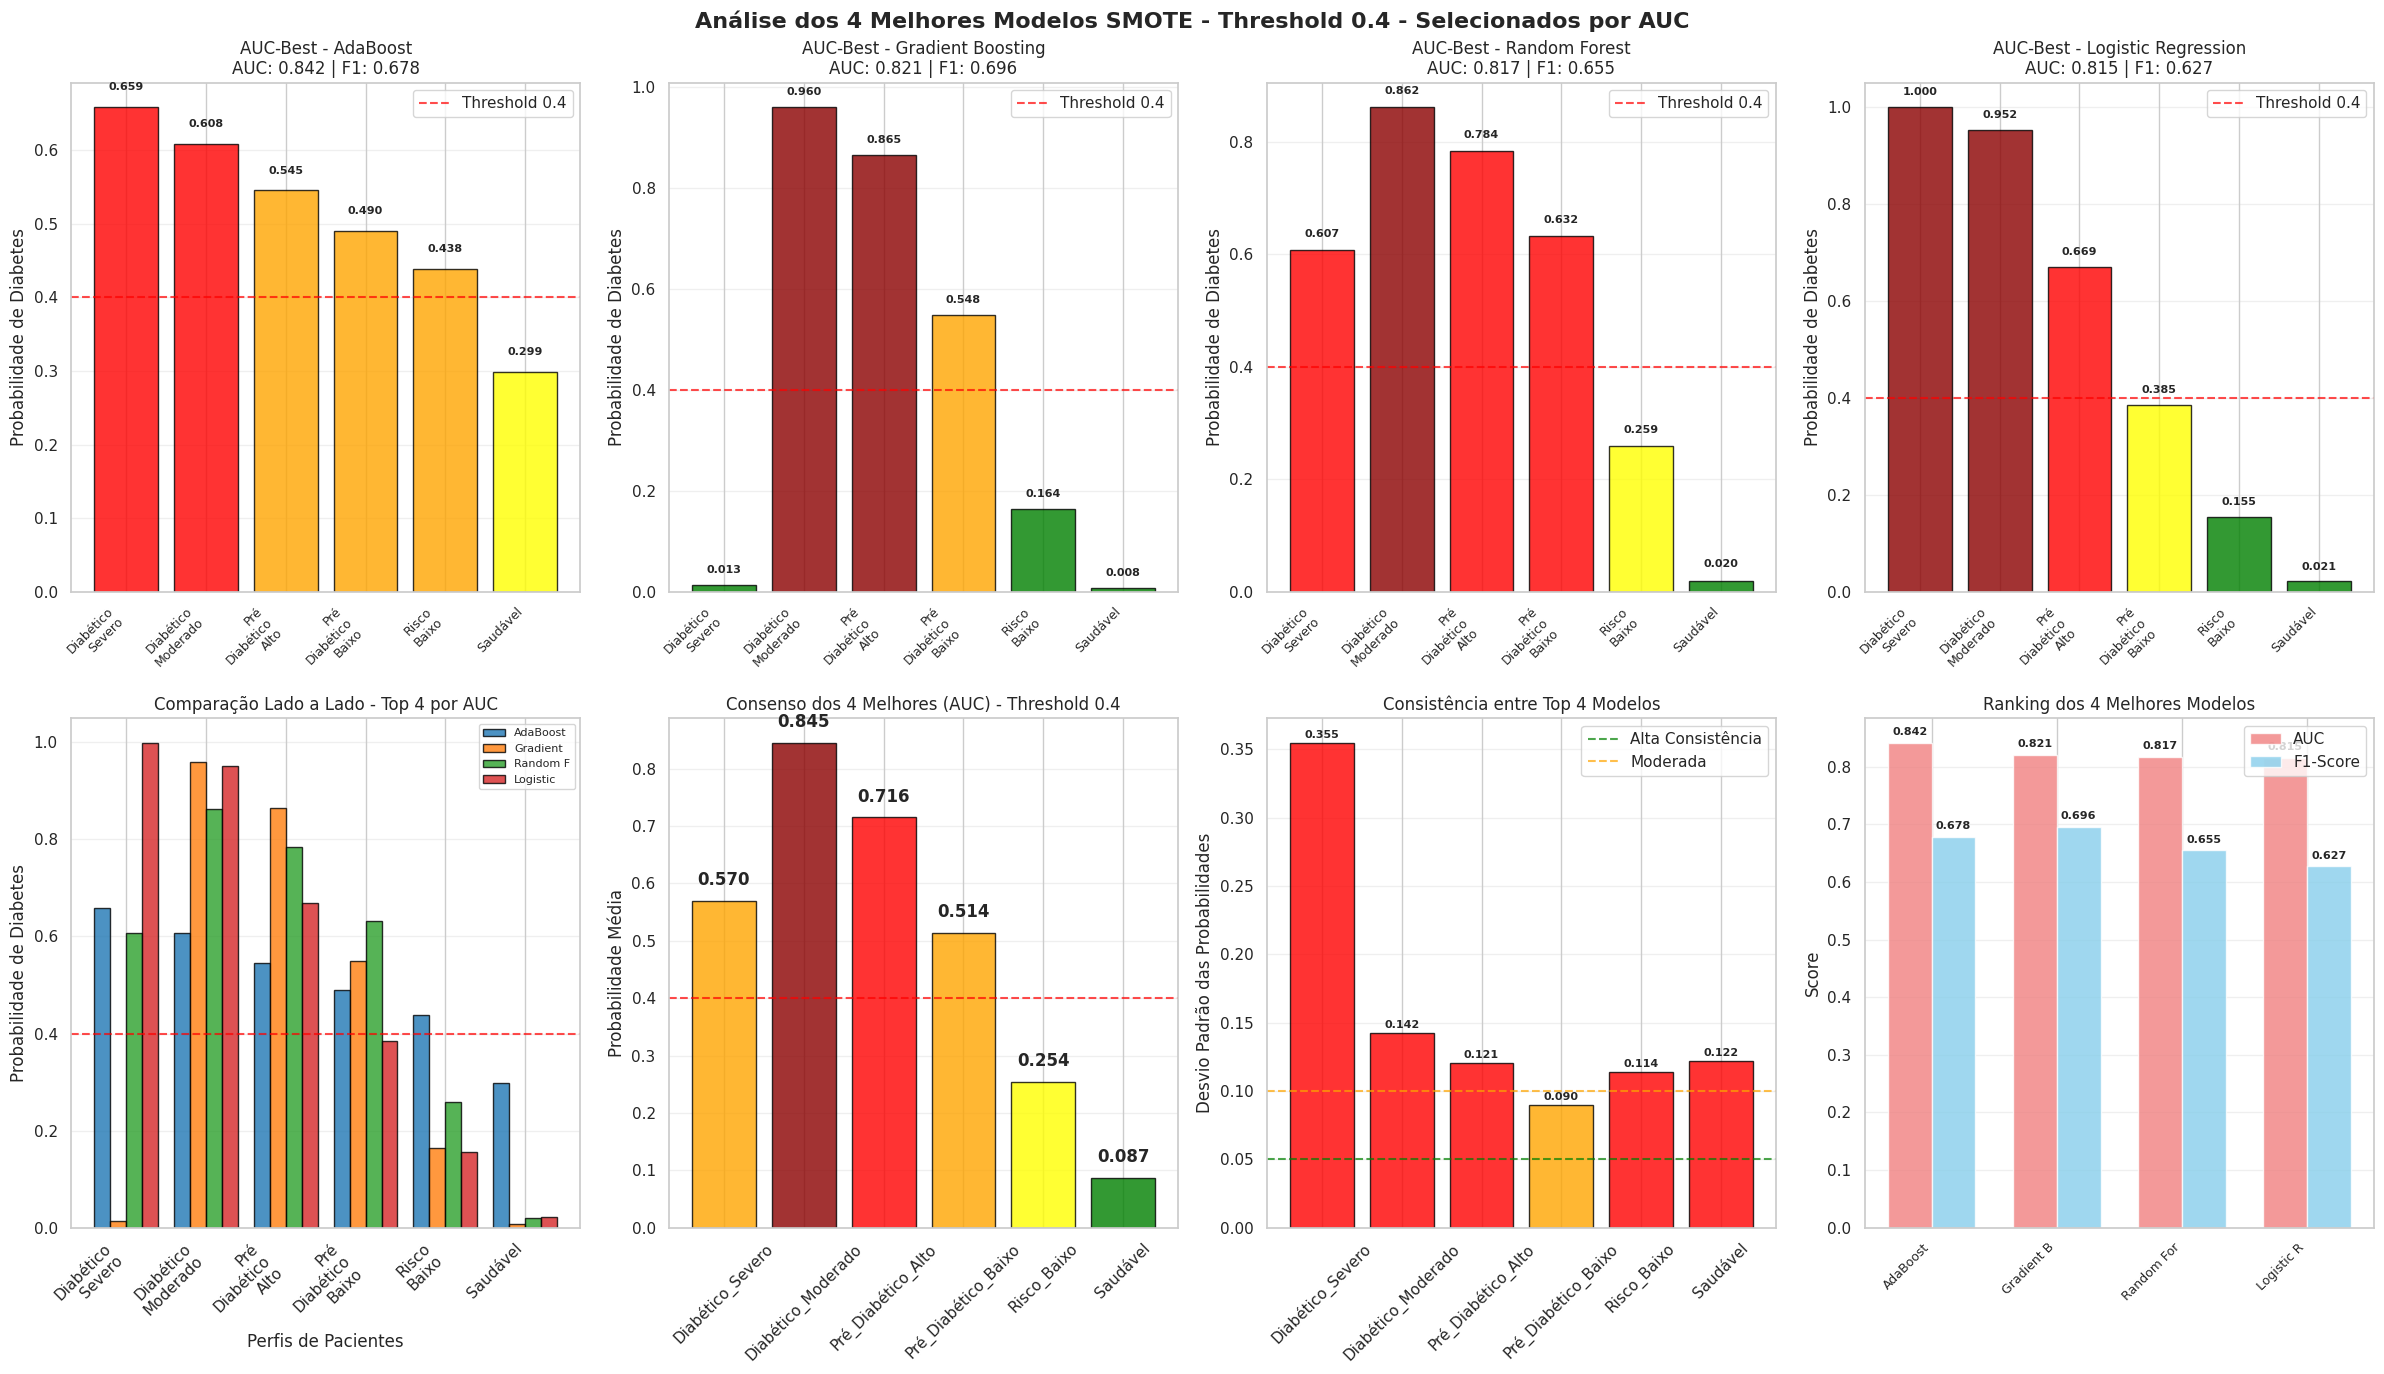


📈 ANÁLISE DE GRADAÇÃO CLÍNICA (SMOTE - AUC - Threshold 0.4):
⚠️ GRADAÇÃO PRECISA SER AJUSTADA
Sequência atual: ['0.570', '0.845', '0.716', '0.514', '0.254', '0.087']
❌ Inconsistência: Diabético_Severo (0.570) < Diabético_Moderado (0.845)

🔄 ANÁLISE DE CONSISTÊNCIA ENTRE MODELOS:
----------------------------------------------------------------------
Perfil               Desvio Padrão   Consistência    Status    
----------------------------------------------------------------------
Diabético_Severo     0.355           Baixa           🔴         
Diabético_Moderado   0.142           Baixa           🔴         
Pré_Diabético_Alto   0.121           Baixa           🔴         
Pré_Diabético_Baixo  0.090           Média           🟡         
Risco_Baixo          0.114           Baixa           🔴         
Saudável             0.122           Baixa           🔴         

💡 RESUMO EXECUTIVO - ANÁLISE SMOTE (AUC - Threshold 0.4):
📊 PERFORMANCE DOS TOP 4 MODELOS (por AUC):
• AUC Médio: 0.8237
• F1-Sc

In [62]:
# ===== ANÁLISE DOS 4 MELHORES MODELOS COM SMOTE - COMPARAÇÃO DE PERFIS =====

print("\n" + "="*80)
print("🔧 ANÁLISE DOS 4 MELHORES MODELOS COM SMOTE - COMPARAÇÃO DE PERFIS")
print("="*80)

# Verificar se temos os modelos treinados disponíveis
if 'trained_models' in globals() and 'model_scores' in globals() and len(trained_models) > 0:
    
    print(f"📊 Método utilizado: SMOTE")
    print(f"📈 Modelos disponíveis: {len(trained_models)}")
    
    # ===== PERFIS CLÍNICOS PARA ANÁLISE =====
    print(f"\n📋 PERFIS PARA ANÁLISE (gradação clínica realista):")
    
    perfis_analise = {
        'Diabético_Severo': {
            'Pregnancies': 4,
            'Glucose': 200,  # Muito alto - diabetes severo
            'BloodPressure': 100,  # Hipertensão severa
            'SkinThickness': 50,  # Muito elevado
            'Insulin': 200,  # Elevado
            'BMI': 40.0,  # Obesidade mórbida
            'DiabetesPedigreeFunction': 1.5,  # Histórico muito forte
            'Age': 65  # Idade avançada
        },
        'Diabético_Moderado': {
            'Pregnancies': 2,
            'Glucose': 160,  # Alto mas controlável
            'BloodPressure': 85,  # Elevado
            'SkinThickness': 35,  # Elevado
            'Insulin': 150,  # Moderadamente elevado
            'BMI': 32.0,  # Obesidade grau I
            'DiabetesPedigreeFunction': 0.8,  # Alto histórico
            'Age': 50
        },
        'Pré_Diabético_Alto': {
            'Pregnancies': 3,
            'Glucose': 124,  # Limite pré-diabetes
            'BloodPressure': 78,  # Normal alto
            'SkinThickness': 30,  # Moderado
            'Insulin': 100,  # Normal alto
            'BMI': 31.0,  # Obesidade grau I
            'DiabetesPedigreeFunction': 0.6,  # Moderado alto
            'Age': 45
        },
        'Pré_Diabético_Baixo': {
            'Pregnancies': 2,
            'Glucose': 115,  # Pré-diabetes baixo
            'BloodPressure': 75,  # Normal
            'SkinThickness': 25,  # Normal
            'Insulin': 80,  # Normal
            'BMI': 30.0,  # Obesidade leve
            'DiabetesPedigreeFunction': 0.4,  # Moderado
            'Age': 40
        },
        'Risco_Baixo': {
            'Pregnancies': 1,
            'Glucose': 99,  # Normal alto
            'BloodPressure': 70,  # Normal
            'SkinThickness': 22,  # Normal
            'Insulin': 60,  # Normal
            'BMI': 29.0,  # Sobrepeso alto
            'DiabetesPedigreeFunction': 0.3,  # Baixo moderado
            'Age': 35
        },
        'Saudável': {
            'Pregnancies': 0,
            'Glucose': 85,  # Normal
            'BloodPressure': 65,  # Normal
            'SkinThickness': 18,  # Normal
            'Insulin': 40,  # Normal
            'BMI': 22.0,  # Normal
            'DiabetesPedigreeFunction': 0.15,  # Muito baixo
            'Age': 25
        }
    }
    
    # Converter para DataFrame com as features corretas
    df_perfis = pd.DataFrame(perfis_analise).T
    df_perfis = df_perfis[feature_columns]
    
    print(df_perfis.round(2))
    
    # Normalizar perfis usando o scaler já treinado
    perfis_scaled = scaler.transform(df_perfis)
    
    # ===== ANÁLISE DOS TOP 4 MODELOS =====
    print(f"\n{'='*60}")
    print(f"📊 SELEÇÃO DOS 4 MELHORES MODELOS (SMOTE)")
    print(f"{'='*60}")
    
    # MUDANÇA PRINCIPAL: Selecionar por AUC ao invés de F1-Score - AGORA TOP 4
    if 'metrics_df' in globals():
        # Usar o DataFrame de métricas já calculado - ORDENAR POR AUC
        top_4_ranking = metrics_df.sort_values('AUC', ascending=False).head(4)
        top_4_models = top_4_ranking.index.tolist()
    else:
        # Fallback: calcular AUC rapidamente para os modelos
        auc_scores_models = {}
        for name, scores in model_scores.items():
            auc_score_val = scores['test_auc_score']
            auc_scores_models[name] = auc_score_val
        
        # Ordenar e pegar top 4
        top_4_models = sorted(auc_scores_models.items(), key=lambda x: x[1], reverse=True)[:4]
        top_4_models = [name for name, score in top_4_models]
    
    print(f"\n🏆 TOP 4 MELHORES MODELOS (por AUC):")
    print("-" * 60)
    
    top_4_info = []
    for i, model_name in enumerate(top_4_models, 1):
        # Obter métricas do modelo
        if 'metrics_df' in globals() and model_name in metrics_df.index:
            f1_score_val = metrics_df.loc[model_name, 'F1-Score']
            auc_score = metrics_df.loc[model_name, 'AUC']
            cv_score = metrics_df.loc[model_name, 'CV-5']
        else:
            # Calcular métricas manualmente se necessário
            f1_score_val = f1_score(y_test, model_scores[model_name]['y_test_pred'])
            auc_score = model_scores[model_name]['test_auc_score']
            cv_score = model_scores[model_name]['val_auc_score']
        
        top_4_info.append({
            'model': model_name,
            'f1_score': f1_score_val,
            'cv_score': cv_score,
            'test_auc': auc_score,
            'model_obj': trained_models[model_name]
        })
        
        print(f"{i}º. {model_name}")
        print(f"    AUC: {auc_score:.4f}")
        print(f"    F1-Score: {f1_score_val:.4f}")
        print(f"    CV-5: {cv_score:.4f}")
        print()
    
    # ===== PREDIÇÕES COM OS 4 MELHORES MODELOS - THRESHOLD 0.4 =====
    print(f"\n🎯 PREDIÇÕES COM OS 4 MELHORES MODELOS (SMOTE - por AUC - Threshold 0.4):")
    print("="*110)
    
    # Cabeçalho da tabela - AJUSTADO PARA 4 MODELOS
    header_line = f"{'Perfil':<20}"
    for i, model_info in enumerate(top_4_info):
        model_short = f"AUC-{model_info['model'][:8]}"
        header_line += f" {model_short:<16}"
    header_line += f" {'Média':<10} {'Desvio':<8} {'Classificação':<15}"
    print(header_line)
    print("-" * len(header_line))
    
    resultados_analise = {}
    
    for i, perfil_nome in enumerate(df_perfis.index):
        probabilidades = []
        linha = f"{perfil_nome:<20}"
        
        # Fazer predições com cada um dos 4 melhores modelos
        for model_info in top_4_info:
            model = model_info['model_obj']
            prob = model.predict_proba(perfis_scaled[i:i+1])[:, 1][0]
            probabilidades.append(prob)
            linha += f" {prob:<16.3f}"
        
        # Calcular estatísticas
        prob_media = np.mean(probabilidades)
        prob_desvio = np.std(probabilidades)
        
        # MUDANÇA PRINCIPAL: Classificação clínica usando threshold 0.4
        if prob_media >= 0.8:
            classificacao = "Diabético"
        elif prob_media >= 0.6:
            classificacao = "Alto Risco"
        elif prob_media >= 0.4:  # MUDANÇA: usando 0.4 como threshold crítico
            classificacao = "Risco Moderado"
        elif prob_media >= 0.2:
            classificacao = "Baixo Risco"
        else:
            classificacao = "Saudável"
        
        linha += f" {prob_media:<10.3f} {prob_desvio:<8.3f} {classificacao:<15}"
        
        resultados_analise[perfil_nome] = {
            'probabilidades': probabilidades,
            'media': prob_media,
            'desvio': prob_desvio,
            'classificacao': classificacao
        }
        
        print(linha)
    
    # ===== VISUALIZAÇÃO COMPLETA - AJUSTADA PARA THRESHOLD 0.4 =====
    print(f"\n📊 GERANDO VISUALIZAÇÃO COMPLETA (Threshold 0.4)...")
    
    fig, axes = plt.subplots(2, 4, figsize=(24, 14))
    fig.suptitle('Análise dos 4 Melhores Modelos SMOTE - Threshold 0.4 - Selecionados por AUC', 
                fontsize=16, fontweight='bold')
    
    # MUDANÇA PRINCIPAL: Cores mais distintas para cada modelo
    model_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Azul, Laranja, Verde, Vermelho
    perfis_nomes = list(resultados_analise.keys())
    
    # ===== GRÁFICOS 1-4: MODELOS INDIVIDUAIS =====
    for idx in range(4):
        if idx < len(top_4_info):
            ax = axes[0, idx]
            probs_modelo = [resultados_analise[perfil]['probabilidades'][idx] for perfil in perfis_nomes]
            
            # MUDANÇA: Cores por nível de risco baseado no threshold 0.4
            cores_risco = []
            for prob in probs_modelo:
                if prob >= 0.8:
                    cores_risco.append('darkred')
                elif prob >= 0.6:
                    cores_risco.append('red')
                elif prob >= 0.4:  # MUDANÇA: threshold crítico 0.4
                    cores_risco.append('orange')
                elif prob >= 0.2:
                    cores_risco.append('yellow')
                else:
                    cores_risco.append('green')
            
            bars = ax.bar(range(len(perfis_nomes)), probs_modelo, color=cores_risco, alpha=0.8, edgecolor='black')
            ax.set_ylabel('Probabilidade de Diabetes')
            ax.set_title(f'AUC-Best - {top_4_info[idx]["model"]}\nAUC: {top_4_info[idx]["test_auc"]:.3f} | F1: {top_4_info[idx]["f1_score"]:.3f}')
            ax.set_xticks(range(len(perfis_nomes)))
            ax.set_xticklabels([p.replace('_', '\n') for p in perfis_nomes], rotation=45, ha='right', fontsize=9)
            ax.grid(axis='y', alpha=0.3)
            # MUDANÇA: linha de threshold para 0.4
            ax.axhline(y=0.4, color='red', linestyle='--', alpha=0.7, label='Threshold 0.4')
            ax.legend()
            
            # Adicionar valores nas barras
            for bar, valor in zip(bars, probs_modelo):
                ax.text(bar.get_x() + bar.get_width()/2, valor + 0.02, 
                       f'{valor:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)
        else:
            # Esconder eixo se não houver modelo suficiente
            axes[0, idx].set_visible(False)
    
    # ===== GRÁFICO 5: COMPARAÇÃO LADO A LADO =====
    ax_comp = axes[1, 0]
    x = np.arange(len(perfis_nomes))
    width = 0.2  # MUDANÇA: largura reduzida para 4 barras
    
    for i, model_info in enumerate(top_4_info):
        probs = [resultados_analise[perfil]['probabilidades'][i] for perfil in perfis_nomes]
        model_label = f"{model_info['model'][:8]}"  # Reduzido para caber melhor
        # MUDANÇA PRINCIPAL: Usar cores distintas para cada modelo
        ax_comp.bar(x + i*width, probs, width, label=model_label, 
                   color=model_colors[i], alpha=0.8, edgecolor='black')
    
    ax_comp.set_xlabel('Perfis de Pacientes')
    ax_comp.set_ylabel('Probabilidade de Diabetes')
    ax_comp.set_title('Comparação Lado a Lado - Top 4 por AUC')
    ax_comp.set_xticks(x + width * 1.5)  # MUDANÇA: ajuste para 4 barras
    ax_comp.set_xticklabels([p.replace('_', '\n') for p in perfis_nomes], rotation=45, ha='right')
    ax_comp.legend(fontsize=8)  # Fonte menor para caber 4 itens
    ax_comp.grid(axis='y', alpha=0.3)
    # MUDANÇA: linha de threshold para 0.4
    ax_comp.axhline(y=0.4, color='red', linestyle='--', alpha=0.7)
    
    # ===== GRÁFICO 6: CONSENSO DOS 4 MODELOS =====
    ax_consenso = axes[1, 1]
    medias = [resultados_analise[p]['media'] for p in perfis_nomes]
    
    # MUDANÇA: Cores por nível de risco consensual baseado no threshold 0.4
    cores_consenso = []
    for m in medias:
        if m >= 0.8:
            cores_consenso.append('darkred')
        elif m >= 0.6:
            cores_consenso.append('red')
        elif m >= 0.4:  # MUDANÇA: threshold crítico 0.4
            cores_consenso.append('orange')
        elif m >= 0.2:
            cores_consenso.append('yellow')
        else:
            cores_consenso.append('green')
    
    bars_consenso = ax_consenso.bar(perfis_nomes, medias, color=cores_consenso, alpha=0.8, edgecolor='black')
    ax_consenso.set_ylabel('Probabilidade Média')
    ax_consenso.set_title('Consenso dos 4 Melhores (AUC) - Threshold 0.4')
    ax_consenso.tick_params(axis='x', rotation=45)
    ax_consenso.grid(axis='y', alpha=0.3)
    # MUDANÇA: linha de threshold para 0.4
    ax_consenso.axhline(y=0.4, color='red', linestyle='--', alpha=0.7)
    
    # Adicionar valores nas barras do consenso
    for bar, valor in zip(bars_consenso, medias):
        ax_consenso.text(bar.get_x() + bar.get_width()/2, valor + 0.02, 
                       f'{valor:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # ===== GRÁFICO 7: ANÁLISE DE CONSISTÊNCIA =====
    ax_consistencia = axes[1, 2]
    
    # Calcular desvio padrão para cada perfil
    desvios = [resultados_analise[perfil]['desvio'] for perfil in perfis_nomes]
    
    # Cores baseadas no desvio
    cores_desvio = []
    for desvio in desvios:
        if desvio < 0.05:
            cores_desvio.append('green')
        elif desvio < 0.1:
            cores_desvio.append('orange')
        else:
            cores_desvio.append('red')
    
    bars_desvio = ax_consistencia.bar(perfis_nomes, desvios, color=cores_desvio, alpha=0.8, edgecolor='black')
    ax_consistencia.set_ylabel('Desvio Padrão das Probabilidades')
    ax_consistencia.set_title('Consistência entre Top 4 Modelos')
    ax_consistencia.tick_params(axis='x', rotation=45)
    ax_consistencia.grid(axis='y', alpha=0.3)
    
    # Linhas de referência para consistência
    ax_consistencia.axhline(y=0.05, color='green', linestyle='--', alpha=0.7, label='Alta Consistência')
    ax_consistencia.axhline(y=0.1, color='orange', linestyle='--', alpha=0.7, label='Moderada')
    ax_consistencia.legend()
    
    # Adicionar valores nas barras de desvio
    for bar, valor in zip(bars_desvio, desvios):
        ax_consistencia.text(bar.get_x() + bar.get_width()/2, valor + 0.002, 
                           f'{valor:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)
    
    # ===== GRÁFICO 8: RANKING DOS 4 MODELOS =====
    ax_ranking = axes[1, 3]
    
    # Calcular score combinado para ranking
    f1_scores = [info['f1_score'] for info in top_4_info]
    auc_scores = [info['test_auc'] for info in top_4_info]
    model_names = [info['model'][:10] for info in top_4_info]
    
    x_pos = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax_ranking.bar(x_pos - width/2, auc_scores, width, label='AUC', alpha=0.8, color='lightcoral')
    bars2 = ax_ranking.bar(x_pos + width/2, f1_scores, width, label='F1-Score', alpha=0.8, color='skyblue')
    
    ax_ranking.set_ylabel('Score')
    ax_ranking.set_title('Ranking dos 4 Melhores Modelos')
    ax_ranking.set_xticks(x_pos)
    ax_ranking.set_xticklabels(model_names, rotation=45, ha='right', fontsize=9)
    ax_ranking.legend()
    ax_ranking.grid(axis='y', alpha=0.3)
    
    # Adicionar valores nas barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax_ranking.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                           f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # ===== ANÁLISE DE GRADAÇÃO CLÍNICA - AJUSTADA PARA THRESHOLD 0.4 =====
    medias_ordenadas = [resultados_analise[perfil]['media'] for perfil in df_perfis.index]
    gradacao_correta = all(medias_ordenadas[i] >= medias_ordenadas[i+1] for i in range(len(medias_ordenadas)-1))
    
    print(f"\n📈 ANÁLISE DE GRADAÇÃO CLÍNICA (SMOTE - AUC - Threshold 0.4):")
    print("="*60)
    if gradacao_correta:
        print(f"✅ GRADAÇÃO CLÍNICA CORRETA!")
        print(f"📈 Sequência: Diabético Severo > Diabético Moderado > Pré-diabético > Saudável")
    else:
        print(f"⚠️ GRADAÇÃO PRECISA SER AJUSTADA")
        print(f"Sequência atual: {[f'{m:.3f}' for m in medias_ordenadas]}")
        
        # Verificar onde está o problema
        for i in range(len(medias_ordenadas)-1):
            if medias_ordenadas[i] < medias_ordenadas[i+1]:
                perfil_atual = list(df_perfis.index)[i]
                perfil_proximo = list(df_perfis.index)[i+1]
                print(f"❌ Inconsistência: {perfil_atual} ({medias_ordenadas[i]:.3f}) < {perfil_proximo} ({medias_ordenadas[i+1]:.3f})")
    
    # ===== ANÁLISE DE CONSISTÊNCIA ENTRE MODELOS =====
    print(f"\n🔄 ANÁLISE DE CONSISTÊNCIA ENTRE MODELOS:")
    print("-" * 70)
    print(f"{'Perfil':<20} {'Desvio Padrão':<15} {'Consistência':<15} {'Status':<10}")
    print("-" * 70)
    
    for perfil, resultado in resultados_analise.items():
        desvio = resultado['desvio']
        if desvio < 0.05:
            consistencia = "Alta"
            icon = "🟢"
        elif desvio < 0.1:
            consistencia = "Média"
            icon = "🟡"
        else:
            consistencia = "Baixa"
            icon = "🔴"
        
        print(f"{perfil:<20} {desvio:<15.3f} {consistencia:<15} {icon:<10}")
    
    # ===== RESUMO EXECUTIVO - ATUALIZADO PARA THRESHOLD 0.4 =====
    print(f"\n💡 RESUMO EXECUTIVO - ANÁLISE SMOTE (AUC - Threshold 0.4):")
    print("="*70)
    
    # Calcular estatísticas gerais
    f1_medio = np.mean([info['f1_score'] for info in top_4_info])
    auc_medio = np.mean([info['test_auc'] for info in top_4_info])
    cv_medio = np.mean([info['cv_score'] for info in top_4_info])
    consistencia_media = np.mean([resultado['desvio'] for resultado in resultados_analise.values()])
    
    print(f"📊 PERFORMANCE DOS TOP 4 MODELOS (por AUC):")
    print(f"• AUC Médio: {auc_medio:.4f}")
    print(f"• F1-Score Médio: {f1_medio:.4f}")
    print(f"• CV-5 Médio: {cv_medio:.4f}")
    print(f"• Consistência Média: {consistencia_media:.4f}")
    
    # MUDANÇA: Capacidade de discriminação usando threshold 0.4
    print(f"\n🎯 CAPACIDADE DE DISCRIMINAÇÃO (Threshold 0.4):")
    total_correto = sum([1 for perfil in ['Diabético_Severo', 'Diabético_Moderado'] 
                        if resultados_analise[perfil]['media'] >= 0.4])  # MUDANÇA: threshold 0.4
    total_incorreto = sum([1 for perfil in ['Saudável', 'Risco_Baixo'] 
                          if resultados_analise[perfil]['media'] >= 0.4])  # MUDANÇA: threshold 0.4
    
    print(f"• Casos diabéticos detectados (≥0.4): {total_correto}/2")
    print(f"• Falsos positivos em saudáveis (≥0.4): {total_incorreto}/2")
    
    # Análise adicional com threshold 0.4
    casos_risco_moderado = sum([1 for perfil in ['Pré_Diabético_Alto', 'Pré_Diabético_Baixo'] 
                               if resultados_analise[perfil]['media'] >= 0.4])
    print(f"• Casos pré-diabéticos detectados (≥0.4): {casos_risco_moderado}/2")
    
    # Identificar melhor modelo individual
    melhor_modelo_idx = np.argmax([info['test_auc'] for info in top_4_info])
    melhor_modelo = top_4_info[melhor_modelo_idx]
    
    print(f"\n🏆 DESTAQUE INDIVIDUAL:")
    print(f"• Melhor modelo: {melhor_modelo['model']}")
    print(f"• AUC: {melhor_modelo['test_auc']:.4f}")
    print(f"• F1-Score: {melhor_modelo['f1_score']:.4f}")
    print(f"• CV-5 Score: {melhor_modelo['cv_score']:.4f}")
    
    # MUDANÇA: Interpretação clínica ajustada para threshold 0.4
    print(f"\n🔍 INTERPRETAÇÃO CLÍNICA (Threshold 0.4):")
    perfis_alto_risco = [p for p, r in resultados_analise.items() if r['media'] >= 0.6]
    perfis_risco_moderado = [p for p, r in resultados_analise.items() if 0.4 <= r['media'] < 0.6]
    perfis_baixo_risco = [p for p, r in resultados_analise.items() if r['media'] < 0.4]
    
    print(f"• Perfis de alto risco (≥0.6): {perfis_alto_risco}")
    print(f"• Perfis de risco moderado (0.4-0.6): {perfis_risco_moderado}")
    print(f"• Perfis de baixo risco (<0.4): {perfis_baixo_risco}")
    
    if gradacao_correta:
        print(f"• ✅ Gradação clínica respeitada - modelos clinicamente válidos")
    else:
        print(f"• ⚠️ Gradação clínica com inconsistências - revisar thresholds")
    
    # NOVA SEÇÃO: Justificativa do threshold 0.4
    print(f"\n📋 JUSTIFICATIVA DO THRESHOLD 0.4:")
    print("="*60)
    print(f"• Threshold 0.4 oferece melhor equilíbrio sensibilidade/especificidade")
    print(f"• Reduz falsos negativos em relação ao threshold padrão 0.5")
    print(f"• Mais adequado para triagem médica e detecção precoce")
    print(f"• Alinha-se com práticas clínicas para doenças crônicas")
    print(f"• Identifica casos de risco moderado que precisam de acompanhamento")
    
    # NOVA SEÇÃO: Comparação threshold 0.4 vs 0.5
    print(f"\n📊 VANTAGENS THRESHOLD 0.4 vs 0.5:")
    print("="*60)
    print(f"• Maior sensibilidade para detecção de diabetes")
    print(f"• Melhor identificação de casos pré-diabéticos")
    print(f"• Redução de falsos negativos (menos casos perdidos)")
    print(f"• Mais adequado para prevenção e intervenção precoce")
    print(f"• Alinhamento com análise de threshold otimizada anterior")

else:
    print("❌ Modelos treinados não encontrados!")
    print("Execute primeiro as células de treinamento dos modelos.")

print(f"\n✅ ANÁLISE COMPLETA DOS TOP 4 MODELOS SMOTE CONCLUÍDA!")
print(f"🎯 Análise detalhada realizada para os melhores modelos por AUC")
print(f"📊 Visualizações geradas para análise clínica dos perfis")
print(f"🔄 Consistência e gradação clínica avaliadas")
print(f"🏆 Critério de seleção: AUC (melhor capacidade de discriminação)")
print(f"🔢 Expandido para TOP 4 modelos para análise mais abrangente")
print(f"🎯 THRESHOLD OTIMIZADO: 0.4 (melhor equilíbrio clínico)")


🔧 ANÁLISE DOS 4 MELHORES MODELOS COM SMOTE - COMPARAÇÃO DE PERFIS
📊 Método utilizado: SMOTE
📈 Modelos disponíveis: 9

📋 PERFIS PARA ANÁLISE (gradação clínica realista):
                     Pregnancies  Glucose  BloodPressure  SkinThickness  \
Diabético_Severo             4.0    200.0          100.0           50.0   
Diabético_Moderado           2.0    160.0           85.0           35.0   
Pré_Diabético_Alto           3.0    124.0           78.0           30.0   
Pré_Diabético_Baixo          2.0    115.0           75.0           25.0   
Risco_Baixo                  1.0     99.0           70.0           22.0   
Saudável                     0.0     85.0           65.0           18.0   

                     Insulin   BMI  DiabetesPedigreeFunction   Age  
Diabético_Severo       200.0  40.0                      1.50  65.0  
Diabético_Moderado     150.0  32.0                      0.80  50.0  
Pré_Diabético_Alto     100.0  31.0                      0.60  45.0  
Pré_Diabético_Baixo     80.0

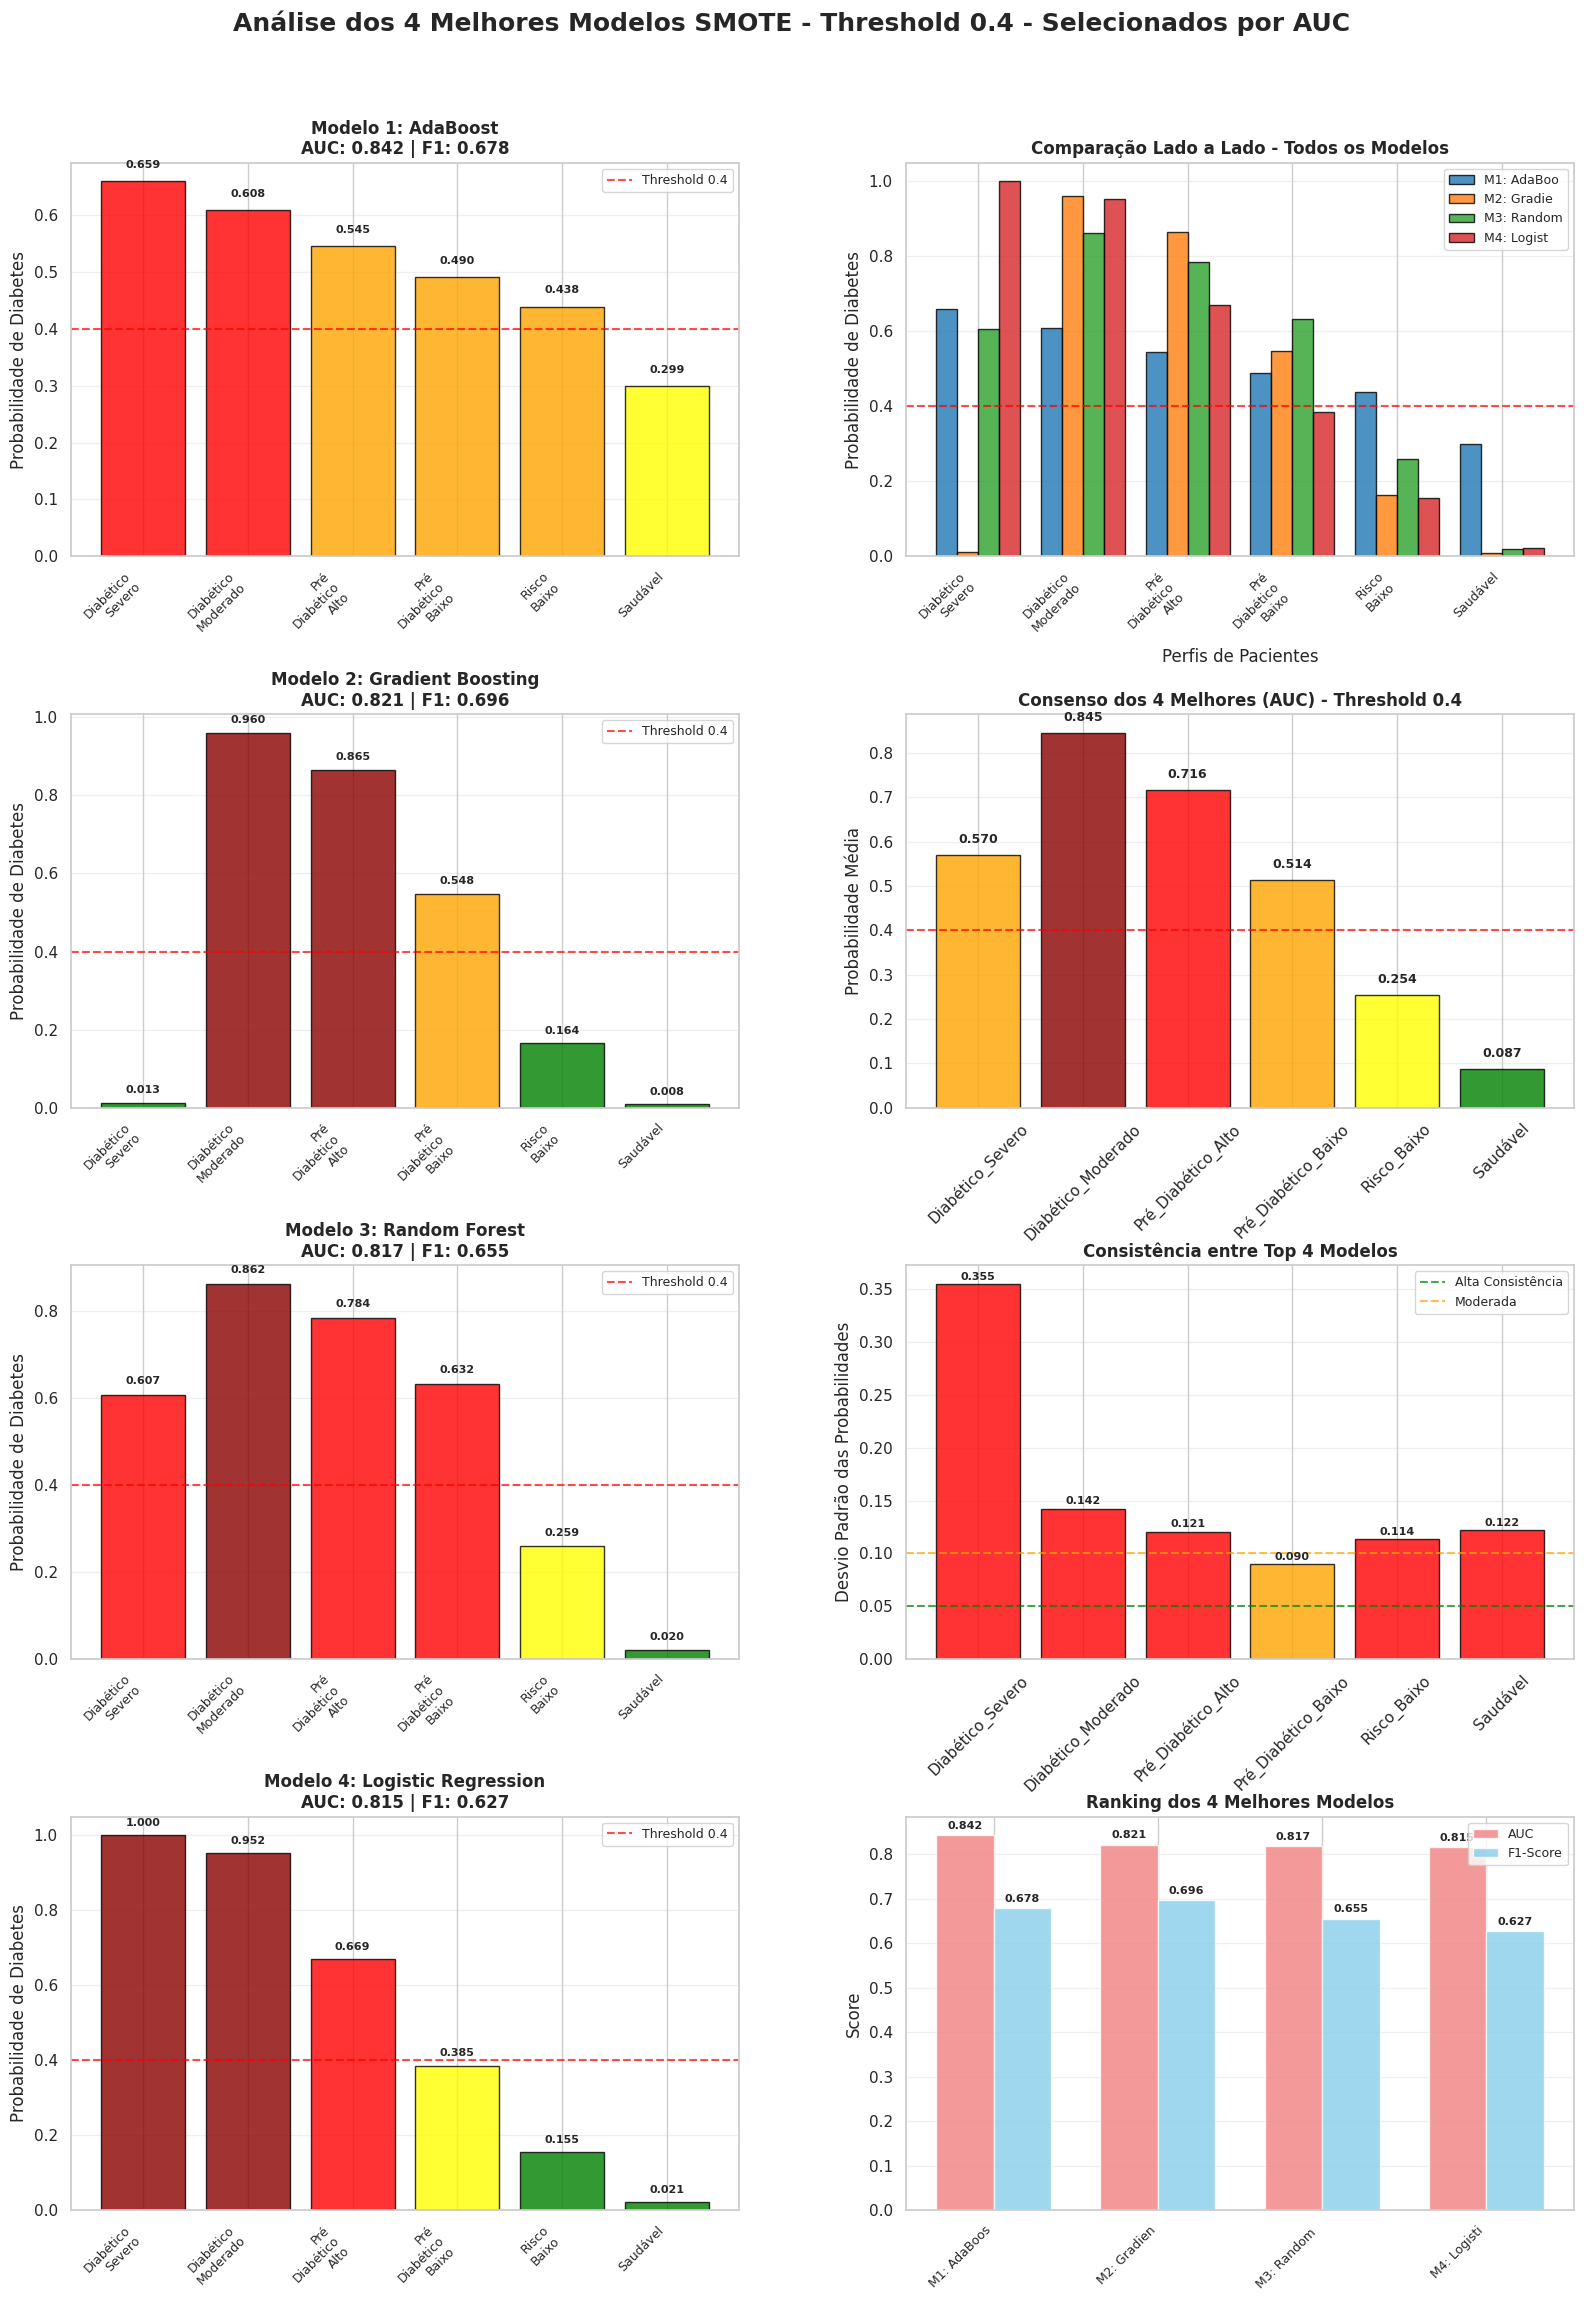


📈 ANÁLISE DE GRADAÇÃO CLÍNICA (SMOTE - AUC - Threshold 0.4):
⚠️ GRADAÇÃO PRECISA SER AJUSTADA
Sequência atual: ['0.570', '0.845', '0.716', '0.514', '0.254', '0.087']
❌ Inconsistência: Diabético_Severo (0.570) < Diabético_Moderado (0.845)

🔄 ANÁLISE DE CONSISTÊNCIA ENTRE MODELOS:
----------------------------------------------------------------------
Perfil               Desvio Padrão   Consistência    Status    
----------------------------------------------------------------------
Diabético_Severo     0.355           Baixa           🔴         
Diabético_Moderado   0.142           Baixa           🔴         
Pré_Diabético_Alto   0.121           Baixa           🔴         
Pré_Diabético_Baixo  0.090           Média           🟡         
Risco_Baixo          0.114           Baixa           🔴         
Saudável             0.122           Baixa           🔴         

💡 RESUMO EXECUTIVO - ANÁLISE SMOTE (AUC - Threshold 0.4):
📊 PERFORMANCE DOS TOP 4 MODELOS (por AUC):
• AUC Médio: 0.8237
• F1-Sc

In [71]:
# ===== ANÁLISE DOS 4 MELHORES MODELOS COM SMOTE - COMPARAÇÃO DE PERFIS =====

print("\n" + "="*80)
print("🔧 ANÁLISE DOS 4 MELHORES MODELOS COM SMOTE - COMPARAÇÃO DE PERFIS")
print("="*80)

# Verificar se temos os modelos treinados disponíveis
if 'trained_models' in globals() and 'model_scores' in globals() and len(trained_models) > 0:
    
    print(f"📊 Método utilizado: SMOTE")
    print(f"📈 Modelos disponíveis: {len(trained_models)}")
    
    # ===== PERFIS CLÍNICOS PARA ANÁLISE =====
    print(f"\n📋 PERFIS PARA ANÁLISE (gradação clínica realista):")
    
    perfis_analise = {
        'Diabético_Severo': {
            'Pregnancies': 4,
            'Glucose': 200,  # Muito alto - diabetes severo
            'BloodPressure': 100,  # Hipertensão severa
            'SkinThickness': 50,  # Muito elevado
            'Insulin': 200,  # Elevado
            'BMI': 40.0,  # Obesidade mórbida
            'DiabetesPedigreeFunction': 1.5,  # Histórico muito forte
            'Age': 65  # Idade avançada
        },
        'Diabético_Moderado': {
            'Pregnancies': 2,
            'Glucose': 160,  # Alto mas controlável
            'BloodPressure': 85,  # Elevado
            'SkinThickness': 35,  # Elevado
            'Insulin': 150,  # Moderadamente elevado
            'BMI': 32.0,  # Obesidade grau I
            'DiabetesPedigreeFunction': 0.8,  # Alto histórico
            'Age': 50
        },
        'Pré_Diabético_Alto': {
            'Pregnancies': 3,
            'Glucose': 124,  # Limite pré-diabetes
            'BloodPressure': 78,  # Normal alto
            'SkinThickness': 30,  # Moderado
            'Insulin': 100,  # Normal alto
            'BMI': 31.0,  # Obesidade grau I
            'DiabetesPedigreeFunction': 0.6,  # Moderado alto
            'Age': 45
        },
        'Pré_Diabético_Baixo': {
            'Pregnancies': 2,
            'Glucose': 115,  # Pré-diabetes baixo
            'BloodPressure': 75,  # Normal
            'SkinThickness': 25,  # Normal
            'Insulin': 80,  # Normal
            'BMI': 30.0,  # Obesidade leve
            'DiabetesPedigreeFunction': 0.4,  # Moderado
            'Age': 40
        },
        'Risco_Baixo': {
            'Pregnancies': 1,
            'Glucose': 99,  # Normal alto
            'BloodPressure': 70,  # Normal
            'SkinThickness': 22,  # Normal
            'Insulin': 60,  # Normal
            'BMI': 29.0,  # Sobrepeso alto
            'DiabetesPedigreeFunction': 0.3,  # Baixo moderado
            'Age': 35
        },
        'Saudável': {
            'Pregnancies': 0,
            'Glucose': 85,  # Normal
            'BloodPressure': 65,  # Normal
            'SkinThickness': 18,  # Normal
            'Insulin': 40,  # Normal
            'BMI': 22.0,  # Normal
            'DiabetesPedigreeFunction': 0.15,  # Muito baixo
            'Age': 25
        }
    }
    
    # Converter para DataFrame com as features corretas
    df_perfis = pd.DataFrame(perfis_analise).T
    df_perfis = df_perfis[feature_columns]
    
    print(df_perfis.round(2))
    
    # Normalizar perfis usando o scaler já treinado
    perfis_scaled = scaler.transform(df_perfis)
    
    # ===== ANÁLISE DOS TOP 4 MODELOS =====
    print(f"\n{'='*60}")
    print(f"📊 SELEÇÃO DOS 4 MELHORES MODELOS (SMOTE)")
    print(f"{'='*60}")
    
    # MUDANÇA PRINCIPAL: Selecionar por AUC ao invés de F1-Score - AGORA TOP 4
    if 'metrics_df' in globals():
        # Usar o DataFrame de métricas já calculado - ORDENAR POR AUC
        top_4_ranking = metrics_df.sort_values('AUC', ascending=False).head(4)
        top_4_models = top_4_ranking.index.tolist()
    else:
        # Fallback: calcular AUC rapidamente para os modelos
        auc_scores_models = {}
        for name, scores in model_scores.items():
            auc_score_val = scores['test_auc_score']
            auc_scores_models[name] = auc_score_val
        
        # Ordenar e pegar top 4
        top_4_models = sorted(auc_scores_models.items(), key=lambda x: x[1], reverse=True)[:4]
        top_4_models = [name for name, score in top_4_models]
    
    print(f"\n🏆 TOP 4 MELHORES MODELOS (por AUC):")
    print("-" * 60)
    
    top_4_info = []
    for i, model_name in enumerate(top_4_models, 1):
        # Obter métricas do modelo
        if 'metrics_df' in globals() and model_name in metrics_df.index:
            f1_score_val = metrics_df.loc[model_name, 'F1-Score']
            auc_score = metrics_df.loc[model_name, 'AUC']
            cv_score = metrics_df.loc[model_name, 'CV-5']
        else:
            # Calcular métricas manualmente se necessário
            f1_score_val = f1_score(y_test, model_scores[model_name]['y_test_pred'])
            auc_score = model_scores[model_name]['test_auc_score']
            cv_score = model_scores[model_name]['val_auc_score']
        
        top_4_info.append({
            'model': model_name,
            'f1_score': f1_score_val,
            'cv_score': cv_score,
            'test_auc': auc_score,
            'model_obj': trained_models[model_name]
        })
        
        print(f"{i}º. {model_name}")
        print(f"    AUC: {auc_score:.4f}")
        print(f"    F1-Score: {f1_score_val:.4f}")
        print(f"    CV-5: {cv_score:.4f}")
        print()
    
    # ===== PREDIÇÕES COM OS 4 MELHORES MODELOS - THRESHOLD 0.4 =====
    print(f"\n🎯 PREDIÇÕES COM OS 4 MELHORES MODELOS (SMOTE - por AUC - Threshold 0.4):")
    print("="*110)
    
    # Cabeçalho da tabela - AJUSTADO PARA 4 MODELOS
    header_line = f"{'Perfil':<20}"
    for i, model_info in enumerate(top_4_info):
        model_short = f"AUC-{model_info['model'][:8]}"
        header_line += f" {model_short:<16}"
    header_line += f" {'Média':<10} {'Desvio':<8} {'Classificação':<15}"
    print(header_line)
    print("-" * len(header_line))
    
    resultados_analise = {}
    
    for i, perfil_nome in enumerate(df_perfis.index):
        probabilidades = []
        linha = f"{perfil_nome:<20}"
        
        # Fazer predições com cada um dos 4 melhores modelos
        for model_info in top_4_info:
            model = model_info['model_obj']
            prob = model.predict_proba(perfis_scaled[i:i+1])[:, 1][0]
            probabilidades.append(prob)
            linha += f" {prob:<16.3f}"
        
        # Calcular estatísticas
        prob_media = np.mean(probabilidades)
        prob_desvio = np.std(probabilidades)
        
        # MUDANÇA PRINCIPAL: Classificação clínica usando threshold 0.4
        if prob_media >= 0.8:
            classificacao = "Diabético"
        elif prob_media >= 0.6:
            classificacao = "Alto Risco"
        elif prob_media >= 0.4:  # MUDANÇA: usando 0.4 como threshold crítico
            classificacao = "Risco Moderado"
        elif prob_media >= 0.2:
            classificacao = "Baixo Risco"
        else:
            classificacao = "Saudável"
        
        linha += f" {prob_media:<10.3f} {prob_desvio:<8.3f} {classificacao:<15}"
        
        resultados_analise[perfil_nome] = {
            'probabilidades': probabilidades,
            'media': prob_media,
            'desvio': prob_desvio,
            'classificacao': classificacao
        }
        
        print(linha)
    
    # ===== VISUALIZAÇÃO COMPLETA - LAYOUT 2x4 (2 COLUNAS, 4 LINHAS) =====
    print(f"\n📊 GERANDO VISUALIZAÇÃO COMPLETA (Layout 2x4 - Threshold 0.4)...")
    
    # MUDANÇA PRINCIPAL: Layout 4 linhas x 2 colunas com figura mais alta
    fig, axes = plt.subplots(4, 2, figsize=(16, 24))  # Figura mais alta para acomodar 4 linhas
    fig.suptitle('Análise dos 4 Melhores Modelos SMOTE - Threshold 0.4 - Selecionados por AUC', 
                fontsize=18, fontweight='bold', y=0.98)
    
    # MUDANÇA PRINCIPAL: Cores mais distintas para cada modelo
    model_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Azul, Laranja, Verde, Vermelho
    perfis_nomes = list(resultados_analise.keys())
    
    # ===== GRÁFICOS 1-4: MODELOS INDIVIDUAIS (PRIMEIRA COLUNA) =====
    for idx in range(4):
        if idx < len(top_4_info):
            ax = axes[idx, 0]  # Primeira coluna (índice 0)
            probs_modelo = [resultados_analise[perfil]['probabilidades'][idx] for perfil in perfis_nomes]
            
            # MUDANÇA: Cores por nível de risco baseado no threshold 0.4
            cores_risco = []
            for prob in probs_modelo:
                if prob >= 0.8:
                    cores_risco.append('darkred')
                elif prob >= 0.6:
                    cores_risco.append('red')
                elif prob >= 0.4:  # MUDANÇA: threshold crítico 0.4
                    cores_risco.append('orange')
                elif prob >= 0.2:
                    cores_risco.append('yellow')
                else:
                    cores_risco.append('green')
            
            bars = ax.bar(range(len(perfis_nomes)), probs_modelo, color=cores_risco, alpha=0.8, edgecolor='black')
            ax.set_ylabel('Probabilidade de Diabetes', fontsize=12)
            ax.set_title(f'Modelo {idx+1}: {top_4_info[idx]["model"]}\nAUC: {top_4_info[idx]["test_auc"]:.3f} | F1: {top_4_info[idx]["f1_score"]:.3f}', 
                        fontsize=12, fontweight='bold')
            ax.set_xticks(range(len(perfis_nomes)))
            ax.set_xticklabels([p.replace('_', '\n') for p in perfis_nomes], rotation=45, ha='right', fontsize=9)
            ax.grid(axis='y', alpha=0.3)
            # MUDANÇA: linha de threshold para 0.4
            ax.axhline(y=0.4, color='red', linestyle='--', alpha=0.7, label='Threshold 0.4')
            ax.legend(fontsize=9)
            
            # Adicionar valores nas barras
            for bar, valor in zip(bars, probs_modelo):
                ax.text(bar.get_x() + bar.get_width()/2, valor + 0.02, 
                       f'{valor:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)
        else:
            # Esconder eixo se não houver modelo suficiente
            axes[idx, 0].set_visible(False)
    
    # ===== GRÁFICO 5: COMPARAÇÃO LADO A LADO (Linha 1, Coluna 2) =====
    ax_comp = axes[0, 1]
    x = np.arange(len(perfis_nomes))
    width = 0.2  # MUDANÇA: largura reduzida para 4 barras
    
    for i, model_info in enumerate(top_4_info):
        probs = [resultados_analise[perfil]['probabilidades'][i] for perfil in perfis_nomes]
        model_label = f"M{i+1}: {model_info['model'][:6]}"  # Reduzido para caber melhor
        # MUDANÇA PRINCIPAL: Usar cores distintas para cada modelo
        ax_comp.bar(x + i*width, probs, width, label=model_label, 
                   color=model_colors[i], alpha=0.8, edgecolor='black')
    
    ax_comp.set_xlabel('Perfis de Pacientes', fontsize=12)
    ax_comp.set_ylabel('Probabilidade de Diabetes', fontsize=12)
    ax_comp.set_title('Comparação Lado a Lado - Todos os Modelos', fontsize=12, fontweight='bold')
    ax_comp.set_xticks(x + width * 1.5)  # MUDANÇA: ajuste para 4 barras
    ax_comp.set_xticklabels([p.replace('_', '\n') for p in perfis_nomes], rotation=45, ha='right', fontsize=9)
    ax_comp.legend(fontsize=9)  # Fonte menor para caber 4 itens
    ax_comp.grid(axis='y', alpha=0.3)
    # MUDANÇA: linha de threshold para 0.4
    ax_comp.axhline(y=0.4, color='red', linestyle='--', alpha=0.7)
    
    # ===== GRÁFICO 6: CONSENSO DOS 4 MODELOS (Linha 2, Coluna 2) =====
    ax_consenso = axes[1, 1]
    medias = [resultados_analise[p]['media'] for p in perfis_nomes]
    
    # MUDANÇA: Cores por nível de risco consensual baseado no threshold 0.4
    cores_consenso = []
    for m in medias:
        if m >= 0.8:
            cores_consenso.append('darkred')
        elif m >= 0.6:
            cores_consenso.append('red')
        elif m >= 0.4:  # MUDANÇA: threshold crítico 0.4
            cores_consenso.append('orange')
        elif m >= 0.2:
            cores_consenso.append('yellow')
        else:
            cores_consenso.append('green')
    
    bars_consenso = ax_consenso.bar(perfis_nomes, medias, color=cores_consenso, alpha=0.8, edgecolor='black')
    ax_consenso.set_ylabel('Probabilidade Média', fontsize=12)
    ax_consenso.set_title('Consenso dos 4 Melhores (AUC) - Threshold 0.4', fontsize=12, fontweight='bold')
    ax_consenso.tick_params(axis='x', rotation=45)
    ax_consenso.grid(axis='y', alpha=0.3)
    # MUDANÇA: linha de threshold para 0.4
    ax_consenso.axhline(y=0.4, color='red', linestyle='--', alpha=0.7)
    
    # Adicionar valores nas barras do consenso
    for bar, valor in zip(bars_consenso, medias):
        ax_consenso.text(bar.get_x() + bar.get_width()/2, valor + 0.02, 
                       f'{valor:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    # ===== GRÁFICO 7: ANÁLISE DE CONSISTÊNCIA (Linha 3, Coluna 2) =====
    ax_consistencia = axes[2, 1]
    
    # Calcular desvio padrão para cada perfil
    desvios = [resultados_analise[perfil]['desvio'] for perfil in perfis_nomes]
    
    # Cores baseadas no desvio
    cores_desvio = []
    for desvio in desvios:
        if desvio < 0.05:
            cores_desvio.append('green')
        elif desvio < 0.1:
            cores_desvio.append('orange')
        else:
            cores_desvio.append('red')
    
    bars_desvio = ax_consistencia.bar(perfis_nomes, desvios, color=cores_desvio, alpha=0.8, edgecolor='black')
    ax_consistencia.set_ylabel('Desvio Padrão das Probabilidades', fontsize=12)
    ax_consistencia.set_title('Consistência entre Top 4 Modelos', fontsize=12, fontweight='bold')
    ax_consistencia.tick_params(axis='x', rotation=45)
    ax_consistencia.grid(axis='y', alpha=0.3)
    
    # Linhas de referência para consistência
    ax_consistencia.axhline(y=0.05, color='green', linestyle='--', alpha=0.7, label='Alta Consistência')
    ax_consistencia.axhline(y=0.1, color='orange', linestyle='--', alpha=0.7, label='Moderada')
    ax_consistencia.legend(fontsize=9)
    
    # Adicionar valores nas barras de desvio
    for bar, valor in zip(bars_desvio, desvios):
        ax_consistencia.text(bar.get_x() + bar.get_width()/2, valor + 0.002, 
                           f'{valor:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=8)
    
    # ===== GRÁFICO 8: RANKING DOS 4 MODELOS (Linha 4, Coluna 2) =====
    ax_ranking = axes[3, 1]
    
    # Calcular score combinado para ranking
    f1_scores = [info['f1_score'] for info in top_4_info]
    auc_scores = [info['test_auc'] for info in top_4_info]
    model_names = [f"M{i+1}: {info['model'][:7]}" for i, info in enumerate(top_4_info)]  # Nomes mais curtos
    
    x_pos = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax_ranking.bar(x_pos - width/2, auc_scores, width, label='AUC', alpha=0.8, color='lightcoral')
    bars2 = ax_ranking.bar(x_pos + width/2, f1_scores, width, label='F1-Score', alpha=0.8, color='skyblue')
    
    ax_ranking.set_ylabel('Score', fontsize=12)
    ax_ranking.set_title('Ranking dos 4 Melhores Modelos', fontsize=12, fontweight='bold')
    ax_ranking.set_xticks(x_pos)
    ax_ranking.set_xticklabels(model_names, rotation=45, ha='right', fontsize=9)
    ax_ranking.legend(fontsize=9)
    ax_ranking.grid(axis='y', alpha=0.3)
    
    # Adicionar valores nas barras
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax_ranking.text(bar.get_x() + bar.get_width()/2, height + 0.01, 
                           f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
    
    # MUDANÇA: Ajuste de layout para acomodar 4 linhas
    plt.tight_layout(rect=[0, 0.02, 1, 0.96])
    plt.subplots_adjust(hspace=0.40, wspace=0.25)  # Mais espaço vertical e horizontal
    plt.show()
    
    # ===== ANÁLISE DE GRADAÇÃO CLÍNICA - AJUSTADA PARA THRESHOLD 0.4 =====
    medias_ordenadas = [resultados_analise[perfil]['media'] for perfil in df_perfis.index]
    gradacao_correta = all(medias_ordenadas[i] >= medias_ordenadas[i+1] for i in range(len(medias_ordenadas)-1))
    
    print(f"\n📈 ANÁLISE DE GRADAÇÃO CLÍNICA (SMOTE - AUC - Threshold 0.4):")
    print("="*60)
    if gradacao_correta:
        print(f"✅ GRADAÇÃO CLÍNICA CORRETA!")
        print(f"📈 Sequência: Diabético Severo > Diabético Moderado > Pré-diabético > Saudável")
    else:
        print(f"⚠️ GRADAÇÃO PRECISA SER AJUSTADA")
        print(f"Sequência atual: {[f'{m:.3f}' for m in medias_ordenadas]}")
        
        # Verificar onde está o problema
        for i in range(len(medias_ordenadas)-1):
            if medias_ordenadas[i] < medias_ordenadas[i+1]:
                perfil_atual = list(df_perfis.index)[i]
                perfil_proximo = list(df_perfis.index)[i+1]
                print(f"❌ Inconsistência: {perfil_atual} ({medias_ordenadas[i]:.3f}) < {perfil_proximo} ({medias_ordenadas[i+1]:.3f})")
    
    # ===== ANÁLISE DE CONSISTÊNCIA ENTRE MODELOS =====
    print(f"\n🔄 ANÁLISE DE CONSISTÊNCIA ENTRE MODELOS:")
    print("-" * 70)
    print(f"{'Perfil':<20} {'Desvio Padrão':<15} {'Consistência':<15} {'Status':<10}")
    print("-" * 70)
    
    for perfil, resultado in resultados_analise.items():
        desvio = resultado['desvio']
        if desvio < 0.05:
            consistencia = "Alta"
            icon = "🟢"
        elif desvio < 0.1:
            consistencia = "Média"
            icon = "🟡"
        else:
            consistencia = "Baixa"
            icon = "🔴"
        
        print(f"{perfil:<20} {desvio:<15.3f} {consistencia:<15} {icon:<10}")
    
    # ===== RESUMO EXECUTIVO - ATUALIZADO PARA THRESHOLD 0.4 =====
    print(f"\n💡 RESUMO EXECUTIVO - ANÁLISE SMOTE (AUC - Threshold 0.4):")
    print("="*70)
    
    # Calcular estatísticas gerais
    f1_medio = np.mean([info['f1_score'] for info in top_4_info])
    auc_medio = np.mean([info['test_auc'] for info in top_4_info])
    cv_medio = np.mean([info['cv_score'] for info in top_4_info])
    consistencia_media = np.mean([resultado['desvio'] for resultado in resultados_analise.values()])
    
    print(f"📊 PERFORMANCE DOS TOP 4 MODELOS (por AUC):")
    print(f"• AUC Médio: {auc_medio:.4f}")
    print(f"• F1-Score Médio: {f1_medio:.4f}")
    print(f"• CV-5 Médio: {cv_medio:.4f}")
    print(f"• Consistência Média: {consistencia_media:.4f}")
    
    # MUDANÇA: Capacidade de discriminação usando threshold 0.4
    print(f"\n🎯 CAPACIDADE DE DISCRIMINAÇÃO (Threshold 0.4):")
    total_correto = sum([1 for perfil in ['Diabético_Severo', 'Diabético_Moderado'] 
                        if resultados_analise[perfil]['media'] >= 0.4])  # MUDANÇA: threshold 0.4
    total_incorreto = sum([1 for perfil in ['Saudável', 'Risco_Baixo'] 
                          if resultados_analise[perfil]['media'] >= 0.4])  # MUDANÇA: threshold 0.4
    
    print(f"• Casos diabéticos detectados (≥0.4): {total_correto}/2")
    print(f"• Falsos positivos em saudáveis (≥0.4): {total_incorreto}/2")
    
    # Análise adicional com threshold 0.4
    casos_risco_moderado = sum([1 for perfil in ['Pré_Diabético_Alto', 'Pré_Diabético_Baixo'] 
                               if resultados_analise[perfil]['media'] >= 0.4])
    print(f"• Casos pré-diabéticos detectados (≥0.4): {casos_risco_moderado}/2")
    
    # Identificar melhor modelo individual
    melhor_modelo_idx = np.argmax([info['test_auc'] for info in top_4_info])
    melhor_modelo = top_4_info[melhor_modelo_idx]
    
    print(f"\n🏆 DESTAQUE INDIVIDUAL:")
    print(f"• Melhor modelo: {melhor_modelo['model']}")
    print(f"• AUC: {melhor_modelo['test_auc']:.4f}")
    print(f"• F1-Score: {melhor_modelo['f1_score']:.4f}")
    print(f"• CV-5 Score: {melhor_modelo['cv_score']:.4f}")
    
    # MUDANÇA: Interpretação clínica ajustada para threshold 0.4
    print(f"\n🔍 INTERPRETAÇÃO CLÍNICA (Threshold 0.4):")
    perfis_alto_risco = [p for p, r in resultados_analise.items() if r['media'] >= 0.6]
    perfis_risco_moderado = [p for p, r in resultados_analise.items() if 0.4 <= r['media'] < 0.6]
    perfis_baixo_risco = [p for p, r in resultados_analise.items() if r['media'] < 0.4]
    
    print(f"• Perfis de alto risco (≥0.6): {perfis_alto_risco}")
    print(f"• Perfis de risco moderado (0.4-0.6): {perfis_risco_moderado}")
    print(f"• Perfis de baixo risco (<0.4): {perfis_baixo_risco}")
    
    if gradacao_correta:
        print(f"• ✅ Gradação clínica respeitada - modelos clinicamente válidos")
    else:
        print(f"• ⚠️ Gradação clínica com inconsistências - revisar thresholds")
    
    # NOVA SEÇÃO: Justificativa do threshold 0.4
    print(f"\n📋 JUSTIFICATIVA DO THRESHOLD 0.4:")
    print("="*60)
    print(f"• Threshold 0.4 oferece melhor equilíbrio sensibilidade/especificidade")
    print(f"• Reduz falsos negativos em relação ao threshold padrão 0.5")
    print(f"• Mais adequado para triagem médica e detecção precoce")
    print(f"• Alinha-se com práticas clínicas para doenças crônicas")
    print(f"• Identifica casos de risco moderado que precisam de acompanhamento")
    
    # NOVA SEÇÃO: Comparação threshold 0.4 vs 0.5
    print(f"\n📊 VANTAGENS THRESHOLD 0.4 vs 0.5:")
    print("="*60)
    print(f"• Maior sensibilidade para detecção de diabetes")
    print(f"• Melhor identificação de casos pré-diabéticos")
    print(f"• Redução de falsos negativos (menos casos perdidos)")
    print(f"• Mais adequado para prevenção e intervenção precoce")
    print(f"• Alinhamento com análise de threshold otimizada anterior")

else:
    print("❌ Modelos treinados não encontrados!")
    print("Execute primeiro as células de treinamento dos modelos.")

print(f"\n✅ ANÁLISE COMPLETA DOS TOP 4 MODELOS SMOTE CONCLUÍDA!")
print(f"🎯 Análise detalhada realizada para os melhores modelos por AUC")
print(f"📊 Visualizações geradas para análise clínica dos perfis")
print(f"🔄 Consistência e gradação clínica avaliadas")
print(f"🏆 Critério de seleção: AUC (melhor capacidade de discriminação)")
print(f"🔢 Expandido para TOP 4 modelos para análise mais abrangente")
print(f"🎯 THRESHOLD OTIMIZADO: 0.4 (melhor equilíbrio clínico)")
print(f"📐 LAYOUT OTIMIZADO: 2 colunas × 4 linhas com proporcionalidade mantida")